<a href="https://colab.research.google.com/github/Eitams/NER_JNLPBA/blob/main/NER_JNLPBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational language technologies - Intro
## Name Entity Recognition using Deep learning and transfer learning methods 
In this task we will create several name entity recognition models to identitfy technical terms referring to concepts of interest to biologists in the domain of molecular biology.  
Terms and their classification:   
'O': 0, 'B-protein': 1, 'I-protein': 2, 'B-cell_type': 3, 'I-cell_type': 4, 'B-cell_line': 5, 'I-cell_line': 6, 'B-DNA': 7, 'I-DNA': 8, 'B-RNA': 9, 'I-RNA': 10
  
The data set we use to train the models is the JNLPBA dataset:

Dataset from: https://huggingface.co/datasets/EMBO/BLURB

Dataset name: "EMBO/BLURB", "JNLPBA"

Article: https://aclanthology.org/W04-1213/

JNLPBA

The BioNLP / JNLPBA Shared Task 2004 involves the identification and classification of technical terms referring to concepts of interest to biologists in the domain of molecular biology. The task was organized by GENIA Project based on the annotations of the GENIA Term corpus (version 3.02). Corpus format: The JNLPBA corpus is distributed in IOB format, with each line containing a single token and its tag, separated by a tab character. Sentences are separated by blank lines.  

# Data preprocessing

## Installing packeges

In [ ]:
## Importing glove packege to perform word embadding
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-06-06 10:54:09--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-06 10:54:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.15MB/s    in 2m 39s  

2022-06-06 10:56:48 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [ ]:
## Installing transformers librery
!pip install transformers
!pip install datasets transformers[sentencepiece]
!pip install rouge_score

In [ ]:
!nvidia-smi ## Making sure we have GPU avalaible

Fri Jun  3 13:53:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import libraries

In [ ]:
## Data preprocessing 
import numpy as np
import math
import random
import copy
import tqdm ## Track progress

## Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## HaggingFace libraries
from datasets import load_dataset


## Environment setup
import argparse
import os

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
filter_train = 15000 ## number of samples from train model number between 0 to 18463

## Load data

In [ ]:
## Load data from HaggingFace 
raw_datasets = load_dataset("EMBO/BLURB", "JNLPBA")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Before the download


Generating train split: 0 examples [00:00, ? examples/s]

Before the download


Generating validation split: 0 examples [00:00, ? examples/s]

Before the download


Generating test split: 0 examples [00:00, ? examples/s]

Dataset blurb downloaded and prepared to /root/.cache/huggingface/datasets/EMBO___blurb/JNLPBA/1.0.0/c9736b8ffc197d4eb4f0b33fdea18902cede876fba559bbdb3dca05abf0042bc. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
## Lets have a first look at our data
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 18608
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1940
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4261
    })
})

In [ ]:
## The sessing is crushing in a later on in the code if we filter like this in this stage
# ## Filtering data set - remove samples with more then 64 tokens
# raw_datasets = raw_datasets.filter((lambda x: len(x["tokens"])<64))

In [ ]:
'''
Split the data into train validation and test
'''
train = raw_datasets["train"]
val = raw_datasets["validation"]
test = raw_datasets["test"]

In [ ]:
## Explore length of data set
len(train), len(val), len(test)

(18608, 1940, 4261)

## Word embedding

### Build word vocabulary
In order to build the RNN models we need a word embedding matrix as our features columns and a label column as our target column.
The first step to build the embedding is to create a vocabulary of all the words.  
The data is already tokenized so we can just save all the unique words in a set.  
We now have all our data. Let's build the vocabulary and prepare the word-embeddings for the next steps.

In [ ]:
## Create word vocabulary using the training data 
vocabulary = set()
for record in train:
  for token in record["tokens"]:
    vocabulary.add(token)
print("number of words in vocabulary: {}".format(len(vocabulary)))

number of words in vocabulary: 20712


Key insights:  
We have less then 30k words- no need to reduce the amount by frequency count

### Map vocabulary - Word2idx / idx2word
Mapping the words in the vocabulary.

In [ ]:
# Create the mappindg word - index and vice-versa
word2idx = {'_PAD_': 0, '_UNK_': 1} ## Set index for padding and unknown values
for word in vocabulary:
  word2idx[word] = len(word2idx)
idx2word = {idx:word for word, idx in word2idx.items()}

### Create embedded matrix for words in vocabulary

In [ ]:
## Setting up word embedding dimansion
WORD_DIM = 300

## Load Glove model - for words embeddings
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

_ = glove2word2vec('glove.6B.300d.txt', 'glove.6B.300d_w2v.txt')
word2vec = KeyedVectors.load_word2vec_format('glove.6B.300d_w2v.txt', binary=False)

In [ ]:
'''
 Set word embedding matrix
'''
# Initialize randomly the word embedding matrix
word_embeddings = np.random.rand(len(word2idx), WORD_DIM)

# Set the values to 0 for padding
word_embeddings[word2idx['_PAD_']] = np.zeros(WORD_DIM)

# Copy from word2vec
# For each word in voc if word exists in glove database - set 300 embedding 
# if not - leave the random setting
for word in vocabulary:
  if word in word2vec:
    word_embeddings[word2idx[word], :] = word2vec[word]
word_embeddings.shape

(20714, 300)

We now have a matrix with the embedding of all 20714 words in our vocabulary.  
We can use idx2words and word2idx to excees the embedding of each word.

### Prepering train validation test data for embedding



#### Filter data

In [ ]:
## Changing data format to list of dictionaries
train_list = train.to_pandas().to_dict("records") ## to_dict("records") returns list of dict
val_list = val.to_pandas().to_dict("records")
test_list = test.to_pandas().to_dict("records")


In [ ]:
'''
Filter data
'''
## Remove records with more then 64 tokens
for data in [train_list, val_list, test_list]:
  data[:] = [x for x in data if len(x["tokens"]) < 65]


## Sample X amount of records for training
samples = random.sample(range(0,len(train_list)), filter_train)
train_list = [train_list[index] for index in samples]

print("Number of records:")
len(train_list), len(val_list), len(test_list)

Number of records:


(15000, 1923, 4227)

In [ ]:
## Sanity check: finding the maximum number of tokens in our data 
max(len(sample['tokens']) for sample in train_list), \
max(len(sample['tokens']) for sample in val_list), \
max(len(sample['tokens']) for sample in test_list)

(64, 64, 64)

#### Index column from words to embedding
Creating a list of indexes for each sample referring each word to its embedding.  
In case a word is unknown (not in vocabulary list), we will simply replace it with the word "UNK".  


In [ ]:
## We add the word indeces to all data splits - 
## Creating a new column with list of indeces to embedding matrix
for split_data in [train_list, val_list, test_list]:
  for sample in split_data:
    sample['word_idx'] = []
    for token in sample['tokens']:
      # If a word is not in our vocabulary, we put the UNK token instead
      sample['word_idx'].append(word2idx[token] if token in word2idx else word2idx['_UNK_'])

#### Padding token indexes and tokens tags

In [ ]:
## Padding tokens and tokens tags up to max length of samples
PAD_LENGTH = 64
for split_data in [train_list, val_list, test_list]:
  for sample in split_data:
    sample['ner_tags'] = sample['ner_tags'].tolist()
    while len(sample['word_idx']) < PAD_LENGTH:
      sample['word_idx'].append(word2idx['_PAD_']) ## append 0
      # We will add a special value like -100 
      sample['ner_tags'].append(-100) 
    
    # Sanity check
    assert len(sample['word_idx']) == PAD_LENGTH

    ## Reassigin values as tensors
    sample["word_idx"] = torch.tensor(sample["word_idx"])
    sample['ner_tags'] = torch.tensor(sample['ner_tags'])



### Embadding class
The class is used to transform the tokens in the train, validation, test datasets (using the created word indexes) to an embedding matrix.  
*This* is an Embedding wraper module. It helps you to initialize the word embedding matrix with a pre-trained one if desired

In [ ]:
'''
Tokens to embedding class:
1. Initialise the embedding matrix size
2. Call forward function with the indexs of the embedding from the vocabulary list
'''
class Embedding(nn.Module):
    def __init__(self, input_size, hidden_dim, word_embeddings):
        super(Embedding, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # We create an embedding matrix (that is randomly initialized)
        self.embedding_layer = nn.Embedding(input_size, hidden_dim)
        # In case we do have pre-trained embedding matrix, we can copy the weights
        if word_embeddings is not None:
          weight = torch.from_numpy(word_embeddings)
          self.embedding_layer = nn.Embedding.from_pretrained(weight)
          self.embedding_layer.weight.requires_grad = True #args.tune_embedding # If we would like to fine-tune the embeddings or not during training.

    def forward(self, x_idx):
        ## Selecting which index of the embedding to return (all indexes)
        return self.embedding_layer(x_idx["word_idx"])

In [ ]:
## Dummy test of 1 sample
input = {
            'word_idx': train_list[1]["word_idx"].long(),
            'y_ners': train_list[1]['ner_tags'].long(),
        }
## input size - number of tokens in sample including padding
## hidden_dim - size of embedding (300 values for each token)
## Word_embedding - matrix of all embedding for all known words in training dataset
tmp = Embedding(64,300, word_embeddings)
tmp(input)

tensor([[0.7880, 0.5267, 0.9444,  ..., 0.9748, 0.7535, 0.4374],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64, grad_fn=<EmbeddingBackward0>)

In [ ]:
## Sanity check
token_sample = train_list[1]["tokens"][0]
token_sample_index = word2idx[token_sample]
print("Token: {}".format(train_list[1]["tokens"][0]))
print("Index of token in word_embedding matrix: {}\n".format(token_sample_index))
## Sanity check - Value should be equal 
print("Values of both points should be equal:")
print(word_embeddings[token_sample_index][0])
print(tmp(input)[0,0])

Token: -DOCSTART-
Index of token in in word_embedding matrix: 134

Values of both points should be equal:
0.788038974447814
tensor(0.7880, dtype=torch.float64, grad_fn=<SelectBackward0>)


## Create a new data set

In [ ]:
from torch.utils.data import Dataset, DataLoader
'''
Creating a new data set with only the needed columns:
word index of tokens (in embbeded matrix) and their tags
'''
class HFDataset(Dataset):
    def __init__(self, data):
        self.data = data

    # We return the length of the dataset
    def __len__(self):
        return len(self.data)

    # We return the idx'th sample
    def __getitem__(self, idx):
        return {
            'word_idx': self.data[idx]['word_idx'].long(),
            'y_ners': self.data[idx]['ner_tags'].long(),
        }

In [ ]:
dataset_train= HFDataset(train_list)
dataset_val= HFDataset(val_list)
dataset_test= HFDataset(test_list)

In [ ]:
len(dataset_train)

15000

### Load data to a dataloader (create batches)

In [ ]:
# We can load our dataset using a dataloader
BATCH_SIZE = 256
train_loader = DataLoader(
        dataset_train,
        batch_size=BATCH_SIZE,
        shuffle=True, # Pay attention that we can shuffle the samples for training
        num_workers=0, # And specify how many working we want. 0/1 = 1
        drop_last=False) # Finally, it is possible to drop the last batch if its size is smaller than args.batch_size. In some applications, it is easier to ignore it instead of handling it.

val_loader = DataLoader(
        dataset_val,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

test_loader = DataLoader(
        dataset_train,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

# Modeling

## Run model function 

In [ ]:
## Set up metrics for performance validation
## F1 score fits for an unbalanced classification data
from sklearn.metrics import f1_score
def compute_f1(preds, golds):
  return f1_score(preds, golds, average='macro')

In [ ]:
## Labels dictionary
MAPPING_NER_LABELS = {'O': 0, 'B-protein': 1, 'I-protein': 2, 'B-cell_type': 3, 'I-cell_type': 4, 'B-cell_line': 5, 'I-cell_line': 6, 'B-DNA': 7, 'I-DNA': 8, 'B-RNA': 9, 'I-RNA': 10}

In [ ]:
## Model run function
'''
The function receive the model and the optimizer,
then train and evaluate the model
'''
def model_run(model_type, optimizer):
  # Move the model to the device (CPU or GPU)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = model_type.to(device)
  #model.float()

  # Initialize the loss function
  criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=-100)

  best_epoch = 0
  best_val_so_far = 0
  test_perf = 0


  # TRAINING LOOP
  for epoch in range(250):
    print('------------------------------------------------------------------------')
    print('Epoch: {}'.format(epoch))

    '''
    Train
    '''
    # We set the model in train mode. It will store information to compute the gradients
    model.train()

    train_losses = []
    for idx, batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):
      # move them to GPU
      batch['word_idx'] = batch['word_idx'].to(device)
      batch['y_ners'] = batch['y_ners'].to(device) #BxL

      # Compute the model output and the loss
      y_logits = model(batch) #BxLxC (17)
      # We have to "flatten" the predictions because CE only handle tensors like BxC and B
      loss = criterion(y_logits.view(-1, len(MAPPING_NER_LABELS)), batch['y_ners'].view(-1))

      # Update model parameters
      optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
      loss.backward() # Now that gradients have been empties, we compute the new ones using the loss.
      optimizer.step() # We do gradient update with our optimization function (i.e., the weights of the model are updated).
    
      train_losses.append(loss.item())
    
    '''
    # VAL + TEST
    '''
    val_test_losses = {'val': [], 'test': []}
    val_test_f1 = {'val': [], 'test': []}
    
    # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
    model.eval()

    # We do not store information relative to gradients as we do not update the model.
    # That's the reason why inference requires less memory and is faster.
    with torch.no_grad():
      for split_data, data in [('val', val_loader), ('test', test_loader)]:
        for idx, batch in tqdm.tqdm(enumerate(data), desc=split_data.capitalize()):

          # move them to GPU
          batch['word_idx'] = batch['word_idx'].to(device)
          batch['y_ners'] = batch['y_ners'].to(device) #BxL

          # Compute the model output and the loss
          y_logits = model(batch) #BxLxC (17)
          # We have to "flatten" the predictions because CE only handle tensors like BxC and B
          loss = criterion(y_logits.view(-1, len(MAPPING_NER_LABELS)), batch['y_ners'].view(-1))

          val_test_losses[split_data].append(loss.item())

          # Compute the macro f1 to evaluate our model
          y_probs = F.softmax(y_logits, dim=-1)
          y_pred = torch.argmax(y_logits, dim=-1)

          f1 = compute_f1(y_pred.view(-1).cpu().numpy(), batch['y_ners'].view(-1).cpu().numpy())
          val_test_f1[split_data].append(f1)
    
    # Monitoring
    print('Train loss: {:.4f}'.format(np.mean(train_losses)))
    print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
    print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
    print()

    val_f1 = np.mean(val_test_f1['val'])
    test_f1 = np.mean(val_test_f1['test'])
    print('Val   Macro F1: {:.4f}'.format(val_f1))
    print('Test  Macro F1: {:.4f}'.format(test_f1))
    print()

    if best_val_so_far < val_f1:
      best_val_so_far = val_f1
      test_perf = test_f1
      best_epoch = epoch
    
    print('Best Epoch: {}, best val macro F1: {:.4f}, test macro F1: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
    print()
    print()

In [ ]:
## Model run function with plot loss function
'''
The function receive the model and the optimizer,
then train and evaluate the model
'''
import matplotlib.pyplot as plt
def model_run(model_type, optimizer):
    # Move the model to the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model_type.to(device)
    #model.float()

    # Initialize the loss function
    criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=-100)

    best_epoch = 0
    best_val_so_far = 0
    test_perf = 0

    ## initialize lists of loss per epoch to use in model loss plot
    train_loss_perEpoch = []
    val_loss_perEpoch = []
    
    # TRAINING LOOP
    for epoch in range(250):
      running_loss = 0.0
      print('------------------------------------------------------------------------')
      print('Epoch: {}'.format(epoch))
  
      '''
      Train
      '''
      # We set the model in train mode. It will store information to compute the gradients
      model.train()
  
      train_losses = []
      
      for idx, batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):
          # move them to GPU
          batch['word_idx'] = batch['word_idx'].to(device)
          batch['y_ners'] = batch['y_ners'].to(device) #BxL

          # Compute the model output and the loss
          y_logits = model(batch) #BxLxC
          # We have to "flatten" the predictions because CE only handle tensors like BxC and B
          loss = criterion(y_logits.view(-1, len(MAPPING_NER_LABELS)), batch['y_ners'].view(-1))
          running_loss =+ loss.item() *  batch['word_idx'].size(0) ## for plot
  
          # Update model parameters
          optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
          loss.backward() # Now that gradients have been empties, we compute the new ones using the loss.
          optimizer.step() # We do gradient update with our optimization function (i.e., the weights of the model are updated).
      
          train_losses.append(loss.item())
      train_loss_perEpoch.append(running_loss / 15000) # divide by number of samples
      '''
      # VAL + TEST
      '''
      val_test_losses = {'val': [], 'test': []}
      val_test_f1 = {'val': [], 'test': []}
      
      # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
      model.eval()

      # We do not store information relative to gradients as we do not update the model.
      # That's the reason why inference requires less memory and is faster.
      with torch.no_grad():
        for split_data, data in [('val', val_loader), ('test', test_loader)]:
          for idx, batch in tqdm.tqdm(enumerate(data), desc=split_data.capitalize()):

              # move them to GPU
              batch['word_idx'] = batch['word_idx'].to(device)
              batch['y_ners'] = batch['y_ners'].to(device) #BxL

              # Compute the model output and the loss
              y_logits = model(batch) #BxLxC 
              # We have to "flatten" the predictions because CE only handle tensors like BxC and B
              loss = criterion(y_logits.view(-1, len(MAPPING_NER_LABELS)), batch['y_ners'].view(-1))

              running_loss =+ loss.item() *  batch['word_idx'].size(0) ## for plot
              
              val_test_losses[split_data].append(loss.item())

              # Compute the macro f1 to evaluate our model
              y_probs = F.softmax(y_logits, dim=-1)
              y_pred = torch.argmax(y_logits, dim=-1)

              f1 = compute_f1(y_pred.view(-1).cpu().numpy(), batch['y_ners'].view(-1).cpu().numpy())
              val_test_f1[split_data].append(f1)
          
          if split_data == "val":   
            val_loss_perEpoch.append(running_loss / 1940) # divide by number of validation samples 

      # Monitoring
      print('Train loss: {:.4f}'.format(np.mean(train_losses)))
      print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
      print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
      print()

      val_f1 = np.mean(val_test_f1['val'])
      test_f1 = np.mean(val_test_f1['test'])
      print('Val   Macro F1: {:.4f}'.format(val_f1))
      print('Test  Macro F1: {:.4f}'.format(test_f1))
      print()

      if best_val_so_far < val_f1:
        best_val_so_far = val_f1
        test_perf = test_f1
        best_epoch = epoch
    
      print('Best Epoch: {}, best val macro F1: {:.4f}, test macro F1: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
      print()
      print()
    
    ## Plot loss curve
    plt.plot(train_loss_perEpoch, label="train")
    plt.plot(val_loss_perEpoch, label="validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="upper right")
    plt.title("Model loss")


## RNN

In [ ]:
'''
RNN class
Input parameters:
input_size = 300  ## 1 word represented by embedding vector with length 300
hidden_size = 128 ## Hyperparameter - we can select the length
num_layers = 1 ## Hyperparameter -we can also stack more then 1 RNN/LSTM/GRU to improve model
num_classe = 11 
dropout = 0.3 ## Hyperparameter

Forward call output:
logits ## tensor shape (batch_size = 256, seq_length = 64, number of classes = 11)

*sequance_length = 64 ## number of tokens in a sample including padding
*input_shape to RNN-> (batch_size, seq_length, input_size) 
'''
from unicodedata import bidirectional
from inspect import ArgSpec
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    ## Initiate embedding calss 
    self.embeddings = Embedding(input_size, hidden_size, word_embeddings)
    self.rnn = nn.RNN(input_size = input_size,
                      hidden_size = hidden_size,
                      num_layers = num_layers,
                      batch_first=True,
                      dropout = 0,
                      bidirectional=False
                      )
    ## input_shape to nn.RNN-> (batch_size, seq_length, input_size) 
    self.dropout = nn.Dropout(dropout)
    self.activation = nn.Tanh()
    # The last layer to compute the probabilities for the output classes
    self.final_layer = nn.Linear(in_features=hidden_size, out_features=num_classes)
  

  def forward(self, x_idx):
    x = self.embeddings(x_idx)
    #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to("cuda")
    # x.shape # (batch_size, seq_length, input_size)
    output, _ = self.rnn(x.float())
    # output.shape # (batch_size, seq_length, hidden_size)
    output = self.dropout(output)
    output = self.activation(output)
    logits = self.final_layer(output)
    return logits


In [ ]:
# We initialize our model
model_RNN = RNN(input_size = WORD_DIM,
            hidden_size = 128,
            num_layers = 1,
            num_classes = len(MAPPING_NER_LABELS),
            dropout = 0.3
            )

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:00, 70.92it/s]
Val: 8it [00:00, 120.80it/s]
Test: 59it [00:00, 125.60it/s]


Train loss: 0.9735
Val   loss: 0.6849
Test  loss: 0.6817

Val   Macro F1: 0.0717
Test  Macro F1: 0.0649

Best Epoch: 0, best val macro F1: 0.0717, test macro F1: 0.0649


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:00, 80.78it/s]
Val: 8it [00:00, 130.77it/s]
Test: 59it [00:00, 125.01it/s]


Train loss: 0.5928
Val   loss: 0.4990
Test  loss: 0.4855

Val   Macro F1: 0.2587
Test  Macro F1: 0.2599

Best Epoch: 1, best val macro F1: 0.2587, test macro F1: 0.2599


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:00, 82.07it/s]
Val: 8it [00:00, 135.93it/s]
Test: 59it [00:00, 123.03it/s]


Train loss: 0.4550
Val   loss: 0.4288
Test  loss: 0.3867

Val   Macro F1: 0.3110
Test  Macro F1: 0.3250

Best Epoch: 2, best val macro F1: 0.3110, test macro F1: 0.3250


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:00, 82.14it/s]
Val: 8it [00:00, 124.36it/s]
Test: 59it [00:00, 122.90it/s]


Train loss: 0.3798
Val   loss: 0.3939
Test  loss: 0.3285

Val   Macro F1: 0.3031
Test  Macro F1: 0.3272

Best Epoch: 2, best val macro F1: 0.3110, test macro F1: 0.3250


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:00, 81.91it/s]
Val: 8it [00:00, 123.56it/s]
Test: 59it [00:00, 120.97it/s]


Train loss: 0.3298
Val   loss: 0.3741
Test  loss: 0.2847

Val   Macro F1: 0.3691
Test  Macro F1: 0.4114

Best Epoch: 4, best val macro F1: 0.3691, test macro F1: 0.4114


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:00, 81.50it/s]
Val: 8it [00:00, 125.55it/s]
Test: 59it [00:00, 119.17it/s]


Train loss: 0.2914
Val   loss: 0.3683
Test  loss: 0.2534

Val   Macro F1: 0.4319
Test  Macro F1: 0.4920

Best Epoch: 5, best val macro F1: 0.4319, test macro F1: 0.4920


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:00, 81.83it/s]
Val: 8it [00:00, 126.48it/s]
Test: 59it [00:00, 121.81it/s]


Train loss: 0.2651
Val   loss: 0.3607
Test  loss: 0.2302

Val   Macro F1: 0.4306
Test  Macro F1: 0.5011

Best Epoch: 5, best val macro F1: 0.4319, test macro F1: 0.4920


------------------------------------------------------------------------
Epoch: 7


Training: 59it [00:00, 81.79it/s]
Val: 8it [00:00, 122.47it/s]
Test: 59it [00:00, 118.99it/s]


Train loss: 0.2432
Val   loss: 0.3588
Test  loss: 0.2104

Val   Macro F1: 0.3439
Test  Macro F1: 0.4022

Best Epoch: 5, best val macro F1: 0.4319, test macro F1: 0.4920


------------------------------------------------------------------------
Epoch: 8


Training: 59it [00:00, 81.17it/s]
Val: 8it [00:00, 116.94it/s]
Test: 59it [00:00, 119.21it/s]


Train loss: 0.2255
Val   loss: 0.3665
Test  loss: 0.1970

Val   Macro F1: 0.4417
Test  Macro F1: 0.5352

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 9


Training: 59it [00:00, 81.82it/s]
Val: 8it [00:00, 128.79it/s]
Test: 59it [00:00, 120.99it/s]


Train loss: 0.2106
Val   loss: 0.3745
Test  loss: 0.1835

Val   Macro F1: 0.4158
Test  Macro F1: 0.5067

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 10


Training: 59it [00:00, 81.25it/s]
Val: 8it [00:00, 125.90it/s]
Test: 59it [00:00, 116.73it/s]


Train loss: 0.2004
Val   loss: 0.3931
Test  loss: 0.1859

Val   Macro F1: 0.3230
Test  Macro F1: 0.3833

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 11


Training: 59it [00:00, 81.45it/s]
Val: 8it [00:00, 122.85it/s]
Test: 59it [00:00, 119.16it/s]


Train loss: 0.1911
Val   loss: 0.3893
Test  loss: 0.1642

Val   Macro F1: 0.4031
Test  Macro F1: 0.5140

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 12


Training: 59it [00:00, 81.80it/s]
Val: 8it [00:00, 128.90it/s]
Test: 59it [00:00, 121.63it/s]


Train loss: 0.1815
Val   loss: 0.3995
Test  loss: 0.1563

Val   Macro F1: 0.4204
Test  Macro F1: 0.5499

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 13


Training: 59it [00:01, 52.23it/s]
Val: 8it [00:00, 123.58it/s]
Test: 59it [00:01, 56.37it/s]


Train loss: 0.1709
Val   loss: 0.4047
Test  loss: 0.1475

Val   Macro F1: 0.4029
Test  Macro F1: 0.5286

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 14


Training: 59it [00:01, 52.06it/s]
Val: 8it [00:00, 123.95it/s]
Test: 59it [00:00, 120.33it/s]


Train loss: 0.1648
Val   loss: 0.4175
Test  loss: 0.1424

Val   Macro F1: 0.4204
Test  Macro F1: 0.5417

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 15


Training: 59it [00:00, 80.22it/s]
Val: 8it [00:00, 119.00it/s]
Test: 59it [00:00, 120.44it/s]


Train loss: 0.1579
Val   loss: 0.4249
Test  loss: 0.1353

Val   Macro F1: 0.4158
Test  Macro F1: 0.5451

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 16


Training: 59it [00:00, 81.27it/s]
Val: 8it [00:00, 133.39it/s]
Test: 59it [00:00, 120.42it/s]


Train loss: 0.1534
Val   loss: 0.4327
Test  loss: 0.1300

Val   Macro F1: 0.4095
Test  Macro F1: 0.5419

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 17


Training: 59it [00:00, 81.19it/s]
Val: 8it [00:00, 119.14it/s]
Test: 59it [00:00, 120.92it/s]


Train loss: 0.1471
Val   loss: 0.4456
Test  loss: 0.1298

Val   Macro F1: 0.3950
Test  Macro F1: 0.5137

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 18


Training: 59it [00:00, 83.15it/s]
Val: 8it [00:00, 128.98it/s]
Test: 59it [00:00, 121.98it/s]


Train loss: 0.1439
Val   loss: 0.4503
Test  loss: 0.1233

Val   Macro F1: 0.4276
Test  Macro F1: 0.5810

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 19


Training: 59it [00:00, 83.22it/s]
Val: 8it [00:00, 126.38it/s]
Test: 59it [00:00, 122.85it/s]


Train loss: 0.1369
Val   loss: 0.4525
Test  loss: 0.1161

Val   Macro F1: 0.4319
Test  Macro F1: 0.5875

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 20


Training: 59it [00:00, 82.81it/s]
Val: 8it [00:00, 126.59it/s]
Test: 59it [00:00, 121.19it/s]


Train loss: 0.1332
Val   loss: 0.4776
Test  loss: 0.1156

Val   Macro F1: 0.4237
Test  Macro F1: 0.5864

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 21


Training: 59it [00:00, 81.29it/s]
Val: 8it [00:00, 127.53it/s]
Test: 59it [00:00, 118.92it/s]


Train loss: 0.1296
Val   loss: 0.4880
Test  loss: 0.1075

Val   Macro F1: 0.4170
Test  Macro F1: 0.5891

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 22


Training: 59it [00:00, 82.33it/s]
Val: 8it [00:00, 129.12it/s]
Test: 59it [00:00, 120.70it/s]


Train loss: 0.1246
Val   loss: 0.5021
Test  loss: 0.1081

Val   Macro F1: 0.4161
Test  Macro F1: 0.6002

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 23


Training: 59it [00:00, 82.55it/s]
Val: 8it [00:00, 126.61it/s]
Test: 59it [00:00, 122.38it/s]


Train loss: 0.1220
Val   loss: 0.5306
Test  loss: 0.1085

Val   Macro F1: 0.4082
Test  Macro F1: 0.6043

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 24


Training: 59it [00:00, 82.25it/s]
Val: 8it [00:00, 127.08it/s]
Test: 59it [00:00, 121.02it/s]


Train loss: 0.1171
Val   loss: 0.5198
Test  loss: 0.0972

Val   Macro F1: 0.3710
Test  Macro F1: 0.5483

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 25


Training: 59it [00:00, 81.54it/s]
Val: 8it [00:00, 127.01it/s]
Test: 59it [00:00, 121.50it/s]


Train loss: 0.1129
Val   loss: 0.5267
Test  loss: 0.0932

Val   Macro F1: 0.3920
Test  Macro F1: 0.5850

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 26


Training: 59it [00:00, 82.24it/s]
Val: 8it [00:00, 128.54it/s]
Test: 59it [00:00, 122.11it/s]


Train loss: 0.1099
Val   loss: 0.5391
Test  loss: 0.0948

Val   Macro F1: 0.3749
Test  Macro F1: 0.5542

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 27


Training: 59it [00:00, 81.89it/s]
Val: 8it [00:00, 126.53it/s]
Test: 59it [00:00, 122.63it/s]


Train loss: 0.1052
Val   loss: 0.5478
Test  loss: 0.0871

Val   Macro F1: 0.3857
Test  Macro F1: 0.5835

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 28


Training: 59it [00:00, 81.81it/s]
Val: 8it [00:00, 117.31it/s]
Test: 59it [00:00, 120.39it/s]


Train loss: 0.1008
Val   loss: 0.5736
Test  loss: 0.0823

Val   Macro F1: 0.3643
Test  Macro F1: 0.5541

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 29


Training: 59it [00:00, 82.26it/s]
Val: 8it [00:00, 128.56it/s]
Test: 59it [00:00, 120.14it/s]


Train loss: 0.0989
Val   loss: 0.5943
Test  loss: 0.0808

Val   Macro F1: 0.4018
Test  Macro F1: 0.6344

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 30


Training: 59it [00:00, 82.00it/s]
Val: 8it [00:00, 123.58it/s]
Test: 59it [00:00, 119.89it/s]


Train loss: 0.0953
Val   loss: 0.6069
Test  loss: 0.0763

Val   Macro F1: 0.3529
Test  Macro F1: 0.5603

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 31


Training: 59it [00:00, 81.67it/s]
Val: 8it [00:00, 127.14it/s]
Test: 59it [00:00, 119.67it/s]


Train loss: 0.0919
Val   loss: 0.6414
Test  loss: 0.0819

Val   Macro F1: 0.3845
Test  Macro F1: 0.6321

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 32


Training: 59it [00:00, 82.26it/s]
Val: 8it [00:00, 126.81it/s]
Test: 59it [00:00, 119.16it/s]


Train loss: 0.0900
Val   loss: 0.6270
Test  loss: 0.0774

Val   Macro F1: 0.3798
Test  Macro F1: 0.6091

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 33


Training: 59it [00:00, 82.15it/s]
Val: 8it [00:00, 117.06it/s]
Test: 59it [00:00, 121.05it/s]


Train loss: 0.0893
Val   loss: 0.6241
Test  loss: 0.0742

Val   Macro F1: 0.3543
Test  Macro F1: 0.5729

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 34


Training: 59it [00:00, 81.46it/s]
Val: 8it [00:00, 127.72it/s]
Test: 59it [00:00, 121.51it/s]


Train loss: 0.0861
Val   loss: 0.6335
Test  loss: 0.0674

Val   Macro F1: 0.3729
Test  Macro F1: 0.6243

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 35


Training: 59it [00:00, 82.06it/s]
Val: 8it [00:00, 131.60it/s]
Test: 59it [00:00, 118.73it/s]


Train loss: 0.0808
Val   loss: 0.6613
Test  loss: 0.0674

Val   Macro F1: 0.3838
Test  Macro F1: 0.6520

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 36


Training: 59it [00:00, 81.04it/s]
Val: 8it [00:00, 120.43it/s]
Test: 59it [00:00, 119.48it/s]


Train loss: 0.0806
Val   loss: 0.6879
Test  loss: 0.0709

Val   Macro F1: 0.3518
Test  Macro F1: 0.5789

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 37


Training: 59it [00:00, 82.01it/s]
Val: 8it [00:00, 125.23it/s]
Test: 59it [00:00, 121.70it/s]


Train loss: 0.0782
Val   loss: 0.7005
Test  loss: 0.0644

Val   Macro F1: 0.3528
Test  Macro F1: 0.5946

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 38


Training: 59it [00:00, 81.38it/s]
Val: 8it [00:00, 124.82it/s]
Test: 59it [00:00, 121.36it/s]


Train loss: 0.0761
Val   loss: 0.7063
Test  loss: 0.0594

Val   Macro F1: 0.3654
Test  Macro F1: 0.6293

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 39


Training: 59it [00:00, 82.76it/s]
Val: 8it [00:00, 125.62it/s]
Test: 59it [00:00, 121.05it/s]


Train loss: 0.0711
Val   loss: 0.7147
Test  loss: 0.0587

Val   Macro F1: 0.3717
Test  Macro F1: 0.6498

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 40


Training: 59it [00:00, 81.97it/s]
Val: 8it [00:00, 117.28it/s]
Test: 59it [00:00, 120.53it/s]


Train loss: 0.0705
Val   loss: 0.7414
Test  loss: 0.0544

Val   Macro F1: 0.3249
Test  Macro F1: 0.5598

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 41


Training: 59it [00:00, 82.74it/s]
Val: 8it [00:00, 129.34it/s]
Test: 59it [00:00, 122.05it/s]


Train loss: 0.0670
Val   loss: 0.7483
Test  loss: 0.0529

Val   Macro F1: 0.3229
Test  Macro F1: 0.5650

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 42


Training: 59it [00:00, 81.70it/s]
Val: 8it [00:00, 128.85it/s]
Test: 59it [00:00, 118.78it/s]


Train loss: 0.0653
Val   loss: 0.7818
Test  loss: 0.0563

Val   Macro F1: 0.3563
Test  Macro F1: 0.6421

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 43


Training: 59it [00:00, 81.71it/s]
Val: 8it [00:00, 127.81it/s]
Test: 59it [00:00, 119.81it/s]


Train loss: 0.0640
Val   loss: 0.7897
Test  loss: 0.0515

Val   Macro F1: 0.3388
Test  Macro F1: 0.6107

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 44


Training: 59it [00:00, 82.13it/s]
Val: 8it [00:00, 129.45it/s]
Test: 59it [00:00, 121.48it/s]


Train loss: 0.0628
Val   loss: 0.8109
Test  loss: 0.0530

Val   Macro F1: 0.3174
Test  Macro F1: 0.5596

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 45


Training: 59it [00:00, 82.53it/s]
Val: 8it [00:00, 122.60it/s]
Test: 59it [00:00, 120.03it/s]


Train loss: 0.0637
Val   loss: 0.7924
Test  loss: 0.0488

Val   Macro F1: 0.3100
Test  Macro F1: 0.5573

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 46


Training: 59it [00:00, 81.67it/s]
Val: 8it [00:00, 128.23it/s]
Test: 59it [00:00, 119.74it/s]


Train loss: 0.0659
Val   loss: 0.8084
Test  loss: 0.0539

Val   Macro F1: 0.3118
Test  Macro F1: 0.5470

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 47


Training: 59it [00:00, 82.53it/s]
Val: 8it [00:00, 130.69it/s]
Test: 59it [00:00, 119.34it/s]


Train loss: 0.0637
Val   loss: 0.8136
Test  loss: 0.0457

Val   Macro F1: 0.3246
Test  Macro F1: 0.6011

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 48


Training: 59it [00:00, 82.08it/s]
Val: 8it [00:00, 123.21it/s]
Test: 59it [00:00, 121.06it/s]


Train loss: 0.0578
Val   loss: 0.8158
Test  loss: 0.0442

Val   Macro F1: 0.3247
Test  Macro F1: 0.6038

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 49


Training: 59it [00:00, 81.82it/s]
Val: 8it [00:00, 127.36it/s]
Test: 59it [00:00, 117.82it/s]


Train loss: 0.0560
Val   loss: 0.8408
Test  loss: 0.0442

Val   Macro F1: 0.3163
Test  Macro F1: 0.5757

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 50


Training: 59it [00:00, 81.60it/s]
Val: 8it [00:00, 116.38it/s]
Test: 59it [00:00, 119.87it/s]


Train loss: 0.0554
Val   loss: 0.8626
Test  loss: 0.0601

Val   Macro F1: 0.2968
Test  Macro F1: 0.5177

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 51


Training: 59it [00:00, 82.14it/s]
Val: 8it [00:00, 121.33it/s]
Test: 59it [00:00, 118.94it/s]


Train loss: 0.0581
Val   loss: 0.8635
Test  loss: 0.0420

Val   Macro F1: 0.3227
Test  Macro F1: 0.6031

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 52


Training: 59it [00:00, 82.34it/s]
Val: 8it [00:00, 128.24it/s]
Test: 59it [00:00, 119.92it/s]


Train loss: 0.0510
Val   loss: 0.8776
Test  loss: 0.0388

Val   Macro F1: 0.3276
Test  Macro F1: 0.6184

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 53


Training: 59it [00:00, 82.01it/s]
Val: 8it [00:00, 124.47it/s]
Test: 59it [00:00, 117.32it/s]


Train loss: 0.0489
Val   loss: 0.8612
Test  loss: 0.0376

Val   Macro F1: 0.3161
Test  Macro F1: 0.5724

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 54


Training: 59it [00:00, 81.67it/s]
Val: 8it [00:00, 123.09it/s]
Test: 59it [00:00, 121.05it/s]


Train loss: 0.0474
Val   loss: 0.9117
Test  loss: 0.0361

Val   Macro F1: 0.3207
Test  Macro F1: 0.6373

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 55


Training: 59it [00:00, 82.69it/s]
Val: 8it [00:00, 123.53it/s]
Test: 59it [00:00, 119.78it/s]


Train loss: 0.0469
Val   loss: 0.9148
Test  loss: 0.0378

Val   Macro F1: 0.3120
Test  Macro F1: 0.5739

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 56


Training: 59it [00:00, 82.43it/s]
Val: 8it [00:00, 121.44it/s]
Test: 59it [00:00, 119.07it/s]


Train loss: 0.0480
Val   loss: 0.9424
Test  loss: 0.0485

Val   Macro F1: 0.3150
Test  Macro F1: 0.5473

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 57


Training: 59it [00:00, 81.97it/s]
Val: 8it [00:00, 124.29it/s]
Test: 59it [00:00, 119.14it/s]


Train loss: 0.0479
Val   loss: 0.9128
Test  loss: 0.0340

Val   Macro F1: 0.2885
Test  Macro F1: 0.5439

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 58


Training: 59it [00:00, 82.01it/s]
Val: 8it [00:00, 120.85it/s]
Test: 59it [00:00, 121.40it/s]


Train loss: 0.0435
Val   loss: 0.9393
Test  loss: 0.0345

Val   Macro F1: 0.3189
Test  Macro F1: 0.5942

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 59


Training: 59it [00:00, 82.02it/s]
Val: 8it [00:00, 129.85it/s]
Test: 59it [00:00, 119.65it/s]


Train loss: 0.0435
Val   loss: 0.9492
Test  loss: 0.0340

Val   Macro F1: 0.3132
Test  Macro F1: 0.6043

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 60


Training: 59it [00:00, 81.39it/s]
Val: 8it [00:00, 122.08it/s]
Test: 59it [00:00, 120.18it/s]


Train loss: 0.0423
Val   loss: 0.9784
Test  loss: 0.0311

Val   Macro F1: 0.2901
Test  Macro F1: 0.5520

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 61


Training: 59it [00:00, 82.27it/s]
Val: 8it [00:00, 127.41it/s]
Test: 59it [00:00, 119.07it/s]


Train loss: 0.0405
Val   loss: 0.9955
Test  loss: 0.0297

Val   Macro F1: 0.3112
Test  Macro F1: 0.6012

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 62


Training: 59it [00:00, 82.12it/s]
Val: 8it [00:00, 123.58it/s]
Test: 59it [00:00, 121.59it/s]


Train loss: 0.0404
Val   loss: 0.9904
Test  loss: 0.0333

Val   Macro F1: 0.3064
Test  Macro F1: 0.5920

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 63


Training: 59it [00:00, 82.30it/s]
Val: 8it [00:00, 119.70it/s]
Test: 59it [00:00, 122.08it/s]


Train loss: 0.0416
Val   loss: 1.0013
Test  loss: 0.0323

Val   Macro F1: 0.2960
Test  Macro F1: 0.5482

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 64


Training: 59it [00:00, 80.75it/s]
Val: 8it [00:00, 131.50it/s]
Test: 59it [00:00, 118.99it/s]


Train loss: 0.0399
Val   loss: 1.0326
Test  loss: 0.0286

Val   Macro F1: 0.3038
Test  Macro F1: 0.5867

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 65


Training: 59it [00:00, 81.97it/s]
Val: 8it [00:00, 114.58it/s]
Test: 59it [00:00, 119.30it/s]


Train loss: 0.0371
Val   loss: 1.0221
Test  loss: 0.0272

Val   Macro F1: 0.2889
Test  Macro F1: 0.5513

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 66


Training: 59it [00:00, 81.43it/s]
Val: 8it [00:00, 123.18it/s]
Test: 59it [00:00, 121.02it/s]


Train loss: 0.0368
Val   loss: 1.0378
Test  loss: 0.0270

Val   Macro F1: 0.2842
Test  Macro F1: 0.5601

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 67


Training: 59it [00:00, 81.55it/s]
Val: 8it [00:00, 123.69it/s]
Test: 59it [00:00, 117.36it/s]


Train loss: 0.0416
Val   loss: 1.0948
Test  loss: 0.0620

Val   Macro F1: 0.3072
Test  Macro F1: 0.5512

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 68


Training: 59it [00:00, 82.27it/s]
Val: 8it [00:00, 127.14it/s]
Test: 59it [00:00, 119.24it/s]


Train loss: 0.0558
Val   loss: 1.0114
Test  loss: 0.0341

Val   Macro F1: 0.2992
Test  Macro F1: 0.5867

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 69


Training: 59it [00:00, 81.75it/s]
Val: 8it [00:00, 117.03it/s]
Test: 59it [00:00, 122.09it/s]


Train loss: 0.0436
Val   loss: 1.0494
Test  loss: 0.0350

Val   Macro F1: 0.3095
Test  Macro F1: 0.6106

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 70


Training: 59it [00:00, 81.58it/s]
Val: 8it [00:00, 120.17it/s]
Test: 59it [00:00, 121.70it/s]


Train loss: 0.0391
Val   loss: 1.0504
Test  loss: 0.0268

Val   Macro F1: 0.2903
Test  Macro F1: 0.6018

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 71


Training: 59it [00:00, 82.18it/s]
Val: 8it [00:00, 120.74it/s]
Test: 59it [00:00, 120.04it/s]


Train loss: 0.0345
Val   loss: 1.0656
Test  loss: 0.0260

Val   Macro F1: 0.3027
Test  Macro F1: 0.6256

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 72


Training: 59it [00:00, 81.67it/s]
Val: 8it [00:00, 110.29it/s]
Test: 59it [00:00, 120.08it/s]


Train loss: 0.0323
Val   loss: 1.0763
Test  loss: 0.0233

Val   Macro F1: 0.2836
Test  Macro F1: 0.5756

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 73


Training: 59it [00:00, 81.56it/s]
Val: 8it [00:00, 123.10it/s]
Test: 59it [00:00, 122.39it/s]


Train loss: 0.0312
Val   loss: 1.0842
Test  loss: 0.0221

Val   Macro F1: 0.3041
Test  Macro F1: 0.6128

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 74


Training: 59it [00:00, 81.92it/s]
Val: 8it [00:00, 128.09it/s]
Test: 59it [00:00, 119.02it/s]


Train loss: 0.0295
Val   loss: 1.1201
Test  loss: 0.0218

Val   Macro F1: 0.3071
Test  Macro F1: 0.6315

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 75


Training: 59it [00:00, 82.48it/s]
Val: 8it [00:00, 128.83it/s]
Test: 59it [00:00, 119.03it/s]


Train loss: 0.0304
Val   loss: 1.1308
Test  loss: 0.0234

Val   Macro F1: 0.3174
Test  Macro F1: 0.6582

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 76


Training: 59it [00:00, 81.67it/s]
Val: 8it [00:00, 123.45it/s]
Test: 59it [00:00, 121.20it/s]


Train loss: 0.0296
Val   loss: 1.1245
Test  loss: 0.0209

Val   Macro F1: 0.3003
Test  Macro F1: 0.6006

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 77


Training: 59it [00:00, 81.81it/s]
Val: 8it [00:00, 122.16it/s]
Test: 59it [00:00, 119.76it/s]


Train loss: 0.0290
Val   loss: 1.1475
Test  loss: 0.0207

Val   Macro F1: 0.3014
Test  Macro F1: 0.6081

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 78


Training: 59it [00:00, 82.33it/s]
Val: 8it [00:00, 129.91it/s]
Test: 59it [00:00, 116.72it/s]


Train loss: 0.0289
Val   loss: 1.1476
Test  loss: 0.0200

Val   Macro F1: 0.3062
Test  Macro F1: 0.6270

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 79


Training: 59it [00:00, 81.52it/s]
Val: 8it [00:00, 117.60it/s]
Test: 59it [00:00, 120.20it/s]


Train loss: 0.0284
Val   loss: 1.1612
Test  loss: 0.0210

Val   Macro F1: 0.3148
Test  Macro F1: 0.6531

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 80


Training: 59it [00:00, 82.61it/s]
Val: 8it [00:00, 126.87it/s]
Test: 59it [00:00, 121.29it/s]


Train loss: 0.0280
Val   loss: 1.1796
Test  loss: 0.0198

Val   Macro F1: 0.2778
Test  Macro F1: 0.5628

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 81


Training: 59it [00:00, 82.42it/s]
Val: 8it [00:00, 127.77it/s]
Test: 59it [00:00, 118.18it/s]


Train loss: 0.0276
Val   loss: 1.1739
Test  loss: 0.0190

Val   Macro F1: 0.2876
Test  Macro F1: 0.5805

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 82


Training: 59it [00:00, 82.40it/s]
Val: 8it [00:00, 121.99it/s]
Test: 59it [00:00, 119.66it/s]


Train loss: 0.0285
Val   loss: 1.1667
Test  loss: 0.0235

Val   Macro F1: 0.2767
Test  Macro F1: 0.5426

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 83


Training: 59it [00:00, 82.10it/s]
Val: 8it [00:00, 130.64it/s]
Test: 59it [00:00, 120.34it/s]


Train loss: 0.0297
Val   loss: 1.1631
Test  loss: 0.0239

Val   Macro F1: 0.3044
Test  Macro F1: 0.6232

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 84


Training: 59it [00:00, 80.88it/s]
Val: 8it [00:00, 125.93it/s]
Test: 59it [00:00, 119.03it/s]


Train loss: 0.0653
Val   loss: 1.0893
Test  loss: 0.0299

Val   Macro F1: 0.2598
Test  Macro F1: 0.5041

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 85


Training: 59it [00:00, 80.84it/s]
Val: 8it [00:00, 124.76it/s]
Test: 59it [00:00, 118.55it/s]


Train loss: 0.0342
Val   loss: 1.1047
Test  loss: 0.0205

Val   Macro F1: 0.2802
Test  Macro F1: 0.5462

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 86


Training: 59it [00:00, 81.30it/s]
Val: 8it [00:00, 114.31it/s]
Test: 59it [00:00, 121.98it/s]


Train loss: 0.0280
Val   loss: 1.1401
Test  loss: 0.0187

Val   Macro F1: 0.2891
Test  Macro F1: 0.5794

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 87


Training: 59it [00:00, 81.17it/s]
Val: 8it [00:00, 124.77it/s]
Test: 59it [00:00, 119.37it/s]


Train loss: 0.0255
Val   loss: 1.1807
Test  loss: 0.0170

Val   Macro F1: 0.2769
Test  Macro F1: 0.5639

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 88


Training: 59it [00:00, 82.44it/s]
Val: 8it [00:00, 126.89it/s]
Test: 59it [00:00, 116.34it/s]


Train loss: 0.0244
Val   loss: 1.1706
Test  loss: 0.0170

Val   Macro F1: 0.2888
Test  Macro F1: 0.5982

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 89


Training: 59it [00:00, 82.37it/s]
Val: 8it [00:00, 122.56it/s]
Test: 59it [00:00, 121.57it/s]


Train loss: 0.0235
Val   loss: 1.2167
Test  loss: 0.0167

Val   Macro F1: 0.2887
Test  Macro F1: 0.6171

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 90


Training: 59it [00:00, 81.83it/s]
Val: 8it [00:00, 126.30it/s]
Test: 59it [00:00, 120.03it/s]


Train loss: 0.0231
Val   loss: 1.2111
Test  loss: 0.0161

Val   Macro F1: 0.2786
Test  Macro F1: 0.5905

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 91


Training: 59it [00:00, 81.73it/s]
Val: 8it [00:00, 125.02it/s]
Test: 59it [00:00, 119.23it/s]


Train loss: 0.0224
Val   loss: 1.2310
Test  loss: 0.0156

Val   Macro F1: 0.2933
Test  Macro F1: 0.6069

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 92


Training: 59it [00:00, 81.09it/s]
Val: 8it [00:00, 123.07it/s]
Test: 59it [00:00, 119.74it/s]


Train loss: 0.0225
Val   loss: 1.2372
Test  loss: 0.0155

Val   Macro F1: 0.2840
Test  Macro F1: 0.6069

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 93


Training: 59it [00:00, 81.48it/s]
Val: 8it [00:00, 125.65it/s]
Test: 59it [00:00, 118.49it/s]


Train loss: 0.0235
Val   loss: 1.2531
Test  loss: 0.0183

Val   Macro F1: 0.2845
Test  Macro F1: 0.5625

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 94


Training: 59it [00:00, 81.11it/s]
Val: 8it [00:00, 122.03it/s]
Test: 59it [00:00, 119.46it/s]


Train loss: 0.0267
Val   loss: 1.2389
Test  loss: 0.0205

Val   Macro F1: 0.2979
Test  Macro F1: 0.5924

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 95


Training: 59it [00:00, 81.00it/s]
Val: 8it [00:00, 113.36it/s]
Test: 59it [00:00, 113.46it/s]


Train loss: 0.0373
Val   loss: 1.2102
Test  loss: 0.0207

Val   Macro F1: 0.2943
Test  Macro F1: 0.5787

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 96


Training: 59it [00:00, 79.34it/s]
Val: 8it [00:00, 92.03it/s]
Test: 59it [00:00, 84.32it/s]


Train loss: 0.0292
Val   loss: 1.2296
Test  loss: 0.0168

Val   Macro F1: 0.2800
Test  Macro F1: 0.5577

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 97


Training: 59it [00:00, 80.16it/s]
Val: 8it [00:00, 93.95it/s]
Test: 59it [00:00, 106.97it/s]


Train loss: 0.0235
Val   loss: 1.2583
Test  loss: 0.0156

Val   Macro F1: 0.2921
Test  Macro F1: 0.5984

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 98


Training: 59it [00:00, 82.24it/s]
Val: 8it [00:00, 118.06it/s]
Test: 59it [00:00, 117.58it/s]


Train loss: 0.0228
Val   loss: 1.2518
Test  loss: 0.0148

Val   Macro F1: 0.2907
Test  Macro F1: 0.5913

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 99


Training: 59it [00:00, 81.05it/s]
Val: 8it [00:00, 121.75it/s]
Test: 59it [00:00, 119.72it/s]


Train loss: 0.0217
Val   loss: 1.2707
Test  loss: 0.0151

Val   Macro F1: 0.2870
Test  Macro F1: 0.5953

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 100


Training: 59it [00:00, 80.75it/s]
Val: 8it [00:00, 129.74it/s]
Test: 59it [00:00, 120.89it/s]


Train loss: 0.0217
Val   loss: 1.2941
Test  loss: 0.0143

Val   Macro F1: 0.2940
Test  Macro F1: 0.6119

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 101


Training: 59it [00:00, 82.28it/s]
Val: 8it [00:00, 114.89it/s]
Test: 59it [00:00, 119.39it/s]


Train loss: 0.0209
Val   loss: 1.2952
Test  loss: 0.0145

Val   Macro F1: 0.3002
Test  Macro F1: 0.6225

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 102


Training: 59it [00:00, 81.69it/s]
Val: 8it [00:00, 119.22it/s]
Test: 59it [00:00, 117.61it/s]


Train loss: 0.0204
Val   loss: 1.3165
Test  loss: 0.0135

Val   Macro F1: 0.2745
Test  Macro F1: 0.5682

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 103


Training: 59it [00:00, 82.31it/s]
Val: 8it [00:00, 116.49it/s]
Test: 59it [00:00, 120.21it/s]


Train loss: 0.0193
Val   loss: 1.3283
Test  loss: 0.0136

Val   Macro F1: 0.3041
Test  Macro F1: 0.6302

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 104


Training: 59it [00:00, 81.53it/s]
Val: 8it [00:00, 124.52it/s]
Test: 59it [00:00, 119.09it/s]


Train loss: 0.0191
Val   loss: 1.3306
Test  loss: 0.0134

Val   Macro F1: 0.2810
Test  Macro F1: 0.5671

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 105


Training: 59it [00:00, 82.89it/s]
Val: 8it [00:00, 126.02it/s]
Test: 59it [00:00, 117.75it/s]


Train loss: 0.0201
Val   loss: 1.3417
Test  loss: 0.0132

Val   Macro F1: 0.2826
Test  Macro F1: 0.5998

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 106


Training: 59it [00:00, 81.69it/s]
Val: 8it [00:00, 117.91it/s]
Test: 59it [00:00, 121.96it/s]


Train loss: 0.0209
Val   loss: 1.3667
Test  loss: 0.0142

Val   Macro F1: 0.3039
Test  Macro F1: 0.6442

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 107


Training: 59it [00:00, 81.71it/s]
Val: 8it [00:00, 129.22it/s]
Test: 59it [00:00, 119.59it/s]


Train loss: 0.0210
Val   loss: 1.3129
Test  loss: 0.0142

Val   Macro F1: 0.2845
Test  Macro F1: 0.5860

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 108


Training: 59it [00:00, 81.42it/s]
Val: 8it [00:00, 128.26it/s]
Test: 59it [00:00, 118.54it/s]


Train loss: 0.0207
Val   loss: 1.3461
Test  loss: 0.0130

Val   Macro F1: 0.2839
Test  Macro F1: 0.5906

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 109


Training: 59it [00:00, 82.42it/s]
Val: 8it [00:00, 120.49it/s]
Test: 59it [00:00, 121.64it/s]


Train loss: 0.0195
Val   loss: 1.3772
Test  loss: 0.0134

Val   Macro F1: 0.2907
Test  Macro F1: 0.5958

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 110


Training: 59it [00:00, 81.67it/s]
Val: 8it [00:00, 129.28it/s]
Test: 59it [00:00, 118.37it/s]


Train loss: 0.0191
Val   loss: 1.3837
Test  loss: 0.0128

Val   Macro F1: 0.2957
Test  Macro F1: 0.6339

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 111


Training: 59it [00:00, 81.71it/s]
Val: 8it [00:00, 121.36it/s]
Test: 59it [00:00, 118.62it/s]


Train loss: 0.0184
Val   loss: 1.3607
Test  loss: 0.0123

Val   Macro F1: 0.2706
Test  Macro F1: 0.5634

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 112


Training: 59it [00:00, 81.26it/s]
Val: 8it [00:00, 126.14it/s]
Test: 59it [00:00, 119.50it/s]


Train loss: 0.0176
Val   loss: 1.3971
Test  loss: 0.0114

Val   Macro F1: 0.2763
Test  Macro F1: 0.5752

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 113


Training: 59it [00:00, 81.07it/s]
Val: 8it [00:00, 127.19it/s]
Test: 59it [00:00, 119.37it/s]


Train loss: 0.0172
Val   loss: 1.4238
Test  loss: 0.0119

Val   Macro F1: 0.2848
Test  Macro F1: 0.6030

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 114


Training: 59it [00:00, 82.27it/s]
Val: 8it [00:00, 121.57it/s]
Test: 59it [00:00, 120.78it/s]


Train loss: 0.0175
Val   loss: 1.4081
Test  loss: 0.0115

Val   Macro F1: 0.2837
Test  Macro F1: 0.5942

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 115


Training: 59it [00:00, 80.34it/s]
Val: 8it [00:00, 120.62it/s]
Test: 59it [00:00, 117.24it/s]


Train loss: 0.0303
Val   loss: 1.3516
Test  loss: 0.0222

Val   Macro F1: 0.3200
Test  Macro F1: 0.6461

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 116


Training: 59it [00:00, 80.54it/s]
Val: 8it [00:00, 116.00it/s]
Test: 59it [00:00, 120.85it/s]


Train loss: 0.0347
Val   loss: 1.3837
Test  loss: 0.0262

Val   Macro F1: 0.2776
Test  Macro F1: 0.5627

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 117


Training: 59it [00:00, 81.42it/s]
Val: 8it [00:00, 122.61it/s]
Test: 59it [00:00, 119.22it/s]


Train loss: 0.0293
Val   loss: 1.3573
Test  loss: 0.0179

Val   Macro F1: 0.2911
Test  Macro F1: 0.6129

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 118


Training: 59it [00:00, 79.55it/s]
Val: 8it [00:00, 117.71it/s]
Test: 59it [00:00, 116.38it/s]


Train loss: 0.0258
Val   loss: 1.3427
Test  loss: 0.0138

Val   Macro F1: 0.2766
Test  Macro F1: 0.5640

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 119


Training: 59it [00:00, 81.43it/s]
Val: 8it [00:00, 122.50it/s]
Test: 59it [00:00, 119.42it/s]


Train loss: 0.0205
Val   loss: 1.3436
Test  loss: 0.0136

Val   Macro F1: 0.2895
Test  Macro F1: 0.6053

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 120


Training: 59it [00:00, 81.28it/s]
Val: 8it [00:00, 123.79it/s]
Test: 59it [00:00, 119.71it/s]


Train loss: 0.0192
Val   loss: 1.3567
Test  loss: 0.0117

Val   Macro F1: 0.2826
Test  Macro F1: 0.5804

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 121


Training: 59it [00:00, 81.35it/s]
Val: 8it [00:00, 126.04it/s]
Test: 59it [00:00, 113.55it/s]


Train loss: 0.0172
Val   loss: 1.3518
Test  loss: 0.0113

Val   Macro F1: 0.2880
Test  Macro F1: 0.5991

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 122


Training: 59it [00:00, 80.67it/s]
Val: 8it [00:00, 127.36it/s]
Test: 59it [00:00, 118.69it/s]


Train loss: 0.0165
Val   loss: 1.4040
Test  loss: 0.0109

Val   Macro F1: 0.2773
Test  Macro F1: 0.5869

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 123


Training: 59it [00:00, 79.63it/s]
Val: 8it [00:00, 123.82it/s]
Test: 59it [00:00, 119.93it/s]


Train loss: 0.0160
Val   loss: 1.4064
Test  loss: 0.0106

Val   Macro F1: 0.2729
Test  Macro F1: 0.5622

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 124


Training: 59it [00:00, 80.72it/s]
Val: 8it [00:00, 121.51it/s]
Test: 59it [00:00, 118.25it/s]


Train loss: 0.0159
Val   loss: 1.4056
Test  loss: 0.0103

Val   Macro F1: 0.2960
Test  Macro F1: 0.6295

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 125


Training: 59it [00:00, 80.95it/s]
Val: 8it [00:00, 126.72it/s]
Test: 59it [00:00, 116.88it/s]


Train loss: 0.0158
Val   loss: 1.4258
Test  loss: 0.0108

Val   Macro F1: 0.2710
Test  Macro F1: 0.5672

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 126


Training: 59it [00:00, 81.68it/s]
Val: 8it [00:00, 128.71it/s]
Test: 59it [00:00, 122.76it/s]


Train loss: 0.0160
Val   loss: 1.4338
Test  loss: 0.0106

Val   Macro F1: 0.2922
Test  Macro F1: 0.6019

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 127


Training: 59it [00:00, 82.03it/s]
Val: 8it [00:00, 123.67it/s]
Test: 59it [00:00, 121.61it/s]


Train loss: 0.0154
Val   loss: 1.4334
Test  loss: 0.0102

Val   Macro F1: 0.2866
Test  Macro F1: 0.6135

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 128


Training: 59it [00:00, 82.25it/s]
Val: 8it [00:00, 120.79it/s]
Test: 59it [00:00, 118.34it/s]


Train loss: 0.0156
Val   loss: 1.4448
Test  loss: 0.0107

Val   Macro F1: 0.2857
Test  Macro F1: 0.5949

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 129


Training: 59it [00:00, 81.91it/s]
Val: 8it [00:00, 122.49it/s]
Test: 59it [00:00, 118.78it/s]


Train loss: 0.0156
Val   loss: 1.4808
Test  loss: 0.0108

Val   Macro F1: 0.2883
Test  Macro F1: 0.6230

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 130


Training: 59it [00:00, 81.08it/s]
Val: 8it [00:00, 113.39it/s]
Test: 59it [00:00, 121.59it/s]


Train loss: 0.0155
Val   loss: 1.4703
Test  loss: 0.0100

Val   Macro F1: 0.2868
Test  Macro F1: 0.6081

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 131


Training: 59it [00:00, 81.77it/s]
Val: 8it [00:00, 127.22it/s]
Test: 59it [00:00, 119.09it/s]


Train loss: 0.0186
Val   loss: 1.5194
Test  loss: 0.0317

Val   Macro F1: 0.3051
Test  Macro F1: 0.6484

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 132


Training: 59it [00:00, 82.18it/s]
Val: 8it [00:00, 123.32it/s]
Test: 59it [00:00, 119.69it/s]


Train loss: 0.0416
Val   loss: 1.4165
Test  loss: 0.0451

Val   Macro F1: 0.3026
Test  Macro F1: 0.5969

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 133


Training: 59it [00:00, 80.63it/s]
Val: 8it [00:00, 111.23it/s]
Test: 59it [00:00, 119.61it/s]


Train loss: 0.0398
Val   loss: 1.3272
Test  loss: 0.0234

Val   Macro F1: 0.2775
Test  Macro F1: 0.5372

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 134


Training: 59it [00:00, 81.50it/s]
Val: 8it [00:00, 122.69it/s]
Test: 59it [00:00, 117.93it/s]


Train loss: 0.0242
Val   loss: 1.2975
Test  loss: 0.0124

Val   Macro F1: 0.2779
Test  Macro F1: 0.5647

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 135


Training: 59it [00:00, 81.71it/s]
Val: 8it [00:00, 116.40it/s]
Test: 59it [00:00, 120.32it/s]


Train loss: 0.0181
Val   loss: 1.3565
Test  loss: 0.0110

Val   Macro F1: 0.2912
Test  Macro F1: 0.6033

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 136


Training: 59it [00:00, 81.78it/s]
Val: 8it [00:00, 123.04it/s]
Test: 59it [00:00, 118.37it/s]


Train loss: 0.0163
Val   loss: 1.3339
Test  loss: 0.0102

Val   Macro F1: 0.2880
Test  Macro F1: 0.5999

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 137


Training: 59it [00:00, 81.28it/s]
Val: 8it [00:00, 115.12it/s]
Test: 59it [00:00, 120.05it/s]


Train loss: 0.0150
Val   loss: 1.3851
Test  loss: 0.0097

Val   Macro F1: 0.2886
Test  Macro F1: 0.6063

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 138


Training: 59it [00:00, 82.45it/s]
Val: 8it [00:00, 120.12it/s]
Test: 59it [00:00, 120.10it/s]


Train loss: 0.0149
Val   loss: 1.4029
Test  loss: 0.0095

Val   Macro F1: 0.2950
Test  Macro F1: 0.6268

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 139


Training: 59it [00:00, 81.66it/s]
Val: 8it [00:00, 124.34it/s]
Test: 59it [00:00, 119.22it/s]


Train loss: 0.0150
Val   loss: 1.4522
Test  loss: 0.0098

Val   Macro F1: 0.2812
Test  Macro F1: 0.6038

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 140


Training: 59it [00:00, 82.04it/s]
Val: 8it [00:00, 122.06it/s]
Test: 59it [00:00, 120.62it/s]


Train loss: 0.0140
Val   loss: 1.4402
Test  loss: 0.0095

Val   Macro F1: 0.2827
Test  Macro F1: 0.5995

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 141


Training: 59it [00:00, 80.84it/s]
Val: 8it [00:00, 121.18it/s]
Test: 59it [00:00, 119.68it/s]


Train loss: 0.0138
Val   loss: 1.4347
Test  loss: 0.0092

Val   Macro F1: 0.2934
Test  Macro F1: 0.6216

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 142


Training: 59it [00:00, 81.58it/s]
Val: 8it [00:00, 122.88it/s]
Test: 59it [00:00, 118.91it/s]


Train loss: 0.0139
Val   loss: 1.4690
Test  loss: 0.0091

Val   Macro F1: 0.2900
Test  Macro F1: 0.6301

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 143


Training: 59it [00:00, 81.28it/s]
Val: 8it [00:00, 111.72it/s]
Test: 59it [00:00, 120.66it/s]


Train loss: 0.0141
Val   loss: 1.4700
Test  loss: 0.0097

Val   Macro F1: 0.2567
Test  Macro F1: 0.5514

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 144


Training: 59it [00:00, 81.67it/s]
Val: 8it [00:00, 117.34it/s]
Test: 59it [00:00, 119.49it/s]


Train loss: 0.0146
Val   loss: 1.4448
Test  loss: 0.0102

Val   Macro F1: 0.2678
Test  Macro F1: 0.5647

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 145


Training: 59it [00:00, 81.14it/s]
Val: 8it [00:00, 124.41it/s]
Test: 59it [00:00, 120.81it/s]


Train loss: 0.0143
Val   loss: 1.4655
Test  loss: 0.0093

Val   Macro F1: 0.2759
Test  Macro F1: 0.5989

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 146


Training: 59it [00:00, 81.55it/s]
Val: 8it [00:00, 126.82it/s]
Test: 59it [00:00, 119.02it/s]


Train loss: 0.0142
Val   loss: 1.4666
Test  loss: 0.0091

Val   Macro F1: 0.2781
Test  Macro F1: 0.5929

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 147


Training: 59it [00:00, 81.07it/s]
Val: 8it [00:00, 123.97it/s]
Test: 59it [00:00, 119.42it/s]


Train loss: 0.0138
Val   loss: 1.4745
Test  loss: 0.0092

Val   Macro F1: 0.2711
Test  Macro F1: 0.5760

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 148


Training: 59it [00:00, 81.44it/s]
Val: 8it [00:00, 123.34it/s]
Test: 59it [00:00, 121.15it/s]


Train loss: 0.0139
Val   loss: 1.4754
Test  loss: 0.0098

Val   Macro F1: 0.2877
Test  Macro F1: 0.5970

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 149


Training: 59it [00:00, 82.05it/s]
Val: 8it [00:00, 121.66it/s]
Test: 59it [00:00, 118.57it/s]


Train loss: 0.0143
Val   loss: 1.4976
Test  loss: 0.0102

Val   Macro F1: 0.2754
Test  Macro F1: 0.5645

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 150


Training: 59it [00:00, 81.78it/s]
Val: 8it [00:00, 114.52it/s]
Test: 59it [00:00, 115.04it/s]


Train loss: 0.0160
Val   loss: 1.4706
Test  loss: 0.0105

Val   Macro F1: 0.2891
Test  Macro F1: 0.5947

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 151


Training: 59it [00:00, 81.00it/s]
Val: 8it [00:00, 122.62it/s]
Test: 59it [00:00, 118.80it/s]


Train loss: 0.0202
Val   loss: 1.4804
Test  loss: 0.0157

Val   Macro F1: 0.2644
Test  Macro F1: 0.5398

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 152


Training: 59it [00:00, 81.97it/s]
Val: 8it [00:00, 127.83it/s]
Test: 59it [00:00, 118.72it/s]


Train loss: 0.0253
Val   loss: 1.4228
Test  loss: 0.0131

Val   Macro F1: 0.2972
Test  Macro F1: 0.6163

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 153


Training: 59it [00:00, 81.59it/s]
Val: 8it [00:00, 119.02it/s]
Test: 59it [00:00, 120.07it/s]


Train loss: 0.0476
Val   loss: 1.3413
Test  loss: 0.0198

Val   Macro F1: 0.2893
Test  Macro F1: 0.5960

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 154


Training: 59it [00:00, 81.79it/s]
Val: 8it [00:00, 118.25it/s]
Test: 59it [00:00, 120.58it/s]


Train loss: 0.0242
Val   loss: 1.3568
Test  loss: 0.0114

Val   Macro F1: 0.2696
Test  Macro F1: 0.5527

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 155


Training: 59it [00:00, 81.82it/s]
Val: 8it [00:00, 122.69it/s]
Test: 59it [00:00, 119.28it/s]


Train loss: 0.0175
Val   loss: 1.3571
Test  loss: 0.0113

Val   Macro F1: 0.2812
Test  Macro F1: 0.6032

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 156


Training: 59it [00:00, 81.61it/s]
Val: 8it [00:00, 121.91it/s]
Test: 59it [00:00, 119.50it/s]


Train loss: 0.0156
Val   loss: 1.3974
Test  loss: 0.0096

Val   Macro F1: 0.2938
Test  Macro F1: 0.6462

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 157


Training: 59it [00:00, 82.50it/s]
Val: 8it [00:00, 123.30it/s]
Test: 59it [00:00, 120.53it/s]


Train loss: 0.0145
Val   loss: 1.4037
Test  loss: 0.0088

Val   Macro F1: 0.2899
Test  Macro F1: 0.6133

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 158


Training: 59it [00:00, 82.09it/s]
Val: 8it [00:00, 128.20it/s]
Test: 59it [00:00, 120.30it/s]


Train loss: 0.0140
Val   loss: 1.4206
Test  loss: 0.0088

Val   Macro F1: 0.3042
Test  Macro F1: 0.6538

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 159


Training: 59it [00:00, 82.38it/s]
Val: 8it [00:00, 122.02it/s]
Test: 59it [00:00, 120.46it/s]


Train loss: 0.0129
Val   loss: 1.4411
Test  loss: 0.0084

Val   Macro F1: 0.2833
Test  Macro F1: 0.6228

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 160


Training: 59it [00:00, 80.91it/s]
Val: 8it [00:00, 119.51it/s]
Test: 59it [00:00, 116.80it/s]


Train loss: 0.0128
Val   loss: 1.4576
Test  loss: 0.0083

Val   Macro F1: 0.2798
Test  Macro F1: 0.6099

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 161


Training: 59it [00:00, 81.54it/s]
Val: 8it [00:00, 129.36it/s]
Test: 59it [00:00, 120.30it/s]


Train loss: 0.0126
Val   loss: 1.4696
Test  loss: 0.0082

Val   Macro F1: 0.2786
Test  Macro F1: 0.6039

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 162


Training: 59it [00:00, 81.57it/s]
Val: 8it [00:00, 127.48it/s]
Test: 59it [00:00, 119.63it/s]


Train loss: 0.0126
Val   loss: 1.4794
Test  loss: 0.0082

Val   Macro F1: 0.2971
Test  Macro F1: 0.6484

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 163


Training: 59it [00:00, 82.12it/s]
Val: 8it [00:00, 122.13it/s]
Test: 59it [00:00, 119.05it/s]


Train loss: 0.0125
Val   loss: 1.4728
Test  loss: 0.0079

Val   Macro F1: 0.2910
Test  Macro F1: 0.6260

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 164


Training: 59it [00:00, 82.06it/s]
Val: 8it [00:00, 115.63it/s]
Test: 59it [00:00, 120.87it/s]


Train loss: 0.0121
Val   loss: 1.5024
Test  loss: 0.0079

Val   Macro F1: 0.2861
Test  Macro F1: 0.6165

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 165


Training: 59it [00:00, 82.71it/s]
Val: 8it [00:00, 127.12it/s]
Test: 59it [00:00, 117.73it/s]


Train loss: 0.0126
Val   loss: 1.4953
Test  loss: 0.0080

Val   Macro F1: 0.2860
Test  Macro F1: 0.6084

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 166


Training: 59it [00:00, 81.81it/s]
Val: 8it [00:00, 124.38it/s]
Test: 59it [00:00, 119.16it/s]


Train loss: 0.0127
Val   loss: 1.4911
Test  loss: 0.0082

Val   Macro F1: 0.2973
Test  Macro F1: 0.6420

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 167


Training: 59it [00:00, 81.48it/s]
Val: 8it [00:00, 125.78it/s]
Test: 59it [00:00, 120.20it/s]


Train loss: 0.0126
Val   loss: 1.5448
Test  loss: 0.0085

Val   Macro F1: 0.2966
Test  Macro F1: 0.6494

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 168


Training: 59it [00:00, 81.07it/s]
Val: 8it [00:00, 115.71it/s]
Test: 59it [00:00, 118.49it/s]


Train loss: 0.0126
Val   loss: 1.5090
Test  loss: 0.0084

Val   Macro F1: 0.2912
Test  Macro F1: 0.6367

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 169


Training: 59it [00:00, 80.80it/s]
Val: 8it [00:00, 122.99it/s]
Test: 59it [00:00, 118.22it/s]


Train loss: 0.0122
Val   loss: 1.5233
Test  loss: 0.0078

Val   Macro F1: 0.2894
Test  Macro F1: 0.6219

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 170


Training: 59it [00:00, 81.95it/s]
Val: 8it [00:00, 122.64it/s]
Test: 59it [00:00, 119.61it/s]


Train loss: 0.0123
Val   loss: 1.5005
Test  loss: 0.0080

Val   Macro F1: 0.2848
Test  Macro F1: 0.6236

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 171


Training: 59it [00:00, 82.04it/s]
Val: 8it [00:00, 123.32it/s]
Test: 59it [00:00, 120.57it/s]


Train loss: 0.0123
Val   loss: 1.4925
Test  loss: 0.0099

Val   Macro F1: 0.2989
Test  Macro F1: 0.6324

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 172


Training: 59it [00:00, 82.10it/s]
Val: 8it [00:00, 121.09it/s]
Test: 59it [00:00, 120.19it/s]


Train loss: 0.0317
Val   loss: 1.4053
Test  loss: 0.0166

Val   Macro F1: 0.2761
Test  Macro F1: 0.5539

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 173


Training: 59it [00:00, 80.87it/s]
Val: 8it [00:00, 122.47it/s]
Test: 59it [00:00, 120.38it/s]


Train loss: 0.0282
Val   loss: 1.4949
Test  loss: 0.0207

Val   Macro F1: 0.3112
Test  Macro F1: 0.6371

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 174


Training: 59it [00:00, 82.35it/s]
Val: 8it [00:00, 126.06it/s]
Test: 59it [00:00, 119.40it/s]


Train loss: 0.0237
Val   loss: 1.4087
Test  loss: 0.0142

Val   Macro F1: 0.2849
Test  Macro F1: 0.6049

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 175


Training: 59it [00:00, 82.10it/s]
Val: 8it [00:00, 109.94it/s]
Test: 59it [00:00, 121.10it/s]


Train loss: 0.0184
Val   loss: 1.4131
Test  loss: 0.0098

Val   Macro F1: 0.2927
Test  Macro F1: 0.6179

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 176


Training: 59it [00:00, 81.95it/s]
Val: 8it [00:00, 119.77it/s]
Test: 59it [00:00, 119.25it/s]


Train loss: 0.0142
Val   loss: 1.4392
Test  loss: 0.0083

Val   Macro F1: 0.3084
Test  Macro F1: 0.6575

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 177


Training: 59it [00:00, 81.80it/s]
Val: 8it [00:00, 117.05it/s]
Test: 59it [00:00, 119.44it/s]


Train loss: 0.0125
Val   loss: 1.4455
Test  loss: 0.0080

Val   Macro F1: 0.2943
Test  Macro F1: 0.6299

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 178


Training: 59it [00:00, 82.08it/s]
Val: 8it [00:00, 117.84it/s]
Test: 59it [00:00, 118.65it/s]


Train loss: 0.0121
Val   loss: 1.4786
Test  loss: 0.0077

Val   Macro F1: 0.2952
Test  Macro F1: 0.6349

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 179


Training: 59it [00:00, 80.55it/s]
Val: 8it [00:00, 131.63it/s]
Test: 59it [00:00, 120.52it/s]


Train loss: 0.0120
Val   loss: 1.4872
Test  loss: 0.0076

Val   Macro F1: 0.3004
Test  Macro F1: 0.6388

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 180


Training: 59it [00:00, 80.86it/s]
Val: 8it [00:00, 122.09it/s]
Test: 59it [00:00, 118.25it/s]


Train loss: 0.0118
Val   loss: 1.4668
Test  loss: 0.0075

Val   Macro F1: 0.2768
Test  Macro F1: 0.5998

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 181


Training: 59it [00:00, 81.80it/s]
Val: 8it [00:00, 115.32it/s]
Test: 59it [00:00, 119.64it/s]


Train loss: 0.0116
Val   loss: 1.5035
Test  loss: 0.0076

Val   Macro F1: 0.2860
Test  Macro F1: 0.6160

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 182


Training: 59it [00:00, 80.82it/s]
Val: 8it [00:00, 125.44it/s]
Test: 59it [00:00, 120.18it/s]


Train loss: 0.0116
Val   loss: 1.4927
Test  loss: 0.0075

Val   Macro F1: 0.2986
Test  Macro F1: 0.6368

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 183


Training: 59it [00:00, 81.14it/s]
Val: 8it [00:00, 128.56it/s]
Test: 59it [00:00, 119.79it/s]


Train loss: 0.0115
Val   loss: 1.5107
Test  loss: 0.0074

Val   Macro F1: 0.2918
Test  Macro F1: 0.6267

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 184


Training: 59it [00:00, 81.60it/s]
Val: 8it [00:00, 118.04it/s]
Test: 59it [00:00, 119.19it/s]


Train loss: 0.0112
Val   loss: 1.5204
Test  loss: 0.0073

Val   Macro F1: 0.2821
Test  Macro F1: 0.6031

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 185


Training: 59it [00:00, 81.64it/s]
Val: 8it [00:00, 118.34it/s]
Test: 59it [00:00, 120.81it/s]


Train loss: 0.0112
Val   loss: 1.5314
Test  loss: 0.0076

Val   Macro F1: 0.2965
Test  Macro F1: 0.6479

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 186


Training: 59it [00:00, 81.46it/s]
Val: 8it [00:00, 118.16it/s]
Test: 59it [00:00, 116.84it/s]


Train loss: 0.0114
Val   loss: 1.5273
Test  loss: 0.0073

Val   Macro F1: 0.2935
Test  Macro F1: 0.6305

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 187


Training: 59it [00:00, 80.82it/s]
Val: 8it [00:00, 128.35it/s]
Test: 59it [00:00, 119.43it/s]


Train loss: 0.0116
Val   loss: 1.5376
Test  loss: 0.0075

Val   Macro F1: 0.2916
Test  Macro F1: 0.6228

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 188


Training: 59it [00:00, 81.39it/s]
Val: 8it [00:00, 124.64it/s]
Test: 59it [00:00, 119.12it/s]


Train loss: 0.0113
Val   loss: 1.5345
Test  loss: 0.0076

Val   Macro F1: 0.2877
Test  Macro F1: 0.6333

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 189


Training: 59it [00:00, 81.65it/s]
Val: 8it [00:00, 120.46it/s]
Test: 59it [00:00, 120.15it/s]


Train loss: 0.0116
Val   loss: 1.5573
Test  loss: 0.0073

Val   Macro F1: 0.2933
Test  Macro F1: 0.6424

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 190


Training: 59it [00:00, 81.93it/s]
Val: 8it [00:00, 114.00it/s]
Test: 59it [00:00, 117.90it/s]


Train loss: 0.0118
Val   loss: 1.5574
Test  loss: 0.0073

Val   Macro F1: 0.2868
Test  Macro F1: 0.6272

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 191


Training: 59it [00:00, 82.02it/s]
Val: 8it [00:00, 123.50it/s]
Test: 59it [00:00, 115.77it/s]


Train loss: 0.0110
Val   loss: 1.5982
Test  loss: 0.0075

Val   Macro F1: 0.2968
Test  Macro F1: 0.6484

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 192


Training: 59it [00:00, 79.19it/s]
Val: 8it [00:00, 125.32it/s]
Test: 59it [00:00, 121.58it/s]


Train loss: 0.0112
Val   loss: 1.5463
Test  loss: 0.0072

Val   Macro F1: 0.2816
Test  Macro F1: 0.6131

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 193


Training: 59it [00:00, 80.99it/s]
Val: 8it [00:00, 128.68it/s]
Test: 59it [00:00, 120.34it/s]


Train loss: 0.0110
Val   loss: 1.5620
Test  loss: 0.0075

Val   Macro F1: 0.2837
Test  Macro F1: 0.6049

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 194


Training: 59it [00:00, 81.64it/s]
Val: 8it [00:00, 120.22it/s]
Test: 59it [00:00, 119.62it/s]


Train loss: 0.0111
Val   loss: 1.5560
Test  loss: 0.0072

Val   Macro F1: 0.2916
Test  Macro F1: 0.6305

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 195


Training: 59it [00:00, 81.27it/s]
Val: 8it [00:00, 118.80it/s]
Test: 59it [00:00, 117.13it/s]


Train loss: 0.0112
Val   loss: 1.5767
Test  loss: 0.0072

Val   Macro F1: 0.2816
Test  Macro F1: 0.6040

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 196


Training: 59it [00:00, 81.11it/s]
Val: 8it [00:00, 125.66it/s]
Test: 59it [00:00, 119.67it/s]


Train loss: 0.0108
Val   loss: 1.5676
Test  loss: 0.0072

Val   Macro F1: 0.2910
Test  Macro F1: 0.6027

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 197


Training: 59it [00:00, 81.55it/s]
Val: 8it [00:00, 127.94it/s]
Test: 59it [00:00, 120.14it/s]


Train loss: 0.0116
Val   loss: 1.5956
Test  loss: 0.0075

Val   Macro F1: 0.2984
Test  Macro F1: 0.6373

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 198


Training: 59it [00:00, 81.91it/s]
Val: 8it [00:00, 118.39it/s]
Test: 59it [00:00, 119.97it/s]


Train loss: 0.0120
Val   loss: 1.5561
Test  loss: 0.0083

Val   Macro F1: 0.2863
Test  Macro F1: 0.5963

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 199


Training: 59it [00:00, 80.43it/s]
Val: 8it [00:00, 120.18it/s]
Test: 59it [00:00, 121.81it/s]


Train loss: 0.0125
Val   loss: 1.5768
Test  loss: 0.0089

Val   Macro F1: 0.3087
Test  Macro F1: 0.6592

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 200


Training: 59it [00:00, 81.08it/s]
Val: 8it [00:00, 129.48it/s]
Test: 59it [00:00, 118.64it/s]


Train loss: 0.0151
Val   loss: 1.5731
Test  loss: 0.0118

Val   Macro F1: 0.2928
Test  Macro F1: 0.6310

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 201


Training: 59it [00:00, 81.52it/s]
Val: 8it [00:00, 125.56it/s]
Test: 59it [00:00, 116.40it/s]


Train loss: 0.0161
Val   loss: 1.5542
Test  loss: 0.0148

Val   Macro F1: 0.3044
Test  Macro F1: 0.6556

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 202


Training: 59it [00:00, 81.71it/s]
Val: 8it [00:00, 123.86it/s]
Test: 59it [00:00, 119.11it/s]


Train loss: 0.0640
Val   loss: 1.3310
Test  loss: 0.0545

Val   Macro F1: 0.3103
Test  Macro F1: 0.6266

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 203


Training: 59it [00:00, 81.08it/s]
Val: 8it [00:00, 126.25it/s]
Test: 59it [00:00, 117.49it/s]


Train loss: 0.0406
Val   loss: 1.3301
Test  loss: 0.0145

Val   Macro F1: 0.3075
Test  Macro F1: 0.6365

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 204


Training: 59it [00:00, 81.62it/s]
Val: 8it [00:00, 118.50it/s]
Test: 59it [00:00, 118.36it/s]


Train loss: 0.0183
Val   loss: 1.3563
Test  loss: 0.0091

Val   Macro F1: 0.3010
Test  Macro F1: 0.6401

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 205


Training: 59it [00:00, 81.46it/s]
Val: 8it [00:00, 122.51it/s]
Test: 59it [00:00, 119.45it/s]


Train loss: 0.0142
Val   loss: 1.3634
Test  loss: 0.0081

Val   Macro F1: 0.2758
Test  Macro F1: 0.5975

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 206


Training: 59it [00:00, 82.21it/s]
Val: 8it [00:00, 126.92it/s]
Test: 59it [00:00, 119.11it/s]


Train loss: 0.0128
Val   loss: 1.3875
Test  loss: 0.0074

Val   Macro F1: 0.2837
Test  Macro F1: 0.6102

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 207


Training: 59it [00:00, 81.20it/s]
Val: 8it [00:00, 125.34it/s]
Test: 59it [00:00, 118.48it/s]


Train loss: 0.0115
Val   loss: 1.4068
Test  loss: 0.0073

Val   Macro F1: 0.2995
Test  Macro F1: 0.6314

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 208


Training: 59it [00:00, 81.08it/s]
Val: 8it [00:00, 110.40it/s]
Test: 59it [00:00, 121.24it/s]


Train loss: 0.0116
Val   loss: 1.4198
Test  loss: 0.0071

Val   Macro F1: 0.2986
Test  Macro F1: 0.6420

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 209


Training: 59it [00:00, 81.40it/s]
Val: 8it [00:00, 123.16it/s]
Test: 59it [00:00, 117.84it/s]


Train loss: 0.0110
Val   loss: 1.4461
Test  loss: 0.0071

Val   Macro F1: 0.2815
Test  Macro F1: 0.6064

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 210


Training: 59it [00:00, 81.36it/s]
Val: 8it [00:00, 124.30it/s]
Test: 59it [00:00, 118.66it/s]


Train loss: 0.0111
Val   loss: 1.4495
Test  loss: 0.0070

Val   Macro F1: 0.2908
Test  Macro F1: 0.6321

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 211


Training: 59it [00:00, 81.91it/s]
Val: 8it [00:00, 115.01it/s]
Test: 59it [00:00, 119.41it/s]


Train loss: 0.0107
Val   loss: 1.4524
Test  loss: 0.0068

Val   Macro F1: 0.2815
Test  Macro F1: 0.6059

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 212


Training: 59it [00:00, 81.42it/s]
Val: 8it [00:00, 119.33it/s]
Test: 59it [00:00, 119.75it/s]


Train loss: 0.0108
Val   loss: 1.4736
Test  loss: 0.0068

Val   Macro F1: 0.2810
Test  Macro F1: 0.6104

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 213


Training: 59it [00:00, 80.22it/s]
Val: 8it [00:00, 125.29it/s]
Test: 59it [00:00, 117.24it/s]


Train loss: 0.0104
Val   loss: 1.4737
Test  loss: 0.0067

Val   Macro F1: 0.2944
Test  Macro F1: 0.6381

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 214


Training: 59it [00:00, 81.79it/s]
Val: 8it [00:00, 121.82it/s]
Test: 59it [00:00, 118.59it/s]


Train loss: 0.0105
Val   loss: 1.4872
Test  loss: 0.0069

Val   Macro F1: 0.3037
Test  Macro F1: 0.6556

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 215


Training: 59it [00:00, 80.54it/s]
Val: 8it [00:00, 121.90it/s]
Test: 59it [00:00, 118.57it/s]


Train loss: 0.0103
Val   loss: 1.4951
Test  loss: 0.0067

Val   Macro F1: 0.2949
Test  Macro F1: 0.6424

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 216


Training: 59it [00:00, 82.50it/s]
Val: 8it [00:00, 119.00it/s]
Test: 59it [00:00, 117.75it/s]


Train loss: 0.0106
Val   loss: 1.4985
Test  loss: 0.0067

Val   Macro F1: 0.2917
Test  Macro F1: 0.6328

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 217


Training: 59it [00:00, 82.34it/s]
Val: 8it [00:00, 114.92it/s]
Test: 59it [00:00, 118.56it/s]


Train loss: 0.0104
Val   loss: 1.5015
Test  loss: 0.0068

Val   Macro F1: 0.2959
Test  Macro F1: 0.6362

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 218


Training: 59it [00:00, 82.95it/s]
Val: 8it [00:00, 118.88it/s]
Test: 59it [00:00, 117.53it/s]


Train loss: 0.0104
Val   loss: 1.5206
Test  loss: 0.0066

Val   Macro F1: 0.2828
Test  Macro F1: 0.6081

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 219


Training: 59it [00:00, 81.44it/s]
Val: 8it [00:00, 121.20it/s]
Test: 59it [00:00, 120.08it/s]


Train loss: 0.0101
Val   loss: 1.5223
Test  loss: 0.0066

Val   Macro F1: 0.2946
Test  Macro F1: 0.6522

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 220


Training: 59it [00:00, 81.93it/s]
Val: 8it [00:00, 111.34it/s]
Test: 59it [00:00, 119.18it/s]


Train loss: 0.0101
Val   loss: 1.5281
Test  loss: 0.0071

Val   Macro F1: 0.2938
Test  Macro F1: 0.6425

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 221


Training: 59it [00:00, 81.28it/s]
Val: 8it [00:00, 119.37it/s]
Test: 59it [00:00, 116.42it/s]


Train loss: 0.0103
Val   loss: 1.5219
Test  loss: 0.0067

Val   Macro F1: 0.2752
Test  Macro F1: 0.6063

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 222


Training: 59it [00:00, 81.72it/s]
Val: 8it [00:00, 121.90it/s]
Test: 59it [00:00, 120.52it/s]


Train loss: 0.0115
Val   loss: 1.5426
Test  loss: 0.0115

Val   Macro F1: 0.3143
Test  Macro F1: 0.6797

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 223


Training: 59it [00:00, 80.82it/s]
Val: 8it [00:00, 113.99it/s]
Test: 59it [00:00, 119.51it/s]


Train loss: 0.0230
Val   loss: 1.4852
Test  loss: 0.0149

Val   Macro F1: 0.2708
Test  Macro F1: 0.5610

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 224


Training: 59it [00:00, 81.43it/s]
Val: 8it [00:00, 116.59it/s]
Test: 59it [00:00, 117.73it/s]


Train loss: 0.0167
Val   loss: 1.4712
Test  loss: 0.0087

Val   Macro F1: 0.2936
Test  Macro F1: 0.6200

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 225


Training: 59it [00:00, 81.01it/s]
Val: 8it [00:00, 119.03it/s]
Test: 59it [00:00, 117.86it/s]


Train loss: 0.0135
Val   loss: 1.4974
Test  loss: 0.0075

Val   Macro F1: 0.3127
Test  Macro F1: 0.6595

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 226


Training: 59it [00:00, 79.88it/s]
Val: 8it [00:00, 119.40it/s]
Test: 59it [00:00, 115.31it/s]


Train loss: 0.0117
Val   loss: 1.4819
Test  loss: 0.0073

Val   Macro F1: 0.3143
Test  Macro F1: 0.6582

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 227


Training: 59it [00:00, 80.90it/s]
Val: 8it [00:00, 122.81it/s]
Test: 59it [00:00, 118.68it/s]


Train loss: 0.0110
Val   loss: 1.5099
Test  loss: 0.0069

Val   Macro F1: 0.3032
Test  Macro F1: 0.6459

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 228


Training: 59it [00:00, 80.87it/s]
Val: 8it [00:00, 107.91it/s]
Test: 59it [00:00, 118.29it/s]


Train loss: 0.0108
Val   loss: 1.5326
Test  loss: 0.0069

Val   Macro F1: 0.3040
Test  Macro F1: 0.6596

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 229


Training: 59it [00:00, 79.79it/s]
Val: 8it [00:00, 113.19it/s]
Test: 59it [00:00, 118.94it/s]


Train loss: 0.0105
Val   loss: 1.5189
Test  loss: 0.0066

Val   Macro F1: 0.3040
Test  Macro F1: 0.6362

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 230


Training: 59it [00:00, 79.65it/s]
Val: 8it [00:00, 117.42it/s]
Test: 59it [00:00, 119.10it/s]


Train loss: 0.0103
Val   loss: 1.5355
Test  loss: 0.0066

Val   Macro F1: 0.3035
Test  Macro F1: 0.6444

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 231


Training: 59it [00:00, 81.49it/s]
Val: 8it [00:00, 123.73it/s]
Test: 59it [00:00, 117.33it/s]


Train loss: 0.0103
Val   loss: 1.5409
Test  loss: 0.0066

Val   Macro F1: 0.2945
Test  Macro F1: 0.6225

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 232


Training: 59it [00:00, 81.03it/s]
Val: 8it [00:00, 118.61it/s]
Test: 59it [00:00, 119.45it/s]


Train loss: 0.0109
Val   loss: 1.5563
Test  loss: 0.0072

Val   Macro F1: 0.3064
Test  Macro F1: 0.6649

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 233


Training: 59it [00:00, 79.24it/s]
Val: 8it [00:00, 120.04it/s]
Test: 59it [00:00, 119.22it/s]


Train loss: 0.0114
Val   loss: 1.5655
Test  loss: 0.0072

Val   Macro F1: 0.3002
Test  Macro F1: 0.6509

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 234


Training: 59it [00:00, 80.31it/s]
Val: 8it [00:00, 121.05it/s]
Test: 59it [00:00, 120.46it/s]


Train loss: 0.0109
Val   loss: 1.5325
Test  loss: 0.0066

Val   Macro F1: 0.2997
Test  Macro F1: 0.6380

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 235


Training: 59it [00:00, 81.66it/s]
Val: 8it [00:00, 124.72it/s]
Test: 59it [00:00, 120.17it/s]


Train loss: 0.0104
Val   loss: 1.5536
Test  loss: 0.0065

Val   Macro F1: 0.3021
Test  Macro F1: 0.6469

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 236


Training: 59it [00:00, 81.20it/s]
Val: 8it [00:00, 122.78it/s]
Test: 59it [00:00, 118.93it/s]


Train loss: 0.0098
Val   loss: 1.5469
Test  loss: 0.0065

Val   Macro F1: 0.2981
Test  Macro F1: 0.6406

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 237


Training: 59it [00:00, 81.64it/s]
Val: 8it [00:00, 120.06it/s]
Test: 59it [00:00, 118.73it/s]


Train loss: 0.0100
Val   loss: 1.5576
Test  loss: 0.0065

Val   Macro F1: 0.2931
Test  Macro F1: 0.6341

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 238


Training: 59it [00:00, 80.81it/s]
Val: 8it [00:00, 108.62it/s]
Test: 59it [00:00, 120.05it/s]


Train loss: 0.0102
Val   loss: 1.5795
Test  loss: 0.0065

Val   Macro F1: 0.2966
Test  Macro F1: 0.6439

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 239


Training: 59it [00:00, 81.06it/s]
Val: 8it [00:00, 125.14it/s]
Test: 59it [00:00, 119.45it/s]


Train loss: 0.0098
Val   loss: 1.5759
Test  loss: 0.0063

Val   Macro F1: 0.3001
Test  Macro F1: 0.6461

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 240


Training: 59it [00:00, 81.53it/s]
Val: 8it [00:00, 123.55it/s]
Test: 59it [00:00, 118.63it/s]


Train loss: 0.0099
Val   loss: 1.5778
Test  loss: 0.0063

Val   Macro F1: 0.2924
Test  Macro F1: 0.6338

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 241


Training: 59it [00:00, 81.87it/s]
Val: 8it [00:00, 122.69it/s]
Test: 59it [00:00, 119.40it/s]


Train loss: 0.0098
Val   loss: 1.5748
Test  loss: 0.0064

Val   Macro F1: 0.3050
Test  Macro F1: 0.6495

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 242


Training: 59it [00:00, 81.42it/s]
Val: 8it [00:00, 124.23it/s]
Test: 59it [00:00, 119.37it/s]


Train loss: 0.0099
Val   loss: 1.5745
Test  loss: 0.0064

Val   Macro F1: 0.2909
Test  Macro F1: 0.6260

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 243


Training: 59it [00:00, 81.42it/s]
Val: 8it [00:00, 112.97it/s]
Test: 59it [00:00, 118.38it/s]


Train loss: 0.0099
Val   loss: 1.5935
Test  loss: 0.0065

Val   Macro F1: 0.2984
Test  Macro F1: 0.6420

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 244


Training: 59it [00:00, 81.06it/s]
Val: 8it [00:00, 124.19it/s]
Test: 59it [00:00, 117.73it/s]


Train loss: 0.0097
Val   loss: 1.5787
Test  loss: 0.0063

Val   Macro F1: 0.2929
Test  Macro F1: 0.6269

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 245


Training: 59it [00:00, 80.85it/s]
Val: 8it [00:00, 114.99it/s]
Test: 59it [00:00, 119.56it/s]


Train loss: 0.0099
Val   loss: 1.5481
Test  loss: 0.0065

Val   Macro F1: 0.3019
Test  Macro F1: 0.6478

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 246


Training: 59it [00:00, 80.75it/s]
Val: 8it [00:00, 123.01it/s]
Test: 59it [00:00, 119.00it/s]


Train loss: 0.0102
Val   loss: 1.5744
Test  loss: 0.0066

Val   Macro F1: 0.3039
Test  Macro F1: 0.6490

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 247


Training: 59it [00:00, 81.59it/s]
Val: 8it [00:00, 121.16it/s]
Test: 59it [00:00, 120.07it/s]


Train loss: 0.0101
Val   loss: 1.5377
Test  loss: 0.0071

Val   Macro F1: 0.3003
Test  Macro F1: 0.6477

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 248


Training: 59it [00:00, 80.52it/s]
Val: 8it [00:00, 119.65it/s]
Test: 59it [00:00, 122.01it/s]


Train loss: 0.0133
Val   loss: 1.5309
Test  loss: 0.0158

Val   Macro F1: 0.3132
Test  Macro F1: 0.6431

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352


------------------------------------------------------------------------
Epoch: 249


Training: 59it [00:00, 79.41it/s]
Val: 8it [00:00, 118.74it/s]
Test: 59it [00:00, 118.04it/s]


Train loss: 0.0547
Val   loss: 1.4260
Test  loss: 0.0356

Val   Macro F1: 0.2870
Test  Macro F1: 0.5461

Best Epoch: 8, best val macro F1: 0.4417, test macro F1: 0.5352




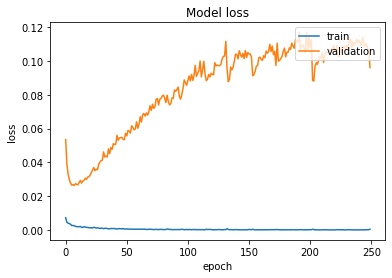

In [ ]:
# We initialize our optimizer to update the weights of the model
optimizer_RNN = torch.optim.Adam(model_RNN.parameters(), lr=1e-3, weight_decay=1e-8) # L2 = weight_decay
model_run(model_RNN, optimizer_RNN)

## BRNN

This time we set Bidirectional parameter to True.
In addition we dobuled the input size for the final linear layer and the size of the h0 tesnor. We address it as if we have 2 layers of RNN. 

In [ ]:
'''
Class BRNN
Bidirectional RNN

'''

class BRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
    super(BRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    self.embeddings = Embedding(input_size, hidden_size, word_embeddings)
    self.rnn = nn.RNN(input_size = input_size,
                      hidden_size = hidden_size,
                      num_layers = num_layers,
                      batch_first=True,
                      dropout = 0,
                      bidirectional=True
                      )
    ## input_shape to nn.RNN-> (batch_size, seq_length, input_size) 
    self.dropout = nn.Dropout(dropout)
    self.activation = nn.Tanh()
    # The last layer to compute the probabilities for the output classes
    self.final_layer = nn.Linear(in_features=hidden_size*2, out_features=num_classes)
  

  def forward(self, x_idx):
    x = self.embeddings(x_idx)
   # h0 = torch.zeros(self.num_layers *2, x.size(0), self.hidden_size).to("cuda")
    h0 = torch.zeros(self.num_layers *2, x.size(0), self.hidden_size)

    if torch.cuda.is_available():
        h0 = h0.to("cuda")
        
    output, _ = self.rnn(x.float(), h0)

    output = self.dropout(output)
    output = self.activation(output)
    logits = self.final_layer(output)
    return logits


In [ ]:
# We initialize our model
model_BRNN = BRNN(input_size = WORD_DIM,
            hidden_size = 128,
            num_layers = 1,
            num_classes = len(MAPPING_NER_LABELS),
            dropout = 0.3
            )

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 110.90it/s]
Test: 59it [00:00, 111.86it/s]


Train loss: 0.8541
Val   loss: 0.5381
Test  loss: 0.5322

Val   Macro F1: 0.1997
Test  Macro F1: 0.1971

Best Epoch: 0, best val macro F1: 0.1997, test macro F1: 0.1971


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:00, 68.43it/s]
Val: 8it [00:00, 118.18it/s]
Test: 59it [00:00, 107.75it/s]


Train loss: 0.4331
Val   loss: 0.3426
Test  loss: 0.3156

Val   Macro F1: 0.3981
Test  Macro F1: 0.4092

Best Epoch: 1, best val macro F1: 0.3981, test macro F1: 0.4092


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:00, 68.58it/s]
Val: 8it [00:00, 99.37it/s]
Test: 59it [00:00, 111.07it/s]


Train loss: 0.2851
Val   loss: 0.2819
Test  loss: 0.2345

Val   Macro F1: 0.4969
Test  Macro F1: 0.5153

Best Epoch: 2, best val macro F1: 0.4969, test macro F1: 0.5153


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 110.50it/s]
Test: 59it [00:00, 108.64it/s]


Train loss: 0.2274
Val   loss: 0.2767
Test  loss: 0.1906

Val   Macro F1: 0.5599
Test  Macro F1: 0.5972

Best Epoch: 3, best val macro F1: 0.5599, test macro F1: 0.5972


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 111.11it/s]
Test: 59it [00:00, 108.19it/s]


Train loss: 0.1922
Val   loss: 0.2599
Test  loss: 0.1645

Val   Macro F1: 0.5926
Test  Macro F1: 0.6515

Best Epoch: 4, best val macro F1: 0.5926, test macro F1: 0.6515


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:00, 68.13it/s]
Val: 8it [00:00, 114.41it/s]
Test: 59it [00:00, 110.99it/s]


Train loss: 0.1675
Val   loss: 0.2660
Test  loss: 0.1407

Val   Macro F1: 0.6385
Test  Macro F1: 0.7090

Best Epoch: 5, best val macro F1: 0.6385, test macro F1: 0.7090


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:00, 68.38it/s]
Val: 8it [00:00, 109.14it/s]
Test: 59it [00:00, 109.65it/s]


Train loss: 0.1486
Val   loss: 0.2563
Test  loss: 0.1255

Val   Macro F1: 0.6514
Test  Macro F1: 0.7357

Best Epoch: 6, best val macro F1: 0.6514, test macro F1: 0.7357


------------------------------------------------------------------------
Epoch: 7


Training: 59it [00:00, 68.30it/s]
Val: 8it [00:00, 118.00it/s]
Test: 59it [00:00, 110.54it/s]


Train loss: 0.1330
Val   loss: 0.2585
Test  loss: 0.1097

Val   Macro F1: 0.6664
Test  Macro F1: 0.7592

Best Epoch: 7, best val macro F1: 0.6664, test macro F1: 0.7592


------------------------------------------------------------------------
Epoch: 8


Training: 59it [00:00, 68.24it/s]
Val: 8it [00:00, 116.34it/s]
Test: 59it [00:00, 107.99it/s]


Train loss: 0.1204
Val   loss: 0.2588
Test  loss: 0.0995

Val   Macro F1: 0.6701
Test  Macro F1: 0.7723

Best Epoch: 8, best val macro F1: 0.6701, test macro F1: 0.7723


------------------------------------------------------------------------
Epoch: 9


Training: 59it [00:00, 68.42it/s]
Val: 8it [00:00, 111.79it/s]
Test: 59it [00:00, 107.59it/s]


Train loss: 0.1097
Val   loss: 0.2755
Test  loss: 0.0918

Val   Macro F1: 0.6625
Test  Macro F1: 0.7837

Best Epoch: 8, best val macro F1: 0.6701, test macro F1: 0.7723


------------------------------------------------------------------------
Epoch: 10


Training: 59it [00:00, 68.65it/s]
Val: 8it [00:00, 118.44it/s]
Test: 59it [00:00, 109.13it/s]


Train loss: 0.1028
Val   loss: 0.2757
Test  loss: 0.0856

Val   Macro F1: 0.6662
Test  Macro F1: 0.7886

Best Epoch: 8, best val macro F1: 0.6701, test macro F1: 0.7723


------------------------------------------------------------------------
Epoch: 11


Training: 59it [00:00, 68.61it/s]
Val: 8it [00:00, 107.08it/s]
Test: 59it [00:00, 108.81it/s]


Train loss: 0.0934
Val   loss: 0.2834
Test  loss: 0.0794

Val   Macro F1: 0.6668
Test  Macro F1: 0.7953

Best Epoch: 8, best val macro F1: 0.6701, test macro F1: 0.7723


------------------------------------------------------------------------
Epoch: 12


Training: 59it [00:00, 68.14it/s]
Val: 8it [00:00, 116.82it/s]
Test: 59it [00:00, 107.89it/s]


Train loss: 0.0862
Val   loss: 0.2925
Test  loss: 0.0699

Val   Macro F1: 0.6700
Test  Macro F1: 0.8046

Best Epoch: 8, best val macro F1: 0.6701, test macro F1: 0.7723


------------------------------------------------------------------------
Epoch: 13


Training: 59it [00:00, 68.21it/s]
Val: 8it [00:00, 113.85it/s]
Test: 59it [00:00, 109.61it/s]


Train loss: 0.0805
Val   loss: 0.3174
Test  loss: 0.0698

Val   Macro F1: 0.6728
Test  Macro F1: 0.8053

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 14


Training: 59it [00:00, 68.00it/s]
Val: 8it [00:00, 113.66it/s]
Test: 59it [00:00, 105.08it/s]


Train loss: 0.0754
Val   loss: 0.3029
Test  loss: 0.0635

Val   Macro F1: 0.6615
Test  Macro F1: 0.8102

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 15


Training: 59it [00:00, 68.42it/s]
Val: 8it [00:00, 113.25it/s]
Test: 59it [00:00, 109.68it/s]


Train loss: 0.0703
Val   loss: 0.3204
Test  loss: 0.0540

Val   Macro F1: 0.6585
Test  Macro F1: 0.8180

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 16


Training: 59it [00:00, 68.01it/s]
Val: 8it [00:00, 119.53it/s]
Test: 59it [00:00, 108.62it/s]


Train loss: 0.0675
Val   loss: 0.3225
Test  loss: 0.0508

Val   Macro F1: 0.6639
Test  Macro F1: 0.8229

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 17


Training: 59it [00:00, 68.45it/s]
Val: 8it [00:00, 116.21it/s]
Test: 59it [00:00, 109.37it/s]


Train loss: 0.0615
Val   loss: 0.3385
Test  loss: 0.0475

Val   Macro F1: 0.6620
Test  Macro F1: 0.8258

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 18


Training: 59it [00:00, 68.00it/s]
Val: 8it [00:00, 116.02it/s]
Test: 59it [00:00, 108.33it/s]


Train loss: 0.0575
Val   loss: 0.3350
Test  loss: 0.0427

Val   Macro F1: 0.6564
Test  Macro F1: 0.8299

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 19


Training: 59it [00:00, 67.52it/s]
Val: 8it [00:00, 111.31it/s]
Test: 59it [00:00, 110.00it/s]


Train loss: 0.0523
Val   loss: 0.3447
Test  loss: 0.0415

Val   Macro F1: 0.6607
Test  Macro F1: 0.8310

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 20


Training: 59it [00:00, 67.51it/s]
Val: 8it [00:00, 112.33it/s]
Test: 59it [00:00, 107.48it/s]


Train loss: 0.0495
Val   loss: 0.3688
Test  loss: 0.0353

Val   Macro F1: 0.6491
Test  Macro F1: 0.8367

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 21


Training: 59it [00:00, 68.27it/s]
Val: 8it [00:00, 115.96it/s]
Test: 59it [00:00, 109.41it/s]


Train loss: 0.0451
Val   loss: 0.3805
Test  loss: 0.0324

Val   Macro F1: 0.6474
Test  Macro F1: 0.8380

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 22


Training: 59it [00:00, 67.87it/s]
Val: 8it [00:00, 111.18it/s]
Test: 59it [00:00, 106.59it/s]


Train loss: 0.0415
Val   loss: 0.4024
Test  loss: 0.0312

Val   Macro F1: 0.6561
Test  Macro F1: 0.8400

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 23


Training: 59it [00:00, 68.60it/s]
Val: 8it [00:00, 109.66it/s]
Test: 59it [00:00, 110.33it/s]


Train loss: 0.0387
Val   loss: 0.4088
Test  loss: 0.0282

Val   Macro F1: 0.6545
Test  Macro F1: 0.8446

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 24


Training: 59it [00:00, 67.67it/s]
Val: 8it [00:00, 113.01it/s]
Test: 59it [00:00, 107.54it/s]


Train loss: 0.0353
Val   loss: 0.4259
Test  loss: 0.0252

Val   Macro F1: 0.6449
Test  Macro F1: 0.8482

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 25


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 113.69it/s]
Test: 59it [00:00, 108.78it/s]


Train loss: 0.0336
Val   loss: 0.4415
Test  loss: 0.0224

Val   Macro F1: 0.6417
Test  Macro F1: 0.8468

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 26


Training: 59it [00:00, 67.99it/s]
Val: 8it [00:00, 110.14it/s]
Test: 59it [00:00, 107.83it/s]


Train loss: 0.0317
Val   loss: 0.4590
Test  loss: 0.0259

Val   Macro F1: 0.6304
Test  Macro F1: 0.8468

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 27


Training: 59it [00:00, 67.77it/s]
Val: 8it [00:00, 104.31it/s]
Test: 59it [00:00, 108.87it/s]


Train loss: 0.0316
Val   loss: 0.4636
Test  loss: 0.0223

Val   Macro F1: 0.6367
Test  Macro F1: 0.8455

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 28


Training: 59it [00:00, 68.58it/s]
Val: 8it [00:00, 112.64it/s]
Test: 59it [00:00, 107.71it/s]


Train loss: 0.0286
Val   loss: 0.4800
Test  loss: 0.0183

Val   Macro F1: 0.6365
Test  Macro F1: 0.8485

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 29


Training: 59it [00:00, 68.47it/s]
Val: 8it [00:00, 100.18it/s]
Test: 59it [00:00, 110.14it/s]


Train loss: 0.0250
Val   loss: 0.4889
Test  loss: 0.0187

Val   Macro F1: 0.6299
Test  Macro F1: 0.8503

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 30


Training: 59it [00:00, 67.79it/s]
Val: 8it [00:00, 109.82it/s]
Test: 59it [00:00, 108.31it/s]


Train loss: 0.0239
Val   loss: 0.4842
Test  loss: 0.0175

Val   Macro F1: 0.6462
Test  Macro F1: 0.8493

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 31


Training: 59it [00:00, 68.96it/s]
Val: 8it [00:00, 109.25it/s]
Test: 59it [00:00, 110.03it/s]


Train loss: 0.0232
Val   loss: 0.5128
Test  loss: 0.0143

Val   Macro F1: 0.6385
Test  Macro F1: 0.8537

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 32


Training: 59it [00:00, 68.75it/s]
Val: 8it [00:00, 113.21it/s]
Test: 59it [00:00, 111.05it/s]


Train loss: 0.0202
Val   loss: 0.5220
Test  loss: 0.0135

Val   Macro F1: 0.6293
Test  Macro F1: 0.8542

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 33


Training: 59it [00:00, 68.43it/s]
Val: 8it [00:00, 110.00it/s]
Test: 59it [00:00, 108.00it/s]


Train loss: 0.0184
Val   loss: 0.5323
Test  loss: 0.0121

Val   Macro F1: 0.6346
Test  Macro F1: 0.8545

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 34


Training: 59it [00:00, 67.88it/s]
Val: 8it [00:00, 113.55it/s]
Test: 59it [00:00, 109.51it/s]


Train loss: 0.0166
Val   loss: 0.5628
Test  loss: 0.0099

Val   Macro F1: 0.6168
Test  Macro F1: 0.8428

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 35


Training: 59it [00:00, 67.67it/s]
Val: 8it [00:00, 111.37it/s]
Test: 59it [00:00, 108.54it/s]


Train loss: 0.0166
Val   loss: 0.5595
Test  loss: 0.0108

Val   Macro F1: 0.6275
Test  Macro F1: 0.8578

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 36


Training: 59it [00:00, 67.79it/s]
Val: 8it [00:00, 109.43it/s]
Test: 59it [00:00, 107.85it/s]


Train loss: 0.0162
Val   loss: 0.5628
Test  loss: 0.0093

Val   Macro F1: 0.6157
Test  Macro F1: 0.8427

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 37


Training: 59it [00:00, 67.64it/s]
Val: 8it [00:00, 112.44it/s]
Test: 59it [00:00, 108.37it/s]


Train loss: 0.0143
Val   loss: 0.5913
Test  loss: 0.0079

Val   Macro F1: 0.6142
Test  Macro F1: 0.8409

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 38


Training: 59it [00:00, 68.48it/s]
Val: 8it [00:00, 106.27it/s]
Test: 59it [00:00, 111.22it/s]


Train loss: 0.0128
Val   loss: 0.6040
Test  loss: 0.0069

Val   Macro F1: 0.6184
Test  Macro F1: 0.8548

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 39


Training: 59it [00:00, 67.83it/s]
Val: 8it [00:00, 112.21it/s]
Test: 59it [00:00, 108.58it/s]


Train loss: 0.0118
Val   loss: 0.5898
Test  loss: 0.0066

Val   Macro F1: 0.6118
Test  Macro F1: 0.8318

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 40


Training: 59it [00:00, 68.38it/s]
Val: 8it [00:00, 112.17it/s]
Test: 59it [00:00, 110.38it/s]


Train loss: 0.0111
Val   loss: 0.6264
Test  loss: 0.0057

Val   Macro F1: 0.6190
Test  Macro F1: 0.8571

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 41


Training: 59it [00:00, 68.17it/s]
Val: 8it [00:00, 114.96it/s]
Test: 59it [00:00, 110.00it/s]


Train loss: 0.0105
Val   loss: 0.6320
Test  loss: 0.0064

Val   Macro F1: 0.6012
Test  Macro F1: 0.8183

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 42


Training: 59it [00:00, 68.20it/s]
Val: 8it [00:00, 110.70it/s]
Test: 59it [00:00, 109.64it/s]


Train loss: 0.0115
Val   loss: 0.6510
Test  loss: 0.0067

Val   Macro F1: 0.6129
Test  Macro F1: 0.8471

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 43


Training: 59it [00:00, 68.50it/s]
Val: 8it [00:00, 115.46it/s]
Test: 59it [00:00, 109.18it/s]


Train loss: 0.0100
Val   loss: 0.6576
Test  loss: 0.0044

Val   Macro F1: 0.6183
Test  Macro F1: 0.8549

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 44


Training: 59it [00:00, 68.17it/s]
Val: 8it [00:00, 111.17it/s]
Test: 59it [00:00, 111.08it/s]


Train loss: 0.0094
Val   loss: 0.6478
Test  loss: 0.0040

Val   Macro F1: 0.6201
Test  Macro F1: 0.8557

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 45


Training: 59it [00:00, 68.74it/s]
Val: 8it [00:00, 113.69it/s]
Test: 59it [00:00, 107.49it/s]


Train loss: 0.0099
Val   loss: 0.6606
Test  loss: 0.0057

Val   Macro F1: 0.5770
Test  Macro F1: 0.7962

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 46


Training: 59it [00:00, 68.46it/s]
Val: 8it [00:00, 115.93it/s]
Test: 59it [00:00, 110.33it/s]


Train loss: 0.0091
Val   loss: 0.6863
Test  loss: 0.0044

Val   Macro F1: 0.6123
Test  Macro F1: 0.8478

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 47


Training: 59it [00:00, 68.02it/s]
Val: 8it [00:00, 115.55it/s]
Test: 59it [00:00, 106.37it/s]


Train loss: 0.0077
Val   loss: 0.7018
Test  loss: 0.0034

Val   Macro F1: 0.6039
Test  Macro F1: 0.8451

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 48


Training: 59it [00:00, 68.04it/s]
Val: 8it [00:00, 111.44it/s]
Test: 59it [00:00, 109.86it/s]


Train loss: 0.0066
Val   loss: 0.6969
Test  loss: 0.0027

Val   Macro F1: 0.6142
Test  Macro F1: 0.8526

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 49


Training: 59it [00:00, 68.29it/s]
Val: 8it [00:00, 117.66it/s]
Test: 59it [00:00, 108.66it/s]


Train loss: 0.0062
Val   loss: 0.7003
Test  loss: 0.0029

Val   Macro F1: 0.6006
Test  Macro F1: 0.8292

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 50


Training: 59it [00:00, 67.78it/s]
Val: 8it [00:00, 93.55it/s]
Test: 59it [00:00, 107.16it/s]


Train loss: 0.0061
Val   loss: 0.7027
Test  loss: 0.0025

Val   Macro F1: 0.6122
Test  Macro F1: 0.8412

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 51


Training: 59it [00:00, 68.74it/s]
Val: 8it [00:00, 112.74it/s]
Test: 59it [00:00, 107.67it/s]


Train loss: 0.0059
Val   loss: 0.7191
Test  loss: 0.0030

Val   Macro F1: 0.6024
Test  Macro F1: 0.8288

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 52


Training: 59it [00:00, 67.79it/s]
Val: 8it [00:00, 106.48it/s]
Test: 59it [00:00, 109.06it/s]


Train loss: 0.0056
Val   loss: 0.7270
Test  loss: 0.0024

Val   Macro F1: 0.6155
Test  Macro F1: 0.8478

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 53


Training: 59it [00:00, 68.02it/s]
Val: 8it [00:00, 109.90it/s]
Test: 59it [00:00, 108.43it/s]


Train loss: 0.0055
Val   loss: 0.7566
Test  loss: 0.0032

Val   Macro F1: 0.6008
Test  Macro F1: 0.8343

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 54


Training: 59it [00:00, 68.01it/s]
Val: 8it [00:00, 106.80it/s]
Test: 59it [00:00, 110.12it/s]


Train loss: 0.0075
Val   loss: 0.7473
Test  loss: 0.0030

Val   Macro F1: 0.6087
Test  Macro F1: 0.8460

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 55


Training: 59it [00:00, 68.11it/s]
Val: 8it [00:00, 120.26it/s]
Test: 59it [00:00, 109.44it/s]


Train loss: 0.0062
Val   loss: 0.7742
Test  loss: 0.0026

Val   Macro F1: 0.6048
Test  Macro F1: 0.8464

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 56


Training: 59it [00:00, 67.92it/s]
Val: 8it [00:00, 81.80it/s]
Test: 59it [00:00, 76.27it/s]


Train loss: 0.0057
Val   loss: 0.7714
Test  loss: 0.0023

Val   Macro F1: 0.6030
Test  Macro F1: 0.8471

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 57


Training: 59it [00:00, 63.71it/s]
Val: 8it [00:00, 117.06it/s]
Test: 59it [00:00, 109.31it/s]


Train loss: 0.0281
Val   loss: 0.7312
Test  loss: 0.0090

Val   Macro F1: 0.6026
Test  Macro F1: 0.8230

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 58


Training: 59it [00:00, 67.76it/s]
Val: 8it [00:00, 118.55it/s]
Test: 59it [00:00, 106.82it/s]


Train loss: 0.0125
Val   loss: 0.7410
Test  loss: 0.0046

Val   Macro F1: 0.5982
Test  Macro F1: 0.8212

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 59


Training: 59it [00:00, 67.79it/s]
Val: 8it [00:00, 114.15it/s]
Test: 59it [00:00, 108.23it/s]


Train loss: 0.0074
Val   loss: 0.7541
Test  loss: 0.0022

Val   Macro F1: 0.6076
Test  Macro F1: 0.8412

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 60


Training: 59it [00:00, 67.98it/s]
Val: 8it [00:00, 112.00it/s]
Test: 59it [00:00, 108.64it/s]


Train loss: 0.0046
Val   loss: 0.7593
Test  loss: 0.0015

Val   Macro F1: 0.5965
Test  Macro F1: 0.8216

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 61


Training: 59it [00:00, 68.30it/s]
Val: 8it [00:00, 113.21it/s]
Test: 59it [00:00, 108.51it/s]


Train loss: 0.0039
Val   loss: 0.7819
Test  loss: 0.0012

Val   Macro F1: 0.6026
Test  Macro F1: 0.8382

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 62


Training: 59it [00:00, 67.77it/s]
Val: 8it [00:00, 114.28it/s]
Test: 59it [00:00, 109.45it/s]


Train loss: 0.0039
Val   loss: 0.7991
Test  loss: 0.0014

Val   Macro F1: 0.5778
Test  Macro F1: 0.8064

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 63


Training: 59it [00:00, 67.77it/s]
Val: 8it [00:00, 112.07it/s]
Test: 59it [00:00, 108.75it/s]


Train loss: 0.0034
Val   loss: 0.7985
Test  loss: 0.0011

Val   Macro F1: 0.5881
Test  Macro F1: 0.8173

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 64


Training: 59it [00:00, 68.84it/s]
Val: 8it [00:00, 114.78it/s]
Test: 59it [00:00, 108.94it/s]


Train loss: 0.0029
Val   loss: 0.8053
Test  loss: 0.0008

Val   Macro F1: 0.5864
Test  Macro F1: 0.8174

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 65


Training: 59it [00:00, 68.23it/s]
Val: 8it [00:00, 101.65it/s]
Test: 59it [00:00, 106.41it/s]


Train loss: 0.0026
Val   loss: 0.8180
Test  loss: 0.0008

Val   Macro F1: 0.5763
Test  Macro F1: 0.8016

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 66


Training: 59it [00:00, 68.51it/s]
Val: 8it [00:00, 115.17it/s]
Test: 59it [00:00, 109.41it/s]


Train loss: 0.0024
Val   loss: 0.8193
Test  loss: 0.0008

Val   Macro F1: 0.5982
Test  Macro F1: 0.8283

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 67


Training: 59it [00:00, 68.10it/s]
Val: 8it [00:00, 116.88it/s]
Test: 59it [00:00, 108.23it/s]


Train loss: 0.0023
Val   loss: 0.8436
Test  loss: 0.0007

Val   Macro F1: 0.5826
Test  Macro F1: 0.8181

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 68


Training: 59it [00:00, 68.06it/s]
Val: 8it [00:00, 111.21it/s]
Test: 59it [00:00, 107.95it/s]


Train loss: 0.0021
Val   loss: 0.8443
Test  loss: 0.0006

Val   Macro F1: 0.5805
Test  Macro F1: 0.8069

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 69


Training: 59it [00:00, 67.80it/s]
Val: 8it [00:00, 112.48it/s]
Test: 59it [00:00, 107.10it/s]


Train loss: 0.0020
Val   loss: 0.8528
Test  loss: 0.0005

Val   Macro F1: 0.5837
Test  Macro F1: 0.8206

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 70


Training: 59it [00:00, 67.31it/s]
Val: 8it [00:00, 109.58it/s]
Test: 59it [00:00, 102.01it/s]


Train loss: 0.0019
Val   loss: 0.8646
Test  loss: 0.0005

Val   Macro F1: 0.5953
Test  Macro F1: 0.8286

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 71


Training: 59it [00:00, 67.73it/s]
Val: 8it [00:00, 110.70it/s]
Test: 59it [00:00, 107.86it/s]


Train loss: 0.0026
Val   loss: 0.8765
Test  loss: 0.0010

Val   Macro F1: 0.5889
Test  Macro F1: 0.8314

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 72


Training: 59it [00:00, 66.53it/s]
Val: 8it [00:00, 111.23it/s]
Test: 59it [00:00, 108.41it/s]


Train loss: 0.0039
Val   loss: 0.8949
Test  loss: 0.0018

Val   Macro F1: 0.5747
Test  Macro F1: 0.8172

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 73


Training: 59it [00:00, 68.37it/s]
Val: 8it [00:00, 110.30it/s]
Test: 59it [00:00, 107.71it/s]


Train loss: 0.0061
Val   loss: 0.8509
Test  loss: 0.0038

Val   Macro F1: 0.6061
Test  Macro F1: 0.8439

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 74


Training: 59it [00:00, 68.23it/s]
Val: 8it [00:00, 111.61it/s]
Test: 59it [00:00, 107.73it/s]


Train loss: 0.0086
Val   loss: 0.8596
Test  loss: 0.0025

Val   Macro F1: 0.6057
Test  Macro F1: 0.8447

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 75


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 108.32it/s]
Test: 59it [00:00, 106.61it/s]


Train loss: 0.0058
Val   loss: 0.8804
Test  loss: 0.0024

Val   Macro F1: 0.5784
Test  Macro F1: 0.8059

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 76


Training: 59it [00:00, 67.60it/s]
Val: 8it [00:00, 108.62it/s]
Test: 59it [00:00, 105.66it/s]


Train loss: 0.0046
Val   loss: 0.8819
Test  loss: 0.0013

Val   Macro F1: 0.5982
Test  Macro F1: 0.8325

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 77


Training: 59it [00:00, 68.63it/s]
Val: 8it [00:00, 109.76it/s]
Test: 59it [00:00, 109.12it/s]


Train loss: 0.0028
Val   loss: 0.8857
Test  loss: 0.0008

Val   Macro F1: 0.6057
Test  Macro F1: 0.8421

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 78


Training: 59it [00:00, 68.63it/s]
Val: 8it [00:00, 115.39it/s]
Test: 59it [00:00, 107.96it/s]


Train loss: 0.0033
Val   loss: 0.9303
Test  loss: 0.0012

Val   Macro F1: 0.5989
Test  Macro F1: 0.8419

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 79


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 108.55it/s]
Test: 59it [00:00, 107.79it/s]


Train loss: 0.0027
Val   loss: 0.9071
Test  loss: 0.0006

Val   Macro F1: 0.6074
Test  Macro F1: 0.8503

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 80


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 116.66it/s]
Test: 59it [00:00, 107.19it/s]


Train loss: 0.0021
Val   loss: 0.9087
Test  loss: 0.0005

Val   Macro F1: 0.6064
Test  Macro F1: 0.8443

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 81


Training: 59it [00:00, 67.77it/s]
Val: 8it [00:00, 112.82it/s]
Test: 59it [00:00, 106.62it/s]


Train loss: 0.0019
Val   loss: 0.9159
Test  loss: 0.0004

Val   Macro F1: 0.6045
Test  Macro F1: 0.8480

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 82


Training: 59it [00:00, 68.49it/s]
Val: 8it [00:00, 104.66it/s]
Test: 59it [00:00, 108.74it/s]


Train loss: 0.0017
Val   loss: 0.9172
Test  loss: 0.0004

Val   Macro F1: 0.6045
Test  Macro F1: 0.8433

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 83


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 114.21it/s]
Test: 59it [00:00, 110.03it/s]


Train loss: 0.0017
Val   loss: 0.9341
Test  loss: 0.0004

Val   Macro F1: 0.5956
Test  Macro F1: 0.8334

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 84


Training: 59it [00:00, 68.14it/s]
Val: 8it [00:00, 116.30it/s]
Test: 59it [00:00, 106.31it/s]


Train loss: 0.0014
Val   loss: 0.9408
Test  loss: 0.0003

Val   Macro F1: 0.6072
Test  Macro F1: 0.8428

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 85


Training: 59it [00:00, 67.54it/s]
Val: 8it [00:00, 114.07it/s]
Test: 59it [00:00, 105.77it/s]


Train loss: 0.0013
Val   loss: 0.9499
Test  loss: 0.0003

Val   Macro F1: 0.5924
Test  Macro F1: 0.8336

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 86


Training: 59it [00:00, 67.75it/s]
Val: 8it [00:00, 117.00it/s]
Test: 59it [00:00, 108.61it/s]


Train loss: 0.0012
Val   loss: 0.9638
Test  loss: 0.0003

Val   Macro F1: 0.6038
Test  Macro F1: 0.8462

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 87


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 112.17it/s]
Test: 59it [00:00, 108.41it/s]


Train loss: 0.0014
Val   loss: 0.9461
Test  loss: 0.0004

Val   Macro F1: 0.6013
Test  Macro F1: 0.8388

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 88


Training: 59it [00:00, 67.89it/s]
Val: 8it [00:00, 103.55it/s]
Test: 59it [00:00, 107.22it/s]


Train loss: 0.0019
Val   loss: 0.9777
Test  loss: 0.0004

Val   Macro F1: 0.6021
Test  Macro F1: 0.8408

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 89


Training: 59it [00:00, 67.51it/s]
Val: 8it [00:00, 112.94it/s]
Test: 59it [00:00, 107.72it/s]


Train loss: 0.0017
Val   loss: 0.9432
Test  loss: 0.0005

Val   Macro F1: 0.6029
Test  Macro F1: 0.8358

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 90


Training: 59it [00:00, 68.27it/s]
Val: 8it [00:00, 95.96it/s]
Test: 59it [00:00, 106.93it/s]


Train loss: 0.0019
Val   loss: 0.9649
Test  loss: 0.0005

Val   Macro F1: 0.6035
Test  Macro F1: 0.8467

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 91


Training: 59it [00:00, 67.64it/s]
Val: 8it [00:00, 112.29it/s]
Test: 59it [00:00, 110.24it/s]


Train loss: 0.0018
Val   loss: 0.9854
Test  loss: 0.0005

Val   Macro F1: 0.5913
Test  Macro F1: 0.8336

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 92


Training: 59it [00:00, 68.29it/s]
Val: 8it [00:00, 101.71it/s]
Test: 59it [00:00, 108.97it/s]


Train loss: 0.0016
Val   loss: 0.9640
Test  loss: 0.0005

Val   Macro F1: 0.6040
Test  Macro F1: 0.8420

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 93


Training: 59it [00:00, 67.64it/s]
Val: 8it [00:00, 114.95it/s]
Test: 59it [00:00, 107.38it/s]


Train loss: 0.0025
Val   loss: 0.9757
Test  loss: 0.0011

Val   Macro F1: 0.6116
Test  Macro F1: 0.8505

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 94


Training: 59it [00:00, 68.98it/s]
Val: 8it [00:00, 106.20it/s]
Test: 59it [00:00, 108.59it/s]


Train loss: 0.0038
Val   loss: 0.9847
Test  loss: 0.0034

Val   Macro F1: 0.6077
Test  Macro F1: 0.8514

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 95


Training: 59it [00:00, 68.76it/s]
Val: 8it [00:00, 113.78it/s]
Test: 59it [00:00, 107.42it/s]


Train loss: 0.0144
Val   loss: 0.9019
Test  loss: 0.0279

Val   Macro F1: 0.5619
Test  Macro F1: 0.7619

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 96


Training: 59it [00:00, 68.19it/s]
Val: 8it [00:00, 111.07it/s]
Test: 59it [00:00, 108.34it/s]


Train loss: 0.0237
Val   loss: 0.9538
Test  loss: 0.0074

Val   Macro F1: 0.5984
Test  Macro F1: 0.8324

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 97


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 108.72it/s]
Test: 59it [00:00, 106.67it/s]


Train loss: 0.0104
Val   loss: 0.9205
Test  loss: 0.0025

Val   Macro F1: 0.6202
Test  Macro F1: 0.8593

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 98


Training: 59it [00:00, 67.78it/s]
Val: 8it [00:00, 116.78it/s]
Test: 59it [00:00, 107.50it/s]


Train loss: 0.0043
Val   loss: 0.9379
Test  loss: 0.0007

Val   Macro F1: 0.6062
Test  Macro F1: 0.8370

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 99


Training: 59it [00:00, 67.31it/s]
Val: 8it [00:00, 110.55it/s]
Test: 59it [00:00, 107.28it/s]


Train loss: 0.0026
Val   loss: 0.9701
Test  loss: 0.0005

Val   Macro F1: 0.6090
Test  Macro F1: 0.8497

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 100


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 107.44it/s]
Test: 59it [00:00, 107.99it/s]


Train loss: 0.0017
Val   loss: 0.9515
Test  loss: 0.0003

Val   Macro F1: 0.6144
Test  Macro F1: 0.8501

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 101


Training: 59it [00:00, 67.65it/s]
Val: 8it [00:00, 116.49it/s]
Test: 59it [00:00, 107.23it/s]


Train loss: 0.0013
Val   loss: 0.9713
Test  loss: 0.0002

Val   Macro F1: 0.6109
Test  Macro F1: 0.8442

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 102


Training: 59it [00:00, 68.16it/s]
Val: 8it [00:00, 113.35it/s]
Test: 59it [00:00, 105.23it/s]


Train loss: 0.0011
Val   loss: 0.9705
Test  loss: 0.0002

Val   Macro F1: 0.6068
Test  Macro F1: 0.8406

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 103


Training: 59it [00:01, 53.44it/s]
Val: 8it [00:00, 75.05it/s]
Test: 59it [00:00, 60.15it/s]


Train loss: 0.0011
Val   loss: 1.0004
Test  loss: 0.0002

Val   Macro F1: 0.6039
Test  Macro F1: 0.8419

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 104


Training: 59it [00:01, 46.22it/s]
Val: 8it [00:00, 38.42it/s]
Test: 59it [00:00, 63.24it/s]


Train loss: 0.0010
Val   loss: 1.0018
Test  loss: 0.0002

Val   Macro F1: 0.6073
Test  Macro F1: 0.8433

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 105


Training: 59it [00:01, 53.85it/s]
Val: 8it [00:00, 65.20it/s]
Test: 59it [00:01, 43.10it/s]


Train loss: 0.0009
Val   loss: 1.0088
Test  loss: 0.0002

Val   Macro F1: 0.6013
Test  Macro F1: 0.8330

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 106


Training: 59it [00:01, 48.70it/s]
Val: 8it [00:00, 81.93it/s]
Test: 59it [00:01, 53.87it/s]


Train loss: 0.0009
Val   loss: 1.0042
Test  loss: 0.0002

Val   Macro F1: 0.6072
Test  Macro F1: 0.8439

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 107


Training: 59it [00:01, 48.34it/s]
Val: 8it [00:00, 49.95it/s]
Test: 59it [00:00, 86.07it/s]


Train loss: 0.0008
Val   loss: 1.0289
Test  loss: 0.0002

Val   Macro F1: 0.5994
Test  Macro F1: 0.8399

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 108


Training: 59it [00:00, 68.46it/s]
Val: 8it [00:00, 103.24it/s]
Test: 59it [00:00, 107.78it/s]


Train loss: 0.0008
Val   loss: 1.0306
Test  loss: 0.0002

Val   Macro F1: 0.6048
Test  Macro F1: 0.8433

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 109


Training: 59it [00:00, 68.16it/s]
Val: 8it [00:00, 113.89it/s]
Test: 59it [00:00, 109.19it/s]


Train loss: 0.0008
Val   loss: 1.0287
Test  loss: 0.0001

Val   Macro F1: 0.6052
Test  Macro F1: 0.8402

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 110


Training: 59it [00:00, 68.50it/s]
Val: 8it [00:00, 90.02it/s]
Test: 59it [00:00, 109.53it/s]


Train loss: 0.0007
Val   loss: 1.0372
Test  loss: 0.0001

Val   Macro F1: 0.6070
Test  Macro F1: 0.8455

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 111


Training: 59it [00:00, 68.04it/s]
Val: 8it [00:00, 101.20it/s]
Test: 59it [00:00, 109.21it/s]


Train loss: 0.0007
Val   loss: 1.0564
Test  loss: 0.0002

Val   Macro F1: 0.6058
Test  Macro F1: 0.8455

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 112


Training: 59it [00:00, 67.97it/s]
Val: 8it [00:00, 103.03it/s]
Test: 59it [00:00, 107.64it/s]


Train loss: 0.0008
Val   loss: 1.0427
Test  loss: 0.0001

Val   Macro F1: 0.6063
Test  Macro F1: 0.8463

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 113


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 112.96it/s]
Test: 59it [00:00, 108.13it/s]


Train loss: 0.0007
Val   loss: 1.0436
Test  loss: 0.0001

Val   Macro F1: 0.6081
Test  Macro F1: 0.8441

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 114


Training: 59it [00:00, 68.60it/s]
Val: 8it [00:00, 112.34it/s]
Test: 59it [00:00, 106.95it/s]


Train loss: 0.0006
Val   loss: 1.0469
Test  loss: 0.0001

Val   Macro F1: 0.6027
Test  Macro F1: 0.8345

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 115


Training: 59it [00:00, 67.83it/s]
Val: 8it [00:00, 110.92it/s]
Test: 59it [00:00, 110.10it/s]


Train loss: 0.0007
Val   loss: 1.0597
Test  loss: 0.0001

Val   Macro F1: 0.5990
Test  Macro F1: 0.8350

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 116


Training: 59it [00:00, 67.85it/s]
Val: 8it [00:00, 112.97it/s]
Test: 59it [00:00, 108.30it/s]


Train loss: 0.0006
Val   loss: 1.0755
Test  loss: 0.0002

Val   Macro F1: 0.5992
Test  Macro F1: 0.8425

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 117


Training: 59it [00:00, 68.60it/s]
Val: 8it [00:00, 118.22it/s]
Test: 59it [00:00, 111.18it/s]


Train loss: 0.0007
Val   loss: 1.0803
Test  loss: 0.0001

Val   Macro F1: 0.5987
Test  Macro F1: 0.8422

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 118


Training: 59it [00:00, 68.20it/s]
Val: 8it [00:00, 111.28it/s]
Test: 59it [00:00, 108.03it/s]


Train loss: 0.0007
Val   loss: 1.0696
Test  loss: 0.0002

Val   Macro F1: 0.6026
Test  Macro F1: 0.8464

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 119


Training: 59it [00:00, 67.82it/s]
Val: 8it [00:00, 106.23it/s]
Test: 59it [00:00, 110.82it/s]


Train loss: 0.0010
Val   loss: 1.0572
Test  loss: 0.0006

Val   Macro F1: 0.6014
Test  Macro F1: 0.8434

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 120


Training: 59it [00:00, 67.08it/s]
Val: 8it [00:00, 117.62it/s]
Test: 59it [00:00, 107.21it/s]


Train loss: 0.0040
Val   loss: 1.0929
Test  loss: 0.0020

Val   Macro F1: 0.6039
Test  Macro F1: 0.8451

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 121


Training: 59it [00:00, 68.36it/s]
Val: 8it [00:00, 109.67it/s]
Test: 59it [00:00, 109.06it/s]


Train loss: 0.0088
Val   loss: 1.0722
Test  loss: 0.0040

Val   Macro F1: 0.6207
Test  Macro F1: 0.8624

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 122


Training: 59it [00:00, 68.13it/s]
Val: 8it [00:00, 110.88it/s]
Test: 59it [00:00, 107.07it/s]


Train loss: 0.0093
Val   loss: 1.0439
Test  loss: 0.0062

Val   Macro F1: 0.5972
Test  Macro F1: 0.8294

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 123


Training: 59it [00:00, 67.51it/s]
Val: 8it [00:00, 111.41it/s]
Test: 59it [00:00, 108.56it/s]


Train loss: 0.0274
Val   loss: 0.9349
Test  loss: 0.0224

Val   Macro F1: 0.5928
Test  Macro F1: 0.7999

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 124


Training: 59it [00:00, 67.56it/s]
Val: 8it [00:00, 104.16it/s]
Test: 59it [00:00, 107.85it/s]


Train loss: 0.0155
Val   loss: 0.9519
Test  loss: 0.0022

Val   Macro F1: 0.5902
Test  Macro F1: 0.8181

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 125


Training: 59it [00:00, 68.31it/s]
Val: 8it [00:00, 116.59it/s]
Test: 59it [00:00, 108.31it/s]


Train loss: 0.0045
Val   loss: 0.9826
Test  loss: 0.0006

Val   Macro F1: 0.5786
Test  Macro F1: 0.8033

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 126


Training: 59it [00:00, 67.58it/s]
Val: 8it [00:00, 109.91it/s]
Test: 59it [00:00, 107.76it/s]


Train loss: 0.0022
Val   loss: 0.9860
Test  loss: 0.0003

Val   Macro F1: 0.5899
Test  Macro F1: 0.8141

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 127


Training: 59it [00:00, 67.98it/s]
Val: 8it [00:00, 109.68it/s]
Test: 59it [00:00, 109.42it/s]


Train loss: 0.0014
Val   loss: 1.0041
Test  loss: 0.0002

Val   Macro F1: 0.5965
Test  Macro F1: 0.8216

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 128


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 110.67it/s]
Test: 59it [00:00, 105.92it/s]


Train loss: 0.0011
Val   loss: 1.0076
Test  loss: 0.0002

Val   Macro F1: 0.5919
Test  Macro F1: 0.8181

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 129


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 112.98it/s]
Test: 59it [00:00, 107.35it/s]


Train loss: 0.0011
Val   loss: 1.0227
Test  loss: 0.0001

Val   Macro F1: 0.5897
Test  Macro F1: 0.8179

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 130


Training: 59it [00:00, 67.00it/s]
Val: 8it [00:00, 106.03it/s]
Test: 59it [00:00, 108.55it/s]


Train loss: 0.0009
Val   loss: 1.0285
Test  loss: 0.0001

Val   Macro F1: 0.5693
Test  Macro F1: 0.7907

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 131


Training: 59it [00:00, 68.38it/s]
Val: 8it [00:00, 112.95it/s]
Test: 59it [00:00, 107.88it/s]


Train loss: 0.0008
Val   loss: 1.0299
Test  loss: 0.0001

Val   Macro F1: 0.5877
Test  Macro F1: 0.8176

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 132


Training: 59it [00:00, 68.08it/s]
Val: 8it [00:00, 114.36it/s]
Test: 59it [00:00, 106.57it/s]


Train loss: 0.0008
Val   loss: 1.0439
Test  loss: 0.0001

Val   Macro F1: 0.5749
Test  Macro F1: 0.7981

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 133


Training: 59it [00:00, 67.69it/s]
Val: 8it [00:00, 112.53it/s]
Test: 59it [00:00, 108.36it/s]


Train loss: 0.0008
Val   loss: 1.0715
Test  loss: 0.0001

Val   Macro F1: 0.5920
Test  Macro F1: 0.8230

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 134


Training: 59it [00:00, 67.99it/s]
Val: 8it [00:00, 115.50it/s]
Test: 59it [00:00, 108.57it/s]


Train loss: 0.0007
Val   loss: 1.0443
Test  loss: 0.0001

Val   Macro F1: 0.5863
Test  Macro F1: 0.8140

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 135


Training: 59it [00:00, 67.79it/s]
Val: 8it [00:00, 117.11it/s]
Test: 59it [00:00, 108.48it/s]


Train loss: 0.0007
Val   loss: 1.0769
Test  loss: 0.0001

Val   Macro F1: 0.5895
Test  Macro F1: 0.8260

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 136


Training: 59it [00:00, 68.06it/s]
Val: 8it [00:00, 109.87it/s]
Test: 59it [00:00, 108.16it/s]


Train loss: 0.0006
Val   loss: 1.0732
Test  loss: 0.0001

Val   Macro F1: 0.5879
Test  Macro F1: 0.8200

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 137


Training: 59it [00:00, 68.10it/s]
Val: 8it [00:00, 109.14it/s]
Test: 59it [00:00, 107.08it/s]


Train loss: 0.0007
Val   loss: 1.0768
Test  loss: 0.0001

Val   Macro F1: 0.5890
Test  Macro F1: 0.8197

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 138


Training: 59it [00:00, 68.01it/s]
Val: 8it [00:00, 108.50it/s]
Test: 59it [00:00, 109.84it/s]


Train loss: 0.0005
Val   loss: 1.0979
Test  loss: 0.0001

Val   Macro F1: 0.5861
Test  Macro F1: 0.8190

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 139


Training: 59it [00:00, 67.70it/s]
Val: 8it [00:00, 113.10it/s]
Test: 59it [00:00, 109.28it/s]


Train loss: 0.0006
Val   loss: 1.0860
Test  loss: 0.0001

Val   Macro F1: 0.5843
Test  Macro F1: 0.8125

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 140


Training: 59it [00:00, 67.14it/s]
Val: 8it [00:00, 109.76it/s]
Test: 59it [00:00, 108.12it/s]


Train loss: 0.0006
Val   loss: 1.0924
Test  loss: 0.0001

Val   Macro F1: 0.5824
Test  Macro F1: 0.8115

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 141


Training: 59it [00:00, 67.75it/s]
Val: 8it [00:00, 106.07it/s]
Test: 59it [00:00, 108.12it/s]


Train loss: 0.0006
Val   loss: 1.1185
Test  loss: 0.0001

Val   Macro F1: 0.5802
Test  Macro F1: 0.8079

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 142


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 112.41it/s]
Test: 59it [00:00, 107.76it/s]


Train loss: 0.0005
Val   loss: 1.1041
Test  loss: 0.0001

Val   Macro F1: 0.5845
Test  Macro F1: 0.8123

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 143


Training: 59it [00:00, 67.58it/s]
Val: 8it [00:00, 109.21it/s]
Test: 59it [00:00, 108.68it/s]


Train loss: 0.0005
Val   loss: 1.1010
Test  loss: 0.0001

Val   Macro F1: 0.5814
Test  Macro F1: 0.8094

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 144


Training: 59it [00:00, 68.34it/s]
Val: 8it [00:00, 101.81it/s]
Test: 59it [00:00, 91.47it/s] 


Train loss: 0.0005
Val   loss: 1.1203
Test  loss: 0.0001

Val   Macro F1: 0.5785
Test  Macro F1: 0.8058

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 145


Training: 59it [00:01, 48.25it/s]
Val: 8it [00:00, 47.22it/s]
Test: 59it [00:00, 81.01it/s]


Train loss: 0.0005
Val   loss: 1.1176
Test  loss: 0.0001

Val   Macro F1: 0.5777
Test  Macro F1: 0.8086

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 146


Training: 59it [00:00, 60.40it/s]
Val: 8it [00:00, 110.46it/s]
Test: 59it [00:00, 107.50it/s]


Train loss: 0.0005
Val   loss: 1.1257
Test  loss: 0.0001

Val   Macro F1: 0.5763
Test  Macro F1: 0.8010

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 147


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 112.09it/s]
Test: 59it [00:00, 108.44it/s]


Train loss: 0.0004
Val   loss: 1.1424
Test  loss: 0.0001

Val   Macro F1: 0.5816
Test  Macro F1: 0.8176

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 148


Training: 59it [00:00, 67.92it/s]
Val: 8it [00:00, 109.60it/s]
Test: 59it [00:00, 107.67it/s]


Train loss: 0.0004
Val   loss: 1.1508
Test  loss: 0.0001

Val   Macro F1: 0.5822
Test  Macro F1: 0.8104

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 149


Training: 59it [00:00, 67.57it/s]
Val: 8it [00:00, 109.45it/s]
Test: 59it [00:00, 108.20it/s]


Train loss: 0.0004
Val   loss: 1.1428
Test  loss: 0.0001

Val   Macro F1: 0.5787
Test  Macro F1: 0.8097

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 150


Training: 59it [00:00, 67.20it/s]
Val: 8it [00:00, 107.22it/s]
Test: 59it [00:00, 108.39it/s]


Train loss: 0.0004
Val   loss: 1.1609
Test  loss: 0.0001

Val   Macro F1: 0.5715
Test  Macro F1: 0.8019

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 151


Training: 59it [00:00, 68.15it/s]
Val: 8it [00:00, 115.36it/s]
Test: 59it [00:00, 109.81it/s]


Train loss: 0.0005
Val   loss: 1.1413
Test  loss: 0.0001

Val   Macro F1: 0.5857
Test  Macro F1: 0.8163

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 152


Training: 59it [00:00, 68.57it/s]
Val: 8it [00:00, 106.86it/s]
Test: 59it [00:00, 108.56it/s]


Train loss: 0.0005
Val   loss: 1.1524
Test  loss: 0.0001

Val   Macro F1: 0.5845
Test  Macro F1: 0.8144

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 153


Training: 59it [00:00, 67.30it/s]
Val: 8it [00:00, 112.06it/s]
Test: 59it [00:00, 108.64it/s]


Train loss: 0.0005
Val   loss: 1.1579
Test  loss: 0.0002

Val   Macro F1: 0.5699
Test  Macro F1: 0.7971

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 154


Training: 59it [00:00, 68.42it/s]
Val: 8it [00:00, 109.90it/s]
Test: 59it [00:00, 106.42it/s]


Train loss: 0.0013
Val   loss: 1.1548
Test  loss: 0.0009

Val   Macro F1: 0.5856
Test  Macro F1: 0.8065

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 155


Training: 59it [00:00, 67.14it/s]
Val: 8it [00:00, 109.78it/s]
Test: 59it [00:00, 108.30it/s]


Train loss: 0.0045
Val   loss: 1.1380
Test  loss: 0.0031

Val   Macro F1: 0.5883
Test  Macro F1: 0.8146

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 156


Training: 59it [00:00, 67.33it/s]
Val: 8it [00:00, 113.28it/s]
Test: 59it [00:00, 110.05it/s]


Train loss: 0.0138
Val   loss: 1.1931
Test  loss: 0.0092

Val   Macro F1: 0.6104
Test  Macro F1: 0.8597

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 157


Training: 59it [00:00, 68.46it/s]
Val: 8it [00:00, 101.90it/s]
Test: 59it [00:00, 107.06it/s]


Train loss: 0.0138
Val   loss: 1.0962
Test  loss: 0.0071

Val   Macro F1: 0.5648
Test  Macro F1: 0.7831

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 158


Training: 59it [00:00, 67.78it/s]
Val: 8it [00:00, 110.46it/s]
Test: 59it [00:00, 106.21it/s]


Train loss: 0.0088
Val   loss: 1.0711
Test  loss: 0.0019

Val   Macro F1: 0.5866
Test  Macro F1: 0.8052

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 159


Training: 59it [00:00, 67.35it/s]
Val: 8it [00:00, 108.57it/s]
Test: 59it [00:00, 108.74it/s]


Train loss: 0.0041
Val   loss: 1.0883
Test  loss: 0.0008

Val   Macro F1: 0.6037
Test  Macro F1: 0.8360

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 160


Training: 59it [00:00, 67.91it/s]
Val: 8it [00:00, 115.83it/s]
Test: 59it [00:00, 106.18it/s]


Train loss: 0.0024
Val   loss: 1.0727
Test  loss: 0.0003

Val   Macro F1: 0.5940
Test  Macro F1: 0.8155

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 161


Training: 59it [00:00, 67.52it/s]
Val: 8it [00:00, 97.93it/s]
Test: 59it [00:00, 108.05it/s]


Train loss: 0.0016
Val   loss: 1.1112
Test  loss: 0.0002

Val   Macro F1: 0.5748
Test  Macro F1: 0.7945

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 162


Training: 59it [00:00, 67.16it/s]
Val: 8it [00:00, 108.88it/s]
Test: 59it [00:00, 105.42it/s]


Train loss: 0.0010
Val   loss: 1.0878
Test  loss: 0.0001

Val   Macro F1: 0.5908
Test  Macro F1: 0.8095

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 163


Training: 59it [00:00, 67.93it/s]
Val: 8it [00:00, 106.46it/s]
Test: 59it [00:00, 107.87it/s]


Train loss: 0.0008
Val   loss: 1.0971
Test  loss: 0.0002

Val   Macro F1: 0.5961
Test  Macro F1: 0.8188

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 164


Training: 59it [00:00, 67.05it/s]
Val: 8it [00:00, 115.25it/s]
Test: 59it [00:00, 105.64it/s]


Train loss: 0.0009
Val   loss: 1.1312
Test  loss: 0.0001

Val   Macro F1: 0.5875
Test  Macro F1: 0.8114

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 165


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 113.84it/s]
Test: 59it [00:00, 108.08it/s]


Train loss: 0.0006
Val   loss: 1.1201
Test  loss: 0.0001

Val   Macro F1: 0.5868
Test  Macro F1: 0.8139

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 166


Training: 59it [00:00, 67.56it/s]
Val: 8it [00:00, 107.72it/s]
Test: 59it [00:00, 106.92it/s]


Train loss: 0.0006
Val   loss: 1.1258
Test  loss: 0.0001

Val   Macro F1: 0.5807
Test  Macro F1: 0.7963

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 167


Training: 59it [00:00, 67.73it/s]
Val: 8it [00:00, 107.30it/s]
Test: 59it [00:00, 109.70it/s]


Train loss: 0.0006
Val   loss: 1.1390
Test  loss: 0.0001

Val   Macro F1: 0.5761
Test  Macro F1: 0.7930

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 168


Training: 59it [00:00, 67.28it/s]
Val: 8it [00:00, 110.42it/s]
Test: 59it [00:00, 107.13it/s]


Train loss: 0.0006
Val   loss: 1.1477
Test  loss: 0.0001

Val   Macro F1: 0.5821
Test  Macro F1: 0.8050

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 169


Training: 59it [00:00, 67.95it/s]
Val: 8it [00:00, 116.35it/s]
Test: 59it [00:00, 104.43it/s]


Train loss: 0.0005
Val   loss: 1.1442
Test  loss: 0.0001

Val   Macro F1: 0.5950
Test  Macro F1: 0.8175

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 170


Training: 59it [00:00, 68.13it/s]
Val: 8it [00:00, 105.95it/s]
Test: 59it [00:00, 107.12it/s]


Train loss: 0.0005
Val   loss: 1.1543
Test  loss: 0.0001

Val   Macro F1: 0.5838
Test  Macro F1: 0.8065

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 171


Training: 59it [00:00, 67.52it/s]
Val: 8it [00:00, 113.02it/s]
Test: 59it [00:00, 107.41it/s]


Train loss: 0.0005
Val   loss: 1.1788
Test  loss: 0.0001

Val   Macro F1: 0.5742
Test  Macro F1: 0.7973

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 172


Training: 59it [00:00, 66.92it/s]
Val: 8it [00:00, 109.82it/s]
Test: 59it [00:00, 108.47it/s]


Train loss: 0.0005
Val   loss: 1.1598
Test  loss: 0.0001

Val   Macro F1: 0.5797
Test  Macro F1: 0.7955

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 173


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 110.09it/s]
Test: 59it [00:00, 106.20it/s]


Train loss: 0.0005
Val   loss: 1.1865
Test  loss: 0.0001

Val   Macro F1: 0.6091
Test  Macro F1: 0.8474

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 174


Training: 59it [00:00, 68.24it/s]
Val: 8it [00:00, 112.73it/s]
Test: 59it [00:00, 107.84it/s]


Train loss: 0.0005
Val   loss: 1.1697
Test  loss: 0.0001

Val   Macro F1: 0.5824
Test  Macro F1: 0.8037

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 175


Training: 59it [00:00, 68.10it/s]
Val: 8it [00:00, 110.77it/s]
Test: 59it [00:00, 107.90it/s]


Train loss: 0.0004
Val   loss: 1.1924
Test  loss: 0.0001

Val   Macro F1: 0.5881
Test  Macro F1: 0.8158

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 176


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 110.53it/s]
Test: 59it [00:00, 107.05it/s]


Train loss: 0.0004
Val   loss: 1.1670
Test  loss: 0.0001

Val   Macro F1: 0.5809
Test  Macro F1: 0.7974

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 177


Training: 59it [00:00, 68.27it/s]
Val: 8it [00:00, 113.77it/s]
Test: 59it [00:00, 105.39it/s]


Train loss: 0.0004
Val   loss: 1.1764
Test  loss: 0.0001

Val   Macro F1: 0.5939
Test  Macro F1: 0.8122

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 178


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 112.55it/s]
Test: 59it [00:00, 105.72it/s]


Train loss: 0.0004
Val   loss: 1.1848
Test  loss: 0.0001

Val   Macro F1: 0.5788
Test  Macro F1: 0.7898

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 179


Training: 59it [00:00, 67.57it/s]
Val: 8it [00:00, 111.84it/s]
Test: 59it [00:00, 106.49it/s]


Train loss: 0.0004
Val   loss: 1.2022
Test  loss: 0.0001

Val   Macro F1: 0.5733
Test  Macro F1: 0.7929

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 180


Training: 59it [00:00, 67.75it/s]
Val: 8it [00:00, 107.87it/s]
Test: 59it [00:00, 105.87it/s]


Train loss: 0.0004
Val   loss: 1.1944
Test  loss: 0.0001

Val   Macro F1: 0.5892
Test  Macro F1: 0.8082

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 181


Training: 59it [00:00, 67.75it/s]
Val: 8it [00:00, 103.51it/s]
Test: 59it [00:00, 107.96it/s]


Train loss: 0.0004
Val   loss: 1.2001
Test  loss: 0.0001

Val   Macro F1: 0.5722
Test  Macro F1: 0.7859

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 182


Training: 59it [00:00, 67.90it/s]
Val: 8it [00:00, 111.32it/s]
Test: 59it [00:00, 105.77it/s]


Train loss: 0.0004
Val   loss: 1.1829
Test  loss: 0.0001

Val   Macro F1: 0.5846
Test  Macro F1: 0.8024

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 183


Training: 59it [00:00, 68.01it/s]
Val: 8it [00:00, 105.50it/s]
Test: 59it [00:00, 106.18it/s]


Train loss: 0.0044
Val   loss: 1.2125
Test  loss: 0.0056

Val   Macro F1: 0.5839
Test  Macro F1: 0.8120

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 184


Training: 59it [00:00, 68.12it/s]
Val: 8it [00:00, 111.73it/s]
Test: 59it [00:00, 107.87it/s]


Train loss: 0.0121
Val   loss: 1.1196
Test  loss: 0.0103

Val   Macro F1: 0.5710
Test  Macro F1: 0.7790

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 185


Training: 59it [00:00, 68.04it/s]
Val: 8it [00:00, 109.74it/s]
Test: 59it [00:00, 105.19it/s]


Train loss: 0.0118
Val   loss: 1.1278
Test  loss: 0.0045

Val   Macro F1: 0.5682
Test  Macro F1: 0.7804

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 186


Training: 59it [00:00, 67.61it/s]
Val: 8it [00:00, 108.99it/s]
Test: 59it [00:00, 109.11it/s]


Train loss: 0.0059
Val   loss: 1.1286
Test  loss: 0.0009

Val   Macro F1: 0.6056
Test  Macro F1: 0.8312

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 187


Training: 59it [00:00, 67.48it/s]
Val: 8it [00:00, 110.40it/s]
Test: 59it [00:00, 107.90it/s]


Train loss: 0.0030
Val   loss: 1.1359
Test  loss: 0.0005

Val   Macro F1: 0.5808
Test  Macro F1: 0.7930

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 188


Training: 59it [00:00, 67.82it/s]
Val: 8it [00:00, 109.80it/s]
Test: 59it [00:00, 106.68it/s]


Train loss: 0.0015
Val   loss: 1.1386
Test  loss: 0.0002

Val   Macro F1: 0.5955
Test  Macro F1: 0.8202

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 189


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 113.13it/s]
Test: 59it [00:00, 104.99it/s]


Train loss: 0.0011
Val   loss: 1.1540
Test  loss: 0.0001

Val   Macro F1: 0.6050
Test  Macro F1: 0.8322

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 190


Training: 59it [00:00, 67.61it/s]
Val: 8it [00:00, 111.04it/s]
Test: 59it [00:00, 107.63it/s]


Train loss: 0.0007
Val   loss: 1.1424
Test  loss: 0.0001

Val   Macro F1: 0.6003
Test  Macro F1: 0.8247

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 191


Training: 59it [00:00, 67.84it/s]
Val: 8it [00:00, 113.89it/s]
Test: 59it [00:00, 108.34it/s]


Train loss: 0.0007
Val   loss: 1.1512
Test  loss: 0.0001

Val   Macro F1: 0.5922
Test  Macro F1: 0.8139

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 192


Training: 59it [00:00, 67.93it/s]
Val: 8it [00:00, 108.01it/s]
Test: 59it [00:00, 107.51it/s]


Train loss: 0.0006
Val   loss: 1.1808
Test  loss: 0.0001

Val   Macro F1: 0.5898
Test  Macro F1: 0.8149

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 193


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 110.76it/s]
Test: 59it [00:00, 106.61it/s]


Train loss: 0.0006
Val   loss: 1.1916
Test  loss: 0.0001

Val   Macro F1: 0.5841
Test  Macro F1: 0.8124

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 194


Training: 59it [00:00, 68.07it/s]
Val: 8it [00:00, 109.11it/s]
Test: 59it [00:00, 106.92it/s]


Train loss: 0.0005
Val   loss: 1.1622
Test  loss: 0.0001

Val   Macro F1: 0.5896
Test  Macro F1: 0.8120

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 195


Training: 59it [00:00, 67.54it/s]
Val: 8it [00:00, 108.39it/s]
Test: 59it [00:00, 108.48it/s]


Train loss: 0.0005
Val   loss: 1.1849
Test  loss: 0.0001

Val   Macro F1: 0.5941
Test  Macro F1: 0.8265

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 196


Training: 59it [00:00, 68.03it/s]
Val: 8it [00:00, 108.04it/s]
Test: 59it [00:00, 105.77it/s]


Train loss: 0.0004
Val   loss: 1.2008
Test  loss: 0.0001

Val   Macro F1: 0.5906
Test  Macro F1: 0.8159

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 197


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 109.85it/s]
Test: 59it [00:00, 107.02it/s]


Train loss: 0.0004
Val   loss: 1.2187
Test  loss: 0.0001

Val   Macro F1: 0.5849
Test  Macro F1: 0.8122

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 198


Training: 59it [00:00, 66.93it/s]
Val: 8it [00:00, 114.56it/s]
Test: 59it [00:00, 106.75it/s]


Train loss: 0.0004
Val   loss: 1.2134
Test  loss: 0.0001

Val   Macro F1: 0.5895
Test  Macro F1: 0.8156

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 199


Training: 59it [00:00, 66.97it/s]
Val: 8it [00:00, 115.52it/s]
Test: 59it [00:00, 108.02it/s]


Train loss: 0.0004
Val   loss: 1.2103
Test  loss: 0.0001

Val   Macro F1: 0.5766
Test  Macro F1: 0.8015

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 200


Training: 59it [00:00, 67.40it/s]
Val: 8it [00:00, 111.14it/s]
Test: 59it [00:00, 105.03it/s]


Train loss: 0.0005
Val   loss: 1.2008
Test  loss: 0.0001

Val   Macro F1: 0.5872
Test  Macro F1: 0.8147

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 201


Training: 59it [00:00, 68.01it/s]
Val: 8it [00:00, 106.18it/s]
Test: 59it [00:00, 109.67it/s]


Train loss: 0.0004
Val   loss: 1.2097
Test  loss: 0.0001

Val   Macro F1: 0.5899
Test  Macro F1: 0.8187

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 202


Training: 59it [00:00, 67.23it/s]
Val: 8it [00:00, 111.10it/s]
Test: 59it [00:00, 106.77it/s]


Train loss: 0.0004
Val   loss: 1.2144
Test  loss: 0.0001

Val   Macro F1: 0.5890
Test  Macro F1: 0.8182

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 203


Training: 59it [00:00, 67.54it/s]
Val: 8it [00:00, 111.79it/s]
Test: 59it [00:00, 108.83it/s]


Train loss: 0.0004
Val   loss: 1.2355
Test  loss: 0.0001

Val   Macro F1: 0.5798
Test  Macro F1: 0.8130

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 204


Training: 59it [00:00, 67.44it/s]
Val: 8it [00:00, 110.20it/s]
Test: 59it [00:00, 106.74it/s]


Train loss: 0.0004
Val   loss: 1.2342
Test  loss: 0.0001

Val   Macro F1: 0.5747
Test  Macro F1: 0.7975

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 205


Training: 59it [00:00, 68.42it/s]
Val: 8it [00:00, 115.73it/s]
Test: 59it [00:00, 108.82it/s]


Train loss: 0.0004
Val   loss: 1.2425
Test  loss: 0.0001

Val   Macro F1: 0.5754
Test  Macro F1: 0.8021

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 206


Training: 59it [00:00, 67.54it/s]
Val: 8it [00:00, 108.02it/s]
Test: 59it [00:00, 108.11it/s]


Train loss: 0.0004
Val   loss: 1.2285
Test  loss: 0.0001

Val   Macro F1: 0.5855
Test  Macro F1: 0.8123

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 207


Training: 59it [00:00, 68.23it/s]
Val: 8it [00:00, 109.97it/s]
Test: 59it [00:00, 107.95it/s]


Train loss: 0.0003
Val   loss: 1.2385
Test  loss: 0.0001

Val   Macro F1: 0.5844
Test  Macro F1: 0.8069

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 208


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 107.23it/s]
Test: 59it [00:00, 108.23it/s]


Train loss: 0.0003
Val   loss: 1.2176
Test  loss: 0.0001

Val   Macro F1: 0.5875
Test  Macro F1: 0.8141

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 209


Training: 59it [00:00, 67.43it/s]
Val: 8it [00:00, 112.12it/s]
Test: 59it [00:00, 105.94it/s]


Train loss: 0.0003
Val   loss: 1.2446
Test  loss: 0.0001

Val   Macro F1: 0.5799
Test  Macro F1: 0.8092

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 210


Training: 59it [00:00, 67.12it/s]
Val: 8it [00:00, 110.30it/s]
Test: 59it [00:00, 107.66it/s]


Train loss: 0.0004
Val   loss: 1.2598
Test  loss: 0.0001

Val   Macro F1: 0.5791
Test  Macro F1: 0.8103

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 211


Training: 59it [00:00, 68.06it/s]
Val: 8it [00:00, 117.31it/s]
Test: 59it [00:00, 108.70it/s]


Train loss: 0.0005
Val   loss: 1.2777
Test  loss: 0.0001

Val   Macro F1: 0.6028
Test  Macro F1: 0.8364

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 212


Training: 59it [00:00, 68.29it/s]
Val: 8it [00:00, 108.81it/s]
Test: 59it [00:00, 105.86it/s]


Train loss: 0.0004
Val   loss: 1.2630
Test  loss: 0.0001

Val   Macro F1: 0.5870
Test  Macro F1: 0.8188

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 213


Training: 59it [00:00, 68.05it/s]
Val: 8it [00:00, 110.98it/s]
Test: 59it [00:00, 106.76it/s]


Train loss: 0.0005
Val   loss: 1.2483
Test  loss: 0.0002

Val   Macro F1: 0.5878
Test  Macro F1: 0.8175

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 214


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 110.80it/s]
Test: 59it [00:00, 107.38it/s]


Train loss: 0.0009
Val   loss: 1.2596
Test  loss: 0.0002

Val   Macro F1: 0.5957
Test  Macro F1: 0.8316

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 215


Training: 59it [00:00, 68.13it/s]
Val: 8it [00:00, 113.18it/s]
Test: 59it [00:00, 106.93it/s]


Train loss: 0.0030
Val   loss: 1.2572
Test  loss: 0.0040

Val   Macro F1: 0.5613
Test  Macro F1: 0.7742

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 216


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 109.90it/s]
Test: 59it [00:00, 107.87it/s]


Train loss: 0.0192
Val   loss: 1.1606
Test  loss: 0.0097

Val   Macro F1: 0.5677
Test  Macro F1: 0.7856

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 217


Training: 59it [00:00, 67.29it/s]
Val: 8it [00:00, 110.86it/s]
Test: 59it [00:00, 108.04it/s]


Train loss: 0.0112
Val   loss: 1.1251
Test  loss: 0.0032

Val   Macro F1: 0.6011
Test  Macro F1: 0.8371

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 218


Training: 59it [00:00, 67.67it/s]
Val: 8it [00:00, 107.25it/s]
Test: 59it [00:00, 107.58it/s]


Train loss: 0.0088
Val   loss: 1.1015
Test  loss: 0.0032

Val   Macro F1: 0.5710
Test  Macro F1: 0.7896

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 219


Training: 59it [00:00, 67.22it/s]
Val: 8it [00:00, 106.63it/s]
Test: 59it [00:00, 108.09it/s]


Train loss: 0.0046
Val   loss: 1.2087
Test  loss: 0.0010

Val   Macro F1: 0.6000
Test  Macro F1: 0.8450

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 220


Training: 59it [00:00, 67.26it/s]
Val: 8it [00:00, 110.04it/s]
Test: 59it [00:00, 108.07it/s]


Train loss: 0.0021
Val   loss: 1.1404
Test  loss: 0.0002

Val   Macro F1: 0.6034
Test  Macro F1: 0.8331

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 221


Training: 59it [00:00, 67.64it/s]
Val: 8it [00:00, 109.05it/s]
Test: 59it [00:00, 107.94it/s]


Train loss: 0.0011
Val   loss: 1.2076
Test  loss: 0.0002

Val   Macro F1: 0.5809
Test  Macro F1: 0.8115

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 222


Training: 59it [00:00, 67.90it/s]
Val: 8it [00:00, 114.37it/s]
Test: 59it [00:00, 107.43it/s]


Train loss: 0.0009
Val   loss: 1.1602
Test  loss: 0.0001

Val   Macro F1: 0.5856
Test  Macro F1: 0.8038

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 223


Training: 59it [00:00, 67.45it/s]
Val: 8it [00:00, 106.57it/s]
Test: 59it [00:00, 107.87it/s]


Train loss: 0.0007
Val   loss: 1.1582
Test  loss: 0.0001

Val   Macro F1: 0.5800
Test  Macro F1: 0.7956

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 224


Training: 59it [00:00, 67.58it/s]
Val: 8it [00:00, 114.70it/s]
Test: 59it [00:00, 107.75it/s]


Train loss: 0.0006
Val   loss: 1.2045
Test  loss: 0.0001

Val   Macro F1: 0.5858
Test  Macro F1: 0.8159

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 225


Training: 59it [00:00, 67.48it/s]
Val: 8it [00:00, 108.40it/s]
Test: 59it [00:00, 108.50it/s]


Train loss: 0.0005
Val   loss: 1.1865
Test  loss: 0.0001

Val   Macro F1: 0.5741
Test  Macro F1: 0.7901

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 226


Training: 59it [00:00, 68.04it/s]
Val: 8it [00:00, 107.57it/s]
Test: 59it [00:00, 106.47it/s]


Train loss: 0.0005
Val   loss: 1.2121
Test  loss: 0.0001

Val   Macro F1: 0.5746
Test  Macro F1: 0.7976

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 227


Training: 59it [00:00, 67.19it/s]
Val: 8it [00:00, 111.75it/s]
Test: 59it [00:00, 107.47it/s]


Train loss: 0.0004
Val   loss: 1.2126
Test  loss: 0.0001

Val   Macro F1: 0.5664
Test  Macro F1: 0.7803

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 228


Training: 59it [00:00, 67.56it/s]
Val: 8it [00:00, 106.58it/s]
Test: 59it [00:00, 107.89it/s]


Train loss: 0.0004
Val   loss: 1.2343
Test  loss: 0.0001

Val   Macro F1: 0.5701
Test  Macro F1: 0.7951

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 229


Training: 59it [00:00, 67.87it/s]
Val: 8it [00:00, 107.15it/s]
Test: 59it [00:00, 108.48it/s]


Train loss: 0.0003
Val   loss: 1.2213
Test  loss: 0.0001

Val   Macro F1: 0.5785
Test  Macro F1: 0.8029

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 230


Training: 59it [00:00, 67.09it/s]
Val: 8it [00:00, 102.34it/s]
Test: 59it [00:00, 106.23it/s]


Train loss: 0.0004
Val   loss: 1.2325
Test  loss: 0.0001

Val   Macro F1: 0.5683
Test  Macro F1: 0.7929

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 231


Training: 59it [00:00, 67.42it/s]
Val: 8it [00:00, 110.01it/s]
Test: 59it [00:00, 107.53it/s]


Train loss: 0.0004
Val   loss: 1.2291
Test  loss: 0.0001

Val   Macro F1: 0.5807
Test  Macro F1: 0.8076

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 232


Training: 59it [00:00, 67.34it/s]
Val: 8it [00:00, 106.24it/s]
Test: 59it [00:00, 105.42it/s]


Train loss: 0.0003
Val   loss: 1.2487
Test  loss: 0.0001

Val   Macro F1: 0.5657
Test  Macro F1: 0.7840

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 233


Training: 59it [00:00, 67.97it/s]
Val: 8it [00:00, 110.80it/s]
Test: 59it [00:00, 107.73it/s]


Train loss: 0.0004
Val   loss: 1.2651
Test  loss: 0.0001

Val   Macro F1: 0.5672
Test  Macro F1: 0.7989

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 234


Training: 59it [00:00, 67.66it/s]
Val: 8it [00:00, 113.51it/s]
Test: 59it [00:00, 106.28it/s]


Train loss: 0.0003
Val   loss: 1.2458
Test  loss: 0.0001

Val   Macro F1: 0.5719
Test  Macro F1: 0.8027

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 235


Training: 59it [00:00, 67.12it/s]
Val: 8it [00:00, 107.69it/s]
Test: 59it [00:00, 106.74it/s]


Train loss: 0.0004
Val   loss: 1.2375
Test  loss: 0.0001

Val   Macro F1: 0.5779
Test  Macro F1: 0.8039

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 236


Training: 59it [00:00, 67.62it/s]
Val: 8it [00:00, 108.25it/s]
Test: 59it [00:00, 106.36it/s]


Train loss: 0.0003
Val   loss: 1.2460
Test  loss: 0.0001

Val   Macro F1: 0.5766
Test  Macro F1: 0.8004

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 237


Training: 59it [00:00, 67.67it/s]
Val: 8it [00:00, 111.96it/s]
Test: 59it [00:00, 107.67it/s]


Train loss: 0.0003
Val   loss: 1.2429
Test  loss: 0.0001

Val   Macro F1: 0.5776
Test  Macro F1: 0.8059

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 238


Training: 59it [00:00, 67.40it/s]
Val: 8it [00:00, 109.34it/s]
Test: 59it [00:00, 105.69it/s]


Train loss: 0.0003
Val   loss: 1.2632
Test  loss: 0.0001

Val   Macro F1: 0.5808
Test  Macro F1: 0.8072

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 239


Training: 59it [00:00, 67.11it/s]
Val: 8it [00:00, 114.94it/s]
Test: 59it [00:00, 107.74it/s]


Train loss: 0.0003
Val   loss: 1.2354
Test  loss: 0.0001

Val   Macro F1: 0.5807
Test  Macro F1: 0.8064

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 240


Training: 59it [00:00, 67.94it/s]
Val: 8it [00:00, 107.75it/s]
Test: 59it [00:00, 107.18it/s]


Train loss: 0.0003
Val   loss: 1.2864
Test  loss: 0.0001

Val   Macro F1: 0.5980
Test  Macro F1: 0.8362

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 241


Training: 59it [00:00, 67.30it/s]
Val: 8it [00:00, 110.15it/s]
Test: 59it [00:00, 107.05it/s]


Train loss: 0.0003
Val   loss: 1.3051
Test  loss: 0.0001

Val   Macro F1: 0.5823
Test  Macro F1: 0.8217

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 242


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 113.60it/s]
Test: 59it [00:00, 107.44it/s]


Train loss: 0.0003
Val   loss: 1.2905
Test  loss: 0.0001

Val   Macro F1: 0.5767
Test  Macro F1: 0.8112

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 243


Training: 59it [00:00, 67.60it/s]
Val: 8it [00:00, 110.91it/s]
Test: 59it [00:00, 108.76it/s]


Train loss: 0.0004
Val   loss: 1.2734
Test  loss: 0.0001

Val   Macro F1: 0.5819
Test  Macro F1: 0.8057

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 244


Training: 59it [00:00, 64.40it/s]
Val: 8it [00:00, 82.58it/s]
Test: 59it [00:00, 76.70it/s]


Train loss: 0.0004
Val   loss: 1.2863
Test  loss: 0.0001

Val   Macro F1: 0.5807
Test  Macro F1: 0.8115

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 245


Training: 59it [00:00, 65.38it/s]
Val: 8it [00:00, 110.46it/s]
Test: 59it [00:00, 107.56it/s]


Train loss: 0.0003
Val   loss: 1.2784
Test  loss: 0.0001

Val   Macro F1: 0.5794
Test  Macro F1: 0.8067

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 246


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 110.34it/s]
Test: 59it [00:00, 110.36it/s]


Train loss: 0.0004
Val   loss: 1.3152
Test  loss: 0.0004

Val   Macro F1: 0.5905
Test  Macro F1: 0.8270

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 247


Training: 59it [00:00, 67.50it/s]
Val: 8it [00:00, 112.18it/s]
Test: 59it [00:00, 107.03it/s]


Train loss: 0.0021
Val   loss: 1.2383
Test  loss: 0.0019

Val   Macro F1: 0.5793
Test  Macro F1: 0.7980

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 248


Training: 59it [00:00, 66.98it/s]
Val: 8it [00:00, 107.53it/s]
Test: 59it [00:00, 107.15it/s]


Train loss: 0.0069
Val   loss: 1.1983
Test  loss: 0.0033

Val   Macro F1: 0.5807
Test  Macro F1: 0.7894

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053


------------------------------------------------------------------------
Epoch: 249


Training: 59it [00:00, 67.29it/s]
Val: 8it [00:00, 107.07it/s]
Test: 59it [00:00, 102.42it/s]


Train loss: 0.0102
Val   loss: 1.1796
Test  loss: 0.0028

Val   Macro F1: 0.5841
Test  Macro F1: 0.8084

Best Epoch: 13, best val macro F1: 0.6728, test macro F1: 0.8053




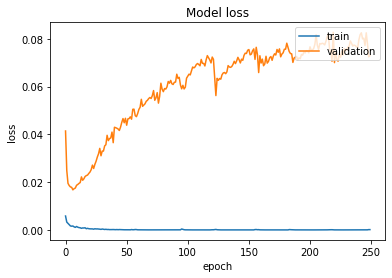

In [ ]:
optimizer_BRNN = torch.optim.Adam(model_BRNN.parameters(), lr=1e-3, weight_decay=1e-8) # L2 = weight_decay
model_run(model_BRNN, optimizer_BRNN)

## GRU

In [ ]:
'''
Class GRU

'''

class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
    super(GRU, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    self.embeddings = Embedding(input_size, hidden_size, word_embeddings)
    self.gru = nn.GRU(input_size = input_size,
                      hidden_size = hidden_size,
                      num_layers = num_layers,
                      batch_first=True,
                      dropout = 0,
                      bidirectional=False
                      )
    ## input_shape to nn.RNN-> (batch_size, seq_length, input_size) 
    self.dropout = nn.Dropout(dropout)
    self.activation = nn.Tanh()
    # The last layer to compute the probabilities for the output classes
    self.final_layer = nn.Linear(in_features=hidden_size, out_features=num_classes)
  

  def forward(self, x_idx):
    x = self.embeddings(x_idx)
    #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to("cuda")
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    if torch.cuda.is_available():
        h0 = h0.to("cuda")
    
    output, _ = self.gru(x.float(), h0)

    output = self.dropout(output)
    output = self.activation(output)
    logits = self.final_layer(output)
    return logits


In [ ]:
# We initialize our model
model_GRU = GRU(input_size = WORD_DIM,
            hidden_size = 128,
            num_layers = 1,
            num_classes = len(MAPPING_NER_LABELS),
            dropout = 0.3
            )

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:00, 67.46it/s]
Val: 8it [00:00, 121.52it/s]
Test: 59it [00:00, 116.67it/s]


Train loss: 1.0152
Val   loss: 0.6977
Test  loss: 0.6888

Val   Macro F1: 0.0528
Test  Macro F1: 0.0519

Best Epoch: 0, best val macro F1: 0.0528, test macro F1: 0.0519


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:00, 67.12it/s]
Val: 8it [00:00, 120.03it/s]
Test: 59it [00:00, 112.89it/s]


Train loss: 0.5888
Val   loss: 0.4935
Test  loss: 0.4759

Val   Macro F1: 0.2580
Test  Macro F1: 0.2628

Best Epoch: 1, best val macro F1: 0.2580, test macro F1: 0.2628


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:00, 67.20it/s]
Val: 8it [00:00, 118.56it/s]
Test: 59it [00:00, 112.86it/s]


Train loss: 0.4463
Val   loss: 0.4315
Test  loss: 0.3876

Val   Macro F1: 0.3108
Test  Macro F1: 0.3254

Best Epoch: 2, best val macro F1: 0.3108, test macro F1: 0.3254


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:00, 68.06it/s]
Val: 8it [00:00, 120.05it/s]
Test: 59it [00:00, 111.87it/s]


Train loss: 0.3766
Val   loss: 0.4023
Test  loss: 0.3347

Val   Macro F1: 0.3081
Test  Macro F1: 0.3324

Best Epoch: 2, best val macro F1: 0.3108, test macro F1: 0.3254


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:00, 68.14it/s]
Val: 8it [00:00, 110.87it/s]
Test: 59it [00:00, 112.99it/s]


Train loss: 0.3288
Val   loss: 0.3708
Test  loss: 0.2868

Val   Macro F1: 0.4295
Test  Macro F1: 0.4721

Best Epoch: 4, best val macro F1: 0.4295, test macro F1: 0.4721


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:00, 68.48it/s]
Val: 8it [00:00, 115.61it/s]
Test: 59it [00:00, 112.40it/s]


Train loss: 0.2916
Val   loss: 0.3593
Test  loss: 0.2547

Val   Macro F1: 0.4469
Test  Macro F1: 0.5095

Best Epoch: 5, best val macro F1: 0.4469, test macro F1: 0.5095


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:00, 68.23it/s]
Val: 8it [00:00, 119.50it/s]
Test: 59it [00:00, 111.80it/s]


Train loss: 0.2650
Val   loss: 0.3621
Test  loss: 0.2328

Val   Macro F1: 0.4457
Test  Macro F1: 0.5277

Best Epoch: 5, best val macro F1: 0.4469, test macro F1: 0.5095


------------------------------------------------------------------------
Epoch: 7


Training: 59it [00:00, 68.99it/s]
Val: 8it [00:00, 106.28it/s]
Test: 59it [00:00, 113.22it/s]


Train loss: 0.2435
Val   loss: 0.3611
Test  loss: 0.2127

Val   Macro F1: 0.4574
Test  Macro F1: 0.5532

Best Epoch: 7, best val macro F1: 0.4574, test macro F1: 0.5532


------------------------------------------------------------------------
Epoch: 8


Training: 59it [00:00, 68.11it/s]
Val: 8it [00:00, 120.08it/s]
Test: 59it [00:00, 113.49it/s]


Train loss: 0.2248
Val   loss: 0.3616
Test  loss: 0.1944

Val   Macro F1: 0.4652
Test  Macro F1: 0.5698

Best Epoch: 8, best val macro F1: 0.4652, test macro F1: 0.5698


------------------------------------------------------------------------
Epoch: 9


Training: 59it [00:00, 68.77it/s]
Val: 8it [00:00, 113.03it/s]
Test: 59it [00:00, 112.72it/s]


Train loss: 0.2097
Val   loss: 0.3663
Test  loss: 0.1822

Val   Macro F1: 0.4731
Test  Macro F1: 0.5846

Best Epoch: 9, best val macro F1: 0.4731, test macro F1: 0.5846


------------------------------------------------------------------------
Epoch: 10


Training: 59it [00:00, 68.62it/s]
Val: 8it [00:00, 111.60it/s]
Test: 59it [00:00, 110.62it/s]


Train loss: 0.1978
Val   loss: 0.3902
Test  loss: 0.1742

Val   Macro F1: 0.4640
Test  Macro F1: 0.5841

Best Epoch: 9, best val macro F1: 0.4731, test macro F1: 0.5846


------------------------------------------------------------------------
Epoch: 11


Training: 59it [00:00, 68.90it/s]
Val: 8it [00:00, 116.89it/s]
Test: 59it [00:00, 113.18it/s]


Train loss: 0.1863
Val   loss: 0.3897
Test  loss: 0.1611

Val   Macro F1: 0.4791
Test  Macro F1: 0.6033

Best Epoch: 11, best val macro F1: 0.4791, test macro F1: 0.6033


------------------------------------------------------------------------
Epoch: 12


Training: 59it [00:00, 67.78it/s]
Val: 8it [00:00, 117.69it/s]
Test: 59it [00:00, 111.94it/s]


Train loss: 0.1765
Val   loss: 0.4100
Test  loss: 0.1534

Val   Macro F1: 0.4750
Test  Macro F1: 0.6077

Best Epoch: 11, best val macro F1: 0.4791, test macro F1: 0.6033


------------------------------------------------------------------------
Epoch: 13


Training: 59it [00:00, 67.93it/s]
Val: 8it [00:00, 116.13it/s]
Test: 59it [00:00, 114.89it/s]


Train loss: 0.1675
Val   loss: 0.4083
Test  loss: 0.1433

Val   Macro F1: 0.4847
Test  Macro F1: 0.6173

Best Epoch: 13, best val macro F1: 0.4847, test macro F1: 0.6173


------------------------------------------------------------------------
Epoch: 14


Training: 59it [00:00, 68.29it/s]
Val: 8it [00:00, 120.45it/s]
Test: 59it [00:00, 111.21it/s]


Train loss: 0.1576
Val   loss: 0.4216
Test  loss: 0.1334

Val   Macro F1: 0.4808
Test  Macro F1: 0.6240

Best Epoch: 13, best val macro F1: 0.4847, test macro F1: 0.6173


------------------------------------------------------------------------
Epoch: 15


Training: 59it [00:00, 69.11it/s]
Val: 8it [00:00, 119.88it/s]
Test: 59it [00:00, 114.92it/s]


Train loss: 0.1503
Val   loss: 0.4221
Test  loss: 0.1276

Val   Macro F1: 0.4892
Test  Macro F1: 0.6342

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 16


Training: 59it [00:00, 68.95it/s]
Val: 8it [00:00, 113.36it/s]
Test: 59it [00:00, 113.67it/s]


Train loss: 0.1422
Val   loss: 0.4473
Test  loss: 0.1194

Val   Macro F1: 0.4829
Test  Macro F1: 0.6430

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 17


Training: 59it [00:00, 68.51it/s]
Val: 8it [00:00, 117.81it/s]
Test: 59it [00:00, 115.52it/s]


Train loss: 0.1353
Val   loss: 0.4636
Test  loss: 0.1133

Val   Macro F1: 0.4784
Test  Macro F1: 0.6474

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 18


Training: 59it [00:00, 68.77it/s]
Val: 8it [00:00, 117.97it/s]
Test: 59it [00:00, 109.70it/s]


Train loss: 0.1284
Val   loss: 0.4776
Test  loss: 0.1075

Val   Macro F1: 0.4811
Test  Macro F1: 0.6598

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 19


Training: 59it [00:00, 67.62it/s]
Val: 8it [00:00, 114.38it/s]
Test: 59it [00:00, 111.84it/s]


Train loss: 0.1220
Val   loss: 0.4844
Test  loss: 0.1008

Val   Macro F1: 0.4787
Test  Macro F1: 0.6660

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 20


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 115.06it/s]
Test: 59it [00:00, 113.41it/s]


Train loss: 0.1160
Val   loss: 0.5177
Test  loss: 0.0946

Val   Macro F1: 0.4725
Test  Macro F1: 0.6708

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 21


Training: 59it [00:00, 68.44it/s]
Val: 8it [00:00, 107.57it/s]
Test: 59it [00:00, 113.73it/s]


Train loss: 0.1108
Val   loss: 0.5173
Test  loss: 0.0905

Val   Macro F1: 0.4750
Test  Macro F1: 0.6801

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 22


Training: 59it [00:00, 68.26it/s]
Val: 8it [00:00, 111.58it/s]
Test: 59it [00:00, 112.12it/s]


Train loss: 0.1049
Val   loss: 0.5792
Test  loss: 0.0969

Val   Macro F1: 0.4533
Test  Macro F1: 0.6689

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 23


Training: 59it [00:00, 68.60it/s]
Val: 8it [00:00, 114.25it/s]
Test: 59it [00:00, 112.49it/s]


Train loss: 0.1026
Val   loss: 0.5468
Test  loss: 0.0819

Val   Macro F1: 0.4731
Test  Macro F1: 0.6946

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 24


Training: 59it [00:00, 68.40it/s]
Val: 8it [00:00, 113.43it/s]
Test: 59it [00:00, 113.05it/s]


Train loss: 0.0955
Val   loss: 0.5831
Test  loss: 0.0783

Val   Macro F1: 0.4629
Test  Macro F1: 0.6892

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 25


Training: 59it [00:00, 68.14it/s]
Val: 8it [00:00, 122.10it/s]
Test: 59it [00:00, 113.05it/s]


Train loss: 0.0901
Val   loss: 0.5950
Test  loss: 0.0734

Val   Macro F1: 0.4648
Test  Macro F1: 0.7059

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 26


Training: 59it [00:00, 68.03it/s]
Val: 8it [00:00, 117.21it/s]
Test: 59it [00:00, 106.04it/s]


Train loss: 0.0857
Val   loss: 0.6264
Test  loss: 0.0699

Val   Macro F1: 0.4607
Test  Macro F1: 0.7018

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 27


Training: 59it [00:00, 67.82it/s]
Val: 8it [00:00, 112.06it/s]
Test: 59it [00:00, 111.19it/s]


Train loss: 0.0818
Val   loss: 0.6366
Test  loss: 0.0662

Val   Macro F1: 0.4520
Test  Macro F1: 0.7027

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 28


Training: 59it [00:00, 68.36it/s]
Val: 8it [00:00, 124.47it/s]
Test: 59it [00:00, 110.67it/s]


Train loss: 0.0784
Val   loss: 0.6488
Test  loss: 0.0630

Val   Macro F1: 0.4481
Test  Macro F1: 0.7177

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 29


Training: 59it [00:00, 67.63it/s]
Val: 8it [00:00, 120.48it/s]
Test: 59it [00:00, 112.92it/s]


Train loss: 0.0753
Val   loss: 0.6643
Test  loss: 0.0599

Val   Macro F1: 0.4478
Test  Macro F1: 0.7203

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 30


Training: 59it [00:00, 68.61it/s]
Val: 8it [00:00, 107.13it/s]
Test: 59it [00:00, 112.23it/s]


Train loss: 0.0726
Val   loss: 0.6777
Test  loss: 0.0561

Val   Macro F1: 0.4359
Test  Macro F1: 0.7128

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 31


Training: 59it [00:00, 67.94it/s]
Val: 8it [00:00, 113.45it/s]
Test: 59it [00:00, 113.30it/s]


Train loss: 0.0690
Val   loss: 0.7191
Test  loss: 0.0570

Val   Macro F1: 0.4326
Test  Macro F1: 0.7206

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 32


Training: 59it [00:00, 68.59it/s]
Val: 8it [00:00, 116.47it/s]
Test: 59it [00:00, 114.71it/s]


Train loss: 0.0668
Val   loss: 0.7013
Test  loss: 0.0516

Val   Macro F1: 0.4397
Test  Macro F1: 0.7243

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 33


Training: 59it [00:00, 68.59it/s]
Val: 8it [00:00, 114.57it/s]
Test: 59it [00:00, 111.55it/s]


Train loss: 0.0643
Val   loss: 0.7245
Test  loss: 0.0504

Val   Macro F1: 0.4383
Test  Macro F1: 0.7309

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 34


Training: 59it [00:00, 68.35it/s]
Val: 8it [00:00, 119.93it/s]
Test: 59it [00:00, 112.48it/s]


Train loss: 0.0613
Val   loss: 0.7619
Test  loss: 0.0487

Val   Macro F1: 0.4383
Test  Macro F1: 0.7335

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 35


Training: 59it [00:00, 67.82it/s]
Val: 8it [00:00, 110.79it/s]
Test: 59it [00:00, 110.71it/s]


Train loss: 0.0576
Val   loss: 0.7612
Test  loss: 0.0442

Val   Macro F1: 0.4353
Test  Macro F1: 0.7402

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 36


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 107.87it/s]
Test: 59it [00:00, 109.43it/s]


Train loss: 0.0549
Val   loss: 0.7735
Test  loss: 0.0413

Val   Macro F1: 0.4369
Test  Macro F1: 0.7420

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 37


Training: 59it [00:00, 68.65it/s]
Val: 8it [00:00, 116.42it/s]
Test: 59it [00:00, 109.39it/s]


Train loss: 0.0525
Val   loss: 0.7937
Test  loss: 0.0405

Val   Macro F1: 0.4336
Test  Macro F1: 0.7462

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 38


Training: 59it [00:00, 68.38it/s]
Val: 8it [00:00, 118.39it/s]
Test: 59it [00:00, 112.04it/s]


Train loss: 0.0511
Val   loss: 0.7941
Test  loss: 0.0404

Val   Macro F1: 0.4339
Test  Macro F1: 0.7418

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 39


Training: 59it [00:00, 68.62it/s]
Val: 8it [00:00, 115.89it/s]
Test: 59it [00:00, 110.89it/s]


Train loss: 0.0494
Val   loss: 0.8237
Test  loss: 0.0373

Val   Macro F1: 0.4370
Test  Macro F1: 0.7488

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 40


Training: 59it [00:00, 68.82it/s]
Val: 8it [00:00, 119.95it/s]
Test: 59it [00:00, 110.89it/s]


Train loss: 0.0472
Val   loss: 0.8214
Test  loss: 0.0356

Val   Macro F1: 0.4353
Test  Macro F1: 0.7519

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 41


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 117.92it/s]
Test: 59it [00:00, 113.79it/s]


Train loss: 0.0454
Val   loss: 0.8236
Test  loss: 0.0347

Val   Macro F1: 0.4377
Test  Macro F1: 0.7539

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 42


Training: 59it [00:00, 68.40it/s]
Val: 8it [00:00, 111.68it/s]
Test: 59it [00:00, 110.86it/s]


Train loss: 0.0466
Val   loss: 0.8350
Test  loss: 0.0362

Val   Macro F1: 0.4294
Test  Macro F1: 0.7553

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 43


Training: 59it [00:00, 67.80it/s]
Val: 8it [00:00, 117.47it/s]
Test: 59it [00:00, 114.20it/s]


Train loss: 0.0442
Val   loss: 0.9225
Test  loss: 0.0352

Val   Macro F1: 0.4249
Test  Macro F1: 0.7527

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 44


Training: 59it [00:00, 67.04it/s]
Val: 8it [00:00, 119.38it/s]
Test: 59it [00:00, 111.91it/s]


Train loss: 0.0425
Val   loss: 0.8993
Test  loss: 0.0303

Val   Macro F1: 0.4274
Test  Macro F1: 0.7561

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 45


Training: 59it [00:00, 68.07it/s]
Val: 8it [00:00, 121.85it/s]
Test: 59it [00:00, 112.22it/s]


Train loss: 0.0405
Val   loss: 0.8943
Test  loss: 0.0286

Val   Macro F1: 0.4270
Test  Macro F1: 0.7569

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 46


Training: 59it [00:00, 68.67it/s]
Val: 8it [00:00, 115.05it/s]
Test: 59it [00:00, 112.23it/s]


Train loss: 0.0367
Val   loss: 0.9068
Test  loss: 0.0266

Val   Macro F1: 0.4280
Test  Macro F1: 0.7631

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 47


Training: 59it [00:00, 68.21it/s]
Val: 8it [00:00, 116.58it/s]
Test: 59it [00:00, 113.04it/s]


Train loss: 0.0350
Val   loss: 0.9263
Test  loss: 0.0256

Val   Macro F1: 0.4293
Test  Macro F1: 0.7695

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 48


Training: 59it [00:00, 67.71it/s]
Val: 8it [00:00, 114.96it/s]
Test: 59it [00:00, 110.86it/s]


Train loss: 0.0339
Val   loss: 0.9645
Test  loss: 0.0255

Val   Macro F1: 0.4219
Test  Macro F1: 0.7680

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 49


Training: 59it [00:00, 68.10it/s]
Val: 8it [00:00, 119.99it/s]
Test: 59it [00:00, 112.98it/s]


Train loss: 0.0330
Val   loss: 0.9746
Test  loss: 0.0244

Val   Macro F1: 0.4141
Test  Macro F1: 0.7679

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 50


Training: 59it [00:00, 68.13it/s]
Val: 8it [00:00, 122.56it/s]
Test: 59it [00:00, 111.99it/s]


Train loss: 0.0325
Val   loss: 0.9632
Test  loss: 0.0232

Val   Macro F1: 0.4199
Test  Macro F1: 0.7680

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 51


Training: 59it [00:00, 68.35it/s]
Val: 8it [00:00, 117.43it/s]
Test: 59it [00:00, 111.91it/s]


Train loss: 0.0318
Val   loss: 0.9860
Test  loss: 0.0223

Val   Macro F1: 0.4228
Test  Macro F1: 0.7718

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 52


Training: 59it [00:00, 68.67it/s]
Val: 8it [00:00, 115.06it/s]
Test: 59it [00:00, 113.50it/s]


Train loss: 0.0317
Val   loss: 1.0375
Test  loss: 0.0247

Val   Macro F1: 0.4139
Test  Macro F1: 0.7698

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 53


Training: 59it [00:00, 67.92it/s]
Val: 8it [00:00, 112.46it/s]
Test: 59it [00:00, 111.31it/s]


Train loss: 0.0309
Val   loss: 1.0026
Test  loss: 0.0231

Val   Macro F1: 0.4194
Test  Macro F1: 0.7705

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 54


Training: 59it [00:00, 68.62it/s]
Val: 8it [00:00, 114.98it/s]
Test: 59it [00:00, 114.24it/s]


Train loss: 0.0296
Val   loss: 1.0204
Test  loss: 0.0220

Val   Macro F1: 0.4200
Test  Macro F1: 0.7718

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 55


Training: 59it [00:00, 68.29it/s]
Val: 8it [00:00, 119.39it/s]
Test: 59it [00:00, 113.09it/s]


Train loss: 0.0297
Val   loss: 1.0201
Test  loss: 0.0208

Val   Macro F1: 0.4205
Test  Macro F1: 0.7755

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 56


Training: 59it [00:00, 67.76it/s]
Val: 8it [00:00, 116.46it/s]
Test: 59it [00:00, 110.69it/s]


Train loss: 0.0280
Val   loss: 1.0614
Test  loss: 0.0196

Val   Macro F1: 0.4232
Test  Macro F1: 0.7767

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 57


Training: 59it [00:00, 68.16it/s]
Val: 8it [00:00, 121.33it/s]
Test: 59it [00:00, 111.04it/s]


Train loss: 0.0287
Val   loss: 1.1503
Test  loss: 0.0311

Val   Macro F1: 0.3961
Test  Macro F1: 0.7561

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 58


Training: 59it [00:00, 68.06it/s]
Val: 8it [00:00, 119.25it/s]
Test: 59it [00:00, 113.94it/s]


Train loss: 0.0319
Val   loss: 1.0126
Test  loss: 0.0252

Val   Macro F1: 0.4405
Test  Macro F1: 0.7794

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 59


Training: 59it [00:00, 68.38it/s]
Val: 8it [00:00, 117.30it/s]
Test: 59it [00:00, 112.66it/s]


Train loss: 0.0297
Val   loss: 1.0384
Test  loss: 0.0217

Val   Macro F1: 0.4213
Test  Macro F1: 0.7739

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 60


Training: 59it [00:00, 68.15it/s]
Val: 8it [00:00, 119.70it/s]
Test: 59it [00:00, 113.84it/s]


Train loss: 0.0278
Val   loss: 1.0867
Test  loss: 0.0183

Val   Macro F1: 0.4187
Test  Macro F1: 0.7770

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 61


Training: 59it [00:00, 68.14it/s]
Val: 8it [00:00, 112.50it/s]
Test: 59it [00:00, 107.23it/s]


Train loss: 0.0259
Val   loss: 1.0622
Test  loss: 0.0182

Val   Macro F1: 0.4206
Test  Macro F1: 0.7816

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 62


Training: 59it [00:00, 68.08it/s]
Val: 8it [00:00, 115.76it/s]
Test: 59it [00:00, 114.14it/s]


Train loss: 0.0241
Val   loss: 1.0681
Test  loss: 0.0172

Val   Macro F1: 0.4240
Test  Macro F1: 0.7810

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 63


Training: 59it [00:00, 67.64it/s]
Val: 8it [00:00, 113.30it/s]
Test: 59it [00:00, 109.76it/s]


Train loss: 0.0227
Val   loss: 1.1148
Test  loss: 0.0153

Val   Macro F1: 0.4164
Test  Macro F1: 0.7845

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 64


Training: 59it [00:00, 68.32it/s]
Val: 8it [00:00, 101.81it/s]
Test: 59it [00:00, 115.36it/s]


Train loss: 0.0219
Val   loss: 1.1322
Test  loss: 0.0145

Val   Macro F1: 0.4084
Test  Macro F1: 0.7848

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 65


Training: 59it [00:00, 68.31it/s]
Val: 8it [00:00, 113.07it/s]
Test: 59it [00:00, 110.80it/s]


Train loss: 0.0212
Val   loss: 1.1313
Test  loss: 0.0147

Val   Macro F1: 0.4119
Test  Macro F1: 0.7843

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 66


Training: 59it [00:00, 68.06it/s]
Val: 8it [00:00, 113.90it/s]
Test: 59it [00:00, 111.57it/s]


Train loss: 0.0208
Val   loss: 1.1653
Test  loss: 0.0146

Val   Macro F1: 0.4102
Test  Macro F1: 0.7843

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 67


Training: 59it [00:00, 68.11it/s]
Val: 8it [00:00, 118.41it/s]
Test: 59it [00:00, 113.33it/s]


Train loss: 0.0203
Val   loss: 1.1788
Test  loss: 0.0138

Val   Macro F1: 0.4087
Test  Macro F1: 0.7852

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 68


Training: 59it [00:00, 68.44it/s]
Val: 8it [00:00, 125.05it/s]
Test: 59it [00:00, 113.19it/s]


Train loss: 0.0211
Val   loss: 1.1715
Test  loss: 0.0165

Val   Macro F1: 0.4168
Test  Macro F1: 0.7801

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 69


Training: 59it [00:00, 67.99it/s]
Val: 8it [00:00, 118.93it/s]
Test: 59it [00:00, 112.99it/s]


Train loss: 0.0219
Val   loss: 1.1730
Test  loss: 0.0147

Val   Macro F1: 0.4085
Test  Macro F1: 0.7841

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 70


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 116.08it/s]
Test: 59it [00:00, 111.08it/s]


Train loss: 0.0201
Val   loss: 1.2091
Test  loss: 0.0138

Val   Macro F1: 0.4082
Test  Macro F1: 0.7865

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 71


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 116.08it/s]
Test: 59it [00:00, 109.70it/s]


Train loss: 0.0191
Val   loss: 1.1858
Test  loss: 0.0143

Val   Macro F1: 0.4140
Test  Macro F1: 0.7812

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 72


Training: 59it [00:00, 68.34it/s]
Val: 8it [00:00, 110.59it/s]
Test: 59it [00:00, 112.30it/s]


Train loss: 0.0202
Val   loss: 1.2429
Test  loss: 0.0134

Val   Macro F1: 0.4036
Test  Macro F1: 0.7872

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 73


Training: 59it [00:00, 68.53it/s]
Val: 8it [00:00, 109.00it/s]
Test: 59it [00:00, 113.39it/s]


Train loss: 0.0215
Val   loss: 1.2291
Test  loss: 0.0144

Val   Macro F1: 0.4028
Test  Macro F1: 0.7816

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 74


Training: 59it [00:00, 68.13it/s]
Val: 8it [00:00, 112.69it/s]
Test: 59it [00:00, 113.87it/s]


Train loss: 0.0234
Val   loss: 1.2472
Test  loss: 0.0185

Val   Macro F1: 0.3969
Test  Macro F1: 0.7780

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 75


Training: 59it [00:00, 67.63it/s]
Val: 8it [00:00, 120.54it/s]
Test: 59it [00:00, 111.30it/s]


Train loss: 0.0228
Val   loss: 1.2423
Test  loss: 0.0172

Val   Macro F1: 0.4055
Test  Macro F1: 0.7821

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 76


Training: 59it [00:00, 67.84it/s]
Val: 8it [00:00, 113.11it/s]
Test: 59it [00:00, 111.32it/s]


Train loss: 0.0218
Val   loss: 1.2065
Test  loss: 0.0134

Val   Macro F1: 0.4034
Test  Macro F1: 0.7768

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 77


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 115.80it/s]
Test: 59it [00:00, 113.15it/s]


Train loss: 0.0198
Val   loss: 1.2374
Test  loss: 0.0132

Val   Macro F1: 0.4018
Test  Macro F1: 0.7827

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 78


Training: 59it [00:00, 68.80it/s]
Val: 8it [00:00, 113.17it/s]
Test: 59it [00:00, 112.73it/s]


Train loss: 0.0189
Val   loss: 1.2289
Test  loss: 0.0124

Val   Macro F1: 0.4053
Test  Macro F1: 0.7852

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 79


Training: 59it [00:00, 68.60it/s]
Val: 8it [00:00, 111.25it/s]
Test: 59it [00:00, 112.73it/s]


Train loss: 0.0188
Val   loss: 1.2588
Test  loss: 0.0117

Val   Macro F1: 0.4054
Test  Macro F1: 0.7898

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 80


Training: 59it [00:00, 67.46it/s]
Val: 8it [00:00, 113.11it/s]
Test: 59it [00:00, 113.32it/s]


Train loss: 0.0180
Val   loss: 1.2372
Test  loss: 0.0116

Val   Macro F1: 0.4062
Test  Macro F1: 0.7884

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 81


Training: 59it [00:00, 68.48it/s]
Val: 8it [00:00, 111.58it/s]
Test: 59it [00:00, 112.54it/s]


Train loss: 0.0169
Val   loss: 1.2995
Test  loss: 0.0108

Val   Macro F1: 0.3970
Test  Macro F1: 0.7883

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 82


Training: 59it [00:00, 67.94it/s]
Val: 8it [00:00, 116.51it/s]
Test: 59it [00:00, 110.55it/s]


Train loss: 0.0163
Val   loss: 1.2952
Test  loss: 0.0116

Val   Macro F1: 0.3945
Test  Macro F1: 0.7881

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 83


Training: 59it [00:00, 68.00it/s]
Val: 8it [00:00, 115.28it/s]
Test: 59it [00:00, 112.48it/s]


Train loss: 0.0160
Val   loss: 1.2983
Test  loss: 0.0107

Val   Macro F1: 0.4039
Test  Macro F1: 0.7895

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 84


Training: 59it [00:00, 68.27it/s]
Val: 8it [00:00, 113.27it/s]
Test: 59it [00:00, 113.12it/s]


Train loss: 0.0174
Val   loss: 1.3055
Test  loss: 0.0110

Val   Macro F1: 0.4010
Test  Macro F1: 0.7915

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 85


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 122.91it/s]
Test: 59it [00:00, 113.25it/s]


Train loss: 0.0260
Val   loss: 1.3058
Test  loss: 0.0172

Val   Macro F1: 0.4006
Test  Macro F1: 0.7868

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 86


Training: 59it [00:00, 68.37it/s]
Val: 8it [00:00, 115.84it/s]
Test: 59it [00:00, 111.04it/s]


Train loss: 0.0223
Val   loss: 1.2397
Test  loss: 0.0147

Val   Macro F1: 0.4029
Test  Macro F1: 0.7847

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 87


Training: 59it [00:00, 67.84it/s]
Val: 8it [00:00, 109.89it/s]
Test: 59it [00:00, 112.02it/s]


Train loss: 0.0196
Val   loss: 1.2841
Test  loss: 0.0125

Val   Macro F1: 0.4056
Test  Macro F1: 0.7899

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 88


Training: 59it [00:00, 68.02it/s]
Val: 8it [00:00, 123.81it/s]
Test: 59it [00:00, 113.93it/s]


Train loss: 0.0175
Val   loss: 1.2716
Test  loss: 0.0105

Val   Macro F1: 0.3972
Test  Macro F1: 0.7922

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 89


Training: 59it [00:00, 67.66it/s]
Val: 8it [00:00, 118.26it/s]
Test: 59it [00:00, 111.79it/s]


Train loss: 0.0153
Val   loss: 1.2740
Test  loss: 0.0095

Val   Macro F1: 0.4052
Test  Macro F1: 0.7933

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 90


Training: 59it [00:00, 67.77it/s]
Val: 8it [00:00, 112.79it/s]
Test: 59it [00:00, 112.40it/s]


Train loss: 0.0150
Val   loss: 1.3370
Test  loss: 0.0101

Val   Macro F1: 0.3941
Test  Macro F1: 0.7897

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 91


Training: 59it [00:00, 67.37it/s]
Val: 8it [00:00, 115.33it/s]
Test: 59it [00:00, 109.68it/s]


Train loss: 0.0142
Val   loss: 1.3124
Test  loss: 0.0087

Val   Macro F1: 0.4053
Test  Macro F1: 0.7925

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 92


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 115.91it/s]
Test: 59it [00:00, 111.38it/s]


Train loss: 0.0139
Val   loss: 1.3228
Test  loss: 0.0089

Val   Macro F1: 0.4012
Test  Macro F1: 0.7908

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 93


Training: 59it [00:00, 67.83it/s]
Val: 8it [00:00, 116.07it/s]
Test: 59it [00:00, 110.15it/s]


Train loss: 0.0131
Val   loss: 1.3540
Test  loss: 0.0086

Val   Macro F1: 0.3960
Test  Macro F1: 0.7917

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 94


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 111.19it/s]
Test: 59it [00:00, 112.62it/s]


Train loss: 0.0130
Val   loss: 1.3656
Test  loss: 0.0083

Val   Macro F1: 0.3963
Test  Macro F1: 0.7964

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 95


Training: 59it [00:00, 67.75it/s]
Val: 8it [00:00, 109.06it/s]
Test: 59it [00:00, 111.03it/s]


Train loss: 0.0128
Val   loss: 1.3637
Test  loss: 0.0083

Val   Macro F1: 0.3961
Test  Macro F1: 0.7953

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 96


Training: 59it [00:00, 68.09it/s]
Val: 8it [00:00, 107.60it/s]
Test: 59it [00:00, 113.90it/s]


Train loss: 0.0125
Val   loss: 1.3966
Test  loss: 0.0083

Val   Macro F1: 0.3922
Test  Macro F1: 0.7958

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 97


Training: 59it [00:00, 67.99it/s]
Val: 8it [00:00, 108.54it/s]
Test: 59it [00:00, 108.72it/s]


Train loss: 0.0127
Val   loss: 1.4157
Test  loss: 0.0088

Val   Macro F1: 0.3911
Test  Macro F1: 0.7971

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 98


Training: 59it [00:00, 67.93it/s]
Val: 8it [00:00, 109.62it/s]
Test: 59it [00:00, 112.62it/s]


Train loss: 0.0131
Val   loss: 1.3720
Test  loss: 0.0087

Val   Macro F1: 0.3945
Test  Macro F1: 0.7943

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 99


Training: 59it [00:00, 67.69it/s]
Val: 8it [00:00, 119.11it/s]
Test: 59it [00:00, 112.16it/s]


Train loss: 0.0136
Val   loss: 1.3841
Test  loss: 0.0089

Val   Macro F1: 0.3980
Test  Macro F1: 0.7963

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 100


Training: 59it [00:00, 68.52it/s]
Val: 8it [00:00, 112.34it/s]
Test: 59it [00:00, 112.08it/s]


Train loss: 0.0141
Val   loss: 1.3827
Test  loss: 0.0092

Val   Macro F1: 0.3980
Test  Macro F1: 0.7949

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 101


Training: 59it [00:00, 68.92it/s]
Val: 8it [00:00, 116.24it/s]
Test: 59it [00:00, 113.08it/s]


Train loss: 0.0148
Val   loss: 1.4142
Test  loss: 0.0111

Val   Macro F1: 0.3981
Test  Macro F1: 0.7987

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 102


Training: 59it [00:00, 68.04it/s]
Val: 8it [00:00, 122.18it/s]
Test: 59it [00:00, 107.36it/s]


Train loss: 0.0172
Val   loss: 1.4364
Test  loss: 0.0119

Val   Macro F1: 0.3937
Test  Macro F1: 0.7911

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 103


Training: 59it [00:00, 67.67it/s]
Val: 8it [00:00, 124.53it/s]
Test: 59it [00:00, 113.33it/s]


Train loss: 0.0278
Val   loss: 1.3338
Test  loss: 0.0192

Val   Macro F1: 0.3958
Test  Macro F1: 0.7830

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 104


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 112.68it/s]
Test: 59it [00:00, 113.16it/s]


Train loss: 0.0269
Val   loss: 1.2744
Test  loss: 0.0171

Val   Macro F1: 0.4089
Test  Macro F1: 0.7867

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 105


Training: 59it [00:00, 68.20it/s]
Val: 8it [00:00, 119.40it/s]
Test: 59it [00:00, 113.66it/s]


Train loss: 0.0213
Val   loss: 1.3379
Test  loss: 0.0107

Val   Macro F1: 0.3932
Test  Macro F1: 0.7976

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 106


Training: 59it [00:00, 68.30it/s]
Val: 8it [00:00, 115.10it/s]
Test: 59it [00:00, 113.05it/s]


Train loss: 0.0169
Val   loss: 1.2887
Test  loss: 0.0102

Val   Macro F1: 0.4025
Test  Macro F1: 0.7928

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 107


Training: 59it [00:00, 68.13it/s]
Val: 8it [00:00, 117.43it/s]
Test: 59it [00:00, 112.34it/s]


Train loss: 0.0147
Val   loss: 1.3271
Test  loss: 0.0082

Val   Macro F1: 0.3994
Test  Macro F1: 0.7961

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 108


Training: 59it [00:00, 68.04it/s]
Val: 8it [00:00, 114.89it/s]
Test: 59it [00:00, 112.72it/s]


Train loss: 0.0128
Val   loss: 1.3612
Test  loss: 0.0077

Val   Macro F1: 0.3936
Test  Macro F1: 0.7947

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 109


Training: 59it [00:00, 67.94it/s]
Val: 8it [00:00, 117.42it/s]
Test: 59it [00:00, 113.17it/s]


Train loss: 0.0116
Val   loss: 1.3610
Test  loss: 0.0074

Val   Macro F1: 0.3996
Test  Macro F1: 0.7967

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 110


Training: 59it [00:00, 68.67it/s]
Val: 8it [00:00, 114.53it/s]
Test: 59it [00:00, 113.14it/s]


Train loss: 0.0114
Val   loss: 1.3873
Test  loss: 0.0072

Val   Macro F1: 0.3944
Test  Macro F1: 0.7971

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 111


Training: 59it [00:00, 68.09it/s]
Val: 8it [00:00, 106.95it/s]
Test: 59it [00:00, 114.09it/s]


Train loss: 0.0112
Val   loss: 1.4030
Test  loss: 0.0072

Val   Macro F1: 0.3975
Test  Macro F1: 0.7984

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 112


Training: 59it [00:00, 68.14it/s]
Val: 8it [00:00, 116.69it/s]
Test: 59it [00:00, 113.32it/s]


Train loss: 0.0111
Val   loss: 1.4176
Test  loss: 0.0071

Val   Macro F1: 0.3946
Test  Macro F1: 0.7968

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 113


Training: 59it [00:00, 68.97it/s]
Val: 8it [00:00, 110.67it/s]
Test: 59it [00:00, 113.91it/s]


Train loss: 0.0111
Val   loss: 1.4312
Test  loss: 0.0070

Val   Macro F1: 0.3976
Test  Macro F1: 0.8012

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 114


Training: 59it [00:00, 67.73it/s]
Val: 8it [00:00, 116.39it/s]
Test: 59it [00:00, 112.03it/s]


Train loss: 0.0108
Val   loss: 1.4340
Test  loss: 0.0071

Val   Macro F1: 0.3954
Test  Macro F1: 0.7978

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 115


Training: 59it [00:00, 67.34it/s]
Val: 8it [00:00, 113.06it/s]
Test: 59it [00:00, 110.87it/s]


Train loss: 0.0109
Val   loss: 1.4306
Test  loss: 0.0070

Val   Macro F1: 0.3988
Test  Macro F1: 0.8006

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 116


Training: 59it [00:00, 67.70it/s]
Val: 8it [00:00, 121.18it/s]
Test: 59it [00:00, 112.41it/s]


Train loss: 0.0107
Val   loss: 1.4135
Test  loss: 0.0069

Val   Macro F1: 0.3983
Test  Macro F1: 0.7966

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 117


Training: 59it [00:00, 68.71it/s]
Val: 8it [00:00, 119.93it/s]
Test: 59it [00:00, 109.83it/s]


Train loss: 0.0108
Val   loss: 1.4441
Test  loss: 0.0069

Val   Macro F1: 0.3930
Test  Macro F1: 0.8046

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 118


Training: 59it [00:00, 67.99it/s]
Val: 8it [00:00, 115.04it/s]
Test: 59it [00:00, 113.78it/s]


Train loss: 0.0107
Val   loss: 1.4544
Test  loss: 0.0069

Val   Macro F1: 0.3993
Test  Macro F1: 0.8017

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 119


Training: 59it [00:00, 68.75it/s]
Val: 8it [00:00, 118.90it/s]
Test: 59it [00:00, 112.30it/s]


Train loss: 0.0104
Val   loss: 1.4246
Test  loss: 0.0069

Val   Macro F1: 0.3979
Test  Macro F1: 0.7965

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 120


Training: 59it [00:00, 68.00it/s]
Val: 8it [00:00, 113.51it/s]
Test: 59it [00:00, 112.53it/s]


Train loss: 0.0106
Val   loss: 1.4868
Test  loss: 0.0070

Val   Macro F1: 0.3911
Test  Macro F1: 0.8008

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 121


Training: 59it [00:00, 67.37it/s]
Val: 8it [00:00, 117.56it/s]
Test: 59it [00:00, 112.44it/s]


Train loss: 0.0106
Val   loss: 1.4546
Test  loss: 0.0067

Val   Macro F1: 0.3890
Test  Macro F1: 0.7973

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 122


Training: 59it [00:00, 68.26it/s]
Val: 8it [00:00, 118.69it/s]
Test: 59it [00:00, 109.83it/s]


Train loss: 0.0105
Val   loss: 1.4922
Test  loss: 0.0067

Val   Macro F1: 0.3873
Test  Macro F1: 0.7988

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 123


Training: 59it [00:00, 67.80it/s]
Val: 8it [00:00, 121.23it/s]
Test: 59it [00:00, 112.39it/s]


Train loss: 0.0101
Val   loss: 1.4673
Test  loss: 0.0068

Val   Macro F1: 0.3944
Test  Macro F1: 0.8010

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 124


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 110.00it/s]
Test: 59it [00:00, 113.77it/s]


Train loss: 0.0106
Val   loss: 1.5095
Test  loss: 0.0070

Val   Macro F1: 0.3890
Test  Macro F1: 0.8028

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 125


Training: 59it [00:00, 67.92it/s]
Val: 8it [00:00, 113.46it/s]
Test: 59it [00:00, 112.39it/s]


Train loss: 0.0108
Val   loss: 1.4853
Test  loss: 0.0070

Val   Macro F1: 0.3962
Test  Macro F1: 0.8026

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 126


Training: 59it [00:00, 69.19it/s]
Val: 8it [00:00, 117.98it/s]
Test: 59it [00:00, 112.33it/s]


Train loss: 0.0110
Val   loss: 1.5053
Test  loss: 0.0081

Val   Macro F1: 0.3943
Test  Macro F1: 0.8056

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 127


Training: 59it [00:00, 68.21it/s]
Val: 8it [00:00, 116.47it/s]
Test: 59it [00:00, 111.36it/s]


Train loss: 0.0121
Val   loss: 1.4860
Test  loss: 0.0076

Val   Macro F1: 0.3901
Test  Macro F1: 0.8009

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 128


Training: 59it [00:00, 67.81it/s]
Val: 8it [00:00, 111.11it/s]
Test: 59it [00:00, 114.14it/s]


Train loss: 0.0129
Val   loss: 1.4518
Test  loss: 0.0085

Val   Macro F1: 0.3964
Test  Macro F1: 0.7932

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 129


Training: 59it [00:00, 68.09it/s]
Val: 8it [00:00, 119.89it/s]
Test: 59it [00:00, 109.78it/s]


Train loss: 0.0242
Val   loss: 1.4365
Test  loss: 0.0283

Val   Macro F1: 0.3985
Test  Macro F1: 0.7770

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 130


Training: 59it [00:00, 68.49it/s]
Val: 8it [00:00, 113.59it/s]
Test: 59it [00:00, 112.02it/s]


Train loss: 0.0289
Val   loss: 1.3765
Test  loss: 0.0159

Val   Macro F1: 0.3964
Test  Macro F1: 0.7900

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 131


Training: 59it [00:00, 68.83it/s]
Val: 8it [00:00, 110.88it/s]
Test: 59it [00:00, 113.58it/s]


Train loss: 0.0237
Val   loss: 1.3528
Test  loss: 0.0115

Val   Macro F1: 0.3987
Test  Macro F1: 0.7918

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 132


Training: 59it [00:00, 68.68it/s]
Val: 8it [00:00, 116.43it/s]
Test: 59it [00:00, 113.16it/s]


Train loss: 0.0180
Val   loss: 1.3651
Test  loss: 0.0094

Val   Macro F1: 0.3964
Test  Macro F1: 0.7980

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 133


Training: 59it [00:00, 68.75it/s]
Val: 8it [00:00, 116.94it/s]
Test: 59it [00:00, 112.91it/s]


Train loss: 0.0134
Val   loss: 1.3577
Test  loss: 0.0077

Val   Macro F1: 0.4022
Test  Macro F1: 0.8023

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 134


Training: 59it [00:00, 67.21it/s]
Val: 8it [00:00, 113.88it/s]
Test: 59it [00:00, 111.86it/s]


Train loss: 0.0118
Val   loss: 1.4075
Test  loss: 0.0070

Val   Macro F1: 0.3954
Test  Macro F1: 0.8050

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 135


Training: 59it [00:00, 68.54it/s]
Val: 8it [00:00, 118.62it/s]
Test: 59it [00:00, 112.75it/s]


Train loss: 0.0105
Val   loss: 1.3942
Test  loss: 0.0065

Val   Macro F1: 0.3967
Test  Macro F1: 0.7987

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 136


Training: 59it [00:00, 67.65it/s]
Val: 8it [00:00, 120.11it/s]
Test: 59it [00:00, 113.13it/s]


Train loss: 0.0101
Val   loss: 1.4441
Test  loss: 0.0065

Val   Macro F1: 0.3881
Test  Macro F1: 0.8012

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 137


Training: 59it [00:00, 68.01it/s]
Val: 8it [00:00, 114.87it/s]
Test: 59it [00:00, 112.10it/s]


Train loss: 0.0098
Val   loss: 1.4386
Test  loss: 0.0063

Val   Macro F1: 0.3945
Test  Macro F1: 0.8024

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 138


Training: 59it [00:00, 67.72it/s]
Val: 8it [00:00, 112.22it/s]
Test: 59it [00:00, 111.63it/s]


Train loss: 0.0094
Val   loss: 1.4303
Test  loss: 0.0062

Val   Macro F1: 0.3951
Test  Macro F1: 0.7993

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 139


Training: 59it [00:00, 67.81it/s]
Val: 8it [00:00, 116.28it/s]
Test: 59it [00:00, 112.17it/s]


Train loss: 0.0094
Val   loss: 1.4562
Test  loss: 0.0062

Val   Macro F1: 0.3907
Test  Macro F1: 0.8005

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 140


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 118.80it/s]
Test: 59it [00:00, 112.47it/s]


Train loss: 0.0094
Val   loss: 1.4846
Test  loss: 0.0062

Val   Macro F1: 0.3923
Test  Macro F1: 0.8040

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 141


Training: 59it [00:00, 67.77it/s]
Val: 8it [00:00, 116.71it/s]
Test: 59it [00:00, 107.66it/s]


Train loss: 0.0096
Val   loss: 1.4611
Test  loss: 0.0060

Val   Macro F1: 0.3897
Test  Macro F1: 0.7994

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 142


Training: 59it [00:00, 67.26it/s]
Val: 8it [00:00, 115.99it/s]
Test: 59it [00:00, 111.07it/s]


Train loss: 0.0100
Val   loss: 1.4362
Test  loss: 0.0067

Val   Macro F1: 0.3935
Test  Macro F1: 0.7963

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 143


Training: 59it [00:00, 68.01it/s]
Val: 8it [00:00, 108.71it/s]
Test: 59it [00:00, 111.73it/s]


Train loss: 0.0101
Val   loss: 1.4967
Test  loss: 0.0064

Val   Macro F1: 0.3861
Test  Macro F1: 0.8022

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 144


Training: 59it [00:00, 67.89it/s]
Val: 8it [00:00, 116.71it/s]
Test: 59it [00:00, 110.85it/s]


Train loss: 0.0096
Val   loss: 1.4786
Test  loss: 0.0061

Val   Macro F1: 0.3894
Test  Macro F1: 0.8024

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 145


Training: 59it [00:00, 67.05it/s]
Val: 8it [00:00, 109.24it/s]
Test: 59it [00:00, 112.01it/s]


Train loss: 0.0095
Val   loss: 1.4899
Test  loss: 0.0062

Val   Macro F1: 0.3885
Test  Macro F1: 0.8003

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 146


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 115.54it/s]
Test: 59it [00:00, 109.60it/s]


Train loss: 0.0095
Val   loss: 1.5091
Test  loss: 0.0060

Val   Macro F1: 0.3891
Test  Macro F1: 0.8029

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 147


Training: 59it [00:00, 68.40it/s]
Val: 8it [00:00, 106.02it/s]
Test: 59it [00:00, 112.19it/s]


Train loss: 0.0091
Val   loss: 1.4730
Test  loss: 0.0059

Val   Macro F1: 0.3894
Test  Macro F1: 0.7978

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 148


Training: 59it [00:00, 67.56it/s]
Val: 8it [00:00, 114.79it/s]
Test: 59it [00:00, 113.72it/s]


Train loss: 0.0090
Val   loss: 1.5023
Test  loss: 0.0059

Val   Macro F1: 0.3901
Test  Macro F1: 0.8070

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 149


Training: 59it [00:00, 68.41it/s]
Val: 8it [00:00, 114.71it/s]
Test: 59it [00:00, 110.99it/s]


Train loss: 0.0091
Val   loss: 1.4828
Test  loss: 0.0059

Val   Macro F1: 0.3882
Test  Macro F1: 0.8007

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 150


Training: 59it [00:00, 67.63it/s]
Val: 8it [00:00, 117.87it/s]
Test: 59it [00:00, 111.99it/s]


Train loss: 0.0090
Val   loss: 1.5109
Test  loss: 0.0058

Val   Macro F1: 0.3901
Test  Macro F1: 0.8017

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 151


Training: 59it [00:00, 68.20it/s]
Val: 8it [00:00, 113.48it/s]
Test: 59it [00:00, 112.66it/s]


Train loss: 0.0092
Val   loss: 1.5103
Test  loss: 0.0058

Val   Macro F1: 0.3862
Test  Macro F1: 0.8022

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 152


Training: 59it [00:00, 67.77it/s]
Val: 8it [00:00, 116.75it/s]
Test: 59it [00:00, 114.44it/s]


Train loss: 0.0088
Val   loss: 1.5146
Test  loss: 0.0058

Val   Macro F1: 0.3866
Test  Macro F1: 0.8014

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 153


Training: 59it [00:00, 67.66it/s]
Val: 8it [00:00, 113.77it/s]
Test: 59it [00:00, 113.02it/s]


Train loss: 0.0107
Val   loss: 1.4880
Test  loss: 0.0077

Val   Macro F1: 0.3946
Test  Macro F1: 0.8075

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 154


Training: 59it [00:00, 68.26it/s]
Val: 8it [00:00, 119.79it/s]
Test: 59it [00:00, 113.96it/s]


Train loss: 0.0155
Val   loss: 1.4487
Test  loss: 0.0119

Val   Macro F1: 0.3853
Test  Macro F1: 0.7871

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 155


Training: 59it [00:00, 67.95it/s]
Val: 8it [00:00, 117.84it/s]
Test: 59it [00:00, 111.65it/s]


Train loss: 0.0236
Val   loss: 1.3788
Test  loss: 0.0126

Val   Macro F1: 0.4001
Test  Macro F1: 0.8083

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 156


Training: 59it [00:00, 67.48it/s]
Val: 8it [00:00, 114.58it/s]
Test: 59it [00:00, 112.79it/s]


Train loss: 0.0195
Val   loss: 1.3873
Test  loss: 0.0102

Val   Macro F1: 0.4013
Test  Macro F1: 0.7973

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 157


Training: 59it [00:00, 68.56it/s]
Val: 8it [00:00, 118.19it/s]
Test: 59it [00:00, 110.07it/s]


Train loss: 0.0148
Val   loss: 1.3872
Test  loss: 0.0080

Val   Macro F1: 0.4001
Test  Macro F1: 0.7990

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 158


Training: 59it [00:00, 67.02it/s]
Val: 8it [00:00, 112.96it/s]
Test: 59it [00:00, 113.50it/s]


Train loss: 0.0124
Val   loss: 1.4320
Test  loss: 0.0067

Val   Macro F1: 0.4026
Test  Macro F1: 0.8037

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 159


Training: 59it [00:00, 67.35it/s]
Val: 8it [00:00, 120.98it/s]
Test: 59it [00:00, 111.18it/s]


Train loss: 0.0106
Val   loss: 1.4290
Test  loss: 0.0063

Val   Macro F1: 0.4008
Test  Macro F1: 0.7977

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 160


Training: 59it [00:00, 67.49it/s]
Val: 8it [00:00, 119.46it/s]
Test: 59it [00:00, 113.77it/s]


Train loss: 0.0097
Val   loss: 1.4429
Test  loss: 0.0059

Val   Macro F1: 0.4005
Test  Macro F1: 0.7991

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 161


Training: 59it [00:00, 68.32it/s]
Val: 8it [00:00, 117.29it/s]
Test: 59it [00:00, 111.80it/s]


Train loss: 0.0090
Val   loss: 1.4598
Test  loss: 0.0058

Val   Macro F1: 0.3914
Test  Macro F1: 0.8038

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 162


Training: 59it [00:00, 67.87it/s]
Val: 8it [00:00, 120.68it/s]
Test: 59it [00:00, 112.42it/s]


Train loss: 0.0093
Val   loss: 1.4765
Test  loss: 0.0059

Val   Macro F1: 0.3946
Test  Macro F1: 0.8006

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 163


Training: 59it [00:00, 67.72it/s]
Val: 8it [00:00, 115.15it/s]
Test: 59it [00:00, 109.60it/s]


Train loss: 0.0092
Val   loss: 1.4672
Test  loss: 0.0059

Val   Macro F1: 0.3993
Test  Macro F1: 0.7961

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 164


Training: 59it [00:00, 68.07it/s]
Val: 8it [00:00, 112.01it/s]
Test: 59it [00:00, 112.90it/s]


Train loss: 0.0088
Val   loss: 1.4702
Test  loss: 0.0057

Val   Macro F1: 0.3973
Test  Macro F1: 0.7968

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 165


Training: 59it [00:00, 68.47it/s]
Val: 8it [00:00, 119.64it/s]
Test: 59it [00:00, 109.77it/s]


Train loss: 0.0090
Val   loss: 1.4887
Test  loss: 0.0057

Val   Macro F1: 0.3902
Test  Macro F1: 0.8010

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 166


Training: 59it [00:00, 68.20it/s]
Val: 8it [00:00, 118.97it/s]
Test: 59it [00:00, 108.19it/s]


Train loss: 0.0089
Val   loss: 1.5094
Test  loss: 0.0056

Val   Macro F1: 0.3945
Test  Macro F1: 0.8028

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 167


Training: 59it [00:00, 67.76it/s]
Val: 8it [00:00, 119.36it/s]
Test: 59it [00:00, 110.77it/s]


Train loss: 0.0086
Val   loss: 1.4798
Test  loss: 0.0056

Val   Macro F1: 0.3964
Test  Macro F1: 0.8006

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 168


Training: 59it [00:00, 68.24it/s]
Val: 8it [00:00, 114.70it/s]
Test: 59it [00:00, 112.55it/s]


Train loss: 0.0085
Val   loss: 1.5062
Test  loss: 0.0056

Val   Macro F1: 0.3895
Test  Macro F1: 0.8019

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 169


Training: 59it [00:00, 68.33it/s]
Val: 8it [00:00, 114.07it/s]
Test: 59it [00:00, 113.75it/s]


Train loss: 0.0085
Val   loss: 1.5134
Test  loss: 0.0056

Val   Macro F1: 0.3912
Test  Macro F1: 0.8007

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 170


Training: 59it [00:00, 67.96it/s]
Val: 8it [00:00, 114.46it/s]
Test: 59it [00:00, 112.69it/s]


Train loss: 0.0085
Val   loss: 1.5354
Test  loss: 0.0058

Val   Macro F1: 0.3875
Test  Macro F1: 0.8023

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 171


Training: 59it [00:00, 68.16it/s]
Val: 8it [00:00, 117.17it/s]
Test: 59it [00:00, 113.45it/s]


Train loss: 0.0086
Val   loss: 1.5001
Test  loss: 0.0057

Val   Macro F1: 0.3930
Test  Macro F1: 0.7988

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 172


Training: 59it [00:00, 68.54it/s]
Val: 8it [00:00, 112.67it/s]
Test: 59it [00:00, 111.84it/s]


Train loss: 0.0083
Val   loss: 1.5063
Test  loss: 0.0056

Val   Macro F1: 0.3955
Test  Macro F1: 0.8038

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 173


Training: 59it [00:00, 68.42it/s]
Val: 8it [00:00, 111.41it/s]
Test: 59it [00:00, 114.00it/s]


Train loss: 0.0087
Val   loss: 1.4797
Test  loss: 0.0059

Val   Macro F1: 0.3969
Test  Macro F1: 0.8008

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 174


Training: 59it [00:00, 67.97it/s]
Val: 8it [00:00, 110.90it/s]
Test: 59it [00:00, 112.45it/s]


Train loss: 0.0087
Val   loss: 1.5481
Test  loss: 0.0057

Val   Macro F1: 0.3890
Test  Macro F1: 0.8044

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 175


Training: 59it [00:00, 67.49it/s]
Val: 8it [00:00, 110.62it/s]
Test: 59it [00:00, 113.05it/s]


Train loss: 0.0087
Val   loss: 1.5223
Test  loss: 0.0057

Val   Macro F1: 0.3926
Test  Macro F1: 0.8023

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 176


Training: 59it [00:00, 67.36it/s]
Val: 8it [00:00, 109.27it/s]
Test: 59it [00:00, 111.88it/s]


Train loss: 0.0087
Val   loss: 1.5507
Test  loss: 0.0057

Val   Macro F1: 0.3881
Test  Macro F1: 0.8055

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 177


Training: 59it [00:00, 67.25it/s]
Val: 8it [00:00, 115.74it/s]
Test: 59it [00:00, 112.57it/s]


Train loss: 0.0089
Val   loss: 1.5336
Test  loss: 0.0059

Val   Macro F1: 0.3899
Test  Macro F1: 0.7977

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 178


Training: 59it [00:00, 67.88it/s]
Val: 8it [00:00, 108.64it/s]
Test: 59it [00:00, 112.49it/s]


Train loss: 0.0093
Val   loss: 1.5416
Test  loss: 0.0061

Val   Macro F1: 0.3909
Test  Macro F1: 0.7980

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 179


Training: 59it [00:00, 68.02it/s]
Val: 8it [00:00, 119.76it/s]
Test: 59it [00:00, 113.88it/s]


Train loss: 0.0089
Val   loss: 1.5287
Test  loss: 0.0058

Val   Macro F1: 0.3907
Test  Macro F1: 0.7954

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 180


Training: 59it [00:00, 68.45it/s]
Val: 8it [00:00, 114.36it/s]
Test: 59it [00:00, 108.87it/s]


Train loss: 0.0097
Val   loss: 1.5293
Test  loss: 0.0070

Val   Macro F1: 0.3869
Test  Macro F1: 0.7941

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 181


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 109.22it/s]
Test: 59it [00:00, 111.83it/s]


Train loss: 0.0260
Val   loss: 1.3940
Test  loss: 0.0183

Val   Macro F1: 0.3931
Test  Macro F1: 0.7760

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 182


Training: 59it [00:00, 68.14it/s]
Val: 8it [00:00, 114.15it/s]
Test: 59it [00:00, 109.91it/s]


Train loss: 0.0260
Val   loss: 1.3640
Test  loss: 0.0146

Val   Macro F1: 0.3996
Test  Macro F1: 0.7897

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 183


Training: 59it [00:00, 67.30it/s]
Val: 8it [00:00, 108.87it/s]
Test: 59it [00:00, 110.93it/s]


Train loss: 0.0180
Val   loss: 1.3638
Test  loss: 0.0086

Val   Macro F1: 0.4011
Test  Macro F1: 0.8009

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 184


Training: 59it [00:00, 67.54it/s]
Val: 8it [00:00, 106.97it/s]
Test: 59it [00:00, 108.07it/s]


Train loss: 0.0133
Val   loss: 1.3888
Test  loss: 0.0067

Val   Macro F1: 0.4038
Test  Macro F1: 0.7973

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 185


Training: 59it [00:00, 67.75it/s]
Val: 8it [00:00, 116.77it/s]
Test: 59it [00:00, 111.68it/s]


Train loss: 0.0105
Val   loss: 1.4271
Test  loss: 0.0066

Val   Macro F1: 0.3978
Test  Macro F1: 0.7983

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 186


Training: 59it [00:00, 67.36it/s]
Val: 8it [00:00, 112.00it/s]
Test: 59it [00:00, 112.42it/s]


Train loss: 0.0100
Val   loss: 1.4173
Test  loss: 0.0058

Val   Macro F1: 0.4036
Test  Macro F1: 0.7980

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 187


Training: 59it [00:00, 67.09it/s]
Val: 8it [00:00, 112.54it/s]
Test: 59it [00:00, 111.71it/s]


Train loss: 0.0092
Val   loss: 1.4312
Test  loss: 0.0057

Val   Macro F1: 0.3993
Test  Macro F1: 0.8008

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 188


Training: 59it [00:00, 67.65it/s]
Val: 8it [00:00, 106.31it/s]
Test: 59it [00:00, 109.94it/s]


Train loss: 0.0087
Val   loss: 1.4654
Test  loss: 0.0057

Val   Macro F1: 0.3985
Test  Macro F1: 0.8027

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 189


Training: 59it [00:00, 67.42it/s]
Val: 8it [00:00, 86.49it/s]
Test: 59it [00:00, 78.00it/s]


Train loss: 0.0087
Val   loss: 1.4398
Test  loss: 0.0056

Val   Macro F1: 0.4001
Test  Macro F1: 0.8006

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 190


Training: 59it [00:00, 64.62it/s]
Val: 8it [00:00, 74.49it/s]
Test: 59it [00:00, 108.92it/s]


Train loss: 0.0085
Val   loss: 1.4748
Test  loss: 0.0056

Val   Macro F1: 0.3962
Test  Macro F1: 0.7987

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 191


Training: 59it [00:00, 67.16it/s]
Val: 8it [00:00, 113.81it/s]
Test: 59it [00:00, 113.66it/s]


Train loss: 0.0083
Val   loss: 1.4689
Test  loss: 0.0054

Val   Macro F1: 0.3954
Test  Macro F1: 0.8016

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 192


Training: 59it [00:00, 67.79it/s]
Val: 8it [00:00, 115.84it/s]
Test: 59it [00:00, 109.15it/s]


Train loss: 0.0083
Val   loss: 1.4685
Test  loss: 0.0055

Val   Macro F1: 0.3937
Test  Macro F1: 0.7985

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 193


Training: 59it [00:00, 67.56it/s]
Val: 8it [00:00, 119.98it/s]
Test: 59it [00:00, 112.94it/s]


Train loss: 0.0081
Val   loss: 1.4760
Test  loss: 0.0053

Val   Macro F1: 0.3932
Test  Macro F1: 0.8009

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 194


Training: 59it [00:00, 67.64it/s]
Val: 8it [00:00, 118.38it/s]
Test: 59it [00:00, 112.93it/s]


Train loss: 0.0083
Val   loss: 1.4881
Test  loss: 0.0053

Val   Macro F1: 0.3908
Test  Macro F1: 0.8030

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 195


Training: 59it [00:00, 67.86it/s]
Val: 8it [00:00, 111.51it/s]
Test: 59it [00:00, 112.58it/s]


Train loss: 0.0081
Val   loss: 1.4669
Test  loss: 0.0053

Val   Macro F1: 0.3967
Test  Macro F1: 0.7985

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 196


Training: 59it [00:00, 68.35it/s]
Val: 8it [00:00, 113.70it/s]
Test: 59it [00:00, 110.53it/s]


Train loss: 0.0081
Val   loss: 1.4925
Test  loss: 0.0053

Val   Macro F1: 0.3918
Test  Macro F1: 0.7999

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 197


Training: 59it [00:00, 67.59it/s]
Val: 8it [00:00, 109.37it/s]
Test: 59it [00:00, 113.12it/s]


Train loss: 0.0082
Val   loss: 1.4967
Test  loss: 0.0053

Val   Macro F1: 0.3927
Test  Macro F1: 0.7976

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 198


Training: 59it [00:00, 67.80it/s]
Val: 8it [00:00, 114.80it/s]
Test: 59it [00:00, 110.84it/s]


Train loss: 0.0080
Val   loss: 1.5045
Test  loss: 0.0053

Val   Macro F1: 0.3913
Test  Macro F1: 0.8005

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 199


Training: 59it [00:00, 68.54it/s]
Val: 8it [00:00, 109.20it/s]
Test: 59it [00:00, 110.88it/s]


Train loss: 0.0079
Val   loss: 1.4780
Test  loss: 0.0053

Val   Macro F1: 0.3958
Test  Macro F1: 0.7988

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 200


Training: 59it [00:00, 68.15it/s]
Val: 8it [00:00, 110.87it/s]
Test: 59it [00:00, 112.45it/s]


Train loss: 0.0082
Val   loss: 1.5161
Test  loss: 0.0053

Val   Macro F1: 0.3912
Test  Macro F1: 0.8007

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 201


Training: 59it [00:00, 68.59it/s]
Val: 8it [00:00, 105.01it/s]
Test: 59it [00:00, 111.29it/s]


Train loss: 0.0079
Val   loss: 1.4943
Test  loss: 0.0052

Val   Macro F1: 0.3970
Test  Macro F1: 0.8008

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 202


Training: 59it [00:00, 68.04it/s]
Val: 8it [00:00, 118.25it/s]
Test: 59it [00:00, 111.53it/s]


Train loss: 0.0079
Val   loss: 1.5166
Test  loss: 0.0052

Val   Macro F1: 0.3880
Test  Macro F1: 0.8022

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 203


Training: 59it [00:00, 67.89it/s]
Val: 8it [00:00, 112.80it/s]
Test: 59it [00:00, 111.28it/s]


Train loss: 0.0078
Val   loss: 1.4931
Test  loss: 0.0052

Val   Macro F1: 0.3980
Test  Macro F1: 0.8024

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 204


Training: 59it [00:00, 67.99it/s]
Val: 8it [00:00, 114.16it/s]
Test: 59it [00:00, 112.16it/s]


Train loss: 0.0079
Val   loss: 1.5053
Test  loss: 0.0052

Val   Macro F1: 0.3990
Test  Macro F1: 0.8014

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 205


Training: 59it [00:00, 67.24it/s]
Val: 8it [00:00, 111.27it/s]
Test: 59it [00:00, 111.01it/s]


Train loss: 0.0078
Val   loss: 1.5046
Test  loss: 0.0051

Val   Macro F1: 0.3924
Test  Macro F1: 0.8000

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 206


Training: 59it [00:00, 67.83it/s]
Val: 8it [00:00, 119.43it/s]
Test: 59it [00:00, 111.28it/s]


Train loss: 0.0079
Val   loss: 1.5140
Test  loss: 0.0051

Val   Macro F1: 0.3965
Test  Macro F1: 0.8048

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 207


Training: 59it [00:00, 68.37it/s]
Val: 8it [00:00, 105.07it/s]
Test: 59it [00:00, 112.63it/s]


Train loss: 0.0078
Val   loss: 1.5248
Test  loss: 0.0054

Val   Macro F1: 0.3936
Test  Macro F1: 0.8015

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 208


Training: 59it [00:00, 68.08it/s]
Val: 8it [00:00, 120.46it/s]
Test: 59it [00:00, 110.06it/s]


Train loss: 0.0079
Val   loss: 1.5243
Test  loss: 0.0053

Val   Macro F1: 0.3985
Test  Macro F1: 0.8033

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 209


Training: 59it [00:00, 67.03it/s]
Val: 8it [00:00, 109.62it/s]
Test: 59it [00:00, 112.04it/s]


Train loss: 0.0081
Val   loss: 1.5198
Test  loss: 0.0053

Val   Macro F1: 0.3909
Test  Macro F1: 0.8016

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 210


Training: 59it [00:00, 67.49it/s]
Val: 8it [00:00, 119.04it/s]
Test: 59it [00:00, 111.92it/s]


Train loss: 0.0081
Val   loss: 1.5163
Test  loss: 0.0053

Val   Macro F1: 0.3913
Test  Macro F1: 0.8010

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 211


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 116.75it/s]
Test: 59it [00:00, 112.25it/s]


Train loss: 0.0084
Val   loss: 1.5048
Test  loss: 0.0060

Val   Macro F1: 0.3967
Test  Macro F1: 0.7974

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 212


Training: 59it [00:00, 68.26it/s]
Val: 8it [00:00, 119.08it/s]
Test: 59it [00:00, 111.61it/s]


Train loss: 0.0089
Val   loss: 1.5102
Test  loss: 0.0058

Val   Macro F1: 0.3894
Test  Macro F1: 0.7965

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 213


Training: 59it [00:00, 66.80it/s]
Val: 8it [00:00, 114.13it/s]
Test: 59it [00:00, 111.36it/s]


Train loss: 0.0095
Val   loss: 1.4946
Test  loss: 0.0081

Val   Macro F1: 0.3914
Test  Macro F1: 0.7951

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 214


Training: 59it [00:00, 68.74it/s]
Val: 8it [00:00, 113.15it/s]
Test: 59it [00:00, 111.66it/s]


Train loss: 0.0216
Val   loss: 1.4528
Test  loss: 0.0298

Val   Macro F1: 0.4002
Test  Macro F1: 0.7683

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 215


Training: 59it [00:00, 68.33it/s]
Val: 8it [00:00, 111.64it/s]
Test: 59it [00:00, 111.31it/s]


Train loss: 0.0299
Val   loss: 1.3766
Test  loss: 0.0180

Val   Macro F1: 0.3874
Test  Macro F1: 0.7872

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 216


Training: 59it [00:00, 67.55it/s]
Val: 8it [00:00, 101.78it/s]
Test: 59it [00:00, 111.84it/s]


Train loss: 0.0197
Val   loss: 1.3559
Test  loss: 0.0094

Val   Macro F1: 0.4014
Test  Macro F1: 0.7965

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 217


Training: 59it [00:00, 67.65it/s]
Val: 8it [00:00, 112.69it/s]
Test: 59it [00:00, 111.90it/s]


Train loss: 0.0160
Val   loss: 1.3826
Test  loss: 0.0095

Val   Macro F1: 0.4002
Test  Macro F1: 0.7944

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 218


Training: 59it [00:00, 68.55it/s]
Val: 8it [00:00, 107.69it/s]
Test: 59it [00:00, 113.35it/s]


Train loss: 0.0126
Val   loss: 1.4014
Test  loss: 0.0061

Val   Macro F1: 0.3957
Test  Macro F1: 0.7987

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 219


Training: 59it [00:00, 67.73it/s]
Val: 8it [00:00, 113.37it/s]
Test: 59it [00:00, 111.70it/s]


Train loss: 0.0099
Val   loss: 1.4028
Test  loss: 0.0058

Val   Macro F1: 0.3970
Test  Macro F1: 0.8016

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 220


Training: 59it [00:00, 68.06it/s]
Val: 8it [00:00, 115.58it/s]
Test: 59it [00:00, 111.88it/s]


Train loss: 0.0088
Val   loss: 1.4274
Test  loss: 0.0053

Val   Macro F1: 0.3939
Test  Macro F1: 0.7978

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 221


Training: 59it [00:00, 67.82it/s]
Val: 8it [00:00, 123.02it/s]
Test: 59it [00:00, 112.26it/s]


Train loss: 0.0083
Val   loss: 1.4539
Test  loss: 0.0053

Val   Macro F1: 0.3962
Test  Macro F1: 0.8001

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 222


Training: 59it [00:00, 67.51it/s]
Val: 8it [00:00, 112.15it/s]
Test: 59it [00:00, 110.98it/s]


Train loss: 0.0080
Val   loss: 1.4781
Test  loss: 0.0052

Val   Macro F1: 0.3950
Test  Macro F1: 0.8034

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 223


Training: 59it [00:00, 67.74it/s]
Val: 8it [00:00, 111.71it/s]
Test: 59it [00:00, 113.75it/s]


Train loss: 0.0079
Val   loss: 1.4640
Test  loss: 0.0052

Val   Macro F1: 0.3907
Test  Macro F1: 0.8022

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 224


Training: 59it [00:00, 67.92it/s]
Val: 8it [00:00, 117.88it/s]
Test: 59it [00:00, 111.32it/s]


Train loss: 0.0080
Val   loss: 1.4648
Test  loss: 0.0052

Val   Macro F1: 0.3946
Test  Macro F1: 0.8009

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 225


Training: 59it [00:00, 67.82it/s]
Val: 8it [00:00, 116.31it/s]
Test: 59it [00:00, 112.50it/s]


Train loss: 0.0079
Val   loss: 1.4691
Test  loss: 0.0052

Val   Macro F1: 0.3934
Test  Macro F1: 0.8014

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 226


Training: 59it [00:00, 67.31it/s]
Val: 8it [00:00, 118.36it/s]
Test: 59it [00:00, 111.69it/s]


Train loss: 0.0077
Val   loss: 1.4662
Test  loss: 0.0052

Val   Macro F1: 0.3983
Test  Macro F1: 0.8002

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 227


Training: 59it [00:00, 67.37it/s]
Val: 8it [00:00, 110.87it/s]
Test: 59it [00:00, 112.61it/s]


Train loss: 0.0076
Val   loss: 1.4847
Test  loss: 0.0051

Val   Macro F1: 0.3907
Test  Macro F1: 0.8009

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 228


Training: 59it [00:00, 67.88it/s]
Val: 8it [00:00, 118.22it/s]
Test: 59it [00:00, 110.48it/s]


Train loss: 0.0077
Val   loss: 1.4684
Test  loss: 0.0052

Val   Macro F1: 0.3921
Test  Macro F1: 0.7992

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 229


Training: 59it [00:00, 68.08it/s]
Val: 8it [00:00, 110.09it/s]
Test: 59it [00:00, 112.92it/s]


Train loss: 0.0075
Val   loss: 1.4796
Test  loss: 0.0051

Val   Macro F1: 0.3908
Test  Macro F1: 0.8018

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 230


Training: 59it [00:00, 68.30it/s]
Val: 8it [00:00, 121.60it/s]
Test: 59it [00:00, 110.58it/s]


Train loss: 0.0074
Val   loss: 1.4860
Test  loss: 0.0052

Val   Macro F1: 0.3918
Test  Macro F1: 0.8013

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 231


Training: 59it [00:00, 68.39it/s]
Val: 8it [00:00, 115.31it/s]
Test: 59it [00:00, 112.56it/s]


Train loss: 0.0074
Val   loss: 1.4879
Test  loss: 0.0051

Val   Macro F1: 0.3906
Test  Macro F1: 0.8016

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 232


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 113.53it/s]
Test: 59it [00:00, 110.86it/s]


Train loss: 0.0076
Val   loss: 1.5081
Test  loss: 0.0053

Val   Macro F1: 0.3870
Test  Macro F1: 0.8031

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 233


Training: 59it [00:00, 68.39it/s]
Val: 8it [00:00, 115.63it/s]
Test: 59it [00:00, 114.15it/s]


Train loss: 0.0076
Val   loss: 1.4898
Test  loss: 0.0050

Val   Macro F1: 0.3896
Test  Macro F1: 0.8023

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 234


Training: 59it [00:00, 67.72it/s]
Val: 8it [00:00, 113.86it/s]
Test: 59it [00:00, 111.52it/s]


Train loss: 0.0074
Val   loss: 1.4973
Test  loss: 0.0051

Val   Macro F1: 0.3865
Test  Macro F1: 0.8020

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 235


Training: 59it [00:00, 67.82it/s]
Val: 8it [00:00, 111.09it/s]
Test: 59it [00:00, 112.86it/s]


Train loss: 0.0076
Val   loss: 1.5130
Test  loss: 0.0052

Val   Macro F1: 0.3855
Test  Macro F1: 0.7992

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 236


Training: 59it [00:00, 67.68it/s]
Val: 8it [00:00, 117.31it/s]
Test: 59it [00:00, 112.06it/s]


Train loss: 0.0074
Val   loss: 1.5019
Test  loss: 0.0051

Val   Macro F1: 0.3914
Test  Macro F1: 0.8020

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 237


Training: 59it [00:00, 67.73it/s]
Val: 8it [00:00, 105.48it/s]
Test: 59it [00:00, 113.14it/s]


Train loss: 0.0073
Val   loss: 1.5057
Test  loss: 0.0051

Val   Macro F1: 0.3902
Test  Macro F1: 0.8010

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 238


Training: 59it [00:00, 67.16it/s]
Val: 8it [00:00, 108.41it/s]
Test: 59it [00:00, 111.83it/s]


Train loss: 0.0074
Val   loss: 1.5254
Test  loss: 0.0053

Val   Macro F1: 0.3857
Test  Macro F1: 0.7978

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 239


Training: 59it [00:00, 68.49it/s]
Val: 8it [00:00, 113.62it/s]
Test: 59it [00:00, 109.66it/s]


Train loss: 0.0077
Val   loss: 1.4987
Test  loss: 0.0052

Val   Macro F1: 0.3944
Test  Macro F1: 0.8006

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 240


Training: 59it [00:00, 67.44it/s]
Val: 8it [00:00, 117.28it/s]
Test: 59it [00:00, 112.19it/s]


Train loss: 0.0075
Val   loss: 1.5229
Test  loss: 0.0053

Val   Macro F1: 0.3890
Test  Macro F1: 0.7990

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 241


Training: 59it [00:00, 68.18it/s]
Val: 8it [00:00, 116.27it/s]
Test: 59it [00:00, 111.32it/s]


Train loss: 0.0077
Val   loss: 1.5086
Test  loss: 0.0053

Val   Macro F1: 0.3867
Test  Macro F1: 0.7988

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 242


Training: 59it [00:00, 67.99it/s]
Val: 8it [00:00, 114.49it/s]
Test: 59it [00:00, 108.97it/s]


Train loss: 0.0080
Val   loss: 1.4894
Test  loss: 0.0055

Val   Macro F1: 0.3929
Test  Macro F1: 0.7999

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 243


Training: 59it [00:00, 67.75it/s]
Val: 8it [00:00, 109.72it/s]
Test: 59it [00:00, 111.23it/s]


Train loss: 0.0077
Val   loss: 1.5123
Test  loss: 0.0051

Val   Macro F1: 0.3931
Test  Macro F1: 0.8012

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 244


Training: 59it [00:00, 67.18it/s]
Val: 8it [00:00, 115.70it/s]
Test: 59it [00:00, 112.39it/s]


Train loss: 0.0075
Val   loss: 1.5019
Test  loss: 0.0052

Val   Macro F1: 0.3978
Test  Macro F1: 0.8029

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 245


Training: 59it [00:00, 68.22it/s]
Val: 8it [00:00, 114.77it/s]
Test: 59it [00:00, 110.11it/s]


Train loss: 0.0076
Val   loss: 1.4893
Test  loss: 0.0052

Val   Macro F1: 0.3938
Test  Macro F1: 0.7996

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 246


Training: 59it [00:00, 66.74it/s]
Val: 8it [00:00, 113.34it/s]
Test: 59it [00:00, 112.81it/s]


Train loss: 0.0091
Val   loss: 1.4701
Test  loss: 0.0066

Val   Macro F1: 0.3999
Test  Macro F1: 0.8072

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 247


Training: 59it [00:00, 68.43it/s]
Val: 8it [00:00, 106.75it/s]
Test: 59it [00:00, 111.86it/s]


Train loss: 0.0116
Val   loss: 1.4631
Test  loss: 0.0084

Val   Macro F1: 0.3906
Test  Macro F1: 0.7921

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 248


Training: 59it [00:00, 67.13it/s]
Val: 8it [00:00, 110.26it/s]
Test: 59it [00:00, 109.96it/s]


Train loss: 0.0151
Val   loss: 1.4619
Test  loss: 0.0095

Val   Macro F1: 0.3877
Test  Macro F1: 0.7920

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342


------------------------------------------------------------------------
Epoch: 249


Training: 59it [00:00, 67.69it/s]
Val: 8it [00:00, 111.26it/s]
Test: 59it [00:00, 110.77it/s]


Train loss: 0.0145
Val   loss: 1.3891
Test  loss: 0.0152

Val   Macro F1: 0.3949
Test  Macro F1: 0.7859

Best Epoch: 15, best val macro F1: 0.4892, test macro F1: 0.6342




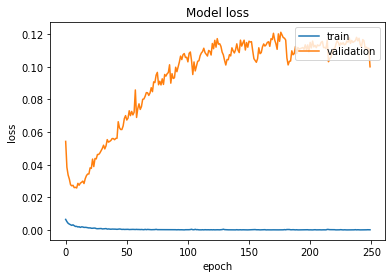

In [ ]:
optimizer_GRU = torch.optim.Adam(model_GRU.parameters(), lr=1e-3, weight_decay=1e-8) # L2 = weight_decay
model_run(model_GRU, optimizer_GRU)

## BGRU

In [ ]:
'''
Class BGRU
Bidirectional GRU

'''

class BGRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
    super(BGRU, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    self.embeddings = Embedding(input_size, hidden_size, word_embeddings)
    self.gru = nn.GRU(input_size = input_size,
                      hidden_size = hidden_size,
                      num_layers = num_layers,
                      batch_first=True,
                      dropout = 0,
                      bidirectional=True
                      )
    ## input_shape to nn.RNN-> (batch_size, seq_length, input_size) 
    self.dropout = nn.Dropout(dropout)
    self.activation = nn.Tanh()
    # The last layer to compute the probabilities for the output classes
    self.final_layer = nn.Linear(in_features=hidden_size*2, out_features=num_classes)
  

  def forward(self, x_idx):
    x = self.embeddings(x_idx)
    # h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to("cuda")
    h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
    if torch.cuda.is_available():
        h0 = h0.to("cuda")
   
    output, _ = self.gru(x.float(), h0)

    output = self.dropout(output)
    output = self.activation(output)
    logits = self.final_layer(output)
    return logits


In [ ]:
# We initialize our model
model_BGRU = BGRU(input_size = WORD_DIM,
            hidden_size = 128,
            num_layers = 1,
            num_classes = len(MAPPING_NER_LABELS),
            dropout = 0.3
            )

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:01, 53.63it/s]
Val: 8it [00:00, 101.93it/s]
Test: 59it [00:00, 99.74it/s]


Train loss: 0.8936
Val   loss: 0.5421
Test  loss: 0.5391

Val   Macro F1: 0.1973
Test  Macro F1: 0.1953

Best Epoch: 0, best val macro F1: 0.1973, test macro F1: 0.1953


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:01, 53.02it/s]
Val: 8it [00:00, 105.53it/s]
Test: 59it [00:00, 97.69it/s]


Train loss: 0.4162
Val   loss: 0.3123
Test  loss: 0.2969

Val   Macro F1: 0.4434
Test  Macro F1: 0.4464

Best Epoch: 1, best val macro F1: 0.4434, test macro F1: 0.4464


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:01, 53.66it/s]
Val: 8it [00:00, 102.60it/s]
Test: 59it [00:00, 98.99it/s]


Train loss: 0.2715
Val   loss: 0.2556
Test  loss: 0.2189

Val   Macro F1: 0.5604
Test  Macro F1: 0.5713

Best Epoch: 2, best val macro F1: 0.5604, test macro F1: 0.5713


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:01, 53.29it/s]
Val: 8it [00:00, 95.36it/s]
Test: 59it [00:00, 98.57it/s]


Train loss: 0.2150
Val   loss: 0.2323
Test  loss: 0.1779

Val   Macro F1: 0.5923
Test  Macro F1: 0.6242

Best Epoch: 3, best val macro F1: 0.5923, test macro F1: 0.6242


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:01, 53.93it/s]
Val: 8it [00:00, 102.98it/s]
Test: 59it [00:00, 98.37it/s]


Train loss: 0.1787
Val   loss: 0.2268
Test  loss: 0.1488

Val   Macro F1: 0.6608
Test  Macro F1: 0.7067

Best Epoch: 4, best val macro F1: 0.6608, test macro F1: 0.7067


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:01, 53.72it/s]
Val: 8it [00:00, 107.16it/s]
Test: 59it [00:00, 100.62it/s]


Train loss: 0.1546
Val   loss: 0.2245
Test  loss: 0.1286

Val   Macro F1: 0.6748
Test  Macro F1: 0.7425

Best Epoch: 5, best val macro F1: 0.6748, test macro F1: 0.7425


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:01, 53.25it/s]
Val: 8it [00:00, 104.58it/s]
Test: 59it [00:00, 99.59it/s]


Train loss: 0.1360
Val   loss: 0.2259
Test  loss: 0.1151

Val   Macro F1: 0.6731
Test  Macro F1: 0.7584

Best Epoch: 5, best val macro F1: 0.6748, test macro F1: 0.7425


------------------------------------------------------------------------
Epoch: 7


Training: 59it [00:01, 53.39it/s]
Val: 8it [00:00, 102.47it/s]
Test: 59it [00:00, 100.00it/s]


Train loss: 0.1234
Val   loss: 0.2384
Test  loss: 0.1066

Val   Macro F1: 0.6842
Test  Macro F1: 0.7707

Best Epoch: 7, best val macro F1: 0.6842, test macro F1: 0.7707


------------------------------------------------------------------------
Epoch: 8


Training: 59it [00:01, 53.84it/s]
Val: 8it [00:00, 105.98it/s]
Test: 59it [00:00, 99.75it/s] 


Train loss: 0.1121
Val   loss: 0.2403
Test  loss: 0.0933

Val   Macro F1: 0.6800
Test  Macro F1: 0.7810

Best Epoch: 7, best val macro F1: 0.6842, test macro F1: 0.7707


------------------------------------------------------------------------
Epoch: 9


Training: 59it [00:01, 53.40it/s]
Val: 8it [00:00, 103.78it/s]
Test: 59it [00:00, 100.33it/s]


Train loss: 0.1024
Val   loss: 0.2470
Test  loss: 0.0854

Val   Macro F1: 0.6843
Test  Macro F1: 0.7874

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 10


Training: 59it [00:01, 53.71it/s]
Val: 8it [00:00, 104.87it/s]
Test: 59it [00:00, 99.21it/s] 


Train loss: 0.0938
Val   loss: 0.2534
Test  loss: 0.0776

Val   Macro F1: 0.6780
Test  Macro F1: 0.7962

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 11


Training: 59it [00:01, 53.66it/s]
Val: 8it [00:00, 103.74it/s]
Test: 59it [00:00, 101.35it/s]


Train loss: 0.0872
Val   loss: 0.2676
Test  loss: 0.0703

Val   Macro F1: 0.6784
Test  Macro F1: 0.8007

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 12


Training: 59it [00:01, 53.56it/s]
Val: 8it [00:00, 108.31it/s]
Test: 59it [00:00, 98.53it/s]


Train loss: 0.0804
Val   loss: 0.2738
Test  loss: 0.0642

Val   Macro F1: 0.6787
Test  Macro F1: 0.8077

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 13


Training: 59it [00:01, 52.98it/s]
Val: 8it [00:00, 101.58it/s]
Test: 59it [00:00, 99.74it/s]


Train loss: 0.0727
Val   loss: 0.2800
Test  loss: 0.0575

Val   Macro F1: 0.6776
Test  Macro F1: 0.8138

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 14


Training: 59it [00:01, 53.56it/s]
Val: 8it [00:00, 104.44it/s]
Test: 59it [00:00, 98.04it/s]


Train loss: 0.0679
Val   loss: 0.2829
Test  loss: 0.0559

Val   Macro F1: 0.6832
Test  Macro F1: 0.8173

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 15


Training: 59it [00:01, 53.18it/s]
Val: 8it [00:00, 108.12it/s]
Test: 59it [00:00, 100.80it/s]


Train loss: 0.0614
Val   loss: 0.2987
Test  loss: 0.0475

Val   Macro F1: 0.6773
Test  Macro F1: 0.8243

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 16


Training: 59it [00:01, 53.06it/s]
Val: 8it [00:00, 100.61it/s]
Test: 59it [00:00, 99.15it/s]


Train loss: 0.0559
Val   loss: 0.3097
Test  loss: 0.0413

Val   Macro F1: 0.6755
Test  Macro F1: 0.8295

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 17


Training: 59it [00:01, 54.21it/s]
Val: 8it [00:00, 106.34it/s]
Test: 59it [00:00, 100.17it/s]


Train loss: 0.0501
Val   loss: 0.3151
Test  loss: 0.0378

Val   Macro F1: 0.6774
Test  Macro F1: 0.8331

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 18


Training: 59it [00:01, 53.54it/s]
Val: 8it [00:00, 104.52it/s]
Test: 59it [00:00, 100.62it/s]


Train loss: 0.0461
Val   loss: 0.3386
Test  loss: 0.0329

Val   Macro F1: 0.6712
Test  Macro F1: 0.8385

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 19


Training: 59it [00:01, 54.03it/s]
Val: 8it [00:00, 106.98it/s]
Test: 59it [00:00, 100.21it/s]


Train loss: 0.0408
Val   loss: 0.3532
Test  loss: 0.0291

Val   Macro F1: 0.6712
Test  Macro F1: 0.8420

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 20


Training: 59it [00:01, 53.79it/s]
Val: 8it [00:00, 102.31it/s]
Test: 59it [00:00, 99.62it/s] 


Train loss: 0.0374
Val   loss: 0.3674
Test  loss: 0.0259

Val   Macro F1: 0.6673
Test  Macro F1: 0.8450

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 21


Training: 59it [00:01, 52.80it/s]
Val: 8it [00:00, 108.65it/s]
Test: 59it [00:00, 98.37it/s]


Train loss: 0.0338
Val   loss: 0.3888
Test  loss: 0.0233

Val   Macro F1: 0.6684
Test  Macro F1: 0.8491

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 22


Training: 59it [00:01, 53.72it/s]
Val: 8it [00:00, 103.92it/s]
Test: 59it [00:00, 97.81it/s]


Train loss: 0.0306
Val   loss: 0.3967
Test  loss: 0.0203

Val   Macro F1: 0.6655
Test  Macro F1: 0.8504

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 23


Training: 59it [00:01, 52.97it/s]
Val: 8it [00:00, 101.71it/s]
Test: 59it [00:00, 98.52it/s]


Train loss: 0.0267
Val   loss: 0.3941
Test  loss: 0.0187

Val   Macro F1: 0.6743
Test  Macro F1: 0.8530

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 24


Training: 59it [00:01, 53.18it/s]
Val: 8it [00:00, 104.47it/s]
Test: 59it [00:00, 99.58it/s]


Train loss: 0.0242
Val   loss: 0.4260
Test  loss: 0.0154

Val   Macro F1: 0.6633
Test  Macro F1: 0.8553

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 25


Training: 59it [00:01, 53.27it/s]
Val: 8it [00:00, 91.99it/s]
Test: 59it [00:00, 100.33it/s]


Train loss: 0.0224
Val   loss: 0.4272
Test  loss: 0.0144

Val   Macro F1: 0.6652
Test  Macro F1: 0.8574

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 26


Training: 59it [00:01, 52.93it/s]
Val: 8it [00:00, 105.65it/s]
Test: 59it [00:00, 98.68it/s]


Train loss: 0.0206
Val   loss: 0.4689
Test  loss: 0.0132

Val   Macro F1: 0.6566
Test  Macro F1: 0.8595

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 27


Training: 59it [00:01, 53.12it/s]
Val: 8it [00:00, 103.36it/s]
Test: 59it [00:00, 98.18it/s]


Train loss: 0.0190
Val   loss: 0.4676
Test  loss: 0.0105

Val   Macro F1: 0.6614
Test  Macro F1: 0.8630

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 28


Training: 59it [00:01, 53.00it/s]
Val: 8it [00:00, 104.04it/s]
Test: 59it [00:00, 100.43it/s]


Train loss: 0.0168
Val   loss: 0.4728
Test  loss: 0.0095

Val   Macro F1: 0.6626
Test  Macro F1: 0.8632

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 29


Training: 59it [00:01, 54.29it/s]
Val: 8it [00:00, 105.53it/s]
Test: 59it [00:00, 102.10it/s]


Train loss: 0.0152
Val   loss: 0.4937
Test  loss: 0.0083

Val   Macro F1: 0.6588
Test  Macro F1: 0.8649

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 30


Training: 59it [00:01, 54.18it/s]
Val: 8it [00:00, 104.53it/s]
Test: 59it [00:00, 98.96it/s]


Train loss: 0.0139
Val   loss: 0.4849
Test  loss: 0.0079

Val   Macro F1: 0.6616
Test  Macro F1: 0.8652

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 31


Training: 59it [00:01, 53.63it/s]
Val: 8it [00:00, 105.93it/s]
Test: 59it [00:00, 100.51it/s]


Train loss: 0.0125
Val   loss: 0.5095
Test  loss: 0.0067

Val   Macro F1: 0.6598
Test  Macro F1: 0.8664

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 32


Training: 59it [00:01, 53.59it/s]
Val: 8it [00:00, 103.91it/s]
Test: 59it [00:00, 99.64it/s]


Train loss: 0.0109
Val   loss: 0.5472
Test  loss: 0.0058

Val   Macro F1: 0.6522
Test  Macro F1: 0.8674

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 33


Training: 59it [00:01, 53.55it/s]
Val: 8it [00:00, 102.75it/s]
Test: 59it [00:00, 99.64it/s]


Train loss: 0.0097
Val   loss: 0.5391
Test  loss: 0.0049

Val   Macro F1: 0.6575
Test  Macro F1: 0.8676

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 34


Training: 59it [00:01, 53.72it/s]
Val: 8it [00:00, 103.91it/s]
Test: 59it [00:00, 99.46it/s]


Train loss: 0.0091
Val   loss: 0.5572
Test  loss: 0.0048

Val   Macro F1: 0.6533
Test  Macro F1: 0.8685

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 35


Training: 59it [00:01, 53.24it/s]
Val: 8it [00:00, 105.72it/s]
Test: 59it [00:00, 99.38it/s]


Train loss: 0.0084
Val   loss: 0.5695
Test  loss: 0.0040

Val   Macro F1: 0.6536
Test  Macro F1: 0.8693

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 36


Training: 59it [00:01, 53.41it/s]
Val: 8it [00:00, 103.22it/s]
Test: 59it [00:00, 100.54it/s]


Train loss: 0.0074
Val   loss: 0.5913
Test  loss: 0.0036

Val   Macro F1: 0.6496
Test  Macro F1: 0.8692

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 37


Training: 59it [00:01, 53.40it/s]
Val: 8it [00:00, 104.52it/s]
Test: 59it [00:00, 100.03it/s]


Train loss: 0.0071
Val   loss: 0.6281
Test  loss: 0.0053

Val   Macro F1: 0.6457
Test  Macro F1: 0.8687

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 38


Training: 59it [00:01, 53.43it/s]
Val: 8it [00:00, 95.62it/s]
Test: 59it [00:00, 100.39it/s]


Train loss: 0.0081
Val   loss: 0.5974
Test  loss: 0.0048

Val   Macro F1: 0.6532
Test  Macro F1: 0.8677

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 39


Training: 59it [00:01, 53.34it/s]
Val: 8it [00:00, 106.73it/s]
Test: 59it [00:00, 99.90it/s]


Train loss: 0.0077
Val   loss: 0.5895
Test  loss: 0.0034

Val   Macro F1: 0.6597
Test  Macro F1: 0.8701

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 40


Training: 59it [00:01, 54.09it/s]
Val: 8it [00:00, 98.85it/s]
Test: 59it [00:00, 98.62it/s]


Train loss: 0.0060
Val   loss: 0.6183
Test  loss: 0.0026

Val   Macro F1: 0.6495
Test  Macro F1: 0.8700

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 41


Training: 59it [00:01, 53.16it/s]
Val: 8it [00:00, 101.72it/s]
Test: 59it [00:00, 99.71it/s] 


Train loss: 0.0054
Val   loss: 0.6533
Test  loss: 0.0024

Val   Macro F1: 0.6436
Test  Macro F1: 0.8710

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 42


Training: 59it [00:01, 52.73it/s]
Val: 8it [00:00, 103.60it/s]
Test: 59it [00:00, 100.68it/s]


Train loss: 0.0049
Val   loss: 0.6689
Test  loss: 0.0020

Val   Macro F1: 0.6428
Test  Macro F1: 0.8716

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 43


Training: 59it [00:01, 53.50it/s]
Val: 8it [00:00, 102.19it/s]
Test: 59it [00:00, 98.93it/s]


Train loss: 0.0044
Val   loss: 0.6824
Test  loss: 0.0020

Val   Macro F1: 0.6413
Test  Macro F1: 0.8712

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 44


Training: 59it [00:01, 53.82it/s]
Val: 8it [00:00, 100.74it/s]
Test: 59it [00:00, 99.36it/s]


Train loss: 0.0041
Val   loss: 0.6627
Test  loss: 0.0019

Val   Macro F1: 0.6419
Test  Macro F1: 0.8709

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 45


Training: 59it [00:01, 53.65it/s]
Val: 8it [00:00, 106.46it/s]
Test: 59it [00:00, 99.83it/s]


Train loss: 0.0042
Val   loss: 0.7082
Test  loss: 0.0018

Val   Macro F1: 0.6392
Test  Macro F1: 0.8713

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 46


Training: 59it [00:01, 53.82it/s]
Val: 8it [00:00, 106.27it/s]
Test: 59it [00:00, 99.81it/s] 


Train loss: 0.0040
Val   loss: 0.6692
Test  loss: 0.0017

Val   Macro F1: 0.6481
Test  Macro F1: 0.8699

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 47


Training: 59it [00:01, 53.65it/s]
Val: 8it [00:00, 101.38it/s]
Test: 59it [00:00, 99.36it/s]


Train loss: 0.0038
Val   loss: 0.6986
Test  loss: 0.0015

Val   Macro F1: 0.6414
Test  Macro F1: 0.8717

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 48


Training: 59it [00:01, 53.38it/s]
Val: 8it [00:00, 102.75it/s]
Test: 59it [00:00, 97.64it/s]


Train loss: 0.0036
Val   loss: 0.7067
Test  loss: 0.0013

Val   Macro F1: 0.6386
Test  Macro F1: 0.8718

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 49


Training: 59it [00:01, 53.19it/s]
Val: 8it [00:00, 102.08it/s]
Test: 59it [00:00, 99.56it/s]


Train loss: 0.0031
Val   loss: 0.7021
Test  loss: 0.0012

Val   Macro F1: 0.6425
Test  Macro F1: 0.8721

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 50


Training: 59it [00:01, 53.40it/s]
Val: 8it [00:00, 106.05it/s]
Test: 59it [00:00, 99.86it/s]


Train loss: 0.0031
Val   loss: 0.7009
Test  loss: 0.0011

Val   Macro F1: 0.6471
Test  Macro F1: 0.8716

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 51


Training: 59it [00:01, 53.69it/s]
Val: 8it [00:00, 106.17it/s]
Test: 59it [00:00, 99.55it/s]


Train loss: 0.0028
Val   loss: 0.7496
Test  loss: 0.0011

Val   Macro F1: 0.6379
Test  Macro F1: 0.8721

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 52


Training: 59it [00:01, 53.52it/s]
Val: 8it [00:00, 104.17it/s]
Test: 59it [00:00, 98.55it/s]


Train loss: 0.0028
Val   loss: 0.7553
Test  loss: 0.0012

Val   Macro F1: 0.6357
Test  Macro F1: 0.8721

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 53


Training: 59it [00:01, 53.71it/s]
Val: 8it [00:00, 105.61it/s]
Test: 59it [00:00, 99.34it/s]


Train loss: 0.0030
Val   loss: 0.7522
Test  loss: 0.0011

Val   Macro F1: 0.6362
Test  Macro F1: 0.8713

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 54


Training: 59it [00:01, 53.27it/s]
Val: 8it [00:00, 102.18it/s]
Test: 59it [00:00, 99.72it/s]


Train loss: 0.0031
Val   loss: 0.7536
Test  loss: 0.0013

Val   Macro F1: 0.6396
Test  Macro F1: 0.8708

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 55


Training: 59it [00:01, 52.95it/s]
Val: 8it [00:00, 104.86it/s]
Test: 59it [00:00, 100.55it/s]


Train loss: 0.0042
Val   loss: 0.7276
Test  loss: 0.0023

Val   Macro F1: 0.6488
Test  Macro F1: 0.8704

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 56


Training: 59it [00:01, 53.17it/s]
Val: 8it [00:00, 109.54it/s]
Test: 59it [00:00, 99.87it/s]


Train loss: 0.0052
Val   loss: 0.7234
Test  loss: 0.0027

Val   Macro F1: 0.6528
Test  Macro F1: 0.8700

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 57


Training: 59it [00:01, 53.33it/s]
Val: 8it [00:00, 101.62it/s]
Test: 59it [00:00, 98.17it/s]


Train loss: 0.0073
Val   loss: 0.7585
Test  loss: 0.0027

Val   Macro F1: 0.6384
Test  Macro F1: 0.8707

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 58


Training: 59it [00:01, 53.24it/s]
Val: 8it [00:00, 104.84it/s]
Test: 59it [00:00, 98.03it/s]


Train loss: 0.0080
Val   loss: 0.7518
Test  loss: 0.0035

Val   Macro F1: 0.6441
Test  Macro F1: 0.8702

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 59


Training: 59it [00:01, 53.20it/s]
Val: 8it [00:00, 107.73it/s]
Test: 59it [00:00, 99.94it/s]


Train loss: 0.0056
Val   loss: 0.7071
Test  loss: 0.0028

Val   Macro F1: 0.6556
Test  Macro F1: 0.8696

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 60


Training: 59it [00:01, 53.22it/s]
Val: 8it [00:00, 96.09it/s]
Test: 59it [00:00, 100.95it/s]


Train loss: 0.0038
Val   loss: 0.8171
Test  loss: 0.0016

Val   Macro F1: 0.6381
Test  Macro F1: 0.8720

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 61


Training: 59it [00:01, 52.84it/s]
Val: 8it [00:00, 102.29it/s]
Test: 59it [00:00, 100.76it/s]


Train loss: 0.0028
Val   loss: 0.7540
Test  loss: 0.0007

Val   Macro F1: 0.6472
Test  Macro F1: 0.8706

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 62


Training: 59it [00:01, 53.91it/s]
Val: 8it [00:00, 104.28it/s]
Test: 59it [00:00, 99.27it/s]


Train loss: 0.0019
Val   loss: 0.8022
Test  loss: 0.0005

Val   Macro F1: 0.6435
Test  Macro F1: 0.8708

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 63


Training: 59it [00:01, 53.85it/s]
Val: 8it [00:00, 103.27it/s]
Test: 59it [00:00, 100.48it/s]


Train loss: 0.0016
Val   loss: 0.8003
Test  loss: 0.0004

Val   Macro F1: 0.6393
Test  Macro F1: 0.8725

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 64


Training: 59it [00:01, 54.01it/s]
Val: 8it [00:00, 102.40it/s]
Test: 59it [00:00, 100.42it/s]


Train loss: 0.0014
Val   loss: 0.8180
Test  loss: 0.0003

Val   Macro F1: 0.6376
Test  Macro F1: 0.8706

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 65


Training: 59it [00:01, 53.31it/s]
Val: 8it [00:00, 102.91it/s]
Test: 59it [00:00, 98.74it/s]


Train loss: 0.0012
Val   loss: 0.8102
Test  loss: 0.0003

Val   Macro F1: 0.6372
Test  Macro F1: 0.8701

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 66


Training: 59it [00:01, 53.82it/s]
Val: 8it [00:00, 99.99it/s]
Test: 59it [00:00, 98.96it/s]


Train loss: 0.0011
Val   loss: 0.8379
Test  loss: 0.0003

Val   Macro F1: 0.6307
Test  Macro F1: 0.8681

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 67


Training: 59it [00:01, 53.07it/s]
Val: 8it [00:00, 98.94it/s]
Test: 59it [00:00, 100.57it/s]


Train loss: 0.0010
Val   loss: 0.8452
Test  loss: 0.0003

Val   Macro F1: 0.6338
Test  Macro F1: 0.8696

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 68


Training: 59it [00:01, 53.53it/s]
Val: 8it [00:00, 101.64it/s]
Test: 59it [00:00, 97.68it/s]


Train loss: 0.0011
Val   loss: 0.8375
Test  loss: 0.0003

Val   Macro F1: 0.6341
Test  Macro F1: 0.8691

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 69


Training: 59it [00:01, 52.83it/s]
Val: 8it [00:00, 96.85it/s]
Test: 59it [00:00, 100.35it/s]


Train loss: 0.0010
Val   loss: 0.8568
Test  loss: 0.0003

Val   Macro F1: 0.6356
Test  Macro F1: 0.8717

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 70


Training: 59it [00:01, 53.28it/s]
Val: 8it [00:00, 106.61it/s]
Test: 59it [00:00, 100.23it/s]


Train loss: 0.0010
Val   loss: 0.8640
Test  loss: 0.0002

Val   Macro F1: 0.6323
Test  Macro F1: 0.8710

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 71


Training: 59it [00:01, 53.71it/s]
Val: 8it [00:00, 102.37it/s]
Test: 59it [00:00, 99.98it/s]


Train loss: 0.0009
Val   loss: 0.8626
Test  loss: 0.0002

Val   Macro F1: 0.6306
Test  Macro F1: 0.8685

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 72


Training: 59it [00:01, 54.05it/s]
Val: 8it [00:00, 102.60it/s]
Test: 59it [00:00, 98.89it/s]


Train loss: 0.0010
Val   loss: 0.8673
Test  loss: 0.0002

Val   Macro F1: 0.6370
Test  Macro F1: 0.8721

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 73


Training: 59it [00:01, 53.55it/s]
Val: 8it [00:00, 100.43it/s]
Test: 59it [00:00, 98.47it/s]


Train loss: 0.0009
Val   loss: 0.8666
Test  loss: 0.0002

Val   Macro F1: 0.6353
Test  Macro F1: 0.8709

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 74


Training: 59it [00:01, 54.22it/s]
Val: 8it [00:00, 102.16it/s]
Test: 59it [00:00, 98.25it/s]


Train loss: 0.0010
Val   loss: 0.8890
Test  loss: 0.0003

Val   Macro F1: 0.6333
Test  Macro F1: 0.8717

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 75


Training: 59it [00:01, 53.45it/s]
Val: 8it [00:00, 105.19it/s]
Test: 59it [00:00, 98.47it/s]


Train loss: 0.0012
Val   loss: 0.8905
Test  loss: 0.0003

Val   Macro F1: 0.6322
Test  Macro F1: 0.8686

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 76


Training: 59it [00:01, 53.44it/s]
Val: 8it [00:00, 104.89it/s]
Test: 59it [00:00, 96.93it/s]


Train loss: 0.0011
Val   loss: 0.8774
Test  loss: 0.0003

Val   Macro F1: 0.6401
Test  Macro F1: 0.8700

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 77


Training: 59it [00:01, 52.61it/s]
Val: 8it [00:00, 99.20it/s]
Test: 59it [00:00, 100.38it/s]


Train loss: 0.0011
Val   loss: 0.8996
Test  loss: 0.0003

Val   Macro F1: 0.6323
Test  Macro F1: 0.8692

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 78


Training: 59it [00:01, 53.13it/s]
Val: 8it [00:00, 100.07it/s]
Test: 59it [00:00, 99.29it/s]


Train loss: 0.0015
Val   loss: 0.8591
Test  loss: 0.0006

Val   Macro F1: 0.6438
Test  Macro F1: 0.8709

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 79


Training: 59it [00:01, 53.79it/s]
Val: 8it [00:00, 103.93it/s]
Test: 59it [00:00, 97.81it/s]


Train loss: 0.0022
Val   loss: 0.8992
Test  loss: 0.0011

Val   Macro F1: 0.6301
Test  Macro F1: 0.8685

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 80


Training: 59it [00:01, 53.53it/s]
Val: 8it [00:00, 98.77it/s]
Test: 59it [00:00, 97.16it/s]


Train loss: 0.0036
Val   loss: 0.8109
Test  loss: 0.0052

Val   Macro F1: 0.6527
Test  Macro F1: 0.8656

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 81


Training: 59it [00:01, 53.94it/s]
Val: 8it [00:00, 103.17it/s]
Test: 59it [00:00, 101.12it/s]


Train loss: 0.0073
Val   loss: 0.9223
Test  loss: 0.0099

Val   Macro F1: 0.6271
Test  Macro F1: 0.8585

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 82


Training: 59it [00:01, 53.46it/s]
Val: 8it [00:00, 105.64it/s]
Test: 59it [00:00, 97.21it/s]


Train loss: 0.0081
Val   loss: 0.8656
Test  loss: 0.0045

Val   Macro F1: 0.6388
Test  Macro F1: 0.8664

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 83


Training: 59it [00:01, 52.71it/s]
Val: 8it [00:00, 107.06it/s]
Test: 59it [00:00, 99.59it/s]


Train loss: 0.0071
Val   loss: 0.8475
Test  loss: 0.0020

Val   Macro F1: 0.6436
Test  Macro F1: 0.8715

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 84


Training: 59it [00:01, 53.16it/s]
Val: 8it [00:00, 105.28it/s]
Test: 59it [00:00, 99.49it/s]


Train loss: 0.0038
Val   loss: 0.9487
Test  loss: 0.0015

Val   Macro F1: 0.6216
Test  Macro F1: 0.8704

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 85


Training: 59it [00:01, 53.83it/s]
Val: 8it [00:00, 107.19it/s]
Test: 59it [00:00, 99.33it/s] 


Train loss: 0.0027
Val   loss: 0.8766
Test  loss: 0.0005

Val   Macro F1: 0.6425
Test  Macro F1: 0.8712

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 86


Training: 59it [00:01, 53.09it/s]
Val: 8it [00:00, 105.06it/s]
Test: 59it [00:00, 99.91it/s] 


Train loss: 0.0015
Val   loss: 0.8742
Test  loss: 0.0003

Val   Macro F1: 0.6437
Test  Macro F1: 0.8717

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 87


Training: 59it [00:01, 53.83it/s]
Val: 8it [00:00, 98.66it/s]
Test: 59it [00:00, 98.95it/s]


Train loss: 0.0011
Val   loss: 0.9010
Test  loss: 0.0002

Val   Macro F1: 0.6417
Test  Macro F1: 0.8709

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 88


Training: 59it [00:01, 53.77it/s]
Val: 8it [00:00, 104.80it/s]
Test: 59it [00:00, 97.93it/s]


Train loss: 0.0009
Val   loss: 0.9040
Test  loss: 0.0002

Val   Macro F1: 0.6420
Test  Macro F1: 0.8720

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 89


Training: 59it [00:01, 53.47it/s]
Val: 8it [00:00, 103.02it/s]
Test: 59it [00:00, 98.74it/s]


Train loss: 0.0008
Val   loss: 0.9027
Test  loss: 0.0002

Val   Macro F1: 0.6465
Test  Macro F1: 0.8727

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 90


Training: 59it [00:01, 53.60it/s]
Val: 8it [00:00, 106.58it/s]
Test: 59it [00:00, 97.88it/s]


Train loss: 0.0007
Val   loss: 0.9261
Test  loss: 0.0001

Val   Macro F1: 0.6382
Test  Macro F1: 0.8715

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 91


Training: 59it [00:01, 53.31it/s]
Val: 8it [00:00, 102.54it/s]
Test: 59it [00:00, 99.70it/s]


Train loss: 0.0006
Val   loss: 0.9363
Test  loss: 0.0002

Val   Macro F1: 0.6389
Test  Macro F1: 0.8706

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 92


Training: 59it [00:01, 53.51it/s]
Val: 8it [00:00, 104.41it/s]
Test: 59it [00:00, 98.96it/s]


Train loss: 0.0006
Val   loss: 0.9706
Test  loss: 0.0002

Val   Macro F1: 0.6356
Test  Macro F1: 0.8708

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 93


Training: 59it [00:01, 53.79it/s]
Val: 8it [00:00, 100.45it/s]
Test: 59it [00:00, 98.90it/s]


Train loss: 0.0006
Val   loss: 0.9421
Test  loss: 0.0001

Val   Macro F1: 0.6381
Test  Macro F1: 0.8704

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 94


Training: 59it [00:01, 52.89it/s]
Val: 8it [00:00, 92.89it/s]
Test: 59it [00:00, 98.61it/s]


Train loss: 0.0005
Val   loss: 0.9436
Test  loss: 0.0001

Val   Macro F1: 0.6401
Test  Macro F1: 0.8695

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 95


Training: 59it [00:01, 52.26it/s]
Val: 8it [00:00, 94.99it/s]
Test: 59it [00:00, 99.70it/s]


Train loss: 0.0005
Val   loss: 0.9738
Test  loss: 0.0001

Val   Macro F1: 0.6359
Test  Macro F1: 0.8694

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 96


Training: 59it [00:01, 53.67it/s]
Val: 8it [00:00, 96.30it/s]
Test: 59it [00:00, 99.99it/s]


Train loss: 0.0004
Val   loss: 0.9643
Test  loss: 0.0001

Val   Macro F1: 0.6372
Test  Macro F1: 0.8681

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 97


Training: 59it [00:01, 53.28it/s]
Val: 8it [00:00, 104.79it/s]
Test: 59it [00:00, 99.39it/s]


Train loss: 0.0004
Val   loss: 1.0090
Test  loss: 0.0002

Val   Macro F1: 0.6357
Test  Macro F1: 0.8707

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 98


Training: 59it [00:01, 54.07it/s]
Val: 8it [00:00, 99.28it/s]
Test: 59it [00:00, 98.79it/s]


Train loss: 0.0005
Val   loss: 0.9888
Test  loss: 0.0001

Val   Macro F1: 0.6356
Test  Macro F1: 0.8692

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 99


Training: 59it [00:01, 52.88it/s]
Val: 8it [00:00, 97.87it/s]
Test: 59it [00:00, 97.72it/s]


Train loss: 0.0005
Val   loss: 0.9725
Test  loss: 0.0001

Val   Macro F1: 0.6385
Test  Macro F1: 0.8691

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 100


Training: 59it [00:01, 53.15it/s]
Val: 8it [00:00, 102.74it/s]
Test: 59it [00:00, 99.26it/s]


Train loss: 0.0005
Val   loss: 0.9720
Test  loss: 0.0002

Val   Macro F1: 0.6409
Test  Macro F1: 0.8694

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 101


Training: 59it [00:01, 53.12it/s]
Val: 8it [00:00, 106.30it/s]
Test: 59it [00:00, 96.94it/s]


Train loss: 0.0005
Val   loss: 0.9634
Test  loss: 0.0001

Val   Macro F1: 0.6383
Test  Macro F1: 0.8652

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 102


Training: 59it [00:01, 52.82it/s]
Val: 8it [00:00, 100.83it/s]
Test: 59it [00:00, 98.44it/s]


Train loss: 0.0006
Val   loss: 1.0157
Test  loss: 0.0001

Val   Macro F1: 0.6283
Test  Macro F1: 0.8668

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 103


Training: 59it [00:01, 52.55it/s]
Val: 8it [00:00, 104.91it/s]
Test: 59it [00:00, 99.98it/s]


Train loss: 0.0005
Val   loss: 1.0016
Test  loss: 0.0001

Val   Macro F1: 0.6387
Test  Macro F1: 0.8681

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 104


Training: 59it [00:01, 52.99it/s]
Val: 8it [00:00, 104.85it/s]
Test: 59it [00:00, 99.07it/s]


Train loss: 0.0004
Val   loss: 0.9874
Test  loss: 0.0001

Val   Macro F1: 0.6388
Test  Macro F1: 0.8672

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 105


Training: 59it [00:01, 52.63it/s]
Val: 8it [00:00, 104.28it/s]
Test: 59it [00:00, 99.05it/s]


Train loss: 0.0004
Val   loss: 1.0064
Test  loss: 0.0001

Val   Macro F1: 0.6382
Test  Macro F1: 0.8685

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 106


Training: 59it [00:01, 52.35it/s]
Val: 8it [00:00, 97.88it/s]
Test: 59it [00:00, 98.78it/s]


Train loss: 0.0004
Val   loss: 1.0271
Test  loss: 0.0001

Val   Macro F1: 0.6313
Test  Macro F1: 0.8671

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 107


Training: 59it [00:01, 52.76it/s]
Val: 8it [00:00, 97.44it/s]
Test: 59it [00:00, 100.13it/s]


Train loss: 0.0004
Val   loss: 1.0484
Test  loss: 0.0001

Val   Macro F1: 0.6344
Test  Macro F1: 0.8698

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 108


Training: 59it [00:01, 53.71it/s]
Val: 8it [00:00, 103.51it/s]
Test: 59it [00:00, 98.53it/s]


Train loss: 0.0004
Val   loss: 1.0330
Test  loss: 0.0002

Val   Macro F1: 0.6349
Test  Macro F1: 0.8714

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 109


Training: 59it [00:01, 53.13it/s]
Val: 8it [00:00, 102.96it/s]
Test: 59it [00:00, 101.33it/s]


Train loss: 0.0007
Val   loss: 1.0228
Test  loss: 0.0002

Val   Macro F1: 0.6355
Test  Macro F1: 0.8718

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 110


Training: 59it [00:01, 53.71it/s]
Val: 8it [00:00, 96.25it/s]
Test: 59it [00:00, 100.06it/s]


Train loss: 0.0012
Val   loss: 1.0490
Test  loss: 0.0010

Val   Macro F1: 0.6384
Test  Macro F1: 0.8718

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 111


Training: 59it [00:01, 53.18it/s]
Val: 8it [00:00, 103.36it/s]
Test: 59it [00:00, 98.51it/s]


Train loss: 0.0109
Val   loss: 1.0057
Test  loss: 0.0110

Val   Macro F1: 0.6229
Test  Macro F1: 0.8555

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 112


Training: 59it [00:01, 52.24it/s]
Val: 8it [00:00, 68.05it/s]
Test: 59it [00:00, 73.08it/s]


Train loss: 0.0149
Val   loss: 0.9292
Test  loss: 0.0052

Val   Macro F1: 0.6286
Test  Macro F1: 0.8609

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 113


Training: 59it [00:01, 52.72it/s]
Val: 8it [00:00, 103.54it/s]
Test: 59it [00:00, 98.58it/s]


Train loss: 0.0081
Val   loss: 0.8602
Test  loss: 0.0036

Val   Macro F1: 0.6495
Test  Macro F1: 0.8665

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 114


Training: 59it [00:01, 53.75it/s]
Val: 8it [00:00, 104.80it/s]
Test: 59it [00:00, 99.48it/s]


Train loss: 0.0042
Val   loss: 0.9443
Test  loss: 0.0008

Val   Macro F1: 0.6316
Test  Macro F1: 0.8679

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 115


Training: 59it [00:01, 53.53it/s]
Val: 8it [00:00, 105.13it/s]
Test: 59it [00:00, 98.47it/s]


Train loss: 0.0019
Val   loss: 0.9603
Test  loss: 0.0003

Val   Macro F1: 0.6391
Test  Macro F1: 0.8671

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 116


Training: 59it [00:01, 53.22it/s]
Val: 8it [00:00, 101.34it/s]
Test: 59it [00:00, 98.98it/s]


Train loss: 0.0013
Val   loss: 0.9444
Test  loss: 0.0002

Val   Macro F1: 0.6504
Test  Macro F1: 0.8703

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 117


Training: 59it [00:01, 52.47it/s]
Val: 8it [00:00, 100.32it/s]
Test: 59it [00:00, 100.30it/s]


Train loss: 0.0010
Val   loss: 0.9482
Test  loss: 0.0002

Val   Macro F1: 0.6453
Test  Macro F1: 0.8683

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 118


Training: 59it [00:01, 53.39it/s]
Val: 8it [00:00, 102.11it/s]
Test: 59it [00:00, 99.11it/s]


Train loss: 0.0007
Val   loss: 0.9783
Test  loss: 0.0001

Val   Macro F1: 0.6446
Test  Macro F1: 0.8697

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 119


Training: 59it [00:01, 53.24it/s]
Val: 8it [00:00, 103.47it/s]
Test: 59it [00:00, 99.91it/s] 


Train loss: 0.0006
Val   loss: 0.9799
Test  loss: 0.0001

Val   Macro F1: 0.6450
Test  Macro F1: 0.8689

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 120


Training: 59it [00:01, 53.79it/s]
Val: 8it [00:00, 104.79it/s]
Test: 59it [00:00, 100.77it/s]


Train loss: 0.0005
Val   loss: 0.9829
Test  loss: 0.0001

Val   Macro F1: 0.6454
Test  Macro F1: 0.8686

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 121


Training: 59it [00:01, 54.14it/s]
Val: 8it [00:00, 104.99it/s]
Test: 59it [00:00, 99.04it/s]


Train loss: 0.0005
Val   loss: 0.9866
Test  loss: 0.0001

Val   Macro F1: 0.6461
Test  Macro F1: 0.8684

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 122


Training: 59it [00:01, 54.09it/s]
Val: 8it [00:00, 102.57it/s]
Test: 59it [00:00, 97.82it/s]


Train loss: 0.0004
Val   loss: 1.0064
Test  loss: 0.0001

Val   Macro F1: 0.6431
Test  Macro F1: 0.8683

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 123


Training: 59it [00:01, 53.50it/s]
Val: 8it [00:00, 103.28it/s]
Test: 59it [00:00, 100.48it/s]


Train loss: 0.0004
Val   loss: 1.0243
Test  loss: 0.0001

Val   Macro F1: 0.6414
Test  Macro F1: 0.8670

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 124


Training: 59it [00:01, 52.64it/s]
Val: 8it [00:00, 105.54it/s]
Test: 59it [00:00, 99.74it/s]


Train loss: 0.0004
Val   loss: 1.0292
Test  loss: 0.0001

Val   Macro F1: 0.6389
Test  Macro F1: 0.8666

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 125


Training: 59it [00:01, 53.32it/s]
Val: 8it [00:00, 105.15it/s]
Test: 59it [00:00, 98.97it/s]


Train loss: 0.0004
Val   loss: 1.0375
Test  loss: 0.0001

Val   Macro F1: 0.6405
Test  Macro F1: 0.8679

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 126


Training: 59it [00:01, 53.26it/s]
Val: 8it [00:00, 96.05it/s]
Test: 59it [00:00, 100.72it/s]


Train loss: 0.0004
Val   loss: 1.0322
Test  loss: 0.0001

Val   Macro F1: 0.6407
Test  Macro F1: 0.8668

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 127


Training: 59it [00:01, 53.48it/s]
Val: 8it [00:00, 98.33it/s]
Test: 59it [00:00, 99.15it/s]


Train loss: 0.0004
Val   loss: 1.0202
Test  loss: 0.0001

Val   Macro F1: 0.6441
Test  Macro F1: 0.8685

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 128


Training: 59it [00:01, 53.53it/s]
Val: 8it [00:00, 95.94it/s]
Test: 59it [00:00, 99.04it/s]


Train loss: 0.0004
Val   loss: 1.0329
Test  loss: 0.0001

Val   Macro F1: 0.6444
Test  Macro F1: 0.8677

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 129


Training: 59it [00:01, 53.40it/s]
Val: 8it [00:00, 101.46it/s]
Test: 59it [00:00, 101.10it/s]


Train loss: 0.0003
Val   loss: 1.0338
Test  loss: 0.0001

Val   Macro F1: 0.6428
Test  Macro F1: 0.8668

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 130


Training: 59it [00:01, 53.80it/s]
Val: 8it [00:00, 104.64it/s]
Test: 59it [00:00, 98.20it/s]


Train loss: 0.0003
Val   loss: 1.0204
Test  loss: 0.0001

Val   Macro F1: 0.6471
Test  Macro F1: 0.8683

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 131


Training: 59it [00:01, 52.96it/s]
Val: 8it [00:00, 101.93it/s]
Test: 59it [00:00, 100.04it/s]


Train loss: 0.0003
Val   loss: 1.0346
Test  loss: 0.0001

Val   Macro F1: 0.6454
Test  Macro F1: 0.8683

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 132


Training: 59it [00:01, 53.14it/s]
Val: 8it [00:00, 98.11it/s]
Test: 59it [00:00, 98.54it/s]


Train loss: 0.0003
Val   loss: 1.0400
Test  loss: 0.0001

Val   Macro F1: 0.6444
Test  Macro F1: 0.8667

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 133


Training: 59it [00:01, 53.53it/s]
Val: 8it [00:00, 104.80it/s]
Test: 59it [00:00, 97.50it/s]


Train loss: 0.0003
Val   loss: 1.0374
Test  loss: 0.0001

Val   Macro F1: 0.6450
Test  Macro F1: 0.8668

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 134


Training: 59it [00:01, 53.30it/s]
Val: 8it [00:00, 99.46it/s]
Test: 59it [00:00, 98.68it/s]


Train loss: 0.0003
Val   loss: 1.0660
Test  loss: 0.0001

Val   Macro F1: 0.6438
Test  Macro F1: 0.8674

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 135


Training: 59it [00:01, 53.85it/s]
Val: 8it [00:00, 104.51it/s]
Test: 59it [00:00, 98.58it/s]


Train loss: 0.0003
Val   loss: 1.0652
Test  loss: 0.0001

Val   Macro F1: 0.6435
Test  Macro F1: 0.8662

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 136


Training: 59it [00:01, 53.58it/s]
Val: 8it [00:00, 105.43it/s]
Test: 59it [00:00, 98.91it/s]


Train loss: 0.0003
Val   loss: 1.0707
Test  loss: 0.0001

Val   Macro F1: 0.6407
Test  Macro F1: 0.8663

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 137


Training: 59it [00:01, 53.85it/s]
Val: 8it [00:00, 101.58it/s]
Test: 59it [00:00, 99.79it/s]


Train loss: 0.0003
Val   loss: 1.0896
Test  loss: 0.0001

Val   Macro F1: 0.6364
Test  Macro F1: 0.8652

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 138


Training: 59it [00:01, 53.66it/s]
Val: 8it [00:00, 100.97it/s]
Test: 59it [00:00, 100.02it/s]


Train loss: 0.0003
Val   loss: 1.0747
Test  loss: 0.0001

Val   Macro F1: 0.6418
Test  Macro F1: 0.8668

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 139


Training: 59it [00:01, 53.53it/s]
Val: 8it [00:00, 105.62it/s]
Test: 59it [00:00, 97.61it/s]


Train loss: 0.0003
Val   loss: 1.0949
Test  loss: 0.0001

Val   Macro F1: 0.6379
Test  Macro F1: 0.8647

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 140


Training: 59it [00:01, 53.31it/s]
Val: 8it [00:00, 106.44it/s]
Test: 59it [00:00, 96.99it/s]


Train loss: 0.0014
Val   loss: 1.0482
Test  loss: 0.0024

Val   Macro F1: 0.6322
Test  Macro F1: 0.8590

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 141


Training: 59it [00:01, 53.68it/s]
Val: 8it [00:00, 102.19it/s]
Test: 59it [00:00, 99.62it/s]


Train loss: 0.0136
Val   loss: 0.9383
Test  loss: 0.0075

Val   Macro F1: 0.6417
Test  Macro F1: 0.8641

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 142


Training: 59it [00:01, 52.98it/s]
Val: 8it [00:00, 98.38it/s]
Test: 59it [00:00, 99.83it/s]


Train loss: 0.0124
Val   loss: 0.9540
Test  loss: 0.0038

Val   Macro F1: 0.6392
Test  Macro F1: 0.8670

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 143


Training: 59it [00:01, 53.04it/s]
Val: 8it [00:00, 98.28it/s]
Test: 59it [00:00, 99.87it/s]


Train loss: 0.0058
Val   loss: 0.9636
Test  loss: 0.0010

Val   Macro F1: 0.6424
Test  Macro F1: 0.8705

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 144


Training: 59it [00:01, 53.45it/s]
Val: 8it [00:00, 106.62it/s]
Test: 59it [00:00, 98.89it/s]


Train loss: 0.0027
Val   loss: 0.9721
Test  loss: 0.0004

Val   Macro F1: 0.6430
Test  Macro F1: 0.8720

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 145


Training: 59it [00:01, 53.20it/s]
Val: 8it [00:00, 101.48it/s]
Test: 59it [00:00, 97.19it/s]


Train loss: 0.0014
Val   loss: 0.9856
Test  loss: 0.0002

Val   Macro F1: 0.6508
Test  Macro F1: 0.8716

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 146


Training: 59it [00:01, 53.60it/s]
Val: 8it [00:00, 101.13it/s]
Test: 59it [00:00, 98.25it/s]


Train loss: 0.0009
Val   loss: 0.9966
Test  loss: 0.0001

Val   Macro F1: 0.6509
Test  Macro F1: 0.8719

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 147


Training: 59it [00:01, 53.00it/s]
Val: 8it [00:00, 107.21it/s]
Test: 59it [00:00, 99.83it/s]


Train loss: 0.0008
Val   loss: 1.0371
Test  loss: 0.0001

Val   Macro F1: 0.6439
Test  Macro F1: 0.8711

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 148


Training: 59it [00:01, 53.59it/s]
Val: 8it [00:00, 104.97it/s]
Test: 59it [00:00, 98.35it/s]


Train loss: 0.0005
Val   loss: 1.0245
Test  loss: 0.0001

Val   Macro F1: 0.6471
Test  Macro F1: 0.8714

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 149


Training: 59it [00:01, 53.31it/s]
Val: 8it [00:00, 101.56it/s]
Test: 59it [00:00, 100.33it/s]


Train loss: 0.0004
Val   loss: 1.0364
Test  loss: 0.0001

Val   Macro F1: 0.6425
Test  Macro F1: 0.8701

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 150


Training: 59it [00:01, 53.34it/s]
Val: 8it [00:00, 102.36it/s]
Test: 59it [00:00, 98.68it/s]


Train loss: 0.0004
Val   loss: 1.0377
Test  loss: 0.0001

Val   Macro F1: 0.6457
Test  Macro F1: 0.8718

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 151


Training: 59it [00:01, 53.35it/s]
Val: 8it [00:00, 103.76it/s]
Test: 59it [00:00, 100.07it/s]


Train loss: 0.0004
Val   loss: 1.0374
Test  loss: 0.0001

Val   Macro F1: 0.6443
Test  Macro F1: 0.8696

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 152


Training: 59it [00:01, 52.97it/s]
Val: 8it [00:00, 93.81it/s]
Test: 59it [00:00, 99.92it/s]


Train loss: 0.0003
Val   loss: 1.0529
Test  loss: 0.0001

Val   Macro F1: 0.6449
Test  Macro F1: 0.8694

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 153


Training: 59it [00:01, 52.89it/s]
Val: 8it [00:00, 106.17it/s]
Test: 59it [00:00, 99.31it/s]


Train loss: 0.0003
Val   loss: 1.0526
Test  loss: 0.0001

Val   Macro F1: 0.6442
Test  Macro F1: 0.8698

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 154


Training: 59it [00:01, 53.18it/s]
Val: 8it [00:00, 102.98it/s]
Test: 59it [00:00, 98.21it/s]


Train loss: 0.0003
Val   loss: 1.0605
Test  loss: 0.0001

Val   Macro F1: 0.6414
Test  Macro F1: 0.8690

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 155


Training: 59it [00:01, 53.42it/s]
Val: 8it [00:00, 105.29it/s]
Test: 59it [00:00, 100.39it/s]


Train loss: 0.0003
Val   loss: 1.0797
Test  loss: 0.0001

Val   Macro F1: 0.6404
Test  Macro F1: 0.8703

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 156


Training: 59it [00:01, 53.38it/s]
Val: 8it [00:00, 97.80it/s]
Test: 59it [00:00, 99.55it/s]


Train loss: 0.0003
Val   loss: 1.0726
Test  loss: 0.0001

Val   Macro F1: 0.6412
Test  Macro F1: 0.8689

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 157


Training: 59it [00:01, 53.59it/s]
Val: 8it [00:00, 103.28it/s]
Test: 59it [00:00, 99.46it/s]


Train loss: 0.0002
Val   loss: 1.0694
Test  loss: 0.0001

Val   Macro F1: 0.6409
Test  Macro F1: 0.8669

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 158


Training: 59it [00:01, 53.46it/s]
Val: 8it [00:00, 104.74it/s]
Test: 59it [00:00, 98.18it/s]


Train loss: 0.0003
Val   loss: 1.0665
Test  loss: 0.0001

Val   Macro F1: 0.6414
Test  Macro F1: 0.8670

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 159


Training: 59it [00:01, 52.95it/s]
Val: 8it [00:00, 106.60it/s]
Test: 59it [00:00, 97.68it/s]


Train loss: 0.0002
Val   loss: 1.0943
Test  loss: 0.0001

Val   Macro F1: 0.6389
Test  Macro F1: 0.8674

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 160


Training: 59it [00:01, 52.94it/s]
Val: 8it [00:00, 102.42it/s]
Test: 59it [00:00, 97.07it/s]


Train loss: 0.0003
Val   loss: 1.0808
Test  loss: 0.0001

Val   Macro F1: 0.6382
Test  Macro F1: 0.8664

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 161


Training: 59it [00:01, 53.65it/s]
Val: 8it [00:00, 94.64it/s]
Test: 59it [00:00, 99.29it/s]


Train loss: 0.0003
Val   loss: 1.0897
Test  loss: 0.0001

Val   Macro F1: 0.6410
Test  Macro F1: 0.8661

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 162


Training: 59it [00:01, 53.35it/s]
Val: 8it [00:00, 104.45it/s]
Test: 59it [00:00, 98.86it/s]


Train loss: 0.0003
Val   loss: 1.1019
Test  loss: 0.0001

Val   Macro F1: 0.6386
Test  Macro F1: 0.8657

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 163


Training: 59it [00:01, 52.92it/s]
Val: 8it [00:00, 101.44it/s]
Test: 59it [00:00, 99.78it/s]


Train loss: 0.0003
Val   loss: 1.1070
Test  loss: 0.0001

Val   Macro F1: 0.6379
Test  Macro F1: 0.8669

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 164


Training: 59it [00:01, 52.95it/s]
Val: 8it [00:00, 105.50it/s]
Test: 59it [00:00, 97.79it/s]


Train loss: 0.0002
Val   loss: 1.1006
Test  loss: 0.0001

Val   Macro F1: 0.6416
Test  Macro F1: 0.8670

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 165


Training: 59it [00:01, 53.34it/s]
Val: 8it [00:00, 103.09it/s]
Test: 59it [00:00, 100.12it/s]


Train loss: 0.0002
Val   loss: 1.0978
Test  loss: 0.0001

Val   Macro F1: 0.6419
Test  Macro F1: 0.8675

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 166


Training: 59it [00:01, 53.77it/s]
Val: 8it [00:00, 98.11it/s]
Test: 59it [00:00, 99.33it/s]


Train loss: 0.0002
Val   loss: 1.1111
Test  loss: 0.0001

Val   Macro F1: 0.6422
Test  Macro F1: 0.8672

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 167


Training: 59it [00:01, 53.25it/s]
Val: 8it [00:00, 103.88it/s]
Test: 59it [00:00, 98.68it/s]


Train loss: 0.0002
Val   loss: 1.1108
Test  loss: 0.0001

Val   Macro F1: 0.6431
Test  Macro F1: 0.8674

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 168


Training: 59it [00:01, 53.09it/s]
Val: 8it [00:00, 106.40it/s]
Test: 59it [00:00, 97.57it/s]


Train loss: 0.0002
Val   loss: 1.1244
Test  loss: 0.0001

Val   Macro F1: 0.6365
Test  Macro F1: 0.8655

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 169


Training: 59it [00:01, 53.45it/s]
Val: 8it [00:00, 102.30it/s]
Test: 59it [00:00, 100.09it/s]


Train loss: 0.0002
Val   loss: 1.1184
Test  loss: 0.0001

Val   Macro F1: 0.6384
Test  Macro F1: 0.8655

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 170


Training: 59it [00:01, 52.93it/s]
Val: 8it [00:00, 107.79it/s]
Test: 59it [00:00, 100.24it/s]


Train loss: 0.0003
Val   loss: 1.1284
Test  loss: 0.0001

Val   Macro F1: 0.6357
Test  Macro F1: 0.8666

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 171


Training: 59it [00:01, 52.67it/s]
Val: 8it [00:00, 102.19it/s]
Test: 59it [00:00, 98.27it/s]


Train loss: 0.0003
Val   loss: 1.0938
Test  loss: 0.0001

Val   Macro F1: 0.6431
Test  Macro F1: 0.8686

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 172


Training: 59it [00:01, 53.66it/s]
Val: 8it [00:00, 104.42it/s]
Test: 59it [00:00, 98.88it/s]


Train loss: 0.0003
Val   loss: 1.1007
Test  loss: 0.0001

Val   Macro F1: 0.6421
Test  Macro F1: 0.8690

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 173


Training: 59it [00:01, 52.89it/s]
Val: 8it [00:00, 97.20it/s]
Test: 59it [00:00, 99.65it/s]


Train loss: 0.0013
Val   loss: 1.0798
Test  loss: 0.0008

Val   Macro F1: 0.6510
Test  Macro F1: 0.8719

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 174


Training: 59it [00:01, 53.28it/s]
Val: 8it [00:00, 103.62it/s]
Test: 59it [00:00, 99.60it/s]


Train loss: 0.0031
Val   loss: 1.0840
Test  loss: 0.0020

Val   Macro F1: 0.6384
Test  Macro F1: 0.8668

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 175


Training: 59it [00:01, 52.87it/s]
Val: 8it [00:00, 100.73it/s]
Test: 59it [00:00, 98.97it/s]


Train loss: 0.0050
Val   loss: 1.0460
Test  loss: 0.0029

Val   Macro F1: 0.6371
Test  Macro F1: 0.8600

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 176


Training: 59it [00:01, 53.26it/s]
Val: 8it [00:00, 94.79it/s]
Test: 59it [00:00, 97.00it/s]


Train loss: 0.0065
Val   loss: 1.0881
Test  loss: 0.0053

Val   Macro F1: 0.6278
Test  Macro F1: 0.8612

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 177


Training: 59it [00:01, 52.78it/s]
Val: 8it [00:00, 102.33it/s]
Test: 59it [00:00, 95.70it/s]


Train loss: 0.0060
Val   loss: 1.0210
Test  loss: 0.0016

Val   Macro F1: 0.6407
Test  Macro F1: 0.8560

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 178


Training: 59it [00:01, 52.59it/s]
Val: 8it [00:00, 102.00it/s]
Test: 59it [00:00, 97.64it/s]


Train loss: 0.0044
Val   loss: 1.0634
Test  loss: 0.0013

Val   Macro F1: 0.6351
Test  Macro F1: 0.8566

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 179


Training: 59it [00:01, 52.89it/s]
Val: 8it [00:00, 100.62it/s]
Test: 59it [00:00, 97.80it/s]


Train loss: 0.0030
Val   loss: 1.0783
Test  loss: 0.0007

Val   Macro F1: 0.6335
Test  Macro F1: 0.8555

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 180


Training: 59it [00:01, 52.89it/s]
Val: 8it [00:00, 93.61it/s]
Test: 59it [00:00, 98.42it/s]


Train loss: 0.0019
Val   loss: 1.0409
Test  loss: 0.0003

Val   Macro F1: 0.6382
Test  Macro F1: 0.8572

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 181


Training: 59it [00:01, 53.26it/s]
Val: 8it [00:00, 102.36it/s]
Test: 59it [00:00, 98.17it/s]


Train loss: 0.0011
Val   loss: 1.0586
Test  loss: 0.0002

Val   Macro F1: 0.6373
Test  Macro F1: 0.8556

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 182


Training: 59it [00:01, 52.36it/s]
Val: 8it [00:00, 100.36it/s]
Test: 59it [00:00, 96.32it/s]


Train loss: 0.0006
Val   loss: 1.0565
Test  loss: 0.0001

Val   Macro F1: 0.6394
Test  Macro F1: 0.8570

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 183


Training: 59it [00:01, 53.04it/s]
Val: 8it [00:00, 96.90it/s]
Test: 59it [00:00, 99.89it/s]


Train loss: 0.0005
Val   loss: 1.0791
Test  loss: 0.0001

Val   Macro F1: 0.6347
Test  Macro F1: 0.8517

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 184


Training: 59it [00:01, 54.08it/s]
Val: 8it [00:00, 103.15it/s]
Test: 59it [00:00, 100.29it/s]


Train loss: 0.0005
Val   loss: 1.0955
Test  loss: 0.0001

Val   Macro F1: 0.6357
Test  Macro F1: 0.8534

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 185


Training: 59it [00:01, 53.57it/s]
Val: 8it [00:00, 99.38it/s]
Test: 59it [00:00, 98.72it/s]


Train loss: 0.0003
Val   loss: 1.1080
Test  loss: 0.0001

Val   Macro F1: 0.6346
Test  Macro F1: 0.8583

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 186


Training: 59it [00:01, 53.28it/s]
Val: 8it [00:00, 101.19it/s]
Test: 59it [00:00, 99.44it/s]


Train loss: 0.0003
Val   loss: 1.1036
Test  loss: 0.0001

Val   Macro F1: 0.6383
Test  Macro F1: 0.8587

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 187


Training: 59it [00:01, 52.92it/s]
Val: 8it [00:00, 94.67it/s]
Test: 59it [00:00, 98.29it/s]


Train loss: 0.0003
Val   loss: 1.1151
Test  loss: 0.0001

Val   Macro F1: 0.6351
Test  Macro F1: 0.8550

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 188


Training: 59it [00:01, 53.65it/s]
Val: 8it [00:00, 101.75it/s]
Test: 59it [00:00, 97.47it/s]


Train loss: 0.0004
Val   loss: 1.1227
Test  loss: 0.0001

Val   Macro F1: 0.6372
Test  Macro F1: 0.8601

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 189


Training: 59it [00:01, 53.56it/s]
Val: 8it [00:00, 97.75it/s]
Test: 59it [00:00, 98.77it/s]


Train loss: 0.0003
Val   loss: 1.1177
Test  loss: 0.0001

Val   Macro F1: 0.6389
Test  Macro F1: 0.8574

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 190


Training: 59it [00:01, 53.66it/s]
Val: 8it [00:00, 94.66it/s]
Test: 59it [00:00, 100.55it/s]


Train loss: 0.0002
Val   loss: 1.1322
Test  loss: 0.0001

Val   Macro F1: 0.6401
Test  Macro F1: 0.8590

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 191


Training: 59it [00:01, 53.33it/s]
Val: 8it [00:00, 105.82it/s]
Test: 59it [00:00, 98.24it/s]


Train loss: 0.0003
Val   loss: 1.1409
Test  loss: 0.0001

Val   Macro F1: 0.6384
Test  Macro F1: 0.8597

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 192


Training: 59it [00:01, 53.28it/s]
Val: 8it [00:00, 96.80it/s]
Test: 59it [00:00, 98.47it/s]


Train loss: 0.0002
Val   loss: 1.1356
Test  loss: 0.0001

Val   Macro F1: 0.6388
Test  Macro F1: 0.8592

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 193


Training: 59it [00:01, 53.39it/s]
Val: 8it [00:00, 103.68it/s]
Test: 59it [00:00, 99.17it/s]


Train loss: 0.0002
Val   loss: 1.1539
Test  loss: 0.0001

Val   Macro F1: 0.6369
Test  Macro F1: 0.8610

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 194


Training: 59it [00:01, 53.59it/s]
Val: 8it [00:00, 99.51it/s]
Test: 59it [00:00, 97.87it/s]


Train loss: 0.0002
Val   loss: 1.1435
Test  loss: 0.0001

Val   Macro F1: 0.6370
Test  Macro F1: 0.8585

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 195


Training: 59it [00:01, 53.08it/s]
Val: 8it [00:00, 103.39it/s]
Test: 59it [00:00, 99.24it/s]


Train loss: 0.0002
Val   loss: 1.1616
Test  loss: 0.0001

Val   Macro F1: 0.6341
Test  Macro F1: 0.8580

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 196


Training: 59it [00:01, 53.21it/s]
Val: 8it [00:00, 102.05it/s]
Test: 59it [00:00, 99.01it/s]


Train loss: 0.0002
Val   loss: 1.1670
Test  loss: 0.0001

Val   Macro F1: 0.6374
Test  Macro F1: 0.8579

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 197


Training: 59it [00:01, 53.69it/s]
Val: 8it [00:00, 102.27it/s]
Test: 59it [00:00, 99.55it/s]


Train loss: 0.0002
Val   loss: 1.1588
Test  loss: 0.0001

Val   Macro F1: 0.6359
Test  Macro F1: 0.8586

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 198


Training: 59it [00:01, 53.34it/s]
Val: 8it [00:00, 96.34it/s]
Test: 59it [00:00, 99.79it/s]


Train loss: 0.0002
Val   loss: 1.1633
Test  loss: 0.0001

Val   Macro F1: 0.6369
Test  Macro F1: 0.8574

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 199


Training: 59it [00:01, 53.28it/s]
Val: 8it [00:00, 100.68it/s]
Test: 59it [00:00, 99.23it/s]


Train loss: 0.0003
Val   loss: 1.1426
Test  loss: 0.0001

Val   Macro F1: 0.6362
Test  Macro F1: 0.8536

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 200


Training: 59it [00:01, 53.23it/s]
Val: 8it [00:00, 102.42it/s]
Test: 59it [00:00, 98.39it/s]


Train loss: 0.0004
Val   loss: 1.1699
Test  loss: 0.0002

Val   Macro F1: 0.6274
Test  Macro F1: 0.8519

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 201


Training: 59it [00:01, 53.01it/s]
Val: 8it [00:00, 104.84it/s]
Test: 59it [00:00, 98.58it/s]


Train loss: 0.0005
Val   loss: 1.1382
Test  loss: 0.0003

Val   Macro F1: 0.6427
Test  Macro F1: 0.8646

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 202


Training: 59it [00:01, 53.11it/s]
Val: 8it [00:00, 106.33it/s]
Test: 59it [00:00, 96.74it/s]


Train loss: 0.0007
Val   loss: 1.1385
Test  loss: 0.0004

Val   Macro F1: 0.6408
Test  Macro F1: 0.8621

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 203


Training: 59it [00:01, 52.84it/s]
Val: 8it [00:00, 99.29it/s]
Test: 59it [00:00, 99.19it/s]


Train loss: 0.0010
Val   loss: 1.1991
Test  loss: 0.0005

Val   Macro F1: 0.6327
Test  Macro F1: 0.8602

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 204


Training: 59it [00:01, 53.99it/s]
Val: 8it [00:00, 90.42it/s]
Test: 59it [00:00, 99.96it/s] 


Train loss: 0.0023
Val   loss: 1.0847
Test  loss: 0.0021

Val   Macro F1: 0.6453
Test  Macro F1: 0.8641

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 205


Training: 59it [00:01, 53.02it/s]
Val: 8it [00:00, 104.83it/s]
Test: 59it [00:00, 98.54it/s]


Train loss: 0.0058
Val   loss: 1.0608
Test  loss: 0.0039

Val   Macro F1: 0.6480
Test  Macro F1: 0.8590

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 206


Training: 59it [00:01, 53.57it/s]
Val: 8it [00:00, 99.16it/s]
Test: 59it [00:00, 98.99it/s]


Train loss: 0.0075
Val   loss: 1.0991
Test  loss: 0.0028

Val   Macro F1: 0.6339
Test  Macro F1: 0.8655

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 207


Training: 59it [00:01, 52.87it/s]
Val: 8it [00:00, 93.63it/s]
Test: 59it [00:00, 98.43it/s]


Train loss: 0.0053
Val   loss: 1.1677
Test  loss: 0.0021

Val   Macro F1: 0.6295
Test  Macro F1: 0.8674

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 208


Training: 59it [00:01, 53.40it/s]
Val: 8it [00:00, 102.09it/s]
Test: 59it [00:00, 98.33it/s]


Train loss: 0.0031
Val   loss: 1.0902
Test  loss: 0.0005

Val   Macro F1: 0.6441
Test  Macro F1: 0.8670

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 209


Training: 59it [00:01, 53.30it/s]
Val: 8it [00:00, 105.96it/s]
Test: 59it [00:00, 98.63it/s]


Train loss: 0.0016
Val   loss: 1.0756
Test  loss: 0.0002

Val   Macro F1: 0.6485
Test  Macro F1: 0.8712

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 210


Training: 59it [00:01, 53.19it/s]
Val: 8it [00:00, 104.46it/s]
Test: 59it [00:00, 98.56it/s]


Train loss: 0.0011
Val   loss: 1.1069
Test  loss: 0.0001

Val   Macro F1: 0.6427
Test  Macro F1: 0.8651

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 211


Training: 59it [00:01, 52.70it/s]
Val: 8it [00:00, 96.80it/s]
Test: 59it [00:00, 98.66it/s]


Train loss: 0.0007
Val   loss: 1.1341
Test  loss: 0.0001

Val   Macro F1: 0.6365
Test  Macro F1: 0.8632

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 212


Training: 59it [00:01, 52.58it/s]
Val: 8it [00:00, 104.33it/s]
Test: 59it [00:00, 99.03it/s]


Train loss: 0.0006
Val   loss: 1.1194
Test  loss: 0.0001

Val   Macro F1: 0.6425
Test  Macro F1: 0.8623

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 213


Training: 59it [00:01, 52.69it/s]
Val: 8it [00:00, 99.25it/s]
Test: 59it [00:00, 100.35it/s]


Train loss: 0.0004
Val   loss: 1.1132
Test  loss: 0.0001

Val   Macro F1: 0.6437
Test  Macro F1: 0.8639

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 214


Training: 59it [00:01, 53.34it/s]
Val: 8it [00:00, 98.99it/s]
Test: 59it [00:00, 99.79it/s] 


Train loss: 0.0004
Val   loss: 1.1449
Test  loss: 0.0001

Val   Macro F1: 0.6383
Test  Macro F1: 0.8630

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 215


Training: 59it [00:01, 53.36it/s]
Val: 8it [00:00, 102.65it/s]
Test: 59it [00:00, 98.51it/s]


Train loss: 0.0003
Val   loss: 1.1340
Test  loss: 0.0001

Val   Macro F1: 0.6410
Test  Macro F1: 0.8637

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 216


Training: 59it [00:01, 53.41it/s]
Val: 8it [00:00, 99.81it/s]
Test: 59it [00:00, 97.83it/s]


Train loss: 0.0003
Val   loss: 1.1538
Test  loss: 0.0001

Val   Macro F1: 0.6408
Test  Macro F1: 0.8643

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 217


Training: 59it [00:01, 53.42it/s]
Val: 8it [00:00, 103.27it/s]
Test: 59it [00:00, 98.16it/s]


Train loss: 0.0003
Val   loss: 1.1585
Test  loss: 0.0001

Val   Macro F1: 0.6346
Test  Macro F1: 0.8622

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 218


Training: 59it [00:01, 53.61it/s]
Val: 8it [00:00, 95.29it/s]
Test: 59it [00:00, 99.44it/s]


Train loss: 0.0003
Val   loss: 1.1199
Test  loss: 0.0001

Val   Macro F1: 0.6418
Test  Macro F1: 0.8616

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 219


Training: 59it [00:01, 53.36it/s]
Val: 8it [00:00, 102.02it/s]
Test: 59it [00:00, 100.19it/s]


Train loss: 0.0002
Val   loss: 1.1353
Test  loss: 0.0001

Val   Macro F1: 0.6429
Test  Macro F1: 0.8628

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 220


Training: 59it [00:01, 53.41it/s]
Val: 8it [00:00, 103.91it/s]
Test: 59it [00:00, 98.69it/s]


Train loss: 0.0002
Val   loss: 1.1604
Test  loss: 0.0001

Val   Macro F1: 0.6352
Test  Macro F1: 0.8602

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 221


Training: 59it [00:01, 53.52it/s]
Val: 8it [00:00, 97.04it/s]
Test: 59it [00:00, 99.30it/s]


Train loss: 0.0003
Val   loss: 1.1707
Test  loss: 0.0001

Val   Macro F1: 0.6377
Test  Macro F1: 0.8616

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 222


Training: 59it [00:01, 53.25it/s]
Val: 8it [00:00, 101.43it/s]
Test: 59it [00:00, 96.56it/s]


Train loss: 0.0002
Val   loss: 1.1492
Test  loss: 0.0001

Val   Macro F1: 0.6400
Test  Macro F1: 0.8608

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 223


Training: 59it [00:01, 53.31it/s]
Val: 8it [00:00, 98.31it/s]
Test: 59it [00:00, 100.27it/s]


Train loss: 0.0002
Val   loss: 1.1587
Test  loss: 0.0001

Val   Macro F1: 0.6398
Test  Macro F1: 0.8598

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 224


Training: 59it [00:01, 53.62it/s]
Val: 8it [00:00, 105.03it/s]
Test: 59it [00:00, 97.56it/s]


Train loss: 0.0002
Val   loss: 1.1675
Test  loss: 0.0001

Val   Macro F1: 0.6378
Test  Macro F1: 0.8587

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 225


Training: 59it [00:01, 52.82it/s]
Val: 8it [00:00, 101.45it/s]
Test: 59it [00:00, 97.05it/s]


Train loss: 0.0002
Val   loss: 1.1815
Test  loss: 0.0001

Val   Macro F1: 0.6364
Test  Macro F1: 0.8593

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 226


Training: 59it [00:01, 53.41it/s]
Val: 8it [00:00, 102.28it/s]
Test: 59it [00:00, 99.71it/s]


Train loss: 0.0002
Val   loss: 1.1863
Test  loss: 0.0001

Val   Macro F1: 0.6328
Test  Macro F1: 0.8578

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 227


Training: 59it [00:01, 52.85it/s]
Val: 8it [00:00, 100.37it/s]
Test: 59it [00:00, 99.54it/s]


Train loss: 0.0002
Val   loss: 1.1831
Test  loss: 0.0001

Val   Macro F1: 0.6380
Test  Macro F1: 0.8586

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 228


Training: 59it [00:01, 53.03it/s]
Val: 8it [00:00, 103.15it/s]
Test: 59it [00:00, 96.49it/s]


Train loss: 0.0002
Val   loss: 1.1933
Test  loss: 0.0001

Val   Macro F1: 0.6352
Test  Macro F1: 0.8588

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 229


Training: 59it [00:01, 53.39it/s]
Val: 8it [00:00, 102.54it/s]
Test: 59it [00:00, 98.35it/s]


Train loss: 0.0003
Val   loss: 1.1855
Test  loss: 0.0001

Val   Macro F1: 0.6382
Test  Macro F1: 0.8584

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 230


Training: 59it [00:01, 53.70it/s]
Val: 8it [00:00, 102.27it/s]
Test: 59it [00:00, 96.85it/s]


Train loss: 0.0002
Val   loss: 1.2103
Test  loss: 0.0001

Val   Macro F1: 0.6309
Test  Macro F1: 0.8532

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 231


Training: 59it [00:01, 53.84it/s]
Val: 8it [00:00, 101.60it/s]
Test: 59it [00:00, 99.70it/s]


Train loss: 0.0002
Val   loss: 1.2060
Test  loss: 0.0001

Val   Macro F1: 0.6331
Test  Macro F1: 0.8570

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 232


Training: 59it [00:01, 53.15it/s]
Val: 8it [00:00, 102.33it/s]
Test: 59it [00:00, 98.97it/s]


Train loss: 0.0002
Val   loss: 1.2164
Test  loss: 0.0001

Val   Macro F1: 0.6279
Test  Macro F1: 0.8528

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 233


Training: 59it [00:01, 52.87it/s]
Val: 8it [00:00, 101.25it/s]
Test: 59it [00:00, 99.64it/s]


Train loss: 0.0003
Val   loss: 1.1982
Test  loss: 0.0001

Val   Macro F1: 0.6343
Test  Macro F1: 0.8569

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 234


Training: 59it [00:01, 53.42it/s]
Val: 8it [00:00, 103.64it/s]
Test: 59it [00:00, 96.64it/s]


Train loss: 0.0003
Val   loss: 1.1781
Test  loss: 0.0001

Val   Macro F1: 0.6366
Test  Macro F1: 0.8504

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 235


Training: 59it [00:01, 53.11it/s]
Val: 8it [00:00, 103.00it/s]
Test: 59it [00:00, 98.31it/s]


Train loss: 0.0004
Val   loss: 1.1628
Test  loss: 0.0003

Val   Macro F1: 0.6375
Test  Macro F1: 0.8607

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 236


Training: 59it [00:01, 52.79it/s]
Val: 8it [00:00, 104.27it/s]
Test: 59it [00:00, 100.05it/s]


Train loss: 0.0013
Val   loss: 1.1877
Test  loss: 0.0014

Val   Macro F1: 0.6196
Test  Macro F1: 0.8434

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 237


Training: 59it [00:01, 53.19it/s]
Val: 8it [00:00, 99.16it/s]
Test: 59it [00:00, 98.97it/s]


Train loss: 0.0038
Val   loss: 1.1330
Test  loss: 0.0021

Val   Macro F1: 0.6409
Test  Macro F1: 0.8585

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 238


Training: 59it [00:01, 53.58it/s]
Val: 8it [00:00, 103.68it/s]
Test: 59it [00:00, 98.99it/s]


Train loss: 0.0060
Val   loss: 1.1033
Test  loss: 0.0024

Val   Macro F1: 0.6332
Test  Macro F1: 0.8599

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 239


Training: 59it [00:01, 52.66it/s]
Val: 8it [00:00, 96.86it/s]
Test: 59it [00:00, 98.87it/s]


Train loss: 0.0053
Val   loss: 1.1202
Test  loss: 0.0015

Val   Macro F1: 0.6220
Test  Macro F1: 0.8491

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 240


Training: 59it [00:01, 53.06it/s]
Val: 8it [00:00, 102.95it/s]
Test: 59it [00:00, 98.45it/s]


Train loss: 0.0029
Val   loss: 1.0967
Test  loss: 0.0004

Val   Macro F1: 0.6534
Test  Macro F1: 0.8703

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 241


Training: 59it [00:01, 53.30it/s]
Val: 8it [00:00, 102.38it/s]
Test: 59it [00:00, 98.26it/s]


Train loss: 0.0014
Val   loss: 1.1495
Test  loss: 0.0002

Val   Macro F1: 0.6475
Test  Macro F1: 0.8693

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 242


Training: 59it [00:01, 53.52it/s]
Val: 8it [00:00, 97.26it/s]
Test: 59it [00:00, 100.33it/s]


Train loss: 0.0009
Val   loss: 1.1503
Test  loss: 0.0001

Val   Macro F1: 0.6451
Test  Macro F1: 0.8663

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 243


Training: 59it [00:01, 53.07it/s]
Val: 8it [00:00, 100.73it/s]
Test: 59it [00:00, 99.26it/s]


Train loss: 0.0005
Val   loss: 1.1530
Test  loss: 0.0001

Val   Macro F1: 0.6502
Test  Macro F1: 0.8719

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 244


Training: 59it [00:01, 53.08it/s]
Val: 8it [00:00, 99.84it/s]
Test: 59it [00:00, 98.46it/s]


Train loss: 0.0004
Val   loss: 1.1634
Test  loss: 0.0001

Val   Macro F1: 0.6467
Test  Macro F1: 0.8660

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 245


Training: 59it [00:01, 53.43it/s]
Val: 8it [00:00, 102.26it/s]
Test: 59it [00:00, 99.15it/s]


Train loss: 0.0004
Val   loss: 1.1691
Test  loss: 0.0001

Val   Macro F1: 0.6462
Test  Macro F1: 0.8668

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 246


Training: 59it [00:01, 52.57it/s]
Val: 8it [00:00, 104.26it/s]
Test: 59it [00:00, 99.27it/s]


Train loss: 0.0003
Val   loss: 1.1754
Test  loss: 0.0001

Val   Macro F1: 0.6431
Test  Macro F1: 0.8634

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 247


Training: 59it [00:01, 53.12it/s]
Val: 8it [00:00, 102.97it/s]
Test: 59it [00:00, 98.59it/s]


Train loss: 0.0003
Val   loss: 1.1812
Test  loss: 0.0001

Val   Macro F1: 0.6441
Test  Macro F1: 0.8635

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 248


Training: 59it [00:01, 53.50it/s]
Val: 8it [00:00, 100.31it/s]
Test: 59it [00:00, 98.86it/s]


Train loss: 0.0002
Val   loss: 1.1842
Test  loss: 0.0001

Val   Macro F1: 0.6461
Test  Macro F1: 0.8637

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874


------------------------------------------------------------------------
Epoch: 249


Training: 59it [00:01, 52.58it/s]
Val: 8it [00:00, 104.65it/s]
Test: 59it [00:00, 99.02it/s]


Train loss: 0.0003
Val   loss: 1.1859
Test  loss: 0.0001

Val   Macro F1: 0.6468
Test  Macro F1: 0.8664

Best Epoch: 9, best val macro F1: 0.6843, test macro F1: 0.7874




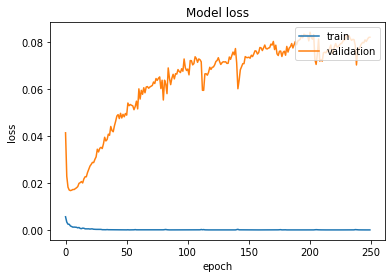

In [ ]:
optimizer_BGRU = torch.optim.Adam(model_BGRU.parameters(), lr=1e-3, weight_decay=1e-8) # L2 = weight_decay
model_run(model_BGRU, optimizer_BGRU)

## LSTM

Not like the RNN and GRU models, the LSTM model recieve two additional layers to his input:   
h0 - same as in RNN, the initial state of the short term memory cell  
c0 - initial state of the long term memory cell

In [ ]:
'''
Class LSTM
'''
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
    super(LSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    self.embeddings = Embedding(input_size, hidden_size, word_embeddings)
    self.lstm = nn.LSTM(input_size = input_size,
                      hidden_size = hidden_size,
                      num_layers = num_layers,
                      batch_first=True,
                      dropout = 0,
                      bidirectional=False
                      )
    ## input_shape to nn.RNN-> (batch_size, seq_length, input_size) 
    self.dropout = nn.Dropout(dropout)
    self.activation = nn.Tanh()
    # The last layer to compute the probabilities for the output classes
    self.final_layer = nn.Linear(in_features=hidden_size, out_features=num_classes)
  

  def forward(self, x_idx):
    x = self.embeddings(x_idx)
    # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to("cuda")
    # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to("cuda")
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    
    if torch.cuda.is_available():
        h0 = h0.to("cuda")
        c0 = c0.to("cuda")
    
    output, _ = self.lstm(x.float(), (h0,c0))

    output = self.dropout(output)
    output = self.activation(output)
    logits = self.final_layer(output)
    return logits

In [ ]:
# We initialize our model
model_LSTM = LSTM(input_size = WORD_DIM,
            hidden_size = 128,
            num_layers = 1,
            num_classes = len(MAPPING_NER_LABELS),
            dropout = 0.3
            )

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:00, 62.67it/s]
Val: 8it [00:00, 110.12it/s]
Test: 59it [00:00, 115.12it/s]


Train loss: 1.0789
Val   loss: 0.7461
Test  loss: 0.7397

Val   Macro F1: 0.0380
Test  Macro F1: 0.0373

Best Epoch: 0, best val macro F1: 0.0380, test macro F1: 0.0373


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:00, 62.16it/s]
Val: 8it [00:00, 113.97it/s]
Test: 59it [00:00, 106.81it/s]


Train loss: 0.6446
Val   loss: 0.5328
Test  loss: 0.5203

Val   Macro F1: 0.2127
Test  Macro F1: 0.2213

Best Epoch: 1, best val macro F1: 0.2127, test macro F1: 0.2213


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:00, 61.57it/s]
Val: 8it [00:00, 111.02it/s]
Test: 59it [00:00, 110.68it/s]


Train loss: 0.4807
Val   loss: 0.4350
Test  loss: 0.3994

Val   Macro F1: 0.2725
Test  Macro F1: 0.2857

Best Epoch: 2, best val macro F1: 0.2725, test macro F1: 0.2857


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:00, 62.78it/s]
Val: 8it [00:00, 109.67it/s]
Test: 59it [00:00, 108.33it/s]


Train loss: 0.3897
Val   loss: 0.3915
Test  loss: 0.3319

Val   Macro F1: 0.3154
Test  Macro F1: 0.3374

Best Epoch: 3, best val macro F1: 0.3154, test macro F1: 0.3374


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:00, 61.88it/s]
Val: 8it [00:00, 115.06it/s]
Test: 59it [00:00, 108.64it/s]


Train loss: 0.3347
Val   loss: 0.3773
Test  loss: 0.2915

Val   Macro F1: 0.3708
Test  Macro F1: 0.4079

Best Epoch: 4, best val macro F1: 0.3708, test macro F1: 0.4079


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:00, 62.18it/s]
Val: 8it [00:00, 111.90it/s]
Test: 59it [00:00, 109.33it/s]


Train loss: 0.2969
Val   loss: 0.3624
Test  loss: 0.2564

Val   Macro F1: 0.4192
Test  Macro F1: 0.4749

Best Epoch: 5, best val macro F1: 0.4192, test macro F1: 0.4749


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:00, 61.41it/s]
Val: 8it [00:00, 115.53it/s]
Test: 59it [00:00, 108.28it/s]


Train loss: 0.2685
Val   loss: 0.3583
Test  loss: 0.2325

Val   Macro F1: 0.4728
Test  Macro F1: 0.5601

Best Epoch: 6, best val macro F1: 0.4728, test macro F1: 0.5601


------------------------------------------------------------------------
Epoch: 7


Training: 59it [00:00, 61.64it/s]
Val: 8it [00:00, 111.15it/s]
Test: 59it [00:00, 111.80it/s]


Train loss: 0.2461
Val   loss: 0.3654
Test  loss: 0.2138

Val   Macro F1: 0.4694
Test  Macro F1: 0.5726

Best Epoch: 6, best val macro F1: 0.4728, test macro F1: 0.5601


------------------------------------------------------------------------
Epoch: 8


Training: 59it [00:00, 62.09it/s]
Val: 8it [00:00, 109.50it/s]
Test: 59it [00:00, 106.96it/s]


Train loss: 0.2272
Val   loss: 0.3750
Test  loss: 0.1972

Val   Macro F1: 0.4860
Test  Macro F1: 0.6029

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 9


Training: 59it [00:00, 61.91it/s]
Val: 8it [00:00, 117.40it/s]
Test: 59it [00:00, 106.36it/s]


Train loss: 0.2111
Val   loss: 0.3760
Test  loss: 0.1832

Val   Macro F1: 0.4459
Test  Macro F1: 0.5601

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 10


Training: 59it [00:00, 61.52it/s]
Val: 8it [00:00, 111.99it/s]
Test: 59it [00:00, 104.92it/s]


Train loss: 0.1979
Val   loss: 0.3801
Test  loss: 0.1738

Val   Macro F1: 0.4131
Test  Macro F1: 0.5188

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 11


Training: 59it [00:00, 61.81it/s]
Val: 8it [00:00, 114.80it/s]
Test: 59it [00:00, 108.54it/s]


Train loss: 0.1878
Val   loss: 0.3971
Test  loss: 0.1642

Val   Macro F1: 0.4485
Test  Macro F1: 0.5746

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 12


Training: 59it [00:00, 61.44it/s]
Val: 8it [00:00, 109.30it/s]
Test: 59it [00:00, 109.25it/s]


Train loss: 0.1771
Val   loss: 0.4119
Test  loss: 0.1538

Val   Macro F1: 0.4490
Test  Macro F1: 0.5836

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 13


Training: 59it [00:00, 63.06it/s]
Val: 8it [00:00, 112.53it/s]
Test: 59it [00:00, 111.31it/s]


Train loss: 0.1691
Val   loss: 0.4141
Test  loss: 0.1448

Val   Macro F1: 0.4557
Test  Macro F1: 0.6009

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 14


Training: 59it [00:00, 63.21it/s]
Val: 8it [00:00, 114.02it/s]
Test: 59it [00:00, 111.00it/s]


Train loss: 0.1611
Val   loss: 0.4108
Test  loss: 0.1369

Val   Macro F1: 0.4284
Test  Macro F1: 0.5596

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 15


Training: 59it [00:00, 62.24it/s]
Val: 8it [00:00, 107.51it/s]
Test: 59it [00:00, 108.54it/s]


Train loss: 0.1528
Val   loss: 0.4286
Test  loss: 0.1303

Val   Macro F1: 0.4596
Test  Macro F1: 0.6138

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 16


Training: 59it [00:00, 62.27it/s]
Val: 8it [00:00, 119.18it/s]
Test: 59it [00:00, 107.64it/s]


Train loss: 0.1465
Val   loss: 0.4424
Test  loss: 0.1292

Val   Macro F1: 0.4125
Test  Macro F1: 0.5523

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 17


Training: 59it [00:00, 62.78it/s]
Val: 8it [00:00, 111.25it/s]
Test: 59it [00:00, 107.99it/s]


Train loss: 0.1404
Val   loss: 0.4452
Test  loss: 0.1180

Val   Macro F1: 0.4100
Test  Macro F1: 0.5539

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 18


Training: 59it [00:00, 62.15it/s]
Val: 8it [00:00, 107.46it/s]
Test: 59it [00:00, 107.21it/s]


Train loss: 0.1344
Val   loss: 0.4635
Test  loss: 0.1123

Val   Macro F1: 0.4077
Test  Macro F1: 0.5681

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 19


Training: 59it [00:00, 62.30it/s]
Val: 8it [00:00, 103.22it/s]
Test: 59it [00:00, 107.76it/s]


Train loss: 0.1301
Val   loss: 0.4656
Test  loss: 0.1086

Val   Macro F1: 0.4016
Test  Macro F1: 0.5586

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 20


Training: 59it [00:00, 62.32it/s]
Val: 8it [00:00, 113.11it/s]
Test: 59it [00:00, 107.79it/s]


Train loss: 0.1231
Val   loss: 0.5008
Test  loss: 0.1040

Val   Macro F1: 0.4085
Test  Macro F1: 0.5894

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 21


Training: 59it [00:00, 62.17it/s]
Val: 8it [00:00, 111.04it/s]
Test: 59it [00:00, 107.61it/s]


Train loss: 0.1193
Val   loss: 0.4766
Test  loss: 0.1016

Val   Macro F1: 0.4057
Test  Macro F1: 0.5729

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 22


Training: 59it [00:00, 62.51it/s]
Val: 8it [00:00, 109.68it/s]
Test: 59it [00:00, 107.12it/s]


Train loss: 0.1138
Val   loss: 0.5161
Test  loss: 0.0950

Val   Macro F1: 0.4044
Test  Macro F1: 0.5931

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 23


Training: 59it [00:00, 63.05it/s]
Val: 8it [00:00, 110.10it/s]
Test: 59it [00:00, 106.71it/s]


Train loss: 0.1081
Val   loss: 0.5283
Test  loss: 0.0906

Val   Macro F1: 0.4088
Test  Macro F1: 0.5928

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 24


Training: 59it [00:00, 62.24it/s]
Val: 8it [00:00, 111.86it/s]
Test: 59it [00:00, 105.22it/s]


Train loss: 0.1048
Val   loss: 0.5370
Test  loss: 0.0860

Val   Macro F1: 0.3805
Test  Macro F1: 0.5730

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 25


Training: 59it [00:00, 61.67it/s]
Val: 8it [00:00, 116.35it/s]
Test: 59it [00:00, 107.65it/s]


Train loss: 0.1002
Val   loss: 0.5530
Test  loss: 0.0821

Val   Macro F1: 0.4085
Test  Macro F1: 0.6142

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 26


Training: 59it [00:00, 62.43it/s]
Val: 8it [00:00, 77.06it/s]
Test: 59it [00:00, 76.08it/s]


Train loss: 0.0993
Val   loss: 0.5465
Test  loss: 0.0812

Val   Macro F1: 0.3894
Test  Macro F1: 0.5907

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 27


Training: 59it [00:00, 59.45it/s]
Val: 8it [00:00, 111.34it/s]
Test: 59it [00:00, 106.39it/s]


Train loss: 0.0937
Val   loss: 0.5859
Test  loss: 0.0767

Val   Macro F1: 0.3517
Test  Macro F1: 0.5469

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 28


Training: 59it [00:00, 62.27it/s]
Val: 8it [00:00, 109.36it/s]
Test: 59it [00:00, 108.28it/s]


Train loss: 0.0885
Val   loss: 0.5846
Test  loss: 0.0728

Val   Macro F1: 0.3866
Test  Macro F1: 0.5927

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 29


Training: 59it [00:00, 62.80it/s]
Val: 8it [00:00, 111.90it/s]
Test: 59it [00:00, 105.95it/s]


Train loss: 0.0847
Val   loss: 0.6276
Test  loss: 0.0704

Val   Macro F1: 0.3764
Test  Macro F1: 0.5950

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 30


Training: 59it [00:00, 62.47it/s]
Val: 8it [00:00, 116.17it/s]
Test: 59it [00:00, 107.15it/s]


Train loss: 0.0819
Val   loss: 0.6111
Test  loss: 0.0649

Val   Macro F1: 0.3808
Test  Macro F1: 0.5970

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 31


Training: 59it [00:00, 62.42it/s]
Val: 8it [00:00, 110.30it/s]
Test: 59it [00:00, 106.09it/s]


Train loss: 0.0769
Val   loss: 0.6544
Test  loss: 0.0612

Val   Macro F1: 0.3505
Test  Macro F1: 0.5653

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 32


Training: 59it [00:00, 62.05it/s]
Val: 8it [00:00, 111.08it/s]
Test: 59it [00:00, 107.61it/s]


Train loss: 0.0756
Val   loss: 0.6350
Test  loss: 0.0618

Val   Macro F1: 0.3732
Test  Macro F1: 0.5830

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 33


Training: 59it [00:00, 62.20it/s]
Val: 8it [00:00, 111.56it/s]
Test: 59it [00:00, 107.40it/s]


Train loss: 0.0729
Val   loss: 0.6797
Test  loss: 0.0594

Val   Macro F1: 0.3544
Test  Macro F1: 0.5673

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 34


Training: 59it [00:00, 62.62it/s]
Val: 8it [00:00, 110.99it/s]
Test: 59it [00:00, 106.05it/s]


Train loss: 0.0706
Val   loss: 0.6947
Test  loss: 0.0550

Val   Macro F1: 0.3347
Test  Macro F1: 0.5606

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 35


Training: 59it [00:00, 62.07it/s]
Val: 8it [00:00, 106.84it/s]
Test: 59it [00:00, 107.45it/s]


Train loss: 0.0678
Val   loss: 0.6982
Test  loss: 0.0532

Val   Macro F1: 0.3338
Test  Macro F1: 0.5548

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 36


Training: 59it [00:00, 62.21it/s]
Val: 8it [00:00, 113.47it/s]
Test: 59it [00:00, 106.37it/s]


Train loss: 0.0651
Val   loss: 0.7329
Test  loss: 0.0497

Val   Macro F1: 0.3389
Test  Macro F1: 0.5655

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 37


Training: 59it [00:00, 62.27it/s]
Val: 8it [00:00, 112.97it/s]
Test: 59it [00:00, 106.93it/s]


Train loss: 0.0619
Val   loss: 0.7309
Test  loss: 0.0482

Val   Macro F1: 0.3366
Test  Macro F1: 0.5641

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 38


Training: 59it [00:00, 62.60it/s]
Val: 8it [00:00, 112.96it/s]
Test: 59it [00:00, 107.11it/s]


Train loss: 0.0605
Val   loss: 0.7440
Test  loss: 0.0469

Val   Macro F1: 0.3363
Test  Macro F1: 0.5748

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 39


Training: 59it [00:00, 62.77it/s]
Val: 8it [00:00, 112.66it/s]
Test: 59it [00:00, 104.61it/s]


Train loss: 0.0579
Val   loss: 0.7351
Test  loss: 0.0480

Val   Macro F1: 0.3135
Test  Macro F1: 0.5411

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 40


Training: 59it [00:00, 62.52it/s]
Val: 8it [00:00, 110.46it/s]
Test: 59it [00:00, 107.42it/s]


Train loss: 0.0558
Val   loss: 0.7682
Test  loss: 0.0431

Val   Macro F1: 0.3588
Test  Macro F1: 0.6235

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 41


Training: 59it [00:00, 61.62it/s]
Val: 8it [00:00, 111.85it/s]
Test: 59it [00:00, 107.13it/s]


Train loss: 0.0532
Val   loss: 0.7908
Test  loss: 0.0415

Val   Macro F1: 0.3301
Test  Macro F1: 0.5722

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 42


Training: 59it [00:00, 62.50it/s]
Val: 8it [00:00, 111.74it/s]
Test: 59it [00:00, 108.01it/s]


Train loss: 0.0526
Val   loss: 0.8201
Test  loss: 0.0402

Val   Macro F1: 0.3333
Test  Macro F1: 0.6046

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 43


Training: 59it [00:00, 62.18it/s]
Val: 8it [00:00, 109.13it/s]
Test: 59it [00:00, 105.71it/s]


Train loss: 0.0506
Val   loss: 0.8181
Test  loss: 0.0376

Val   Macro F1: 0.3365
Test  Macro F1: 0.5854

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 44


Training: 59it [00:00, 62.84it/s]
Val: 8it [00:00, 113.34it/s]
Test: 59it [00:00, 106.34it/s]


Train loss: 0.0480
Val   loss: 0.8341
Test  loss: 0.0357

Val   Macro F1: 0.3323
Test  Macro F1: 0.5850

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 45


Training: 59it [00:00, 62.80it/s]
Val: 8it [00:00, 110.31it/s]
Test: 59it [00:00, 106.79it/s]


Train loss: 0.0450
Val   loss: 0.8580
Test  loss: 0.0333

Val   Macro F1: 0.3159
Test  Macro F1: 0.5712

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 46


Training: 59it [00:00, 62.42it/s]
Val: 8it [00:00, 111.02it/s]
Test: 59it [00:00, 103.69it/s]


Train loss: 0.0434
Val   loss: 0.8751
Test  loss: 0.0323

Val   Macro F1: 0.3104
Test  Macro F1: 0.5705

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 47


Training: 59it [00:00, 62.12it/s]
Val: 8it [00:00, 106.91it/s]
Test: 59it [00:00, 105.86it/s]


Train loss: 0.0417
Val   loss: 0.8424
Test  loss: 0.0394

Val   Macro F1: 0.3225
Test  Macro F1: 0.5666

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 48


Training: 59it [00:00, 62.65it/s]
Val: 8it [00:00, 114.79it/s]
Test: 59it [00:00, 106.18it/s]


Train loss: 0.0460
Val   loss: 0.8783
Test  loss: 0.0335

Val   Macro F1: 0.3283
Test  Macro F1: 0.6039

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 49


Training: 59it [00:00, 62.36it/s]
Val: 8it [00:00, 108.17it/s]
Test: 59it [00:00, 107.20it/s]


Train loss: 0.0432
Val   loss: 0.9088
Test  loss: 0.0318

Val   Macro F1: 0.3304
Test  Macro F1: 0.5979

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 50


Training: 59it [00:00, 62.30it/s]
Val: 8it [00:00, 101.68it/s]
Test: 59it [00:00, 107.25it/s]


Train loss: 0.0407
Val   loss: 0.8995
Test  loss: 0.0293

Val   Macro F1: 0.3144
Test  Macro F1: 0.5767

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 51


Training: 59it [00:00, 62.90it/s]
Val: 8it [00:00, 111.78it/s]
Test: 59it [00:00, 106.57it/s]


Train loss: 0.0386
Val   loss: 0.9036
Test  loss: 0.0301

Val   Macro F1: 0.3133
Test  Macro F1: 0.5719

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 52


Training: 59it [00:00, 62.30it/s]
Val: 8it [00:00, 108.66it/s]
Test: 59it [00:00, 106.14it/s]


Train loss: 0.0370
Val   loss: 0.9263
Test  loss: 0.0268

Val   Macro F1: 0.3335
Test  Macro F1: 0.6107

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 53


Training: 59it [00:00, 61.92it/s]
Val: 8it [00:00, 109.66it/s]
Test: 59it [00:00, 106.43it/s]


Train loss: 0.0359
Val   loss: 0.9438
Test  loss: 0.0277

Val   Macro F1: 0.3130
Test  Macro F1: 0.5828

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 54


Training: 59it [00:00, 62.03it/s]
Val: 8it [00:00, 110.19it/s]
Test: 59it [00:00, 106.79it/s]


Train loss: 0.0351
Val   loss: 0.9371
Test  loss: 0.0267

Val   Macro F1: 0.3170
Test  Macro F1: 0.5875

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 55


Training: 59it [00:00, 61.66it/s]
Val: 8it [00:00, 110.28it/s]
Test: 59it [00:00, 105.19it/s]


Train loss: 0.0340
Val   loss: 0.9742
Test  loss: 0.0243

Val   Macro F1: 0.3119
Test  Macro F1: 0.5833

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 56


Training: 59it [00:00, 62.62it/s]
Val: 8it [00:00, 108.37it/s]
Test: 59it [00:00, 107.04it/s]


Train loss: 0.0326
Val   loss: 0.9962
Test  loss: 0.0236

Val   Macro F1: 0.3286
Test  Macro F1: 0.6132

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 57


Training: 59it [00:00, 62.09it/s]
Val: 8it [00:00, 101.39it/s]
Test: 59it [00:00, 106.15it/s]


Train loss: 0.0322
Val   loss: 0.9895
Test  loss: 0.0226

Val   Macro F1: 0.3179
Test  Macro F1: 0.5960

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 58


Training: 59it [00:00, 62.34it/s]
Val: 8it [00:00, 107.19it/s]
Test: 59it [00:00, 102.66it/s]


Train loss: 0.0353
Val   loss: 0.9479
Test  loss: 0.0495

Val   Macro F1: 0.3103
Test  Macro F1: 0.5648

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 59


Training: 59it [00:00, 62.28it/s]
Val: 8it [00:00, 107.28it/s]
Test: 59it [00:00, 104.45it/s]


Train loss: 0.0507
Val   loss: 0.9223
Test  loss: 0.0300

Val   Macro F1: 0.3116
Test  Macro F1: 0.5649

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 60


Training: 59it [00:00, 62.55it/s]
Val: 8it [00:00, 115.78it/s]
Test: 59it [00:00, 104.91it/s]


Train loss: 0.0354
Val   loss: 0.9724
Test  loss: 0.0241

Val   Macro F1: 0.3177
Test  Macro F1: 0.5991

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 61


Training: 59it [00:00, 62.64it/s]
Val: 8it [00:00, 105.83it/s]
Test: 59it [00:00, 106.04it/s]


Train loss: 0.0318
Val   loss: 0.9993
Test  loss: 0.0210

Val   Macro F1: 0.3198
Test  Macro F1: 0.6044

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 62


Training: 59it [00:00, 61.61it/s]
Val: 8it [00:00, 109.49it/s]
Test: 59it [00:00, 106.00it/s]


Train loss: 0.0285
Val   loss: 1.0022
Test  loss: 0.0198

Val   Macro F1: 0.3203
Test  Macro F1: 0.6025

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 63


Training: 59it [00:00, 62.03it/s]
Val: 8it [00:00, 109.79it/s]
Test: 59it [00:00, 106.15it/s]


Train loss: 0.0276
Val   loss: 1.0482
Test  loss: 0.0191

Val   Macro F1: 0.3201
Test  Macro F1: 0.6085

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 64


Training: 59it [00:00, 61.08it/s]
Val: 8it [00:00, 111.61it/s]
Test: 59it [00:00, 105.97it/s]


Train loss: 0.0262
Val   loss: 1.0750
Test  loss: 0.0191

Val   Macro F1: 0.3113
Test  Macro F1: 0.6021

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 65


Training: 59it [00:00, 61.92it/s]
Val: 8it [00:00, 108.97it/s]
Test: 59it [00:00, 104.74it/s]


Train loss: 0.0253
Val   loss: 1.0677
Test  loss: 0.0176

Val   Macro F1: 0.3026
Test  Macro F1: 0.5903

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 66


Training: 59it [00:00, 62.66it/s]
Val: 8it [00:00, 104.64it/s]
Test: 59it [00:00, 105.21it/s]


Train loss: 0.0247
Val   loss: 1.0804
Test  loss: 0.0173

Val   Macro F1: 0.3141
Test  Macro F1: 0.6045

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 67


Training: 59it [00:00, 62.86it/s]
Val: 8it [00:00, 106.11it/s]
Test: 59it [00:00, 102.37it/s]


Train loss: 0.0243
Val   loss: 1.1152
Test  loss: 0.0174

Val   Macro F1: 0.3000
Test  Macro F1: 0.5774

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 68


Training: 59it [00:00, 62.06it/s]
Val: 8it [00:00, 107.92it/s]
Test: 59it [00:00, 103.50it/s]


Train loss: 0.0242
Val   loss: 1.0938
Test  loss: 0.0166

Val   Macro F1: 0.3076
Test  Macro F1: 0.5999

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 69


Training: 59it [00:00, 62.64it/s]
Val: 8it [00:00, 102.22it/s]
Test: 59it [00:00, 105.88it/s]


Train loss: 0.0230
Val   loss: 1.1270
Test  loss: 0.0163

Val   Macro F1: 0.3162
Test  Macro F1: 0.6090

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 70


Training: 59it [00:00, 61.71it/s]
Val: 8it [00:00, 111.33it/s]
Test: 59it [00:00, 103.27it/s]


Train loss: 0.0236
Val   loss: 1.1403
Test  loss: 0.0163

Val   Macro F1: 0.3178
Test  Macro F1: 0.6038

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 71


Training: 59it [00:00, 62.04it/s]
Val: 8it [00:00, 107.59it/s]
Test: 59it [00:00, 104.39it/s]


Train loss: 0.0237
Val   loss: 1.1131
Test  loss: 0.0164

Val   Macro F1: 0.3015
Test  Macro F1: 0.5894

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 72


Training: 59it [00:00, 61.88it/s]
Val: 8it [00:00, 107.80it/s]
Test: 59it [00:00, 105.76it/s]


Train loss: 0.0247
Val   loss: 1.1619
Test  loss: 0.0185

Val   Macro F1: 0.2981
Test  Macro F1: 0.5936

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 73


Training: 59it [00:00, 62.54it/s]
Val: 8it [00:00, 109.76it/s]
Test: 59it [00:00, 106.26it/s]


Train loss: 0.0273
Val   loss: 1.1609
Test  loss: 0.0187

Val   Macro F1: 0.3110
Test  Macro F1: 0.5976

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 74


Training: 59it [00:00, 62.51it/s]
Val: 8it [00:00, 108.09it/s]
Test: 59it [00:00, 105.34it/s]


Train loss: 0.0297
Val   loss: 1.1400
Test  loss: 0.0219

Val   Macro F1: 0.3037
Test  Macro F1: 0.5774

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 75


Training: 59it [00:00, 62.95it/s]
Val: 8it [00:00, 107.03it/s]
Test: 59it [00:00, 104.98it/s]


Train loss: 0.0272
Val   loss: 1.1553
Test  loss: 0.0172

Val   Macro F1: 0.3021
Test  Macro F1: 0.5980

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 76


Training: 59it [00:00, 62.50it/s]
Val: 8it [00:00, 108.29it/s]
Test: 59it [00:00, 106.65it/s]


Train loss: 0.0233
Val   loss: 1.1428
Test  loss: 0.0149

Val   Macro F1: 0.2973
Test  Macro F1: 0.5876

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 77


Training: 59it [00:00, 62.10it/s]
Val: 8it [00:00, 109.49it/s]
Test: 59it [00:00, 105.11it/s]


Train loss: 0.0241
Val   loss: 1.2145
Test  loss: 0.0162

Val   Macro F1: 0.3043
Test  Macro F1: 0.5932

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 78


Training: 59it [00:00, 61.70it/s]
Val: 8it [00:00, 108.03it/s]
Test: 59it [00:00, 105.10it/s]


Train loss: 0.0220
Val   loss: 1.1219
Test  loss: 0.0156

Val   Macro F1: 0.3041
Test  Macro F1: 0.5900

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 79


Training: 59it [00:00, 62.56it/s]
Val: 8it [00:00, 111.13it/s]
Test: 59it [00:00, 103.99it/s]


Train loss: 0.0202
Val   loss: 1.1825
Test  loss: 0.0132

Val   Macro F1: 0.3090
Test  Macro F1: 0.6053

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 80


Training: 59it [00:00, 62.18it/s]
Val: 8it [00:00, 106.39it/s]
Test: 59it [00:00, 104.07it/s]


Train loss: 0.0192
Val   loss: 1.2160
Test  loss: 0.0130

Val   Macro F1: 0.3066
Test  Macro F1: 0.6064

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 81


Training: 59it [00:00, 62.59it/s]
Val: 8it [00:00, 111.95it/s]
Test: 59it [00:00, 105.97it/s]


Train loss: 0.0189
Val   loss: 1.1825
Test  loss: 0.0126

Val   Macro F1: 0.2969
Test  Macro F1: 0.5853

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 82


Training: 59it [00:00, 62.84it/s]
Val: 8it [00:00, 110.45it/s]
Test: 59it [00:00, 104.73it/s]


Train loss: 0.0185
Val   loss: 1.2419
Test  loss: 0.0126

Val   Macro F1: 0.2890
Test  Macro F1: 0.5813

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 83


Training: 59it [00:00, 61.50it/s]
Val: 8it [00:00, 108.62it/s]
Test: 59it [00:00, 105.37it/s]


Train loss: 0.0184
Val   loss: 1.2183
Test  loss: 0.0125

Val   Macro F1: 0.3069
Test  Macro F1: 0.6000

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 84


Training: 59it [00:00, 62.43it/s]
Val: 8it [00:00, 108.02it/s]
Test: 59it [00:00, 105.84it/s]


Train loss: 0.0195
Val   loss: 1.2129
Test  loss: 0.0134

Val   Macro F1: 0.3153
Test  Macro F1: 0.6018

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 85


Training: 59it [00:00, 61.91it/s]
Val: 8it [00:00, 104.14it/s]
Test: 59it [00:00, 105.86it/s]


Train loss: 0.0208
Val   loss: 1.2447
Test  loss: 0.0156

Val   Macro F1: 0.3005
Test  Macro F1: 0.5980

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 86


Training: 59it [00:00, 61.45it/s]
Val: 8it [00:00, 103.29it/s]
Test: 59it [00:00, 106.08it/s]


Train loss: 0.0215
Val   loss: 1.1923
Test  loss: 0.0152

Val   Macro F1: 0.3003
Test  Macro F1: 0.5801

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 87


Training: 59it [00:00, 62.44it/s]
Val: 8it [00:00, 110.05it/s]
Test: 59it [00:00, 104.23it/s]


Train loss: 0.0200
Val   loss: 1.2145
Test  loss: 0.0127

Val   Macro F1: 0.3158
Test  Macro F1: 0.6098

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 88


Training: 59it [00:00, 61.50it/s]
Val: 8it [00:00, 110.14it/s]
Test: 59it [00:00, 104.92it/s]


Train loss: 0.0179
Val   loss: 1.2443
Test  loss: 0.0113

Val   Macro F1: 0.3005
Test  Macro F1: 0.5958

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 89


Training: 59it [00:00, 62.35it/s]
Val: 8it [00:00, 107.52it/s]
Test: 59it [00:00, 106.41it/s]


Train loss: 0.0171
Val   loss: 1.2616
Test  loss: 0.0111

Val   Macro F1: 0.3008
Test  Macro F1: 0.6011

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 90


Training: 59it [00:00, 62.20it/s]
Val: 8it [00:00, 110.32it/s]
Test: 59it [00:00, 106.94it/s]


Train loss: 0.0163
Val   loss: 1.2587
Test  loss: 0.0108

Val   Macro F1: 0.3057
Test  Macro F1: 0.6011

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 91


Training: 59it [00:00, 62.11it/s]
Val: 8it [00:00, 110.03it/s]
Test: 59it [00:00, 103.50it/s]


Train loss: 0.0172
Val   loss: 1.2559
Test  loss: 0.0119

Val   Macro F1: 0.2981
Test  Macro F1: 0.5848

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 92


Training: 59it [00:00, 61.79it/s]
Val: 8it [00:00, 109.90it/s]
Test: 59it [00:00, 104.83it/s]


Train loss: 0.0174
Val   loss: 1.2969
Test  loss: 0.0109

Val   Macro F1: 0.2995
Test  Macro F1: 0.6070

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 93


Training: 59it [00:00, 61.21it/s]
Val: 8it [00:00, 109.77it/s]
Test: 59it [00:00, 105.85it/s]


Train loss: 0.0163
Val   loss: 1.3081
Test  loss: 0.0103

Val   Macro F1: 0.3076
Test  Macro F1: 0.6093

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 94


Training: 59it [00:00, 61.48it/s]
Val: 8it [00:00, 111.84it/s]
Test: 59it [00:00, 102.82it/s]


Train loss: 0.0161
Val   loss: 1.3048
Test  loss: 0.0109

Val   Macro F1: 0.2908
Test  Macro F1: 0.5797

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 95


Training: 59it [00:00, 61.61it/s]
Val: 8it [00:00, 111.28it/s]
Test: 59it [00:00, 106.17it/s]


Train loss: 0.0155
Val   loss: 1.3440
Test  loss: 0.0104

Val   Macro F1: 0.3112
Test  Macro F1: 0.6186

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 96


Training: 59it [00:00, 62.10it/s]
Val: 8it [00:00, 108.24it/s]
Test: 59it [00:00, 103.89it/s]


Train loss: 0.0153
Val   loss: 1.3537
Test  loss: 0.0100

Val   Macro F1: 0.3057
Test  Macro F1: 0.6071

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 97


Training: 59it [00:00, 61.18it/s]
Val: 8it [00:00, 111.03it/s]
Test: 59it [00:00, 105.74it/s]


Train loss: 0.0162
Val   loss: 1.3085
Test  loss: 0.0108

Val   Macro F1: 0.3015
Test  Macro F1: 0.6004

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 98


Training: 59it [00:00, 61.78it/s]
Val: 8it [00:00, 103.37it/s]
Test: 59it [00:00, 104.47it/s]


Train loss: 0.0158
Val   loss: 1.3054
Test  loss: 0.0160

Val   Macro F1: 0.3063
Test  Macro F1: 0.6017

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 99


Training: 59it [00:00, 61.41it/s]
Val: 8it [00:00, 106.14it/s]
Test: 59it [00:00, 104.71it/s]


Train loss: 0.0212
Val   loss: 1.2239
Test  loss: 0.0227

Val   Macro F1: 0.3210
Test  Macro F1: 0.6042

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 100


Training: 59it [00:00, 62.03it/s]
Val: 8it [00:00, 108.99it/s]
Test: 59it [00:00, 106.11it/s]


Train loss: 0.0300
Val   loss: 1.2704
Test  loss: 0.0159

Val   Macro F1: 0.3085
Test  Macro F1: 0.6053

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 101


Training: 59it [00:00, 62.91it/s]
Val: 8it [00:00, 110.45it/s]
Test: 59it [00:00, 105.67it/s]


Train loss: 0.0214
Val   loss: 1.2938
Test  loss: 0.0111

Val   Macro F1: 0.3083
Test  Macro F1: 0.6138

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 102


Training: 59it [00:00, 62.96it/s]
Val: 8it [00:00, 111.65it/s]
Test: 59it [00:00, 106.89it/s]


Train loss: 0.0166
Val   loss: 1.3262
Test  loss: 0.0100

Val   Macro F1: 0.3033
Test  Macro F1: 0.6115

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 103


Training: 59it [00:00, 61.95it/s]
Val: 8it [00:00, 100.89it/s]
Test: 59it [00:00, 106.49it/s]


Train loss: 0.0148
Val   loss: 1.3234
Test  loss: 0.0093

Val   Macro F1: 0.2984
Test  Macro F1: 0.6061

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 104


Training: 59it [00:00, 62.53it/s]
Val: 8it [00:00, 105.39it/s]
Test: 59it [00:00, 106.01it/s]


Train loss: 0.0153
Val   loss: 1.3071
Test  loss: 0.0092

Val   Macro F1: 0.3128
Test  Macro F1: 0.6169

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 105


Training: 59it [00:00, 61.36it/s]
Val: 8it [00:00, 108.57it/s]
Test: 59it [00:00, 106.07it/s]


Train loss: 0.0139
Val   loss: 1.3398
Test  loss: 0.0086

Val   Macro F1: 0.2955
Test  Macro F1: 0.5976

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 106


Training: 59it [00:00, 61.93it/s]
Val: 8it [00:00, 109.19it/s]
Test: 59it [00:00, 104.40it/s]


Train loss: 0.0132
Val   loss: 1.3557
Test  loss: 0.0089

Val   Macro F1: 0.3098
Test  Macro F1: 0.6203

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 107


Training: 59it [00:00, 61.62it/s]
Val: 8it [00:00, 108.21it/s]
Test: 59it [00:00, 106.33it/s]


Train loss: 0.0127
Val   loss: 1.3630
Test  loss: 0.0083

Val   Macro F1: 0.3056
Test  Macro F1: 0.6090

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 108


Training: 59it [00:00, 61.91it/s]
Val: 8it [00:00, 102.62it/s]
Test: 59it [00:00, 105.23it/s]


Train loss: 0.0126
Val   loss: 1.4036
Test  loss: 0.0084

Val   Macro F1: 0.3024
Test  Macro F1: 0.6102

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 109


Training: 59it [00:00, 62.63it/s]
Val: 8it [00:00, 110.16it/s]
Test: 59it [00:00, 104.05it/s]


Train loss: 0.0124
Val   loss: 1.3836
Test  loss: 0.0083

Val   Macro F1: 0.3087
Test  Macro F1: 0.6144

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 110


Training: 59it [00:00, 61.93it/s]
Val: 8it [00:00, 109.94it/s]
Test: 59it [00:00, 107.43it/s]


Train loss: 0.0124
Val   loss: 1.4223
Test  loss: 0.0079

Val   Macro F1: 0.2982
Test  Macro F1: 0.6128

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 111


Training: 59it [00:00, 61.90it/s]
Val: 8it [00:00, 95.62it/s]
Test: 59it [00:00, 97.69it/s]


Train loss: 0.0133
Val   loss: 1.4084
Test  loss: 0.0082

Val   Macro F1: 0.2859
Test  Macro F1: 0.5835

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 112


Training: 59it [00:00, 62.12it/s]
Val: 8it [00:00, 110.93it/s]
Test: 59it [00:00, 104.61it/s]


Train loss: 0.0131
Val   loss: 1.4228
Test  loss: 0.0087

Val   Macro F1: 0.3018
Test  Macro F1: 0.6116

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 113


Training: 59it [00:00, 62.26it/s]
Val: 8it [00:00, 103.90it/s]
Test: 59it [00:00, 106.20it/s]


Train loss: 0.0165
Val   loss: 1.3871
Test  loss: 0.0107

Val   Macro F1: 0.3027
Test  Macro F1: 0.6114

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 114


Training: 59it [00:00, 62.60it/s]
Val: 8it [00:00, 109.38it/s]
Test: 59it [00:00, 105.39it/s]


Train loss: 0.0166
Val   loss: 1.3898
Test  loss: 0.0103

Val   Macro F1: 0.2938
Test  Macro F1: 0.5990

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 115


Training: 59it [00:00, 63.03it/s]
Val: 8it [00:00, 107.16it/s]
Test: 59it [00:00, 105.41it/s]


Train loss: 0.0153
Val   loss: 1.3907
Test  loss: 0.0093

Val   Macro F1: 0.2943
Test  Macro F1: 0.6050

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 116


Training: 59it [00:00, 62.32it/s]
Val: 8it [00:00, 107.57it/s]
Test: 59it [00:00, 104.99it/s]


Train loss: 0.0139
Val   loss: 1.4168
Test  loss: 0.0083

Val   Macro F1: 0.3076
Test  Macro F1: 0.6223

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 117


Training: 59it [00:00, 61.89it/s]
Val: 8it [00:00, 106.41it/s]
Test: 59it [00:00, 105.98it/s]


Train loss: 0.0133
Val   loss: 1.3977
Test  loss: 0.0081

Val   Macro F1: 0.3063
Test  Macro F1: 0.6157

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 118


Training: 59it [00:00, 61.57it/s]
Val: 8it [00:00, 106.59it/s]
Test: 59it [00:00, 102.12it/s]


Train loss: 0.0119
Val   loss: 1.4569
Test  loss: 0.0075

Val   Macro F1: 0.3052
Test  Macro F1: 0.6267

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 119


Training: 59it [00:00, 61.34it/s]
Val: 8it [00:00, 105.90it/s]
Test: 59it [00:00, 102.69it/s]


Train loss: 0.0119
Val   loss: 1.4336
Test  loss: 0.0076

Val   Macro F1: 0.2940
Test  Macro F1: 0.6059

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 120


Training: 59it [00:00, 62.27it/s]
Val: 8it [00:00, 110.11it/s]
Test: 59it [00:00, 104.06it/s]


Train loss: 0.0161
Val   loss: 1.3540
Test  loss: 0.0124

Val   Macro F1: 0.3154
Test  Macro F1: 0.6171

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 121


Training: 59it [00:00, 62.04it/s]
Val: 8it [00:00, 105.01it/s]
Test: 59it [00:00, 104.70it/s]


Train loss: 0.0286
Val   loss: 1.3009
Test  loss: 0.0177

Val   Macro F1: 0.3154
Test  Macro F1: 0.5944

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 122


Training: 59it [00:00, 62.13it/s]
Val: 8it [00:00, 110.61it/s]
Test: 59it [00:00, 105.19it/s]


Train loss: 0.0227
Val   loss: 1.3660
Test  loss: 0.0119

Val   Macro F1: 0.3025
Test  Macro F1: 0.6093

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 123


Training: 59it [00:00, 61.33it/s]
Val: 8it [00:00, 111.46it/s]
Test: 59it [00:00, 104.03it/s]


Train loss: 0.0169
Val   loss: 1.3163
Test  loss: 0.0094

Val   Macro F1: 0.3069
Test  Macro F1: 0.6068

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 124


Training: 59it [00:00, 61.97it/s]
Val: 8it [00:00, 106.94it/s]
Test: 59it [00:00, 103.26it/s]


Train loss: 0.0135
Val   loss: 1.3747
Test  loss: 0.0079

Val   Macro F1: 0.3099
Test  Macro F1: 0.6191

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 125


Training: 59it [00:00, 62.64it/s]
Val: 8it [00:00, 112.04it/s]
Test: 59it [00:00, 106.19it/s]


Train loss: 0.0119
Val   loss: 1.4028
Test  loss: 0.0075

Val   Macro F1: 0.3006
Test  Macro F1: 0.6196

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 126


Training: 59it [00:00, 62.61it/s]
Val: 8it [00:00, 110.13it/s]
Test: 59it [00:00, 104.75it/s]


Train loss: 0.0114
Val   loss: 1.4191
Test  loss: 0.0072

Val   Macro F1: 0.3088
Test  Macro F1: 0.6161

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 127


Training: 59it [00:00, 61.76it/s]
Val: 8it [00:00, 109.26it/s]
Test: 59it [00:00, 106.08it/s]


Train loss: 0.0111
Val   loss: 1.4085
Test  loss: 0.0072

Val   Macro F1: 0.3020
Test  Macro F1: 0.6149

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 128


Training: 59it [00:00, 61.74it/s]
Val: 8it [00:00, 109.82it/s]
Test: 59it [00:00, 103.96it/s]


Train loss: 0.0109
Val   loss: 1.4545
Test  loss: 0.0069

Val   Macro F1: 0.2945
Test  Macro F1: 0.5972

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 129


Training: 59it [00:00, 62.48it/s]
Val: 8it [00:00, 106.53it/s]
Test: 59it [00:00, 105.22it/s]


Train loss: 0.0106
Val   loss: 1.4723
Test  loss: 0.0067

Val   Macro F1: 0.3013
Test  Macro F1: 0.6169

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 130


Training: 59it [00:00, 62.35it/s]
Val: 8it [00:00, 96.50it/s]
Test: 59it [00:00, 105.05it/s]


Train loss: 0.0102
Val   loss: 1.4859
Test  loss: 0.0067

Val   Macro F1: 0.2986
Test  Macro F1: 0.6137

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 131


Training: 59it [00:00, 62.24it/s]
Val: 8it [00:00, 113.55it/s]
Test: 59it [00:00, 105.30it/s]


Train loss: 0.0102
Val   loss: 1.4951
Test  loss: 0.0067

Val   Macro F1: 0.2999
Test  Macro F1: 0.6173

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 132


Training: 59it [00:00, 61.53it/s]
Val: 8it [00:00, 110.46it/s]
Test: 59it [00:00, 105.73it/s]


Train loss: 0.0103
Val   loss: 1.4752
Test  loss: 0.0067

Val   Macro F1: 0.2990
Test  Macro F1: 0.6052

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 133


Training: 59it [00:00, 61.91it/s]
Val: 8it [00:00, 104.55it/s]
Test: 59it [00:00, 105.11it/s]


Train loss: 0.0102
Val   loss: 1.4787
Test  loss: 0.0067

Val   Macro F1: 0.3030
Test  Macro F1: 0.6162

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 134


Training: 59it [00:00, 61.46it/s]
Val: 8it [00:00, 110.13it/s]
Test: 59it [00:00, 106.66it/s]


Train loss: 0.0102
Val   loss: 1.5177
Test  loss: 0.0065

Val   Macro F1: 0.3024
Test  Macro F1: 0.6193

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 135


Training: 59it [00:00, 61.66it/s]
Val: 8it [00:00, 103.36it/s]
Test: 59it [00:00, 103.29it/s]


Train loss: 0.0100
Val   loss: 1.4973
Test  loss: 0.0065

Val   Macro F1: 0.2961
Test  Macro F1: 0.6133

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 136


Training: 59it [00:00, 61.78it/s]
Val: 8it [00:00, 102.75it/s]
Test: 59it [00:00, 104.16it/s]


Train loss: 0.0098
Val   loss: 1.5724
Test  loss: 0.0066

Val   Macro F1: 0.2955
Test  Macro F1: 0.6228

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 137


Training: 59it [00:00, 61.95it/s]
Val: 8it [00:00, 100.56it/s]
Test: 59it [00:00, 106.42it/s]


Train loss: 0.0100
Val   loss: 1.5015
Test  loss: 0.0066

Val   Macro F1: 0.3045
Test  Macro F1: 0.6220

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 138


Training: 59it [00:00, 62.16it/s]
Val: 8it [00:00, 109.58it/s]
Test: 59it [00:00, 105.37it/s]


Train loss: 0.0101
Val   loss: 1.5216
Test  loss: 0.0067

Val   Macro F1: 0.3043
Test  Macro F1: 0.6242

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 139


Training: 59it [00:00, 61.87it/s]
Val: 8it [00:00, 109.73it/s]
Test: 59it [00:00, 104.43it/s]


Train loss: 0.0108
Val   loss: 1.5968
Test  loss: 0.0092

Val   Macro F1: 0.3008
Test  Macro F1: 0.6196

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 140


Training: 59it [00:00, 62.61it/s]
Val: 8it [00:00, 107.14it/s]
Test: 59it [00:00, 104.10it/s]


Train loss: 0.0230
Val   loss: 1.4373
Test  loss: 0.0146

Val   Macro F1: 0.2785
Test  Macro F1: 0.5833

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 141


Training: 59it [00:00, 62.22it/s]
Val: 8it [00:00, 110.88it/s]
Test: 59it [00:00, 104.67it/s]


Train loss: 0.0198
Val   loss: 1.4904
Test  loss: 0.0116

Val   Macro F1: 0.3055
Test  Macro F1: 0.6193

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 142


Training: 59it [00:00, 61.74it/s]
Val: 8it [00:00, 111.71it/s]
Test: 59it [00:00, 105.66it/s]


Train loss: 0.0188
Val   loss: 1.4065
Test  loss: 0.0120

Val   Macro F1: 0.2956
Test  Macro F1: 0.5860

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 143


Training: 59it [00:00, 62.54it/s]
Val: 8it [00:00, 108.08it/s]
Test: 59it [00:00, 105.03it/s]


Train loss: 0.0152
Val   loss: 1.4224
Test  loss: 0.0105

Val   Macro F1: 0.3159
Test  Macro F1: 0.6257

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 144


Training: 59it [00:00, 61.94it/s]
Val: 8it [00:00, 107.42it/s]
Test: 59it [00:00, 106.70it/s]


Train loss: 0.0141
Val   loss: 1.4827
Test  loss: 0.0078

Val   Macro F1: 0.3251
Test  Macro F1: 0.6469

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 145


Training: 59it [00:00, 62.75it/s]
Val: 8it [00:00, 113.03it/s]
Test: 59it [00:00, 105.82it/s]


Train loss: 0.0115
Val   loss: 1.4693
Test  loss: 0.0069

Val   Macro F1: 0.3065
Test  Macro F1: 0.6195

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 146


Training: 59it [00:00, 62.62it/s]
Val: 8it [00:00, 111.41it/s]
Test: 59it [00:00, 105.92it/s]


Train loss: 0.0110
Val   loss: 1.4587
Test  loss: 0.0066

Val   Macro F1: 0.3204
Test  Macro F1: 0.6344

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 147


Training: 59it [00:00, 62.96it/s]
Val: 8it [00:00, 101.61it/s]
Test: 59it [00:00, 106.66it/s]


Train loss: 0.0102
Val   loss: 1.4903
Test  loss: 0.0063

Val   Macro F1: 0.3118
Test  Macro F1: 0.6309

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 148


Training: 59it [00:00, 62.81it/s]
Val: 8it [00:00, 110.48it/s]
Test: 59it [00:00, 105.86it/s]


Train loss: 0.0096
Val   loss: 1.5106
Test  loss: 0.0062

Val   Macro F1: 0.3050
Test  Macro F1: 0.6274

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 149


Training: 59it [00:00, 62.34it/s]
Val: 8it [00:00, 109.56it/s]
Test: 59it [00:00, 106.50it/s]


Train loss: 0.0095
Val   loss: 1.5110
Test  loss: 0.0062

Val   Macro F1: 0.3043
Test  Macro F1: 0.6251

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 150


Training: 59it [00:00, 62.11it/s]
Val: 8it [00:00, 107.43it/s]
Test: 59it [00:00, 105.76it/s]


Train loss: 0.0093
Val   loss: 1.5282
Test  loss: 0.0061

Val   Macro F1: 0.3035
Test  Macro F1: 0.6243

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 151


Training: 59it [00:00, 61.88it/s]
Val: 8it [00:00, 108.10it/s]
Test: 59it [00:00, 105.66it/s]


Train loss: 0.0091
Val   loss: 1.5359
Test  loss: 0.0061

Val   Macro F1: 0.3018
Test  Macro F1: 0.6242

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 152


Training: 59it [00:00, 62.64it/s]
Val: 8it [00:00, 105.66it/s]
Test: 59it [00:00, 105.61it/s]


Train loss: 0.0089
Val   loss: 1.5187
Test  loss: 0.0061

Val   Macro F1: 0.2995
Test  Macro F1: 0.6221

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 153


Training: 59it [00:00, 62.67it/s]
Val: 8it [00:00, 109.14it/s]
Test: 59it [00:00, 103.91it/s]


Train loss: 0.0090
Val   loss: 1.5696
Test  loss: 0.0059

Val   Macro F1: 0.3042
Test  Macro F1: 0.6247

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 154


Training: 59it [00:00, 62.00it/s]
Val: 8it [00:00, 102.97it/s]
Test: 59it [00:00, 106.25it/s]


Train loss: 0.0091
Val   loss: 1.5444
Test  loss: 0.0059

Val   Macro F1: 0.3022
Test  Macro F1: 0.6245

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 155


Training: 59it [00:00, 61.81it/s]
Val: 8it [00:00, 105.12it/s]
Test: 59it [00:00, 103.51it/s]


Train loss: 0.0092
Val   loss: 1.5636
Test  loss: 0.0059

Val   Macro F1: 0.2946
Test  Macro F1: 0.6162

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 156


Training: 59it [00:00, 62.03it/s]
Val: 8it [00:00, 107.30it/s]
Test: 59it [00:00, 104.22it/s]


Train loss: 0.0088
Val   loss: 1.5475
Test  loss: 0.0057

Val   Macro F1: 0.2999
Test  Macro F1: 0.6230

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 157


Training: 59it [00:00, 62.03it/s]
Val: 8it [00:00, 108.16it/s]
Test: 59it [00:00, 105.05it/s]


Train loss: 0.0088
Val   loss: 1.5599
Test  loss: 0.0059

Val   Macro F1: 0.2986
Test  Macro F1: 0.6154

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 158


Training: 59it [00:00, 61.72it/s]
Val: 8it [00:00, 97.87it/s]
Test: 59it [00:00, 104.85it/s]


Train loss: 0.0088
Val   loss: 1.5922
Test  loss: 0.0057

Val   Macro F1: 0.2957
Test  Macro F1: 0.6170

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 159


Training: 59it [00:00, 61.93it/s]
Val: 8it [00:00, 106.78it/s]
Test: 59it [00:00, 105.37it/s]


Train loss: 0.0087
Val   loss: 1.5968
Test  loss: 0.0059

Val   Macro F1: 0.2971
Test  Macro F1: 0.6224

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 160


Training: 59it [00:00, 62.08it/s]
Val: 8it [00:00, 110.43it/s]
Test: 59it [00:00, 103.92it/s]


Train loss: 0.0087
Val   loss: 1.5925
Test  loss: 0.0058

Val   Macro F1: 0.2991
Test  Macro F1: 0.6252

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 161


Training: 59it [00:00, 61.56it/s]
Val: 8it [00:00, 110.58it/s]
Test: 59it [00:00, 105.03it/s]


Train loss: 0.0087
Val   loss: 1.5896
Test  loss: 0.0058

Val   Macro F1: 0.2982
Test  Macro F1: 0.6188

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 162


Training: 59it [00:00, 62.62it/s]
Val: 8it [00:00, 103.73it/s]
Test: 59it [00:00, 104.56it/s]


Train loss: 0.0106
Val   loss: 1.5521
Test  loss: 0.0077

Val   Macro F1: 0.2996
Test  Macro F1: 0.6073

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 163


Training: 59it [00:00, 62.23it/s]
Val: 8it [00:00, 110.68it/s]
Test: 59it [00:00, 104.31it/s]


Train loss: 0.0126
Val   loss: 1.5295
Test  loss: 0.0081

Val   Macro F1: 0.3101
Test  Macro F1: 0.6157

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 164


Training: 59it [00:00, 61.85it/s]
Val: 8it [00:00, 108.74it/s]
Test: 59it [00:00, 106.71it/s]


Train loss: 0.0128
Val   loss: 1.5228
Test  loss: 0.0078

Val   Macro F1: 0.3083
Test  Macro F1: 0.6256

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 165


Training: 59it [00:00, 61.93it/s]
Val: 8it [00:00, 110.29it/s]
Test: 59it [00:00, 103.52it/s]


Train loss: 0.0144
Val   loss: 1.5096
Test  loss: 0.0095

Val   Macro F1: 0.2997
Test  Macro F1: 0.5975

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 166


Training: 59it [00:00, 62.24it/s]
Val: 8it [00:00, 108.77it/s]
Test: 59it [00:00, 105.18it/s]


Train loss: 0.0165
Val   loss: 1.5006
Test  loss: 0.0097

Val   Macro F1: 0.3111
Test  Macro F1: 0.6337

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 167


Training: 59it [00:00, 61.84it/s]
Val: 8it [00:00, 104.14it/s]
Test: 59it [00:00, 103.77it/s]


Train loss: 0.0164
Val   loss: 1.5302
Test  loss: 0.0093

Val   Macro F1: 0.3104
Test  Macro F1: 0.6343

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 168


Training: 59it [00:00, 62.41it/s]
Val: 8it [00:00, 109.74it/s]
Test: 59it [00:00, 105.96it/s]


Train loss: 0.0157
Val   loss: 1.4773
Test  loss: 0.0092

Val   Macro F1: 0.3147
Test  Macro F1: 0.6209

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 169


Training: 59it [00:00, 61.97it/s]
Val: 8it [00:00, 108.57it/s]
Test: 59it [00:00, 104.36it/s]


Train loss: 0.0139
Val   loss: 1.4469
Test  loss: 0.0085

Val   Macro F1: 0.3031
Test  Macro F1: 0.6075

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 170


Training: 59it [00:00, 61.75it/s]
Val: 8it [00:00, 106.56it/s]
Test: 59it [00:00, 105.57it/s]


Train loss: 0.0119
Val   loss: 1.4742
Test  loss: 0.0072

Val   Macro F1: 0.3110
Test  Macro F1: 0.6266

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 171


Training: 59it [00:00, 61.72it/s]
Val: 8it [00:00, 99.78it/s]
Test: 59it [00:00, 107.08it/s]


Train loss: 0.0104
Val   loss: 1.4881
Test  loss: 0.0061

Val   Macro F1: 0.3164
Test  Macro F1: 0.6302

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 172


Training: 59it [00:00, 61.14it/s]
Val: 8it [00:00, 108.66it/s]
Test: 59it [00:00, 104.06it/s]


Train loss: 0.0095
Val   loss: 1.5276
Test  loss: 0.0058

Val   Macro F1: 0.3019
Test  Macro F1: 0.6159

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 173


Training: 59it [00:00, 61.74it/s]
Val: 8it [00:00, 108.00it/s]
Test: 59it [00:00, 102.85it/s]


Train loss: 0.0089
Val   loss: 1.5888
Test  loss: 0.0058

Val   Macro F1: 0.3116
Test  Macro F1: 0.6238

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 174


Training: 59it [00:00, 61.81it/s]
Val: 8it [00:00, 97.07it/s]
Test: 59it [00:00, 104.58it/s]


Train loss: 0.0087
Val   loss: 1.5787
Test  loss: 0.0056

Val   Macro F1: 0.3041
Test  Macro F1: 0.6197

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 175


Training: 59it [00:00, 62.13it/s]
Val: 8it [00:00, 107.90it/s]
Test: 59it [00:00, 104.34it/s]


Train loss: 0.0089
Val   loss: 1.5831
Test  loss: 0.0056

Val   Macro F1: 0.3034
Test  Macro F1: 0.6204

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 176


Training: 59it [00:00, 61.54it/s]
Val: 8it [00:00, 108.79it/s]
Test: 59it [00:00, 107.36it/s]


Train loss: 0.0086
Val   loss: 1.5887
Test  loss: 0.0056

Val   Macro F1: 0.3077
Test  Macro F1: 0.6194

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 177


Training: 59it [00:00, 62.32it/s]
Val: 8it [00:00, 107.28it/s]
Test: 59it [00:00, 105.52it/s]


Train loss: 0.0083
Val   loss: 1.6083
Test  loss: 0.0054

Val   Macro F1: 0.3015
Test  Macro F1: 0.6192

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 178


Training: 59it [00:00, 62.32it/s]
Val: 8it [00:00, 112.83it/s]
Test: 59it [00:00, 105.23it/s]


Train loss: 0.0082
Val   loss: 1.6030
Test  loss: 0.0054

Val   Macro F1: 0.3018
Test  Macro F1: 0.6114

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 179


Training: 59it [00:00, 61.51it/s]
Val: 8it [00:00, 97.89it/s]
Test: 59it [00:00, 105.47it/s]


Train loss: 0.0080
Val   loss: 1.6341
Test  loss: 0.0055

Val   Macro F1: 0.2988
Test  Macro F1: 0.6140

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 180


Training: 59it [00:00, 61.53it/s]
Val: 8it [00:00, 109.27it/s]
Test: 59it [00:00, 103.38it/s]


Train loss: 0.0082
Val   loss: 1.6081
Test  loss: 0.0054

Val   Macro F1: 0.3009
Test  Macro F1: 0.6136

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 181


Training: 59it [00:00, 61.62it/s]
Val: 8it [00:00, 108.20it/s]
Test: 59it [00:00, 105.37it/s]


Train loss: 0.0082
Val   loss: 1.6234
Test  loss: 0.0053

Val   Macro F1: 0.3066
Test  Macro F1: 0.6179

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 182


Training: 59it [00:00, 62.04it/s]
Val: 8it [00:00, 106.05it/s]
Test: 59it [00:00, 102.79it/s]


Train loss: 0.0079
Val   loss: 1.6072
Test  loss: 0.0054

Val   Macro F1: 0.3083
Test  Macro F1: 0.6191

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 183


Training: 59it [00:00, 61.49it/s]
Val: 8it [00:00, 108.17it/s]
Test: 59it [00:00, 102.99it/s]


Train loss: 0.0078
Val   loss: 1.6203
Test  loss: 0.0054

Val   Macro F1: 0.3051
Test  Macro F1: 0.6159

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 184


Training: 59it [00:00, 62.12it/s]
Val: 8it [00:00, 101.08it/s]
Test: 59it [00:00, 105.40it/s]


Train loss: 0.0082
Val   loss: 1.6385
Test  loss: 0.0055

Val   Macro F1: 0.3009
Test  Macro F1: 0.6205

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 185


Training: 59it [00:00, 61.22it/s]
Val: 8it [00:00, 105.82it/s]
Test: 59it [00:00, 103.06it/s]


Train loss: 0.0079
Val   loss: 1.6328
Test  loss: 0.0054

Val   Macro F1: 0.3061
Test  Macro F1: 0.6154

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 186


Training: 59it [00:00, 61.31it/s]
Val: 8it [00:00, 103.97it/s]
Test: 59it [00:00, 104.16it/s]


Train loss: 0.0078
Val   loss: 1.6476
Test  loss: 0.0057

Val   Macro F1: 0.3072
Test  Macro F1: 0.6225

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 187


Training: 59it [00:00, 61.77it/s]
Val: 8it [00:00, 109.20it/s]
Test: 59it [00:00, 103.11it/s]


Train loss: 0.0101
Val   loss: 1.6745
Test  loss: 0.0071

Val   Macro F1: 0.3148
Test  Macro F1: 0.6380

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 188


Training: 59it [00:00, 62.07it/s]
Val: 8it [00:00, 103.36it/s]
Test: 59it [00:00, 105.20it/s]


Train loss: 0.0196
Val   loss: 1.6241
Test  loss: 0.0124

Val   Macro F1: 0.3202
Test  Macro F1: 0.6389

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 189


Training: 59it [00:00, 61.92it/s]
Val: 8it [00:00, 112.20it/s]
Test: 59it [00:00, 105.05it/s]


Train loss: 0.0156
Val   loss: 1.5438
Test  loss: 0.0077

Val   Macro F1: 0.2994
Test  Macro F1: 0.6064

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 190


Training: 59it [00:00, 61.99it/s]
Val: 8it [00:00, 95.20it/s]
Test: 59it [00:00, 104.16it/s]


Train loss: 0.0178
Val   loss: 1.4167
Test  loss: 0.0122

Val   Macro F1: 0.3128
Test  Macro F1: 0.6051

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 191


Training: 59it [00:00, 61.52it/s]
Val: 8it [00:00, 103.64it/s]
Test: 59it [00:00, 105.65it/s]


Train loss: 0.0162
Val   loss: 1.5191
Test  loss: 0.0073

Val   Macro F1: 0.3002
Test  Macro F1: 0.6143

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 192


Training: 59it [00:00, 62.13it/s]
Val: 8it [00:00, 112.70it/s]
Test: 59it [00:00, 103.48it/s]


Train loss: 0.0106
Val   loss: 1.5300
Test  loss: 0.0058

Val   Macro F1: 0.3017
Test  Macro F1: 0.6129

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 193


Training: 59it [00:00, 61.33it/s]
Val: 8it [00:00, 110.23it/s]
Test: 59it [00:00, 101.17it/s]


Train loss: 0.0090
Val   loss: 1.5680
Test  loss: 0.0056

Val   Macro F1: 0.3052
Test  Macro F1: 0.6239

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 194


Training: 59it [00:00, 61.98it/s]
Val: 8it [00:00, 107.44it/s]
Test: 59it [00:00, 105.29it/s]


Train loss: 0.0085
Val   loss: 1.5900
Test  loss: 0.0055

Val   Macro F1: 0.3005
Test  Macro F1: 0.6129

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 195


Training: 59it [00:00, 62.30it/s]
Val: 8it [00:00, 111.66it/s]
Test: 59it [00:00, 105.53it/s]


Train loss: 0.0084
Val   loss: 1.5956
Test  loss: 0.0054

Val   Macro F1: 0.3021
Test  Macro F1: 0.6261

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 196


Training: 59it [00:00, 62.22it/s]
Val: 8it [00:00, 102.14it/s]
Test: 59it [00:00, 106.26it/s]


Train loss: 0.0079
Val   loss: 1.5954
Test  loss: 0.0052

Val   Macro F1: 0.3083
Test  Macro F1: 0.6285

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 197


Training: 59it [00:00, 62.04it/s]
Val: 8it [00:00, 110.91it/s]
Test: 59it [00:00, 104.85it/s]


Train loss: 0.0078
Val   loss: 1.6169
Test  loss: 0.0052

Val   Macro F1: 0.3034
Test  Macro F1: 0.6262

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 198


Training: 59it [00:00, 61.96it/s]
Val: 8it [00:00, 110.51it/s]
Test: 59it [00:00, 104.50it/s]


Train loss: 0.0078
Val   loss: 1.6399
Test  loss: 0.0052

Val   Macro F1: 0.3020
Test  Macro F1: 0.6175

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 199


Training: 59it [00:00, 61.89it/s]
Val: 8it [00:00, 102.14it/s]
Test: 59it [00:00, 106.16it/s]


Train loss: 0.0077
Val   loss: 1.6466
Test  loss: 0.0051

Val   Macro F1: 0.2926
Test  Macro F1: 0.6117

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 200


Training: 59it [00:00, 61.96it/s]
Val: 8it [00:00, 104.44it/s]
Test: 59it [00:00, 105.19it/s]


Train loss: 0.0076
Val   loss: 1.6265
Test  loss: 0.0052

Val   Macro F1: 0.3028
Test  Macro F1: 0.6230

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 201


Training: 59it [00:00, 61.92it/s]
Val: 8it [00:00, 110.97it/s]
Test: 59it [00:00, 104.79it/s]


Train loss: 0.0077
Val   loss: 1.6130
Test  loss: 0.0052

Val   Macro F1: 0.2981
Test  Macro F1: 0.6125

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 202


Training: 59it [00:00, 62.52it/s]
Val: 8it [00:00, 106.89it/s]
Test: 59it [00:00, 105.74it/s]


Train loss: 0.0076
Val   loss: 1.7127
Test  loss: 0.0051

Val   Macro F1: 0.2993
Test  Macro F1: 0.6272

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 203


Training: 59it [00:00, 61.82it/s]
Val: 8it [00:00, 106.04it/s]
Test: 59it [00:00, 106.41it/s]


Train loss: 0.0076
Val   loss: 1.6934
Test  loss: 0.0050

Val   Macro F1: 0.3026
Test  Macro F1: 0.6231

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 204


Training: 59it [00:00, 62.10it/s]
Val: 8it [00:00, 103.11it/s]
Test: 59it [00:00, 104.13it/s]


Train loss: 0.0076
Val   loss: 1.6555
Test  loss: 0.0051

Val   Macro F1: 0.3001
Test  Macro F1: 0.6167

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 205


Training: 59it [00:00, 62.12it/s]
Val: 8it [00:00, 109.25it/s]
Test: 59it [00:00, 105.66it/s]


Train loss: 0.0075
Val   loss: 1.6771
Test  loss: 0.0051

Val   Macro F1: 0.2974
Test  Macro F1: 0.6201

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 206


Training: 59it [00:00, 61.90it/s]
Val: 8it [00:00, 104.44it/s]
Test: 59it [00:00, 106.30it/s]


Train loss: 0.0074
Val   loss: 1.6915
Test  loss: 0.0051

Val   Macro F1: 0.2987
Test  Macro F1: 0.6080

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 207


Training: 59it [00:00, 61.93it/s]
Val: 8it [00:00, 107.13it/s]
Test: 59it [00:00, 104.72it/s]


Train loss: 0.0078
Val   loss: 1.6871
Test  loss: 0.0052

Val   Macro F1: 0.3048
Test  Macro F1: 0.6352

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 208


Training: 59it [00:00, 60.60it/s]
Val: 8it [00:00, 70.15it/s]
Test: 59it [00:00, 76.22it/s]


Train loss: 0.0076
Val   loss: 1.6743
Test  loss: 0.0050

Val   Macro F1: 0.2952
Test  Macro F1: 0.6098

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 209


Training: 59it [00:00, 60.01it/s]
Val: 8it [00:00, 109.28it/s]
Test: 59it [00:00, 104.67it/s]


Train loss: 0.0073
Val   loss: 1.6912
Test  loss: 0.0051

Val   Macro F1: 0.2977
Test  Macro F1: 0.6208

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 210


Training: 59it [00:00, 61.96it/s]
Val: 8it [00:00, 112.29it/s]
Test: 59it [00:00, 105.36it/s]


Train loss: 0.0077
Val   loss: 1.7101
Test  loss: 0.0052

Val   Macro F1: 0.3003
Test  Macro F1: 0.6238

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 211


Training: 59it [00:00, 61.40it/s]
Val: 8it [00:00, 105.74it/s]
Test: 59it [00:00, 104.87it/s]


Train loss: 0.0072
Val   loss: 1.6878
Test  loss: 0.0051

Val   Macro F1: 0.2920
Test  Macro F1: 0.6095

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 212


Training: 59it [00:00, 61.59it/s]
Val: 8it [00:00, 106.74it/s]
Test: 59it [00:00, 105.53it/s]


Train loss: 0.0074
Val   loss: 1.7079
Test  loss: 0.0051

Val   Macro F1: 0.3022
Test  Macro F1: 0.6220

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 213


Training: 59it [00:00, 62.06it/s]
Val: 8it [00:00, 109.52it/s]
Test: 59it [00:00, 104.04it/s]


Train loss: 0.0073
Val   loss: 1.6811
Test  loss: 0.0050

Val   Macro F1: 0.3002
Test  Macro F1: 0.6171

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 214


Training: 59it [00:00, 62.20it/s]
Val: 8it [00:00, 112.42it/s]
Test: 59it [00:00, 104.11it/s]


Train loss: 0.0074
Val   loss: 1.7206
Test  loss: 0.0051

Val   Macro F1: 0.3054
Test  Macro F1: 0.6258

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 215


Training: 59it [00:00, 61.34it/s]
Val: 8it [00:00, 109.71it/s]
Test: 59it [00:00, 105.87it/s]


Train loss: 0.0083
Val   loss: 1.7263
Test  loss: 0.0056

Val   Macro F1: 0.3039
Test  Macro F1: 0.6327

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 216


Training: 59it [00:00, 61.54it/s]
Val: 8it [00:00, 105.58it/s]
Test: 59it [00:00, 105.16it/s]


Train loss: 0.0184
Val   loss: 1.4818
Test  loss: 0.0168

Val   Macro F1: 0.3107
Test  Macro F1: 0.6065

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 217


Training: 59it [00:00, 61.42it/s]
Val: 8it [00:00, 102.12it/s]
Test: 59it [00:00, 105.15it/s]


Train loss: 0.0206
Val   loss: 1.5588
Test  loss: 0.0111

Val   Macro F1: 0.3228
Test  Macro F1: 0.6492

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 218


Training: 59it [00:00, 61.84it/s]
Val: 8it [00:00, 107.93it/s]
Test: 59it [00:00, 105.36it/s]


Train loss: 0.0144
Val   loss: 1.5356
Test  loss: 0.0082

Val   Macro F1: 0.3191
Test  Macro F1: 0.6495

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 219


Training: 59it [00:00, 61.06it/s]
Val: 8it [00:00, 108.51it/s]
Test: 59it [00:00, 104.73it/s]


Train loss: 0.0105
Val   loss: 1.5558
Test  loss: 0.0056

Val   Macro F1: 0.3043
Test  Macro F1: 0.6134

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 220


Training: 59it [00:00, 62.46it/s]
Val: 8it [00:00, 107.96it/s]
Test: 59it [00:00, 103.99it/s]


Train loss: 0.0084
Val   loss: 1.5986
Test  loss: 0.0053

Val   Macro F1: 0.3041
Test  Macro F1: 0.6144

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 221


Training: 59it [00:00, 62.40it/s]
Val: 8it [00:00, 110.72it/s]
Test: 59it [00:00, 104.32it/s]


Train loss: 0.0079
Val   loss: 1.6262
Test  loss: 0.0051

Val   Macro F1: 0.3086
Test  Macro F1: 0.6231

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 222


Training: 59it [00:00, 61.97it/s]
Val: 8it [00:00, 104.59it/s]
Test: 59it [00:00, 105.37it/s]


Train loss: 0.0077
Val   loss: 1.6165
Test  loss: 0.0051

Val   Macro F1: 0.3078
Test  Macro F1: 0.6226

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 223


Training: 59it [00:00, 62.11it/s]
Val: 8it [00:00, 109.77it/s]
Test: 59it [00:00, 104.37it/s]


Train loss: 0.0075
Val   loss: 1.6642
Test  loss: 0.0051

Val   Macro F1: 0.3064
Test  Macro F1: 0.6272

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 224


Training: 59it [00:00, 61.66it/s]
Val: 8it [00:00, 107.21it/s]
Test: 59it [00:00, 107.46it/s]


Train loss: 0.0075
Val   loss: 1.6463
Test  loss: 0.0050

Val   Macro F1: 0.3081
Test  Macro F1: 0.6278

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 225


Training: 59it [00:00, 62.69it/s]
Val: 8it [00:00, 110.11it/s]
Test: 59it [00:00, 105.17it/s]


Train loss: 0.0072
Val   loss: 1.6264
Test  loss: 0.0050

Val   Macro F1: 0.3029
Test  Macro F1: 0.6128

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 226


Training: 59it [00:00, 62.22it/s]
Val: 8it [00:00, 106.27it/s]
Test: 59it [00:00, 106.60it/s]


Train loss: 0.0073
Val   loss: 1.6658
Test  loss: 0.0049

Val   Macro F1: 0.2986
Test  Macro F1: 0.6133

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 227


Training: 59it [00:00, 62.23it/s]
Val: 8it [00:00, 106.61it/s]
Test: 59it [00:00, 104.62it/s]


Train loss: 0.0070
Val   loss: 1.6609
Test  loss: 0.0050

Val   Macro F1: 0.3048
Test  Macro F1: 0.6193

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 228


Training: 59it [00:00, 62.34it/s]
Val: 8it [00:00, 106.60it/s]
Test: 59it [00:00, 104.14it/s]


Train loss: 0.0071
Val   loss: 1.6700
Test  loss: 0.0050

Val   Macro F1: 0.3034
Test  Macro F1: 0.6197

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 229


Training: 59it [00:00, 62.89it/s]
Val: 8it [00:00, 106.43it/s]
Test: 59it [00:00, 106.26it/s]


Train loss: 0.0072
Val   loss: 1.6786
Test  loss: 0.0050

Val   Macro F1: 0.3032
Test  Macro F1: 0.6123

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 230


Training: 59it [00:00, 62.05it/s]
Val: 8it [00:00, 106.80it/s]
Test: 59it [00:00, 105.02it/s]


Train loss: 0.0072
Val   loss: 1.7217
Test  loss: 0.0048

Val   Macro F1: 0.2985
Test  Macro F1: 0.6206

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 231


Training: 59it [00:00, 61.23it/s]
Val: 8it [00:00, 109.49it/s]
Test: 59it [00:00, 105.86it/s]


Train loss: 0.0072
Val   loss: 1.6937
Test  loss: 0.0050

Val   Macro F1: 0.3028
Test  Macro F1: 0.6278

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 232


Training: 59it [00:00, 61.40it/s]
Val: 8it [00:00, 105.90it/s]
Test: 59it [00:00, 104.33it/s]


Train loss: 0.0070
Val   loss: 1.7217
Test  loss: 0.0049

Val   Macro F1: 0.3003
Test  Macro F1: 0.6213

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 233


Training: 59it [00:00, 62.09it/s]
Val: 8it [00:00, 109.93it/s]
Test: 59it [00:00, 105.39it/s]


Train loss: 0.0072
Val   loss: 1.7284
Test  loss: 0.0048

Val   Macro F1: 0.2963
Test  Macro F1: 0.6143

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 234


Training: 59it [00:00, 61.99it/s]
Val: 8it [00:00, 107.51it/s]
Test: 59it [00:00, 103.28it/s]


Train loss: 0.0070
Val   loss: 1.7061
Test  loss: 0.0049

Val   Macro F1: 0.2954
Test  Macro F1: 0.6109

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 235


Training: 59it [00:00, 61.96it/s]
Val: 8it [00:00, 101.41it/s]
Test: 59it [00:00, 104.42it/s]


Train loss: 0.0069
Val   loss: 1.7381
Test  loss: 0.0049

Val   Macro F1: 0.3026
Test  Macro F1: 0.6268

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 236


Training: 59it [00:00, 61.68it/s]
Val: 8it [00:00, 107.51it/s]
Test: 59it [00:00, 104.29it/s]


Train loss: 0.0068
Val   loss: 1.7301
Test  loss: 0.0049

Val   Macro F1: 0.2972
Test  Macro F1: 0.6138

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 237


Training: 59it [00:00, 62.31it/s]
Val: 8it [00:00, 106.11it/s]
Test: 59it [00:00, 104.58it/s]


Train loss: 0.0072
Val   loss: 1.7144
Test  loss: 0.0051

Val   Macro F1: 0.3015
Test  Macro F1: 0.6141

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 238


Training: 59it [00:00, 62.47it/s]
Val: 8it [00:00, 106.52it/s]
Test: 59it [00:00, 105.24it/s]


Train loss: 0.0077
Val   loss: 1.7046
Test  loss: 0.0057

Val   Macro F1: 0.3035
Test  Macro F1: 0.6246

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 239


Training: 59it [00:00, 61.53it/s]
Val: 8it [00:00, 103.06it/s]
Test: 59it [00:00, 107.54it/s]


Train loss: 0.0090
Val   loss: 1.7052
Test  loss: 0.0092

Val   Macro F1: 0.3025
Test  Macro F1: 0.6478

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 240


Training: 59it [00:00, 61.43it/s]
Val: 8it [00:00, 109.72it/s]
Test: 59it [00:00, 103.51it/s]


Train loss: 0.0218
Val   loss: 1.4355
Test  loss: 0.0180

Val   Macro F1: 0.2866
Test  Macro F1: 0.5549

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 241


Training: 59it [00:00, 62.13it/s]
Val: 8it [00:00, 109.35it/s]
Test: 59it [00:00, 104.48it/s]


Train loss: 0.0274
Val   loss: 1.4299
Test  loss: 0.0125

Val   Macro F1: 0.2923
Test  Macro F1: 0.5887

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 242


Training: 59it [00:00, 61.80it/s]
Val: 8it [00:00, 109.43it/s]
Test: 59it [00:00, 103.00it/s]


Train loss: 0.0146
Val   loss: 1.4713
Test  loss: 0.0069

Val   Macro F1: 0.3088
Test  Macro F1: 0.6244

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 243


Training: 59it [00:00, 61.94it/s]
Val: 8it [00:00, 106.67it/s]
Test: 59it [00:00, 102.91it/s]


Train loss: 0.0102
Val   loss: 1.5462
Test  loss: 0.0059

Val   Macro F1: 0.2923
Test  Macro F1: 0.6006

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 244


Training: 59it [00:00, 61.23it/s]
Val: 8it [00:00, 104.59it/s]
Test: 59it [00:00, 104.75it/s]


Train loss: 0.0127
Val   loss: 1.5042
Test  loss: 0.0075

Val   Macro F1: 0.2898
Test  Macro F1: 0.5876

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 245


Training: 59it [00:00, 61.33it/s]
Val: 8it [00:00, 104.49it/s]
Test: 59it [00:00, 105.49it/s]


Train loss: 0.0100
Val   loss: 1.5801
Test  loss: 0.0056

Val   Macro F1: 0.3226
Test  Macro F1: 0.6591

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 246


Training: 59it [00:00, 62.12it/s]
Val: 8it [00:00, 109.94it/s]
Test: 59it [00:00, 105.48it/s]


Train loss: 0.0081
Val   loss: 1.6148
Test  loss: 0.0052

Val   Macro F1: 0.3117
Test  Macro F1: 0.6300

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 247


Training: 59it [00:00, 61.58it/s]
Val: 8it [00:00, 105.47it/s]
Test: 59it [00:00, 104.93it/s]


Train loss: 0.0073
Val   loss: 1.6229
Test  loss: 0.0050

Val   Macro F1: 0.3005
Test  Macro F1: 0.6183

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 248


Training: 59it [00:00, 61.70it/s]
Val: 8it [00:00, 109.32it/s]
Test: 59it [00:00, 105.51it/s]


Train loss: 0.0073
Val   loss: 1.6693
Test  loss: 0.0049

Val   Macro F1: 0.3012
Test  Macro F1: 0.6258

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029


------------------------------------------------------------------------
Epoch: 249


Training: 59it [00:00, 62.05it/s]
Val: 8it [00:00, 105.82it/s]
Test: 59it [00:00, 106.57it/s]


Train loss: 0.0071
Val   loss: 1.6476
Test  loss: 0.0048

Val   Macro F1: 0.3009
Test  Macro F1: 0.6215

Best Epoch: 8, best val macro F1: 0.4860, test macro F1: 0.6029




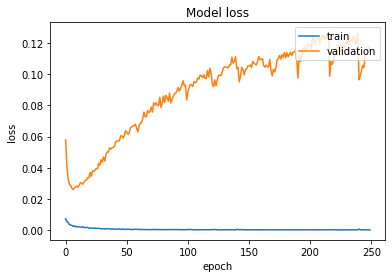

In [ ]:
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=1e-3, weight_decay=1e-8) # L2 = weight_decay
model_run(model_LSTM, optimizer_LSTM)

## BLSTM

In [ ]:
'''
Class BLSTM
'''
class BLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
    super(BLSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    self.embeddings = Embedding(input_size, hidden_size, word_embeddings)
    self.lstm = nn.LSTM(input_size = input_size,
                      hidden_size = hidden_size,
                      num_layers = num_layers,
                      batch_first=True,
                      dropout = 0,
                      bidirectional=True
                      )
    ## input_shape to nn.RNN-> (batch_size, seq_length, input_size) 
    self.dropout = nn.Dropout(dropout)
    self.activation = nn.Tanh()
    # The last layer to compute the probabilities for the output classes
    self.final_layer = nn.Linear(in_features=hidden_size*2, out_features=num_classes)
  

  def forward(self, x_idx):
    x = self.embeddings(x_idx)
    h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
    
    if torch.cuda.is_available():
        h0 = h0.to("cuda")
        c0 = c0.to("cuda")

    output, _ = self.lstm(x.float(), (h0,c0))
    output = self.dropout(output)
    output = self.activation(output)
    logits = self.final_layer(output)
    return logits

In [ ]:
# We initialize our model
model_BLSTM = BLSTM(input_size = WORD_DIM,
            hidden_size = 128,
            num_layers = 1,
            num_classes = len(MAPPING_NER_LABELS),
            dropout = 0.3
            )

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:01, 46.69it/s]
Val: 8it [00:00, 100.80it/s]
Test: 59it [00:00, 95.50it/s]


Train loss: 0.9638
Val   loss: 0.6350
Test  loss: 0.6293

Val   Macro F1: 0.1193
Test  Macro F1: 0.1178

Best Epoch: 0, best val macro F1: 0.1193, test macro F1: 0.1178


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:01, 46.61it/s]
Val: 8it [00:00, 98.19it/s]
Test: 59it [00:00, 93.12it/s]


Train loss: 0.4931
Val   loss: 0.3574
Test  loss: 0.3384

Val   Macro F1: 0.3879
Test  Macro F1: 0.3984

Best Epoch: 1, best val macro F1: 0.3879, test macro F1: 0.3984


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:01, 46.57it/s]
Val: 8it [00:00, 97.42it/s]
Test: 59it [00:00, 93.19it/s]


Train loss: 0.3014
Val   loss: 0.2699
Test  loss: 0.2362

Val   Macro F1: 0.4926
Test  Macro F1: 0.5100

Best Epoch: 2, best val macro F1: 0.4926, test macro F1: 0.5100


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:01, 46.61it/s]
Val: 8it [00:00, 99.90it/s]
Test: 59it [00:00, 94.32it/s]


Train loss: 0.2294
Val   loss: 0.2423
Test  loss: 0.1893

Val   Macro F1: 0.5620
Test  Macro F1: 0.5884

Best Epoch: 3, best val macro F1: 0.5620, test macro F1: 0.5884


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:01, 46.77it/s]
Val: 8it [00:00, 90.17it/s]
Test: 59it [00:00, 93.08it/s]


Train loss: 0.1890
Val   loss: 0.2325
Test  loss: 0.1588

Val   Macro F1: 0.5957
Test  Macro F1: 0.6436

Best Epoch: 4, best val macro F1: 0.5957, test macro F1: 0.6436


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:01, 46.65it/s]
Val: 8it [00:00, 98.77it/s]
Test: 59it [00:00, 93.68it/s]


Train loss: 0.1623
Val   loss: 0.2335
Test  loss: 0.1393

Val   Macro F1: 0.6734
Test  Macro F1: 0.7229

Best Epoch: 5, best val macro F1: 0.6734, test macro F1: 0.7229


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:01, 46.99it/s]
Val: 8it [00:00, 94.14it/s]
Test: 59it [00:00, 92.88it/s]


Train loss: 0.1415
Val   loss: 0.2206
Test  loss: 0.1164

Val   Macro F1: 0.6792
Test  Macro F1: 0.7550

Best Epoch: 6, best val macro F1: 0.6792, test macro F1: 0.7550


------------------------------------------------------------------------
Epoch: 7


Training: 59it [00:01, 47.06it/s]
Val: 8it [00:00, 96.84it/s]
Test: 59it [00:00, 92.57it/s]


Train loss: 0.1256
Val   loss: 0.2223
Test  loss: 0.1050

Val   Macro F1: 0.6870
Test  Macro F1: 0.7710

Best Epoch: 7, best val macro F1: 0.6870, test macro F1: 0.7710


------------------------------------------------------------------------
Epoch: 8


Training: 59it [00:01, 46.65it/s]
Val: 8it [00:00, 97.06it/s]
Test: 59it [00:00, 92.89it/s]


Train loss: 0.1140
Val   loss: 0.2310
Test  loss: 0.0940

Val   Macro F1: 0.6886
Test  Macro F1: 0.7816

Best Epoch: 8, best val macro F1: 0.6886, test macro F1: 0.7816


------------------------------------------------------------------------
Epoch: 9


Training: 59it [00:01, 46.93it/s]
Val: 8it [00:00, 100.34it/s]
Test: 59it [00:00, 93.13it/s]


Train loss: 0.1043
Val   loss: 0.2427
Test  loss: 0.0863

Val   Macro F1: 0.6887
Test  Macro F1: 0.7912

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 10


Training: 59it [00:01, 46.84it/s]
Val: 8it [00:00, 90.13it/s]
Test: 59it [00:00, 93.11it/s]


Train loss: 0.0943
Val   loss: 0.2503
Test  loss: 0.0806

Val   Macro F1: 0.6869
Test  Macro F1: 0.7963

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 11


Training: 59it [00:01, 46.67it/s]
Val: 8it [00:00, 94.86it/s]
Test: 59it [00:00, 91.69it/s]


Train loss: 0.0871
Val   loss: 0.2530
Test  loss: 0.0698

Val   Macro F1: 0.6822
Test  Macro F1: 0.8035

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 12


Training: 59it [00:01, 46.50it/s]
Val: 8it [00:00, 94.94it/s]
Test: 59it [00:00, 92.10it/s]


Train loss: 0.0795
Val   loss: 0.2712
Test  loss: 0.0629

Val   Macro F1: 0.6717
Test  Macro F1: 0.8093

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 13


Training: 59it [00:01, 46.60it/s]
Val: 8it [00:00, 95.21it/s]
Test: 59it [00:00, 91.37it/s]


Train loss: 0.0724
Val   loss: 0.2725
Test  loss: 0.0560

Val   Macro F1: 0.6766
Test  Macro F1: 0.8175

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 14


Training: 59it [00:01, 45.96it/s]
Val: 8it [00:00, 93.03it/s]
Test: 59it [00:00, 91.63it/s]


Train loss: 0.0668
Val   loss: 0.2873
Test  loss: 0.0546

Val   Macro F1: 0.6809
Test  Macro F1: 0.8191

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 15


Training: 59it [00:01, 45.99it/s]
Val: 8it [00:00, 98.65it/s]
Test: 59it [00:00, 90.83it/s]


Train loss: 0.0615
Val   loss: 0.2982
Test  loss: 0.0468

Val   Macro F1: 0.6654
Test  Macro F1: 0.8245

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 16


Training: 59it [00:01, 46.74it/s]
Val: 8it [00:00, 94.60it/s]
Test: 59it [00:00, 89.46it/s]


Train loss: 0.0551
Val   loss: 0.3042
Test  loss: 0.0413

Val   Macro F1: 0.6688
Test  Macro F1: 0.8304

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 17


Training: 59it [00:01, 46.09it/s]
Val: 8it [00:00, 101.11it/s]
Test: 59it [00:00, 92.19it/s]


Train loss: 0.0504
Val   loss: 0.3228
Test  loss: 0.0373

Val   Macro F1: 0.6706
Test  Macro F1: 0.8345

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 18


Training: 59it [00:01, 46.24it/s]
Val: 8it [00:00, 95.47it/s]
Test: 59it [00:00, 93.50it/s]


Train loss: 0.0455
Val   loss: 0.3389
Test  loss: 0.0339

Val   Macro F1: 0.6529
Test  Macro F1: 0.8342

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 19


Training: 59it [00:01, 47.58it/s]
Val: 8it [00:00, 101.16it/s]
Test: 59it [00:00, 94.02it/s]


Train loss: 0.0424
Val   loss: 0.3480
Test  loss: 0.0311

Val   Macro F1: 0.6645
Test  Macro F1: 0.8407

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 20


Training: 59it [00:01, 47.65it/s]
Val: 8it [00:00, 95.15it/s]
Test: 59it [00:00, 94.00it/s]


Train loss: 0.0379
Val   loss: 0.3525
Test  loss: 0.0258

Val   Macro F1: 0.6593
Test  Macro F1: 0.8408

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 21


Training: 59it [00:01, 47.44it/s]
Val: 8it [00:00, 97.30it/s]
Test: 59it [00:00, 93.38it/s]


Train loss: 0.0344
Val   loss: 0.3736
Test  loss: 0.0238

Val   Macro F1: 0.6528
Test  Macro F1: 0.8381

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 22


Training: 59it [00:01, 47.13it/s]
Val: 8it [00:00, 93.24it/s]
Test: 59it [00:00, 92.04it/s]


Train loss: 0.0314
Val   loss: 0.3818
Test  loss: 0.0269

Val   Macro F1: 0.6495
Test  Macro F1: 0.8158

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 23


Training: 59it [00:01, 47.15it/s]
Val: 8it [00:00, 95.68it/s]
Test: 59it [00:00, 93.65it/s]


Train loss: 0.0285
Val   loss: 0.3976
Test  loss: 0.0183

Val   Macro F1: 0.6301
Test  Macro F1: 0.8234

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 24


Training: 59it [00:01, 46.98it/s]
Val: 8it [00:00, 90.63it/s]
Test: 59it [00:00, 92.84it/s]


Train loss: 0.0256
Val   loss: 0.4180
Test  loss: 0.0160

Val   Macro F1: 0.6131
Test  Macro F1: 0.8053

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 25


Training: 59it [00:01, 46.65it/s]
Val: 8it [00:00, 94.94it/s]
Test: 59it [00:00, 92.46it/s]


Train loss: 0.0225
Val   loss: 0.4141
Test  loss: 0.0148

Val   Macro F1: 0.5820
Test  Macro F1: 0.7654

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 26


Training: 59it [00:01, 46.32it/s]
Val: 8it [00:00, 102.03it/s]
Test: 59it [00:00, 92.38it/s]


Train loss: 0.0207
Val   loss: 0.4336
Test  loss: 0.0141

Val   Macro F1: 0.6327
Test  Macro F1: 0.8283

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 27


Training: 59it [00:01, 46.43it/s]
Val: 8it [00:00, 89.54it/s]
Test: 59it [00:00, 93.15it/s]


Train loss: 0.0199
Val   loss: 0.4498
Test  loss: 0.0127

Val   Macro F1: 0.6026
Test  Macro F1: 0.8023

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 28


Training: 59it [00:01, 46.73it/s]
Val: 8it [00:00, 99.22it/s]
Test: 59it [00:00, 92.46it/s]


Train loss: 0.0188
Val   loss: 0.4763
Test  loss: 0.0123

Val   Macro F1: 0.5905
Test  Macro F1: 0.7941

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 29


Training: 59it [00:01, 46.98it/s]
Val: 8it [00:00, 95.64it/s]
Test: 59it [00:00, 92.63it/s]


Train loss: 0.0167
Val   loss: 0.4668
Test  loss: 0.0099

Val   Macro F1: 0.5934
Test  Macro F1: 0.7871

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 30


Training: 59it [00:01, 46.50it/s]
Val: 8it [00:00, 99.24it/s]
Test: 59it [00:00, 93.41it/s]


Train loss: 0.0142
Val   loss: 0.4967
Test  loss: 0.0080

Val   Macro F1: 0.5821
Test  Macro F1: 0.7833

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 31


Training: 59it [00:01, 47.01it/s]
Val: 8it [00:00, 96.31it/s]
Test: 59it [00:00, 93.77it/s]


Train loss: 0.0131
Val   loss: 0.5159
Test  loss: 0.0074

Val   Macro F1: 0.6136
Test  Macro F1: 0.8260

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 32


Training: 59it [00:01, 47.25it/s]
Val: 8it [00:00, 95.42it/s]
Test: 59it [00:00, 92.69it/s]


Train loss: 0.0119
Val   loss: 0.5089
Test  loss: 0.0071

Val   Macro F1: 0.5969
Test  Macro F1: 0.7968

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 33


Training: 59it [00:01, 47.19it/s]
Val: 8it [00:00, 92.28it/s]
Test: 59it [00:00, 94.19it/s]


Train loss: 0.0117
Val   loss: 0.5461
Test  loss: 0.0071

Val   Macro F1: 0.5867
Test  Macro F1: 0.7959

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 34


Training: 59it [00:01, 46.69it/s]
Val: 8it [00:00, 97.10it/s]
Test: 59it [00:00, 93.92it/s]


Train loss: 0.0108
Val   loss: 0.5293
Test  loss: 0.0063

Val   Macro F1: 0.5894
Test  Macro F1: 0.8042

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 35


Training: 59it [00:01, 46.76it/s]
Val: 8it [00:00, 96.94it/s]
Test: 59it [00:00, 93.83it/s]


Train loss: 0.0105
Val   loss: 0.5342
Test  loss: 0.0058

Val   Macro F1: 0.5955
Test  Macro F1: 0.7964

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 36


Training: 59it [00:01, 46.75it/s]
Val: 8it [00:00, 95.56it/s]
Test: 59it [00:00, 91.73it/s]


Train loss: 0.0092
Val   loss: 0.5613
Test  loss: 0.0048

Val   Macro F1: 0.5669
Test  Macro F1: 0.7675

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 37


Training: 59it [00:01, 47.16it/s]
Val: 8it [00:00, 100.31it/s]
Test: 59it [00:00, 92.81it/s]


Train loss: 0.0084
Val   loss: 0.5570
Test  loss: 0.0041

Val   Macro F1: 0.5799
Test  Macro F1: 0.7834

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 38


Training: 59it [00:01, 46.25it/s]
Val: 8it [00:00, 96.59it/s]
Test: 59it [00:00, 94.29it/s]


Train loss: 0.0079
Val   loss: 0.5838
Test  loss: 0.0037

Val   Macro F1: 0.5794
Test  Macro F1: 0.7912

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 39


Training: 59it [00:01, 47.03it/s]
Val: 8it [00:00, 100.80it/s]
Test: 59it [00:00, 93.73it/s]


Train loss: 0.0071
Val   loss: 0.5939
Test  loss: 0.0031

Val   Macro F1: 0.5863
Test  Macro F1: 0.8061

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 40


Training: 59it [00:01, 46.83it/s]
Val: 8it [00:00, 97.89it/s]
Test: 59it [00:00, 92.77it/s]


Train loss: 0.0064
Val   loss: 0.5982
Test  loss: 0.0028

Val   Macro F1: 0.5700
Test  Macro F1: 0.7795

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 41


Training: 59it [00:01, 46.50it/s]
Val: 8it [00:00, 102.66it/s]
Test: 59it [00:00, 93.06it/s]


Train loss: 0.0058
Val   loss: 0.6168
Test  loss: 0.0028

Val   Macro F1: 0.5904
Test  Macro F1: 0.8054

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 42


Training: 59it [00:01, 46.46it/s]
Val: 8it [00:00, 95.48it/s]
Test: 59it [00:00, 93.91it/s]


Train loss: 0.0055
Val   loss: 0.6098
Test  loss: 0.0028

Val   Macro F1: 0.5827
Test  Macro F1: 0.7990

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 43


Training: 59it [00:01, 47.20it/s]
Val: 8it [00:00, 94.86it/s]
Test: 59it [00:00, 93.86it/s]


Train loss: 0.0054
Val   loss: 0.6322
Test  loss: 0.0022

Val   Macro F1: 0.5714
Test  Macro F1: 0.7862

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 44


Training: 59it [00:01, 46.53it/s]
Val: 8it [00:00, 93.65it/s]
Test: 59it [00:00, 93.52it/s]


Train loss: 0.0048
Val   loss: 0.6317
Test  loss: 0.0020

Val   Macro F1: 0.5721
Test  Macro F1: 0.7825

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 45


Training: 59it [00:01, 46.81it/s]
Val: 8it [00:00, 93.74it/s]
Test: 59it [00:00, 90.92it/s]


Train loss: 0.0053
Val   loss: 0.6451
Test  loss: 0.0023

Val   Macro F1: 0.5632
Test  Macro F1: 0.7816

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 46


Training: 59it [00:01, 46.69it/s]
Val: 8it [00:00, 91.40it/s]
Test: 59it [00:00, 92.55it/s]


Train loss: 0.0062
Val   loss: 0.6241
Test  loss: 0.0070

Val   Macro F1: 0.5376
Test  Macro F1: 0.7236

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 47


Training: 59it [00:01, 46.52it/s]
Val: 8it [00:00, 95.29it/s]
Test: 59it [00:00, 91.82it/s]


Train loss: 0.0076
Val   loss: 0.6451
Test  loss: 0.0031

Val   Macro F1: 0.5356
Test  Macro F1: 0.7310

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 48


Training: 59it [00:01, 46.58it/s]
Val: 8it [00:00, 96.55it/s]
Test: 59it [00:00, 92.05it/s]


Train loss: 0.0055
Val   loss: 0.6394
Test  loss: 0.0022

Val   Macro F1: 0.5581
Test  Macro F1: 0.7552

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 49


Training: 59it [00:01, 47.05it/s]
Val: 8it [00:00, 94.25it/s]
Test: 59it [00:00, 90.88it/s]


Train loss: 0.0046
Val   loss: 0.6699
Test  loss: 0.0017

Val   Macro F1: 0.5379
Test  Macro F1: 0.7420

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 50


Training: 59it [00:01, 46.78it/s]
Val: 8it [00:00, 100.70it/s]
Test: 59it [00:00, 91.08it/s]


Train loss: 0.0039
Val   loss: 0.6667
Test  loss: 0.0015

Val   Macro F1: 0.5609
Test  Macro F1: 0.7601

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 51


Training: 59it [00:01, 46.96it/s]
Val: 8it [00:00, 94.29it/s]
Test: 59it [00:00, 93.60it/s]


Train loss: 0.0032
Val   loss: 0.6904
Test  loss: 0.0012

Val   Macro F1: 0.5671
Test  Macro F1: 0.7799

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 52


Training: 59it [00:01, 46.67it/s]
Val: 8it [00:00, 89.82it/s]
Test: 59it [00:00, 90.81it/s]


Train loss: 0.0028
Val   loss: 0.7036
Test  loss: 0.0010

Val   Macro F1: 0.5367
Test  Macro F1: 0.7328

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 53


Training: 59it [00:01, 46.36it/s]
Val: 8it [00:00, 96.24it/s]
Test: 59it [00:00, 91.53it/s]


Train loss: 0.0028
Val   loss: 0.7049
Test  loss: 0.0010

Val   Macro F1: 0.5621
Test  Macro F1: 0.7742

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 54


Training: 59it [00:01, 46.86it/s]
Val: 8it [00:00, 96.08it/s]
Test: 59it [00:00, 90.65it/s]


Train loss: 0.0025
Val   loss: 0.7004
Test  loss: 0.0010

Val   Macro F1: 0.5383
Test  Macro F1: 0.7332

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 55


Training: 59it [00:01, 46.52it/s]
Val: 8it [00:00, 99.27it/s]
Test: 59it [00:00, 92.11it/s]


Train loss: 0.0024
Val   loss: 0.7039
Test  loss: 0.0009

Val   Macro F1: 0.5702
Test  Macro F1: 0.7772

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 56


Training: 59it [00:01, 46.58it/s]
Val: 8it [00:00, 92.61it/s]
Test: 59it [00:00, 90.60it/s]


Train loss: 0.0023
Val   loss: 0.7207
Test  loss: 0.0009

Val   Macro F1: 0.5423
Test  Macro F1: 0.7434

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 57


Training: 59it [00:01, 46.76it/s]
Val: 8it [00:00, 97.36it/s]
Test: 59it [00:00, 92.11it/s]


Train loss: 0.0021
Val   loss: 0.7339
Test  loss: 0.0006

Val   Macro F1: 0.5413
Test  Macro F1: 0.7454

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 58


Training: 59it [00:01, 46.60it/s]
Val: 8it [00:00, 95.77it/s]
Test: 59it [00:00, 90.87it/s]


Train loss: 0.0021
Val   loss: 0.7555
Test  loss: 0.0007

Val   Macro F1: 0.5579
Test  Macro F1: 0.7729

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 59


Training: 59it [00:01, 46.41it/s]
Val: 8it [00:00, 101.79it/s]
Test: 59it [00:00, 92.96it/s]


Train loss: 0.0022
Val   loss: 0.7477
Test  loss: 0.0007

Val   Macro F1: 0.5608
Test  Macro F1: 0.7793

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 60


Training: 59it [00:01, 46.83it/s]
Val: 8it [00:00, 93.48it/s]
Test: 59it [00:00, 91.99it/s]


Train loss: 0.0021
Val   loss: 0.7785
Test  loss: 0.0007

Val   Macro F1: 0.5422
Test  Macro F1: 0.7489

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 61


Training: 59it [00:01, 47.07it/s]
Val: 8it [00:00, 97.91it/s]
Test: 59it [00:00, 92.17it/s]


Train loss: 0.0023
Val   loss: 0.7521
Test  loss: 0.0009

Val   Macro F1: 0.5178
Test  Macro F1: 0.7144

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 62


Training: 59it [00:01, 47.19it/s]
Val: 8it [00:00, 96.21it/s]
Test: 59it [00:00, 90.66it/s]


Train loss: 0.0048
Val   loss: 0.7509
Test  loss: 0.0047

Val   Macro F1: 0.5390
Test  Macro F1: 0.7478

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 63


Training: 59it [00:01, 46.86it/s]
Val: 8it [00:00, 97.18it/s]
Test: 59it [00:00, 91.21it/s]


Train loss: 0.0119
Val   loss: 0.6974
Test  loss: 0.0059

Val   Macro F1: 0.5324
Test  Macro F1: 0.7185

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 64


Training: 59it [00:01, 46.63it/s]
Val: 8it [00:00, 93.55it/s]
Test: 59it [00:00, 91.48it/s]


Train loss: 0.0111
Val   loss: 0.7346
Test  loss: 0.0059

Val   Macro F1: 0.5069
Test  Macro F1: 0.6998

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 65


Training: 59it [00:01, 46.43it/s]
Val: 8it [00:00, 99.02it/s]
Test: 59it [00:00, 92.24it/s]


Train loss: 0.0082
Val   loss: 0.7113
Test  loss: 0.0023

Val   Macro F1: 0.5550
Test  Macro F1: 0.7665

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 66


Training: 59it [00:01, 46.90it/s]
Val: 8it [00:00, 94.21it/s]
Test: 59it [00:00, 92.23it/s]


Train loss: 0.0040
Val   loss: 0.7131
Test  loss: 0.0011

Val   Macro F1: 0.5823
Test  Macro F1: 0.7928

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 67


Training: 59it [00:01, 46.44it/s]
Val: 8it [00:00, 98.24it/s]
Test: 59it [00:00, 92.88it/s]


Train loss: 0.0025
Val   loss: 0.7399
Test  loss: 0.0006

Val   Macro F1: 0.5588
Test  Macro F1: 0.7748

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 68


Training: 59it [00:01, 46.28it/s]
Val: 8it [00:00, 95.01it/s]
Test: 59it [00:00, 91.77it/s]


Train loss: 0.0018
Val   loss: 0.7698
Test  loss: 0.0005

Val   Macro F1: 0.5604
Test  Macro F1: 0.7771

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 69


Training: 59it [00:01, 46.52it/s]
Val: 8it [00:00, 95.80it/s]
Test: 59it [00:00, 92.57it/s]


Train loss: 0.0015
Val   loss: 0.7899
Test  loss: 0.0004

Val   Macro F1: 0.5716
Test  Macro F1: 0.7968

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 70


Training: 59it [00:01, 47.04it/s]
Val: 8it [00:00, 96.13it/s]
Test: 59it [00:00, 92.14it/s]


Train loss: 0.0013
Val   loss: 0.7854
Test  loss: 0.0003

Val   Macro F1: 0.5682
Test  Macro F1: 0.7907

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 71


Training: 59it [00:01, 47.07it/s]
Val: 8it [00:00, 94.36it/s]
Test: 59it [00:00, 92.41it/s]


Train loss: 0.0012
Val   loss: 0.7814
Test  loss: 0.0003

Val   Macro F1: 0.5599
Test  Macro F1: 0.7801

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 72


Training: 59it [00:01, 46.61it/s]
Val: 8it [00:00, 95.80it/s]
Test: 59it [00:00, 91.66it/s]


Train loss: 0.0011
Val   loss: 0.8010
Test  loss: 0.0003

Val   Macro F1: 0.5551
Test  Macro F1: 0.7722

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 73


Training: 59it [00:01, 46.76it/s]
Val: 8it [00:00, 95.26it/s]
Test: 59it [00:00, 92.12it/s]


Train loss: 0.0011
Val   loss: 0.8072
Test  loss: 0.0003

Val   Macro F1: 0.5393
Test  Macro F1: 0.7493

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 74


Training: 59it [00:01, 46.97it/s]
Val: 8it [00:00, 94.07it/s]
Test: 59it [00:00, 91.48it/s]


Train loss: 0.0010
Val   loss: 0.8114
Test  loss: 0.0002

Val   Macro F1: 0.5517
Test  Macro F1: 0.7672

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 75


Training: 59it [00:01, 46.96it/s]
Val: 8it [00:00, 99.02it/s]
Test: 59it [00:00, 92.91it/s]


Train loss: 0.0010
Val   loss: 0.8175
Test  loss: 0.0002

Val   Macro F1: 0.5554
Test  Macro F1: 0.7717

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 76


Training: 59it [00:01, 46.67it/s]
Val: 8it [00:00, 86.25it/s]
Test: 59it [00:00, 91.29it/s]


Train loss: 0.0009
Val   loss: 0.8200
Test  loss: 0.0002

Val   Macro F1: 0.5391
Test  Macro F1: 0.7451

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 77


Training: 59it [00:01, 47.42it/s]
Val: 8it [00:00, 97.91it/s]
Test: 59it [00:00, 91.26it/s]


Train loss: 0.0009
Val   loss: 0.8499
Test  loss: 0.0002

Val   Macro F1: 0.5404
Test  Macro F1: 0.7590

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 78


Training: 59it [00:01, 46.59it/s]
Val: 8it [00:00, 94.03it/s]
Test: 59it [00:00, 92.06it/s]


Train loss: 0.0008
Val   loss: 0.8498
Test  loss: 0.0002

Val   Macro F1: 0.5378
Test  Macro F1: 0.7484

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 79


Training: 59it [00:01, 46.50it/s]
Val: 8it [00:00, 95.61it/s]
Test: 59it [00:00, 93.33it/s]


Train loss: 0.0007
Val   loss: 0.8595
Test  loss: 0.0002

Val   Macro F1: 0.5440
Test  Macro F1: 0.7597

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 80


Training: 59it [00:01, 46.88it/s]
Val: 8it [00:00, 93.42it/s]
Test: 59it [00:00, 90.96it/s]


Train loss: 0.0007
Val   loss: 0.8583
Test  loss: 0.0002

Val   Macro F1: 0.5455
Test  Macro F1: 0.7608

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 81


Training: 59it [00:01, 46.52it/s]
Val: 8it [00:00, 94.65it/s]
Test: 59it [00:00, 91.12it/s]


Train loss: 0.0008
Val   loss: 0.8667
Test  loss: 0.0002

Val   Macro F1: 0.5319
Test  Macro F1: 0.7450

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 82


Training: 59it [00:01, 46.28it/s]
Val: 8it [00:00, 92.63it/s]
Test: 59it [00:00, 91.41it/s]


Train loss: 0.0007
Val   loss: 0.8681
Test  loss: 0.0002

Val   Macro F1: 0.5261
Test  Macro F1: 0.7373

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 83


Training: 59it [00:01, 46.90it/s]
Val: 8it [00:00, 95.51it/s]
Test: 59it [00:00, 92.25it/s]


Train loss: 0.0007
Val   loss: 0.8813
Test  loss: 0.0002

Val   Macro F1: 0.5547
Test  Macro F1: 0.7746

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 84


Training: 59it [00:01, 46.66it/s]
Val: 8it [00:00, 93.73it/s]
Test: 59it [00:00, 90.59it/s]


Train loss: 0.0007
Val   loss: 0.8754
Test  loss: 0.0002

Val   Macro F1: 0.5394
Test  Macro F1: 0.7575

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 85


Training: 59it [00:01, 46.30it/s]
Val: 8it [00:00, 90.74it/s]
Test: 59it [00:00, 91.46it/s]


Train loss: 0.0008
Val   loss: 0.8678
Test  loss: 0.0002

Val   Macro F1: 0.5360
Test  Macro F1: 0.7417

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 86


Training: 59it [00:01, 46.16it/s]
Val: 8it [00:00, 93.91it/s]
Test: 59it [00:00, 89.62it/s]


Train loss: 0.0008
Val   loss: 0.8488
Test  loss: 0.0003

Val   Macro F1: 0.5422
Test  Macro F1: 0.7456

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 87


Training: 59it [00:01, 46.67it/s]
Val: 8it [00:00, 94.29it/s]
Test: 59it [00:00, 92.48it/s]


Train loss: 0.0010
Val   loss: 0.8991
Test  loss: 0.0008

Val   Macro F1: 0.5678
Test  Macro F1: 0.8035

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 88


Training: 59it [00:01, 46.44it/s]
Val: 8it [00:00, 92.60it/s]
Test: 59it [00:00, 88.06it/s]


Train loss: 0.0076
Val   loss: 0.8974
Test  loss: 0.0171

Val   Macro F1: 0.5382
Test  Macro F1: 0.7521

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 89


Training: 59it [00:01, 46.90it/s]
Val: 8it [00:00, 92.33it/s]
Test: 59it [00:00, 92.64it/s]


Train loss: 0.0156
Val   loss: 0.7912
Test  loss: 0.0052

Val   Macro F1: 0.5163
Test  Macro F1: 0.7108

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 90


Training: 59it [00:01, 47.39it/s]
Val: 8it [00:00, 101.34it/s]
Test: 59it [00:00, 91.76it/s]


Train loss: 0.0082
Val   loss: 0.7642
Test  loss: 0.0035

Val   Macro F1: 0.5630
Test  Macro F1: 0.7559

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 91


Training: 59it [00:01, 46.28it/s]
Val: 8it [00:00, 96.01it/s]
Test: 59it [00:00, 87.96it/s]


Train loss: 0.0052
Val   loss: 0.8097
Test  loss: 0.0010

Val   Macro F1: 0.5799
Test  Macro F1: 0.7977

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 92


Training: 59it [00:01, 47.21it/s]
Val: 8it [00:00, 95.20it/s]
Test: 59it [00:00, 91.07it/s]


Train loss: 0.0026
Val   loss: 0.8211
Test  loss: 0.0006

Val   Macro F1: 0.5663
Test  Macro F1: 0.7774

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 93


Training: 59it [00:01, 46.37it/s]
Val: 8it [00:00, 95.48it/s]
Test: 59it [00:00, 90.34it/s]


Train loss: 0.0015
Val   loss: 0.8226
Test  loss: 0.0003

Val   Macro F1: 0.5562
Test  Macro F1: 0.7694

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 94


Training: 59it [00:01, 46.80it/s]
Val: 8it [00:00, 99.95it/s]
Test: 59it [00:00, 92.31it/s]


Train loss: 0.0014
Val   loss: 0.8466
Test  loss: 0.0003

Val   Macro F1: 0.5654
Test  Macro F1: 0.7867

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 95


Training: 59it [00:01, 46.93it/s]
Val: 8it [00:00, 94.51it/s]
Test: 59it [00:00, 93.58it/s]


Train loss: 0.0009
Val   loss: 0.8624
Test  loss: 0.0002

Val   Macro F1: 0.5614
Test  Macro F1: 0.7764

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 96


Training: 59it [00:01, 46.42it/s]
Val: 8it [00:00, 93.24it/s]
Test: 59it [00:00, 93.51it/s]


Train loss: 0.0009
Val   loss: 0.8611
Test  loss: 0.0002

Val   Macro F1: 0.5612
Test  Macro F1: 0.7724

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 97


Training: 59it [00:01, 46.54it/s]
Val: 8it [00:00, 93.62it/s]
Test: 59it [00:00, 93.70it/s]


Train loss: 0.0007
Val   loss: 0.8903
Test  loss: 0.0002

Val   Macro F1: 0.5603
Test  Macro F1: 0.7818

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 98


Training: 59it [00:01, 46.58it/s]
Val: 8it [00:00, 95.62it/s]
Test: 59it [00:00, 91.99it/s]


Train loss: 0.0007
Val   loss: 0.8881
Test  loss: 0.0001

Val   Macro F1: 0.5582
Test  Macro F1: 0.7767

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 99


Training: 59it [00:01, 46.69it/s]
Val: 8it [00:00, 97.00it/s]
Test: 59it [00:00, 92.92it/s]


Train loss: 0.0006
Val   loss: 0.8960
Test  loss: 0.0001

Val   Macro F1: 0.5576
Test  Macro F1: 0.7744

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 100


Training: 59it [00:01, 46.77it/s]
Val: 8it [00:00, 95.41it/s]
Test: 59it [00:00, 93.05it/s]


Train loss: 0.0006
Val   loss: 0.9108
Test  loss: 0.0001

Val   Macro F1: 0.5537
Test  Macro F1: 0.7702

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 101


Training: 59it [00:01, 46.56it/s]
Val: 8it [00:00, 100.79it/s]
Test: 59it [00:00, 92.32it/s]


Train loss: 0.0006
Val   loss: 0.9023
Test  loss: 0.0001

Val   Macro F1: 0.5550
Test  Macro F1: 0.7691

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 102


Training: 59it [00:01, 47.22it/s]
Val: 8it [00:00, 92.94it/s]
Test: 59it [00:00, 92.79it/s]


Train loss: 0.0005
Val   loss: 0.9139
Test  loss: 0.0001

Val   Macro F1: 0.5663
Test  Macro F1: 0.7826

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 103


Training: 59it [00:01, 46.54it/s]
Val: 8it [00:00, 89.01it/s]
Test: 59it [00:00, 92.93it/s]


Train loss: 0.0005
Val   loss: 0.9102
Test  loss: 0.0001

Val   Macro F1: 0.5529
Test  Macro F1: 0.7603

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 104


Training: 59it [00:01, 46.80it/s]
Val: 8it [00:00, 97.93it/s]
Test: 59it [00:00, 90.36it/s]


Train loss: 0.0005
Val   loss: 0.9255
Test  loss: 0.0001

Val   Macro F1: 0.5567
Test  Macro F1: 0.7703

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 105


Training: 59it [00:01, 46.45it/s]
Val: 8it [00:00, 95.57it/s]
Test: 59it [00:00, 93.13it/s]


Train loss: 0.0005
Val   loss: 0.9384
Test  loss: 0.0001

Val   Macro F1: 0.5516
Test  Macro F1: 0.7667

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 106


Training: 59it [00:01, 46.33it/s]
Val: 8it [00:00, 96.15it/s]
Test: 59it [00:00, 92.78it/s]


Train loss: 0.0005
Val   loss: 0.9232
Test  loss: 0.0001

Val   Macro F1: 0.5544
Test  Macro F1: 0.7667

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 107


Training: 59it [00:01, 46.65it/s]
Val: 8it [00:00, 94.65it/s]
Test: 59it [00:00, 93.26it/s]


Train loss: 0.0004
Val   loss: 0.9326
Test  loss: 0.0001

Val   Macro F1: 0.5482
Test  Macro F1: 0.7612

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 108


Training: 59it [00:01, 46.74it/s]
Val: 8it [00:00, 94.68it/s]
Test: 59it [00:00, 93.09it/s]


Train loss: 0.0004
Val   loss: 0.9499
Test  loss: 0.0001

Val   Macro F1: 0.5433
Test  Macro F1: 0.7597

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 109


Training: 59it [00:01, 46.82it/s]
Val: 8it [00:00, 93.96it/s]
Test: 59it [00:00, 92.20it/s]


Train loss: 0.0004
Val   loss: 0.9419
Test  loss: 0.0001

Val   Macro F1: 0.5516
Test  Macro F1: 0.7634

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 110


Training: 59it [00:01, 47.04it/s]
Val: 8it [00:00, 95.50it/s]
Test: 59it [00:00, 92.16it/s]


Train loss: 0.0004
Val   loss: 0.9559
Test  loss: 0.0001

Val   Macro F1: 0.5560
Test  Macro F1: 0.7724

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 111


Training: 59it [00:01, 46.46it/s]
Val: 8it [00:00, 93.84it/s]
Test: 59it [00:00, 93.62it/s]


Train loss: 0.0004
Val   loss: 0.9597
Test  loss: 0.0001

Val   Macro F1: 0.5580
Test  Macro F1: 0.7788

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 112


Training: 59it [00:01, 46.87it/s]
Val: 8it [00:00, 96.67it/s]
Test: 59it [00:00, 71.42it/s]


Train loss: 0.0004
Val   loss: 0.9623
Test  loss: 0.0001

Val   Macro F1: 0.5555
Test  Macro F1: 0.7737

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 113


Training: 59it [00:01, 45.36it/s]
Val: 8it [00:00, 92.55it/s]
Test: 59it [00:00, 93.22it/s]


Train loss: 0.0004
Val   loss: 0.9758
Test  loss: 0.0001

Val   Macro F1: 0.5543
Test  Macro F1: 0.7778

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 114


Training: 59it [00:01, 46.65it/s]
Val: 8it [00:00, 90.52it/s]
Test: 59it [00:00, 92.52it/s]


Train loss: 0.0004
Val   loss: 0.9708
Test  loss: 0.0001

Val   Macro F1: 0.5448
Test  Macro F1: 0.7586

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 115


Training: 59it [00:01, 47.37it/s]
Val: 8it [00:00, 91.92it/s]
Test: 59it [00:00, 92.34it/s]


Train loss: 0.0004
Val   loss: 0.9780
Test  loss: 0.0001

Val   Macro F1: 0.5374
Test  Macro F1: 0.7453

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 116


Training: 59it [00:01, 46.93it/s]
Val: 8it [00:00, 90.89it/s]
Test: 59it [00:00, 93.17it/s]


Train loss: 0.0005
Val   loss: 1.0018
Test  loss: 0.0002

Val   Macro F1: 0.5459
Test  Macro F1: 0.7654

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 117


Training: 59it [00:01, 46.62it/s]
Val: 8it [00:00, 97.93it/s]
Test: 59it [00:00, 93.43it/s]


Train loss: 0.0006
Val   loss: 0.9687
Test  loss: 0.0003

Val   Macro F1: 0.5698
Test  Macro F1: 0.7961

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 118


Training: 59it [00:01, 46.78it/s]
Val: 8it [00:00, 96.22it/s]
Test: 59it [00:00, 91.03it/s]


Train loss: 0.0010
Val   loss: 0.9410
Test  loss: 0.0005

Val   Macro F1: 0.5514
Test  Macro F1: 0.7556

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 119


Training: 59it [00:01, 46.89it/s]
Val: 8it [00:00, 98.38it/s]
Test: 59it [00:00, 91.55it/s]


Train loss: 0.0030
Val   loss: 0.8923
Test  loss: 0.0028

Val   Macro F1: 0.5021
Test  Macro F1: 0.6846

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 120


Training: 59it [00:01, 46.84it/s]
Val: 8it [00:00, 93.81it/s]
Test: 59it [00:00, 90.87it/s]


Train loss: 0.0100
Val   loss: 0.8481
Test  loss: 0.0075

Val   Macro F1: 0.5210
Test  Macro F1: 0.7081

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 121


Training: 59it [00:01, 46.62it/s]
Val: 8it [00:00, 93.26it/s]
Test: 59it [00:00, 90.58it/s]


Train loss: 0.0089
Val   loss: 0.8498
Test  loss: 0.0037

Val   Macro F1: 0.5280
Test  Macro F1: 0.7206

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 122


Training: 59it [00:01, 46.54it/s]
Val: 8it [00:00, 96.25it/s]
Test: 59it [00:00, 92.57it/s]


Train loss: 0.0068
Val   loss: 0.9166
Test  loss: 0.0020

Val   Macro F1: 0.5367
Test  Macro F1: 0.7490

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 123


Training: 59it [00:01, 47.10it/s]
Val: 8it [00:00, 94.29it/s]
Test: 59it [00:00, 93.27it/s]


Train loss: 0.0035
Val   loss: 0.8770
Test  loss: 0.0009

Val   Macro F1: 0.5543
Test  Macro F1: 0.7594

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 124


Training: 59it [00:01, 46.99it/s]
Val: 8it [00:00, 91.86it/s]
Test: 59it [00:00, 89.67it/s]


Train loss: 0.0020
Val   loss: 0.9196
Test  loss: 0.0003

Val   Macro F1: 0.5778
Test  Macro F1: 0.7980

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 125


Training: 59it [00:01, 47.00it/s]
Val: 8it [00:00, 90.94it/s]
Test: 59it [00:00, 93.47it/s]


Train loss: 0.0011
Val   loss: 0.9165
Test  loss: 0.0002

Val   Macro F1: 0.5512
Test  Macro F1: 0.7577

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 126


Training: 59it [00:01, 47.01it/s]
Val: 8it [00:00, 86.78it/s]
Test: 59it [00:00, 92.15it/s]


Train loss: 0.0008
Val   loss: 0.9342
Test  loss: 0.0001

Val   Macro F1: 0.5497
Test  Macro F1: 0.7603

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 127


Training: 59it [00:01, 46.72it/s]
Val: 8it [00:00, 91.21it/s]
Test: 59it [00:00, 93.65it/s]


Train loss: 0.0006
Val   loss: 0.9469
Test  loss: 0.0001

Val   Macro F1: 0.5636
Test  Macro F1: 0.7735

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 128


Training: 59it [00:01, 47.22it/s]
Val: 8it [00:00, 94.36it/s]
Test: 59it [00:00, 90.62it/s]


Train loss: 0.0005
Val   loss: 0.9530
Test  loss: 0.0001

Val   Macro F1: 0.5516
Test  Macro F1: 0.7611

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 129


Training: 59it [00:01, 46.87it/s]
Val: 8it [00:00, 94.78it/s]
Test: 59it [00:00, 92.80it/s]


Train loss: 0.0004
Val   loss: 0.9557
Test  loss: 0.0001

Val   Macro F1: 0.5613
Test  Macro F1: 0.7735

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 130


Training: 59it [00:01, 46.50it/s]
Val: 8it [00:00, 95.44it/s]
Test: 59it [00:00, 91.93it/s]


Train loss: 0.0004
Val   loss: 0.9643
Test  loss: 0.0001

Val   Macro F1: 0.5617
Test  Macro F1: 0.7721

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 131


Training: 59it [00:01, 46.56it/s]
Val: 8it [00:00, 96.90it/s]
Test: 59it [00:00, 91.74it/s]


Train loss: 0.0004
Val   loss: 0.9760
Test  loss: 0.0001

Val   Macro F1: 0.5598
Test  Macro F1: 0.7720

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 132


Training: 59it [00:01, 46.72it/s]
Val: 8it [00:00, 98.06it/s]
Test: 59it [00:00, 91.87it/s]


Train loss: 0.0004
Val   loss: 0.9881
Test  loss: 0.0001

Val   Macro F1: 0.5531
Test  Macro F1: 0.7691

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 133


Training: 59it [00:01, 46.78it/s]
Val: 8it [00:00, 94.65it/s]
Test: 59it [00:00, 91.69it/s]


Train loss: 0.0004
Val   loss: 0.9896
Test  loss: 0.0001

Val   Macro F1: 0.5577
Test  Macro F1: 0.7695

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 134


Training: 59it [00:01, 46.94it/s]
Val: 8it [00:00, 93.65it/s]
Test: 59it [00:00, 90.93it/s]


Train loss: 0.0004
Val   loss: 0.9981
Test  loss: 0.0001

Val   Macro F1: 0.5556
Test  Macro F1: 0.7708

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 135


Training: 59it [00:01, 46.71it/s]
Val: 8it [00:00, 97.20it/s]
Test: 59it [00:00, 91.76it/s]


Train loss: 0.0003
Val   loss: 0.9922
Test  loss: 0.0001

Val   Macro F1: 0.5473
Test  Macro F1: 0.7518

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 136


Training: 59it [00:01, 46.95it/s]
Val: 8it [00:00, 90.97it/s]
Test: 59it [00:00, 91.66it/s]


Train loss: 0.0003
Val   loss: 1.0102
Test  loss: 0.0001

Val   Macro F1: 0.5541
Test  Macro F1: 0.7687

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 137


Training: 59it [00:01, 46.58it/s]
Val: 8it [00:00, 95.00it/s]
Test: 59it [00:00, 92.44it/s]


Train loss: 0.0003
Val   loss: 1.0239
Test  loss: 0.0001

Val   Macro F1: 0.5534
Test  Macro F1: 0.7717

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 138


Training: 59it [00:01, 47.34it/s]
Val: 8it [00:00, 89.43it/s]
Test: 59it [00:00, 89.36it/s]


Train loss: 0.0003
Val   loss: 1.0159
Test  loss: 0.0001

Val   Macro F1: 0.5554
Test  Macro F1: 0.7740

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 139


Training: 59it [00:01, 46.53it/s]
Val: 8it [00:00, 94.86it/s]
Test: 59it [00:00, 92.54it/s]


Train loss: 0.0003
Val   loss: 1.0344
Test  loss: 0.0001

Val   Macro F1: 0.5503
Test  Macro F1: 0.7675

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 140


Training: 59it [00:01, 46.77it/s]
Val: 8it [00:00, 95.73it/s]
Test: 59it [00:00, 93.02it/s]


Train loss: 0.0003
Val   loss: 1.0134
Test  loss: 0.0001

Val   Macro F1: 0.5533
Test  Macro F1: 0.7637

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 141


Training: 59it [00:01, 47.05it/s]
Val: 8it [00:00, 97.51it/s]
Test: 59it [00:00, 92.06it/s]


Train loss: 0.0003
Val   loss: 1.0211
Test  loss: 0.0001

Val   Macro F1: 0.5651
Test  Macro F1: 0.7775

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 142


Training: 59it [00:01, 46.57it/s]
Val: 8it [00:00, 95.23it/s]
Test: 59it [00:00, 92.32it/s]


Train loss: 0.0003
Val   loss: 1.0135
Test  loss: 0.0001

Val   Macro F1: 0.5602
Test  Macro F1: 0.7692

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 143


Training: 59it [00:01, 46.64it/s]
Val: 8it [00:00, 94.33it/s]
Test: 59it [00:00, 92.04it/s]


Train loss: 0.0003
Val   loss: 1.0289
Test  loss: 0.0001

Val   Macro F1: 0.5513
Test  Macro F1: 0.7662

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 144


Training: 59it [00:01, 47.35it/s]
Val: 8it [00:00, 94.40it/s]
Test: 59it [00:00, 92.52it/s]


Train loss: 0.0004
Val   loss: 1.0274
Test  loss: 0.0001

Val   Macro F1: 0.5398
Test  Macro F1: 0.7517

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 145


Training: 59it [00:01, 46.87it/s]
Val: 8it [00:00, 94.55it/s]
Test: 59it [00:00, 92.49it/s]


Train loss: 0.0006
Val   loss: 1.0274
Test  loss: 0.0001

Val   Macro F1: 0.5620
Test  Macro F1: 0.7799

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 146


Training: 59it [00:01, 47.11it/s]
Val: 8it [00:00, 100.37it/s]
Test: 59it [00:00, 92.25it/s]


Train loss: 0.0007
Val   loss: 1.2041
Test  loss: 0.0060

Val   Macro F1: 0.5506
Test  Macro F1: 0.7970

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 147


Training: 59it [00:01, 46.53it/s]
Val: 8it [00:00, 98.01it/s]
Test: 59it [00:00, 91.50it/s]


Train loss: 0.0057
Val   loss: 1.0105
Test  loss: 0.0081

Val   Macro F1: 0.5631
Test  Macro F1: 0.7866

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 148


Training: 59it [00:01, 46.97it/s]
Val: 8it [00:00, 92.90it/s]
Test: 59it [00:00, 91.22it/s]


Train loss: 0.0115
Val   loss: 0.8755
Test  loss: 0.0054

Val   Macro F1: 0.5486
Test  Macro F1: 0.7401

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 149


Training: 59it [00:01, 46.55it/s]
Val: 8it [00:00, 95.57it/s]
Test: 59it [00:00, 92.36it/s]


Train loss: 0.0067
Val   loss: 0.8810
Test  loss: 0.0014

Val   Macro F1: 0.5676
Test  Macro F1: 0.7771

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 150


Training: 59it [00:01, 46.56it/s]
Val: 8it [00:00, 97.28it/s]
Test: 59it [00:00, 91.88it/s]


Train loss: 0.0033
Val   loss: 0.8608
Test  loss: 0.0012

Val   Macro F1: 0.5701
Test  Macro F1: 0.7684

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 151


Training: 59it [00:01, 46.82it/s]
Val: 8it [00:00, 93.21it/s]
Test: 59it [00:00, 89.93it/s]


Train loss: 0.0020
Val   loss: 0.9109
Test  loss: 0.0004

Val   Macro F1: 0.5766
Test  Macro F1: 0.7918

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 152


Training: 59it [00:01, 47.12it/s]
Val: 8it [00:00, 95.92it/s]
Test: 59it [00:00, 91.07it/s]


Train loss: 0.0010
Val   loss: 0.9545
Test  loss: 0.0001

Val   Macro F1: 0.5568
Test  Macro F1: 0.7676

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 153


Training: 59it [00:01, 46.54it/s]
Val: 8it [00:00, 92.36it/s]
Test: 59it [00:00, 91.95it/s]


Train loss: 0.0006
Val   loss: 0.9647
Test  loss: 0.0001

Val   Macro F1: 0.5574
Test  Macro F1: 0.7687

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 154


Training: 59it [00:01, 45.84it/s]
Val: 8it [00:00, 97.99it/s]
Test: 59it [00:00, 87.54it/s]


Train loss: 0.0005
Val   loss: 0.9717
Test  loss: 0.0001

Val   Macro F1: 0.5569
Test  Macro F1: 0.7702

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 155


Training: 59it [00:01, 46.53it/s]
Val: 8it [00:00, 94.55it/s]
Test: 59it [00:00, 91.26it/s]


Train loss: 0.0004
Val   loss: 0.9991
Test  loss: 0.0001

Val   Macro F1: 0.5614
Test  Macro F1: 0.7781

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 156


Training: 59it [00:01, 45.99it/s]
Val: 8it [00:00, 96.95it/s]
Test: 59it [00:00, 90.70it/s]


Train loss: 0.0004
Val   loss: 1.0037
Test  loss: 0.0001

Val   Macro F1: 0.5622
Test  Macro F1: 0.7797

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 157


Training: 59it [00:01, 45.94it/s]
Val: 8it [00:00, 94.85it/s]
Test: 59it [00:00, 92.21it/s]


Train loss: 0.0003
Val   loss: 1.0056
Test  loss: 0.0001

Val   Macro F1: 0.5534
Test  Macro F1: 0.7661

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 158


Training: 59it [00:01, 46.33it/s]
Val: 8it [00:00, 96.03it/s]
Test: 59it [00:00, 90.63it/s]


Train loss: 0.0003
Val   loss: 1.0081
Test  loss: 0.0001

Val   Macro F1: 0.5520
Test  Macro F1: 0.7596

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 159


Training: 59it [00:01, 47.38it/s]
Val: 8it [00:00, 100.65it/s]
Test: 59it [00:00, 92.74it/s]


Train loss: 0.0003
Val   loss: 1.0010
Test  loss: 0.0001

Val   Macro F1: 0.5573
Test  Macro F1: 0.7666

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 160


Training: 59it [00:01, 47.40it/s]
Val: 8it [00:00, 98.52it/s]
Test: 59it [00:00, 92.84it/s]


Train loss: 0.0003
Val   loss: 1.0049
Test  loss: 0.0001

Val   Macro F1: 0.5555
Test  Macro F1: 0.7640

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 161


Training: 59it [00:01, 45.57it/s]
Val: 8it [00:00, 89.26it/s]
Test: 59it [00:00, 92.96it/s]


Train loss: 0.0003
Val   loss: 1.0140
Test  loss: 0.0001

Val   Macro F1: 0.5599
Test  Macro F1: 0.7728

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 162


Training: 59it [00:01, 46.84it/s]
Val: 8it [00:00, 98.73it/s]
Test: 59it [00:00, 92.64it/s]


Train loss: 0.0003
Val   loss: 1.0229
Test  loss: 0.0001

Val   Macro F1: 0.5593
Test  Macro F1: 0.7716

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 163


Training: 59it [00:01, 47.14it/s]
Val: 8it [00:00, 96.77it/s]
Test: 59it [00:00, 92.29it/s]


Train loss: 0.0003
Val   loss: 1.0332
Test  loss: 0.0001

Val   Macro F1: 0.5635
Test  Macro F1: 0.7769

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 164


Training: 59it [00:01, 46.84it/s]
Val: 8it [00:00, 94.81it/s]
Test: 59it [00:00, 92.36it/s]


Train loss: 0.0002
Val   loss: 1.0338
Test  loss: 0.0001

Val   Macro F1: 0.5589
Test  Macro F1: 0.7717

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 165


Training: 59it [00:01, 46.58it/s]
Val: 8it [00:00, 94.62it/s]
Test: 59it [00:00, 92.41it/s]


Train loss: 0.0002
Val   loss: 1.0562
Test  loss: 0.0001

Val   Macro F1: 0.5655
Test  Macro F1: 0.7816

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 166


Training: 59it [00:01, 46.03it/s]
Val: 8it [00:00, 92.54it/s]
Test: 59it [00:00, 89.87it/s]


Train loss: 0.0003
Val   loss: 1.0477
Test  loss: 0.0001

Val   Macro F1: 0.5647
Test  Macro F1: 0.7783

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 167


Training: 59it [00:01, 46.58it/s]
Val: 8it [00:00, 93.69it/s]
Test: 59it [00:00, 92.59it/s]


Train loss: 0.0003
Val   loss: 1.0630
Test  loss: 0.0001

Val   Macro F1: 0.5602
Test  Macro F1: 0.7755

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 168


Training: 59it [00:01, 46.77it/s]
Val: 8it [00:00, 94.09it/s]
Test: 59it [00:00, 92.13it/s]


Train loss: 0.0002
Val   loss: 1.0478
Test  loss: 0.0001

Val   Macro F1: 0.5602
Test  Macro F1: 0.7710

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 169


Training: 59it [00:01, 46.74it/s]
Val: 8it [00:00, 96.24it/s]
Test: 59it [00:00, 91.34it/s]


Train loss: 0.0002
Val   loss: 1.0471
Test  loss: 0.0001

Val   Macro F1: 0.5611
Test  Macro F1: 0.7728

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 170


Training: 59it [00:01, 46.58it/s]
Val: 8it [00:00, 98.28it/s]
Test: 59it [00:00, 93.04it/s]


Train loss: 0.0002
Val   loss: 1.0663
Test  loss: 0.0001

Val   Macro F1: 0.5645
Test  Macro F1: 0.7794

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 171


Training: 59it [00:01, 46.47it/s]
Val: 8it [00:00, 95.03it/s]
Test: 59it [00:00, 93.50it/s]


Train loss: 0.0003
Val   loss: 1.0572
Test  loss: 0.0001

Val   Macro F1: 0.5652
Test  Macro F1: 0.7772

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 172


Training: 59it [00:01, 47.03it/s]
Val: 8it [00:00, 93.71it/s]
Test: 59it [00:00, 92.25it/s]


Train loss: 0.0002
Val   loss: 1.0748
Test  loss: 0.0001

Val   Macro F1: 0.5674
Test  Macro F1: 0.7798

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 173


Training: 59it [00:01, 46.52it/s]
Val: 8it [00:00, 93.16it/s]
Test: 59it [00:00, 91.55it/s]


Train loss: 0.0002
Val   loss: 1.0840
Test  loss: 0.0001

Val   Macro F1: 0.5565
Test  Macro F1: 0.7703

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 174


Training: 59it [00:01, 46.53it/s]
Val: 8it [00:00, 93.08it/s]
Test: 59it [00:00, 92.03it/s]


Train loss: 0.0002
Val   loss: 1.0747
Test  loss: 0.0001

Val   Macro F1: 0.5587
Test  Macro F1: 0.7718

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 175


Training: 59it [00:01, 46.60it/s]
Val: 8it [00:00, 93.52it/s]
Test: 59it [00:00, 91.54it/s]


Train loss: 0.0002
Val   loss: 1.0761
Test  loss: 0.0001

Val   Macro F1: 0.5596
Test  Macro F1: 0.7720

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 176


Training: 59it [00:01, 46.65it/s]
Val: 8it [00:00, 93.38it/s]
Test: 59it [00:00, 90.04it/s]


Train loss: 0.0003
Val   loss: 1.0722
Test  loss: 0.0001

Val   Macro F1: 0.5419
Test  Macro F1: 0.7457

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 177


Training: 59it [00:01, 46.68it/s]
Val: 8it [00:00, 90.95it/s]
Test: 59it [00:00, 92.01it/s]


Train loss: 0.0002
Val   loss: 1.0940
Test  loss: 0.0001

Val   Macro F1: 0.5555
Test  Macro F1: 0.7674

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 178


Training: 59it [00:01, 46.35it/s]
Val: 8it [00:00, 98.05it/s]
Test: 59it [00:00, 92.40it/s]


Train loss: 0.0002
Val   loss: 1.0912
Test  loss: 0.0001

Val   Macro F1: 0.5628
Test  Macro F1: 0.7739

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 179


Training: 59it [00:01, 47.03it/s]
Val: 8it [00:00, 96.96it/s]
Test: 59it [00:00, 92.14it/s]


Train loss: 0.0002
Val   loss: 1.0935
Test  loss: 0.0001

Val   Macro F1: 0.5645
Test  Macro F1: 0.7769

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 180


Training: 59it [00:01, 46.32it/s]
Val: 8it [00:00, 95.15it/s]
Test: 59it [00:00, 91.44it/s]


Train loss: 0.0003
Val   loss: 1.0826
Test  loss: 0.0001

Val   Macro F1: 0.5557
Test  Macro F1: 0.7670

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 181


Training: 59it [00:01, 46.53it/s]
Val: 8it [00:00, 95.70it/s]
Test: 59it [00:00, 92.08it/s]


Train loss: 0.0002
Val   loss: 1.0779
Test  loss: 0.0001

Val   Macro F1: 0.5545
Test  Macro F1: 0.7667

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 182


Training: 59it [00:01, 47.12it/s]
Val: 8it [00:00, 95.77it/s]
Test: 59it [00:00, 89.28it/s]


Train loss: 0.0002
Val   loss: 1.1120
Test  loss: 0.0001

Val   Macro F1: 0.5448
Test  Macro F1: 0.7480

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 183


Training: 59it [00:01, 46.42it/s]
Val: 8it [00:00, 99.17it/s]
Test: 59it [00:00, 92.93it/s]


Train loss: 0.0003
Val   loss: 1.1604
Test  loss: 0.0001

Val   Macro F1: 0.5523
Test  Macro F1: 0.7712

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 184


Training: 59it [00:01, 47.14it/s]
Val: 8it [00:00, 94.18it/s]
Test: 59it [00:00, 92.07it/s]


Train loss: 0.0006
Val   loss: 0.9908
Test  loss: 0.0013

Val   Macro F1: 0.5450
Test  Macro F1: 0.7380

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 185


Training: 59it [00:01, 47.24it/s]
Val: 8it [00:00, 96.51it/s]
Test: 59it [00:00, 93.04it/s]


Train loss: 0.0121
Val   loss: 0.8766
Test  loss: 0.0071

Val   Macro F1: 0.5739
Test  Macro F1: 0.7731

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 186


Training: 59it [00:01, 46.61it/s]
Val: 8it [00:00, 97.64it/s]
Test: 59it [00:00, 92.73it/s]


Train loss: 0.0105
Val   loss: 0.8741
Test  loss: 0.0029

Val   Macro F1: 0.5661
Test  Macro F1: 0.7745

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 187


Training: 59it [00:01, 46.91it/s]
Val: 8it [00:00, 91.37it/s]
Test: 59it [00:00, 93.15it/s]


Train loss: 0.0039
Val   loss: 0.9234
Test  loss: 0.0008

Val   Macro F1: 0.5620
Test  Macro F1: 0.7785

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 188


Training: 59it [00:01, 46.43it/s]
Val: 8it [00:00, 92.45it/s]
Test: 59it [00:00, 92.58it/s]


Train loss: 0.0021
Val   loss: 0.9443
Test  loss: 0.0003

Val   Macro F1: 0.5558
Test  Macro F1: 0.7661

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 189


Training: 59it [00:01, 47.13it/s]
Val: 8it [00:00, 97.39it/s]
Test: 59it [00:00, 92.57it/s]


Train loss: 0.0010
Val   loss: 0.9403
Test  loss: 0.0001

Val   Macro F1: 0.5601
Test  Macro F1: 0.7660

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 190


Training: 59it [00:01, 46.57it/s]
Val: 8it [00:00, 92.76it/s]
Test: 59it [00:00, 93.38it/s]


Train loss: 0.0007
Val   loss: 0.9890
Test  loss: 0.0001

Val   Macro F1: 0.5562
Test  Macro F1: 0.7688

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 191


Training: 59it [00:01, 46.46it/s]
Val: 8it [00:00, 95.33it/s]
Test: 59it [00:00, 92.97it/s]


Train loss: 0.0005
Val   loss: 0.9797
Test  loss: 0.0001

Val   Macro F1: 0.5645
Test  Macro F1: 0.7731

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 192


Training: 59it [00:01, 46.52it/s]
Val: 8it [00:00, 91.51it/s]
Test: 59it [00:00, 92.42it/s]


Train loss: 0.0005
Val   loss: 1.0005
Test  loss: 0.0001

Val   Macro F1: 0.5542
Test  Macro F1: 0.7660

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 193


Training: 59it [00:01, 46.93it/s]
Val: 8it [00:00, 93.35it/s]
Test: 59it [00:00, 91.39it/s]


Train loss: 0.0004
Val   loss: 1.0007
Test  loss: 0.0001

Val   Macro F1: 0.5558
Test  Macro F1: 0.7695

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 194


Training: 59it [00:01, 46.87it/s]
Val: 8it [00:00, 92.21it/s]
Test: 59it [00:00, 92.46it/s]


Train loss: 0.0003
Val   loss: 0.9915
Test  loss: 0.0001

Val   Macro F1: 0.5611
Test  Macro F1: 0.7728

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 195


Training: 59it [00:01, 46.67it/s]
Val: 8it [00:00, 97.76it/s]
Test: 59it [00:00, 92.26it/s]


Train loss: 0.0003
Val   loss: 1.0266
Test  loss: 0.0001

Val   Macro F1: 0.5631
Test  Macro F1: 0.7771

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 196


Training: 59it [00:01, 46.73it/s]
Val: 8it [00:00, 97.42it/s]
Test: 59it [00:00, 92.72it/s]


Train loss: 0.0003
Val   loss: 1.0304
Test  loss: 0.0001

Val   Macro F1: 0.5619
Test  Macro F1: 0.7753

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 197


Training: 59it [00:01, 46.78it/s]
Val: 8it [00:00, 94.83it/s]
Test: 59it [00:00, 91.69it/s]


Train loss: 0.0003
Val   loss: 1.0299
Test  loss: 0.0001

Val   Macro F1: 0.5671
Test  Macro F1: 0.7803

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 198


Training: 59it [00:01, 47.08it/s]
Val: 8it [00:00, 96.99it/s]
Test: 59it [00:00, 93.57it/s]


Train loss: 0.0003
Val   loss: 1.0406
Test  loss: 0.0001

Val   Macro F1: 0.5692
Test  Macro F1: 0.7817

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 199


Training: 59it [00:01, 47.13it/s]
Val: 8it [00:00, 90.74it/s]
Test: 59it [00:00, 92.23it/s]


Train loss: 0.0003
Val   loss: 1.0492
Test  loss: 0.0001

Val   Macro F1: 0.5646
Test  Macro F1: 0.7800

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 200


Training: 59it [00:01, 47.14it/s]
Val: 8it [00:00, 92.75it/s]
Test: 59it [00:00, 93.05it/s]


Train loss: 0.0002
Val   loss: 1.0509
Test  loss: 0.0001

Val   Macro F1: 0.5682
Test  Macro F1: 0.7881

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 201


Training: 59it [00:01, 46.12it/s]
Val: 8it [00:00, 88.37it/s]
Test: 59it [00:00, 93.30it/s]


Train loss: 0.0002
Val   loss: 1.0507
Test  loss: 0.0001

Val   Macro F1: 0.5680
Test  Macro F1: 0.7817

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 202


Training: 59it [00:01, 47.07it/s]
Val: 8it [00:00, 93.52it/s]
Test: 59it [00:00, 92.04it/s]


Train loss: 0.0002
Val   loss: 1.0627
Test  loss: 0.0001

Val   Macro F1: 0.5673
Test  Macro F1: 0.7836

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 203


Training: 59it [00:01, 46.95it/s]
Val: 8it [00:00, 91.88it/s]
Test: 59it [00:00, 92.50it/s]


Train loss: 0.0003
Val   loss: 1.0718
Test  loss: 0.0001

Val   Macro F1: 0.5619
Test  Macro F1: 0.7764

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 204


Training: 59it [00:01, 47.26it/s]
Val: 8it [00:00, 95.10it/s]
Test: 59it [00:00, 91.84it/s]


Train loss: 0.0002
Val   loss: 1.0562
Test  loss: 0.0001

Val   Macro F1: 0.5649
Test  Macro F1: 0.7733

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 205


Training: 59it [00:01, 46.71it/s]
Val: 8it [00:00, 93.49it/s]
Test: 59it [00:00, 89.62it/s]


Train loss: 0.0002
Val   loss: 1.0665
Test  loss: 0.0001

Val   Macro F1: 0.5643
Test  Macro F1: 0.7762

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 206


Training: 59it [00:01, 47.01it/s]
Val: 8it [00:00, 95.91it/s]
Test: 59it [00:00, 92.67it/s]


Train loss: 0.0002
Val   loss: 1.0594
Test  loss: 0.0001

Val   Macro F1: 0.5587
Test  Macro F1: 0.7677

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 207


Training: 59it [00:01, 46.78it/s]
Val: 8it [00:00, 98.07it/s]
Test: 59it [00:00, 91.05it/s]


Train loss: 0.0002
Val   loss: 1.0765
Test  loss: 0.0001

Val   Macro F1: 0.5626
Test  Macro F1: 0.7763

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 208


Training: 59it [00:01, 46.76it/s]
Val: 8it [00:00, 91.78it/s]
Test: 59it [00:00, 92.11it/s]


Train loss: 0.0002
Val   loss: 1.0748
Test  loss: 0.0001

Val   Macro F1: 0.5620
Test  Macro F1: 0.7770

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 209


Training: 59it [00:01, 46.73it/s]
Val: 8it [00:00, 97.66it/s]
Test: 59it [00:00, 92.66it/s]


Train loss: 0.0002
Val   loss: 1.0760
Test  loss: 0.0001

Val   Macro F1: 0.5722
Test  Macro F1: 0.7908

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 210


Training: 59it [00:01, 46.56it/s]
Val: 8it [00:00, 97.83it/s]
Test: 59it [00:00, 91.90it/s]


Train loss: 0.0002
Val   loss: 1.0773
Test  loss: 0.0001

Val   Macro F1: 0.5652
Test  Macro F1: 0.7790

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 211


Training: 59it [00:01, 46.53it/s]
Val: 8it [00:00, 92.39it/s]
Test: 59it [00:00, 93.20it/s]


Train loss: 0.0002
Val   loss: 1.0927
Test  loss: 0.0001

Val   Macro F1: 0.5652
Test  Macro F1: 0.7838

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 212


Training: 59it [00:01, 46.51it/s]
Val: 8it [00:00, 97.99it/s]
Test: 59it [00:00, 92.25it/s]


Train loss: 0.0002
Val   loss: 1.0960
Test  loss: 0.0001

Val   Macro F1: 0.5700
Test  Macro F1: 0.7829

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 213


Training: 59it [00:01, 46.77it/s]
Val: 8it [00:00, 96.63it/s]
Test: 59it [00:00, 91.17it/s]


Train loss: 0.0002
Val   loss: 1.1093
Test  loss: 0.0001

Val   Macro F1: 0.5763
Test  Macro F1: 0.7957

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 214


Training: 59it [00:01, 46.88it/s]
Val: 8it [00:00, 95.35it/s]
Test: 59it [00:00, 91.27it/s]


Train loss: 0.0002
Val   loss: 1.1044
Test  loss: 0.0001

Val   Macro F1: 0.5723
Test  Macro F1: 0.7885

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 215


Training: 59it [00:01, 46.32it/s]
Val: 8it [00:00, 92.94it/s]
Test: 59it [00:00, 92.04it/s]


Train loss: 0.0002
Val   loss: 1.1280
Test  loss: 0.0002

Val   Macro F1: 0.5551
Test  Macro F1: 0.7760

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 216


Training: 59it [00:01, 46.88it/s]
Val: 8it [00:00, 93.37it/s]
Test: 59it [00:00, 91.41it/s]


Train loss: 0.0005
Val   loss: 1.0482
Test  loss: 0.0002

Val   Macro F1: 0.5701
Test  Macro F1: 0.7814

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 217


Training: 59it [00:01, 46.84it/s]
Val: 8it [00:00, 92.94it/s]
Test: 59it [00:00, 91.29it/s]


Train loss: 0.0009
Val   loss: 1.0601
Test  loss: 0.0006

Val   Macro F1: 0.5373
Test  Macro F1: 0.7333

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 218


Training: 59it [00:01, 46.51it/s]
Val: 8it [00:00, 91.21it/s]
Test: 59it [00:00, 93.45it/s]


Train loss: 0.0046
Val   loss: 1.0359
Test  loss: 0.0038

Val   Macro F1: 0.5783
Test  Macro F1: 0.7951

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 219


Training: 59it [00:01, 47.10it/s]
Val: 8it [00:00, 91.48it/s]
Test: 59it [00:00, 92.32it/s]


Train loss: 0.0069
Val   loss: 1.0026
Test  loss: 0.0048

Val   Macro F1: 0.5956
Test  Macro F1: 0.8243

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 220


Training: 59it [00:01, 46.41it/s]
Val: 8it [00:00, 90.29it/s]
Test: 59it [00:00, 92.29it/s]


Train loss: 0.0065
Val   loss: 0.9255
Test  loss: 0.0016

Val   Macro F1: 0.5938
Test  Macro F1: 0.8097

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 221


Training: 59it [00:01, 46.82it/s]
Val: 8it [00:00, 92.54it/s]
Test: 59it [00:00, 93.97it/s]


Train loss: 0.0028
Val   loss: 0.9804
Test  loss: 0.0004

Val   Macro F1: 0.5640
Test  Macro F1: 0.7805

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 222


Training: 59it [00:01, 46.91it/s]
Val: 8it [00:00, 95.17it/s]
Test: 59it [00:00, 91.36it/s]


Train loss: 0.0012
Val   loss: 0.9735
Test  loss: 0.0002

Val   Macro F1: 0.5627
Test  Macro F1: 0.7689

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 223


Training: 59it [00:01, 46.09it/s]
Val: 8it [00:00, 86.39it/s]
Test: 59it [00:00, 92.66it/s]


Train loss: 0.0008
Val   loss: 1.0136
Test  loss: 0.0001

Val   Macro F1: 0.5690
Test  Macro F1: 0.7823

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 224


Training: 59it [00:01, 46.90it/s]
Val: 8it [00:00, 92.13it/s]
Test: 59it [00:00, 91.78it/s]


Train loss: 0.0005
Val   loss: 0.9948
Test  loss: 0.0001

Val   Macro F1: 0.5619
Test  Macro F1: 0.7654

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 225


Training: 59it [00:01, 46.92it/s]
Val: 8it [00:00, 97.81it/s]
Test: 59it [00:00, 91.72it/s]


Train loss: 0.0004
Val   loss: 1.0188
Test  loss: 0.0001

Val   Macro F1: 0.5710
Test  Macro F1: 0.7814

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 226


Training: 59it [00:01, 46.43it/s]
Val: 8it [00:00, 97.00it/s]
Test: 59it [00:00, 91.80it/s]


Train loss: 0.0003
Val   loss: 1.0023
Test  loss: 0.0001

Val   Macro F1: 0.5747
Test  Macro F1: 0.7858

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 227


Training: 59it [00:01, 46.82it/s]
Val: 8it [00:00, 94.65it/s]
Test: 59it [00:00, 91.75it/s]


Train loss: 0.0004
Val   loss: 1.0478
Test  loss: 0.0001

Val   Macro F1: 0.5705
Test  Macro F1: 0.7862

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 228


Training: 59it [00:01, 46.62it/s]
Val: 8it [00:00, 95.92it/s]
Test: 59it [00:00, 91.22it/s]


Train loss: 0.0003
Val   loss: 1.0517
Test  loss: 0.0001

Val   Macro F1: 0.5846
Test  Macro F1: 0.8008

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 229


Training: 59it [00:01, 46.65it/s]
Val: 8it [00:00, 90.70it/s]
Test: 59it [00:00, 91.83it/s]


Train loss: 0.0003
Val   loss: 1.0581
Test  loss: 0.0001

Val   Macro F1: 0.5736
Test  Macro F1: 0.7942

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 230


Training: 59it [00:01, 46.28it/s]
Val: 8it [00:00, 96.76it/s]
Test: 59it [00:00, 92.50it/s]


Train loss: 0.0002
Val   loss: 1.0489
Test  loss: 0.0001

Val   Macro F1: 0.5752
Test  Macro F1: 0.7890

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 231


Training: 59it [00:01, 46.37it/s]
Val: 8it [00:00, 95.65it/s]
Test: 59it [00:00, 91.22it/s]


Train loss: 0.0002
Val   loss: 1.0640
Test  loss: 0.0001

Val   Macro F1: 0.5748
Test  Macro F1: 0.7870

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 232


Training: 59it [00:01, 46.63it/s]
Val: 8it [00:00, 97.63it/s]
Test: 59it [00:00, 92.00it/s]


Train loss: 0.0002
Val   loss: 1.0758
Test  loss: 0.0001

Val   Macro F1: 0.5739
Test  Macro F1: 0.7867

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 233


Training: 59it [00:01, 46.88it/s]
Val: 8it [00:00, 93.93it/s]
Test: 59it [00:00, 92.61it/s]


Train loss: 0.0002
Val   loss: 1.0768
Test  loss: 0.0001

Val   Macro F1: 0.5712
Test  Macro F1: 0.7841

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 234


Training: 59it [00:01, 46.69it/s]
Val: 8it [00:00, 97.10it/s]
Test: 59it [00:00, 90.64it/s]


Train loss: 0.0002
Val   loss: 1.0828
Test  loss: 0.0001

Val   Macro F1: 0.5736
Test  Macro F1: 0.7879

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 235


Training: 59it [00:01, 46.42it/s]
Val: 8it [00:00, 96.60it/s]
Test: 59it [00:00, 91.23it/s]


Train loss: 0.0002
Val   loss: 1.0842
Test  loss: 0.0001

Val   Macro F1: 0.5700
Test  Macro F1: 0.7783

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 236


Training: 59it [00:01, 46.36it/s]
Val: 8it [00:00, 97.88it/s]
Test: 59it [00:00, 91.26it/s]


Train loss: 0.0002
Val   loss: 1.0966
Test  loss: 0.0001

Val   Macro F1: 0.5706
Test  Macro F1: 0.7816

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 237


Training: 59it [00:01, 46.89it/s]
Val: 8it [00:00, 93.82it/s]
Test: 59it [00:00, 92.53it/s]


Train loss: 0.0002
Val   loss: 1.0933
Test  loss: 0.0001

Val   Macro F1: 0.5725
Test  Macro F1: 0.7837

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 238


Training: 59it [00:01, 47.28it/s]
Val: 8it [00:00, 98.44it/s]
Test: 59it [00:00, 89.97it/s]


Train loss: 0.0002
Val   loss: 1.0994
Test  loss: 0.0001

Val   Macro F1: 0.5745
Test  Macro F1: 0.7944

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 239


Training: 59it [00:01, 46.27it/s]
Val: 8it [00:00, 94.39it/s]
Test: 59it [00:00, 92.67it/s]


Train loss: 0.0002
Val   loss: 1.1185
Test  loss: 0.0001

Val   Macro F1: 0.5717
Test  Macro F1: 0.7886

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 240


Training: 59it [00:01, 46.48it/s]
Val: 8it [00:00, 99.52it/s]
Test: 59it [00:00, 92.28it/s]


Train loss: 0.0002
Val   loss: 1.1019
Test  loss: 0.0001

Val   Macro F1: 0.5751
Test  Macro F1: 0.7936

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 241


Training: 59it [00:01, 46.78it/s]
Val: 8it [00:00, 94.25it/s]
Test: 59it [00:00, 92.34it/s]


Train loss: 0.0002
Val   loss: 1.1113
Test  loss: 0.0001

Val   Macro F1: 0.5669
Test  Macro F1: 0.7801

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 242


Training: 59it [00:01, 46.49it/s]
Val: 8it [00:00, 90.84it/s]
Test: 59it [00:00, 92.36it/s]


Train loss: 0.0002
Val   loss: 1.1322
Test  loss: 0.0001

Val   Macro F1: 0.5705
Test  Macro F1: 0.7858

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 243


Training: 59it [00:01, 46.43it/s]
Val: 8it [00:00, 95.77it/s]
Test: 59it [00:00, 92.04it/s]


Train loss: 0.0002
Val   loss: 1.1048
Test  loss: 0.0001

Val   Macro F1: 0.5697
Test  Macro F1: 0.7830

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 244


Training: 59it [00:01, 46.42it/s]
Val: 8it [00:00, 98.23it/s]
Test: 59it [00:00, 89.20it/s]


Train loss: 0.0002
Val   loss: 1.0986
Test  loss: 0.0001

Val   Macro F1: 0.5790
Test  Macro F1: 0.7923

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 245


Training: 59it [00:01, 46.82it/s]
Val: 8it [00:00, 97.26it/s]
Test: 59it [00:00, 92.45it/s]


Train loss: 0.0002
Val   loss: 1.1466
Test  loss: 0.0001

Val   Macro F1: 0.5788
Test  Macro F1: 0.8034

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 246


Training: 59it [00:01, 46.59it/s]
Val: 8it [00:00, 91.35it/s]
Test: 59it [00:00, 92.13it/s]


Train loss: 0.0003
Val   loss: 1.0922
Test  loss: 0.0001

Val   Macro F1: 0.5684
Test  Macro F1: 0.7734

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 247


Training: 59it [00:01, 46.89it/s]
Val: 8it [00:00, 95.55it/s]
Test: 59it [00:00, 90.19it/s]


Train loss: 0.0008
Val   loss: 1.1036
Test  loss: 0.0007

Val   Macro F1: 0.5219
Test  Macro F1: 0.7096

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 248


Training: 59it [00:01, 46.09it/s]
Val: 8it [00:00, 93.59it/s]
Test: 59it [00:00, 91.25it/s]


Train loss: 0.0027
Val   loss: 1.0742
Test  loss: 0.0024

Val   Macro F1: 0.5378
Test  Macro F1: 0.7389

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912


------------------------------------------------------------------------
Epoch: 249


Training: 59it [00:01, 46.50it/s]
Val: 8it [00:00, 95.27it/s]
Test: 59it [00:00, 91.24it/s]


Train loss: 0.0044
Val   loss: 1.0768
Test  loss: 0.0017

Val   Macro F1: 0.5699
Test  Macro F1: 0.7916

Best Epoch: 9, best val macro F1: 0.6887, test macro F1: 0.7912




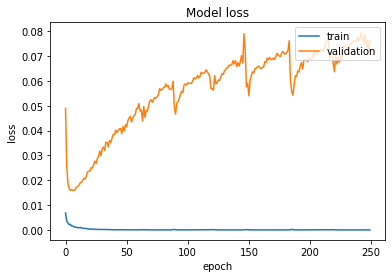

In [ ]:
optimizer_BLSTM = torch.optim.Adam(model_BLSTM.parameters(), lr=1e-3, weight_decay=1e-8) # L2 = weight_decay
model_run(model_BLSTM, optimizer_BLSTM)

# Transformers
The data require different preprocessing steps.  
1. We will reload and filter it from the raw_datasets.  
2. Retokenized the tokens according to the transfered model settings. This will create 3 new columns:  
'input_ids' - indices for represented vector of word by the selected model.  
'attention_mask' -binary tensor indicating the position of the padded indices so that the model does not attend to them.    
'labels'- labels for the new tokenization.  

3. Realaigning input and labels (Adding the special tokens [CLS] and [SEP] and subword tokenization creates a mismatch between the input and labels)  
4. Padding  

## Install packeges

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 577 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a144a1273a967fc912001f32ad4d963e563f11a1f66c5f74b071ce2543124e3b
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


## Load and filter data


In [ ]:
dataset = raw_datasets.filter((lambda x: len(x["tokens"])<64))

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

## Retokenized data

bert-base-NER-uncased was selected as our base model for educational purposes, as other domain specific models that I found were already trained with the data set used in this project.

In [ ]:
from transformers import AutoTokenizer
model_name = "dslim/bert-base-NER-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp5sm5m1hu


Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

storing https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/eb37fc07edfa44049a84892231be8fae9e80a8140723bb564df730743f9adec4.13a045cad07359e6844c4f487af8e6323ad2308cac6357692d2359f1a9711443
creating metadata file for /root/.cache/huggingface/transformers/eb37fc07edfa44049a84892231be8fae9e80a8140723bb564df730743f9adec4.13a045cad07359e6844c4f487af8e6323ad2308cac6357692d2359f1a9711443
https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpu_z39txv


Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

storing https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/4af72e6447be6dcd14f7c381e45ea035194253b8558ef17539e096f02d0714fb.e4825a319c7c1e713c683e75dca48db08b9e9733ed5f500d95e326870fbad853
creating metadata file for /root/.cache/huggingface/transformers/4af72e6447be6dcd14f7c381e45ea035194253b8558ef17539e096f02d0714fb.e4825a319c7c1e713c683e75dca48db08b9e9733ed5f500d95e326870fbad853
loading configuration file https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/4af72e6447be6dcd14f7c381e45ea035194253b8558ef17539e096f02d0714fb.e4825a319c7c1e713c683e75dca48db08b9e9733ed5f500d95e326870fbad853
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER-uncased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "eos_token_ids": null,
  "hidden_act": "gelu",
  "

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/51412bc7d0d76ac66e5ddf5d4f4330bff5e3c0136de1bcc5ca80bd338e6f02b5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/51412bc7d0d76ac66e5ddf5d4f4330bff5e3c0136de1bcc5ca80bd338e6f02b5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpkse24kyp


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/0b1a55ffc37bcf68f719737efb41704abc3f8f3cc1dd0200ce6ee90385ec6401.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/0b1a55ffc37bcf68f719737efb41704abc3f8f3cc1dd0200ce6ee90385ec6401.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/51412bc7d0d76ac66e5ddf5d4f4330bff5e3c0136de1bcc5ca80bd338e6f02b5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co

In [ ]:
'''
The function perform the following operations:
1. Mapping all tokens to their corresponding word with the word_ids method.
2. Assigning the label -100 to the special tokens [CLS] and [SEP] so the PyTorch loss function ignores them.
3. Only labeling the first token of a given word. Assign -100 to other subtokens from the same word.
'''
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"],
                                 padding = True, max_length=64,
                                 truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tok_dataset = dataset.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
## apply tokenization and align of tokens to dataset
random_num = [i for i in random.sample(range(0, 18463), filter_train)] ## reduce number of training samples
train_token = tok_dataset["train"].select(random_num)
test_token = tok_dataset["test"]
val_token = tok_dataset["validation"]

## Model

### Initialize model
We are using "distilbert-base-uncased" as our base model.

In [ ]:
len(label_names)

11

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
label_names = raw_datasets["train"].features["ner_tags"].feature.names
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_names), ignore_mismatched_sizes=True)

loading configuration file https://huggingface.co/dslim/bert-base-NER-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/4af72e6447be6dcd14f7c381e45ea035194253b8558ef17539e096f02d0714fb.e4825a319c7c1e713c683e75dca48db08b9e9733ed5f500d95e326870fbad853
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER-uncased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "eos_token_ids": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
  

### Setting up trainer

In [ ]:
'''
Model parameters for trainer
'''
batch_size = 15
task = "ner"
model_folder = model_name.split("/")[-1] ## set folder to save model checkpoints
args = TrainingArguments(
    f"{model_folder}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
'''
Model evaluation function for trainer
'''
from datasets import load_metric
## The data collator form a batch by using a list of dataset elements as input.  
## The data collators may apply some processing (like padding)
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)
## load Metric for Evaluation
metric = load_metric('seqeval')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
## Setting up Trainer 
trainer = Trainer(
    model,
    args,
    train_dataset = train_token,
    eval_dataset = test_token,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

### Train model

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, ner_tags. If id, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15000
  Num Epochs = 10
  Instantaneous batch size per device = 15
  Total train batch size (w. parallel, distributed & accumulation) = 15
  Gradient Accumulation steps = 1
  Total optimization steps = 10000


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.313000,0.263430,0.526556,0.685053,0.595438,0.913334
2,0.236100,0.235811,0.579898,0.728088,0.645598,0.922404
3,0.205400,0.219944,0.614532,0.739241,0.671142,0.927992
4,0.185800,0.218161,0.628163,0.746272,0.682143,0.929796
5,0.183700,0.212664,0.636438,0.750394,0.688734,0.932027
6,0.171700,0.210203,0.646610,0.750394,0.694647,0.933340
7,0.166600,0.214509,0.640780,0.761183,0.695811,0.931631
8,0.162500,0.211484,0.644458,0.756334,0.695929,0.932996
9,0.163800,0.216348,0.639459,0.762638,0.695638,0.931276
10,0.159000,0.214066,0.643530,0.762032,0.697785,0.932485


Saving model checkpoint to bert-base-NER-uncased-finetuned-ner/checkpoint-500
Configuration saved in bert-base-NER-uncased-finetuned-ner/checkpoint-500/config.json
Model weights saved in bert-base-NER-uncased-finetuned-ner/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-NER-uncased-finetuned-ner/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-NER-uncased-finetuned-ner/checkpoint-500/special_tokens_map.json
Saving model checkpoint to bert-base-NER-uncased-finetuned-ner/checkpoint-1000
Configuration saved in bert-base-NER-uncased-finetuned-ner/checkpoint-1000/config.json
Model weights saved in bert-base-NER-uncased-finetuned-ner/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in bert-base-NER-uncased-finetuned-ner/checkpoint-1000/tokenizer_config.json
Special tokens file saved in bert-base-NER-uncased-finetuned-ner/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a correspond

TrainOutput(global_step=10000, training_loss=0.21136902923583983, metrics={'train_runtime': 1442.7196, 'train_samples_per_second': 103.97, 'train_steps_per_second': 6.931, 'total_flos': 4899712838400000.0, 'train_loss': 0.21136902923583983, 'epoch': 10.0})

### Evaluate model

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, ner_tags. If id, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4223
  Batch size = 15


{'epoch': 10.0,
 'eval_accuracy': 0.9324854045037532,
 'eval_f1': 0.6977854248765055,
 'eval_loss': 0.21406567096710205,
 'eval_precision': 0.6435298935298935,
 'eval_recall': 0.7620317614256273,
 'eval_runtime': 12.1428,
 'eval_samples_per_second': 347.777,
 'eval_steps_per_second': 23.224}

### Test reasults

In [ ]:
label_names

['O',
 'B-protein',
 'I-protein',
 'B-cell_type',
 'I-cell_type',
 'B-cell_line',
 'I-cell_line',
 'B-DNA',
 'I-DNA',
 'B-RNA',
 'I-RNA']

In [ ]:
predictions, labels, _ = trainer.predict(test_token)

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, ner_tags. If id, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4223
  Batch size = 15


In [ ]:
predictions, labels, _ = trainer.predict(test_token)
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, ner_tags. If id, tokens, ner_tags are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4223
  Batch size = 15


In [ ]:
import pandas as pd
pd.DataFrame(results)

,DNA,RNA,cell_line,cell_type,protein,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.599834,0.611511,0.453005,0.704036,0.655702,0.64353,0.762032,0.697785,0.932485
recall,0.716123,0.765766,0.641921,0.689352,0.810192,0.64353,0.762032,0.697785,0.932485
f1,0.652840,0.680000,0.531165,0.696617,0.724806,0.64353,0.762032,0.697785,0.932485
number,1011.000000,111.000000,458.000000,1822.000000,4847.000000,0.64353,0.762032,0.697785,0.932485


# Summary

RNN  
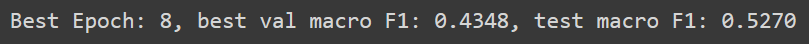
  
BRNN    
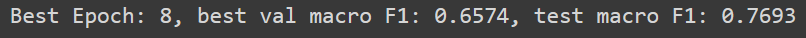  

GRU  
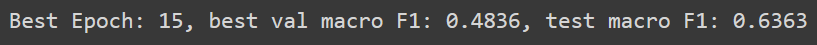  
BGRU  
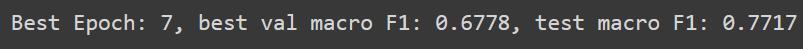  
LSTM  
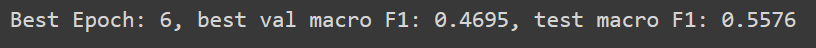  

BLSTM  
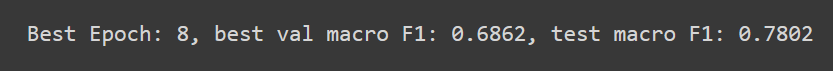

Transfer learning  
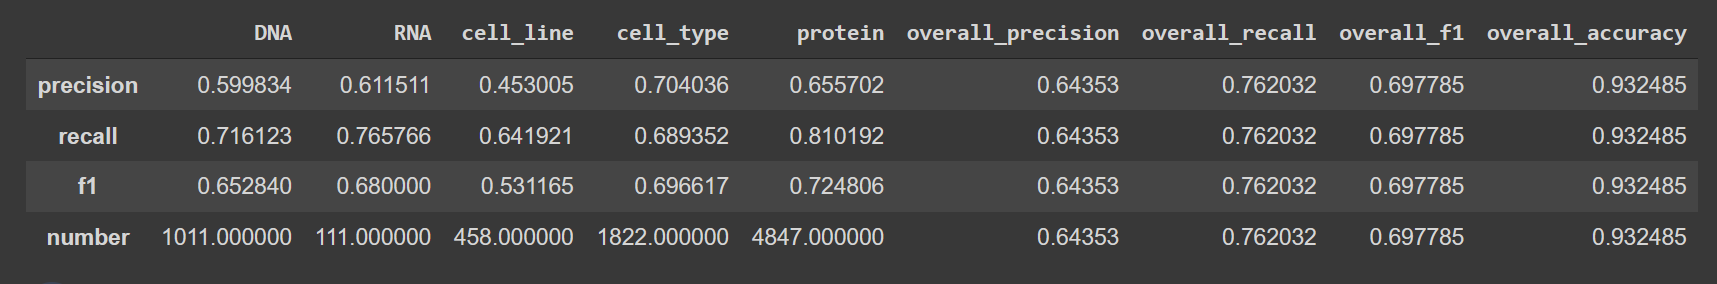

As expected, all of the bidirectional models performed better than the single direction models.    
Although the bidirectional LSTM is the best performing model with a F1 score of 0.7802, the BRNN and BGRU models are achieving similar results (0.769 and 0.771 F1 scores). This can indicate that the influence of the long term memory on our data is not significant.  
Similar results are also achieved using the transfer learning model (F1 0.69).    

**RNN models**  
All RNN models show the best performance within the first 8 to 15 epochs. From the loss graphs we can see that after reaching this point the models are starting to over fit the data to the training data (train loss is decressing and validation loss is increasing).  

**Transfer learning model**  
When inspecting the transfer learning model resaults in grater details we can see that the model performance on the "cell_line" class, which is the second smaller class is lacking behind. Rebalanceing of the classes might help in improving our results.  

   
**Additional hyperparameters that we can adjust in order to try and improve our models (using a grid/random search):**  
- **Learning rate**     
- **Dropout probability** - helps prevent neural nets from overfitting (memorizing) the data as opposed to learning it.    
- **hidden_size** = 128 ## Hyperparameter - we can select the length  
- **num_layers** = 1 ## Hyperparameter -we can also stack more then 1 RNN/LSTM/GRU to improve model.  
- **Number of Epochs**  
- **Batch size** - too large of a batch size will lead to poor generalization.  